In [1]:
import numpy as np
from numba import jit

def read_lattice(file_text, small=1.0e-10):
    enne=np.zeros((2,2))
    small=1.0e-10

    a = np.zeros((2,2)) #Primitive vectors
    b = np.zeros((2,2)) #Reciprocal vectors, see https://physics.stackexchange.com/questions/340860/reciprocal-lattice-in-2d


    ########## Reading part ##########

    # Actually read from file
    f = open(file_text, "r")
    lines=f.readlines()


    listWords = (lines[0]).split(" ")
    oper1 = listWords[0]
    a1    = float(listWords[1])
    oper2 = listWords[2]
    a2    = float(listWords[3])
    phi   = float(listWords[4])


    if (oper1=="'sqrt'"):
        a1=np.sqrt(a1)
    elif (oper1!="''"):
        print("wrong operator")
        exit()
    if (oper2=="'sqrt'"):
        a2=np.sqrt(a2)
    elif (oper2!="''"):
        print("wrong operator")
        exit()

    phi=phi*np.pi/180.

    a[0,0] = a1
    a[1,0] = 0.
    a[0,1] = a2*np.cos(phi)
    a[1,1] = a2*np.sin(phi)
    b=np.linalg.inv(a)

    nbase=int(lines[1][0]) 

    xb=np.zeros(nbase)
    yb=np.zeros(nbase)

    if nbase != 1:
        for i in range(nbase):
            listWords = (lines[2+i]).split(" ")
            oper3 = listWords[0]
            axx    = float(listWords[1])
            oper4 = listWords[2]
            ayy    = float(listWords[3])
            if (oper3=="'sqrt'"):
                axx=np.sqrt(axx)
            if (oper4=="'sqrt'"):
                ayy=np.sqrt(ayy)
            xb[i]=a[0,0]*axx+a[0,1]*ayy
            yb[i]=a[1,0]*axx+a[1,1]*ayy

    listWords = (lines[-1]).split(" ")
    enne[0,0]=float(listWords[0])   
    enne[0,1]=float(listWords[1])   
    enne[1,0]=float(listWords[2])   
    enne[1,1]=float(listWords[3]) 
    
    

    if (enne[0,0]<=0. or enne[1,1]<=0.):
        print("box positioning")
        exit()

    if np.abs(np.linalg.det(enne))-int(np.abs(np.linalg.det(enne)))>1-small:
        nsite=int(np.abs(np.linalg.det(enne)))+1
    else:
        nsite=int(np.abs(np.linalg.det(enne)))

    enne1=np.linalg.inv(enne) #  Inverse N matrix
    
    ########## End Reading part ##########

    return a, b, enne, enne1, nbase, nsite, xb, yb
   
@jit(nopython=True)
def cluster(a, b, enne, enne1, nbase, nsite, xb, yb, small=1.0e-10):
    
    ########## Cluster and distances part ##########

    amat = np.zeros((2,2))
    Abig = np.zeros((2,2))
    Bbig = np.zeros(2) 
    XBig = np.zeros(2) 

    ndim=0

    x  = np.zeros((nsite,nbase))
    y  = np.zeros((nsite,nbase))
    i1 = np.zeros(nsite)
    i2 = np.zeros(nsite)

    n1max=int(enne[0,0]+max(0,enne[1,0]))
    n1min=int(min(0,enne[1,0]))
    n2max=int(enne[1,1]+max(0,enne[0,1]))
    n2min=int(min(0,enne[0,1]))

    for i in range(2):
        for j in range(2):
            amat[i,j]=np.dot(a[:,i],a[:,j])


    for n1 in range(n1min,n1max+1):
        for n2 in range(n2min,n2max+1):
            for i in range(2):
                for j in range(2):
                    Abig[i,j]=np.dot(enne[j,:],amat[:,i])
                Bbig[i]=n1*amat[0,i]+n2*amat[1,i]
            XBig = np.linalg.solve(Abig, Bbig)
            iflag = False
            for i in range(2):
                if (np.abs(XBig[i])<small):
                    XBig[i] = 0.
                if (np.abs(XBig[i]-1)<small):
                    XBig[i] = 1.
                if (XBig[i]<0. or XBig[i]>=1.):
                    iflag = True
            if iflag == False:
                for j in range(nbase):
                    x[ndim,j]=xb[j]+float(n1)*a[0,0]+float(n2)*a[0,1]
                    y[ndim,j]=yb[j]+float(n1)*a[1,0]+float(n2)*a[1,1]
                i1[ndim]=n1
                i2[ndim]=n2
                ndim=ndim+1

    if(nsite!=ndim):
        print("wrong site number ",nsite," ",ndim)
        

    print("Nsite=",ndim)
    print("Nbase=",nbase)
    print("\nCLUSTER\n")
    
    # Distances

    ntotalsite=nsite*nbase

    dist = np.zeros((ntotalsite,ntotalsite))

    # print("\nDISTANCES\n")

    for it in range(ntotalsite):
        i=int(it/nbase)
        ii=it%nbase
        xi=x[i,ii]
        yi=y[i,ii]
        for jt in range(ntotalsite):
            j=int(jt/nbase)
            jj=jt%nbase
            xj=x[j,jj]
            yj=y[j,jj]

            xij=xi-xj
            yij=yi-yj
            d2=xij**2+yij**2
            dist[it,jt]=d2
            # The shortest distance may cross PBCs...
            for isg1 in range(-1,2,1):
                for isg2 in range(-1,2,1):
                    xt=xij+(isg1*enne[0,0]+isg2*enne[1,0])*a[0,0]+(isg1*enne[0,1]+isg2*enne[1,1])*a[0,1]
                    yt=yij+(isg1*enne[0,0]+isg2*enne[1,0])*a[1,0]+(isg1*enne[0,1]+isg2*enne[1,1])*a[1,1]
                    d2t=xt**2+yt**2
                    if (d2t<dist[it,jt]):
                        dist[it,jt]=d2t
            dist[it,jt]=np.sqrt(dist[it,jt])
    #         print(it,jt,dist[it,jt])

     ########## End Cluster and distances part ##########

    return x, y, i1, i2, dist
    
def indip_distances(dist, small=1.0e-10):
    #  Independent distances

#     dindip=np.unique(dist.round(decimals=-int(np.log10(small))+1))[1:] #the [1:] at the end is to discard the distance 0., the round function is essential!
#     nind=dindip.size
    
    nind_previous=-1
    nind=-10
    
    dec=-int(np.log10(small))+2
    while nind!=nind_previous:
        nind_previous=nind
        dindip=np.unique(dist.round(decimals=dec))[1:] #the [1:] at the end is to discard the distance 0., the round function is essential!
        nind=dindip.size
        dec=dec-1

    print("\nTOTAL INDEPENDENT DISTANCES = "+str(nind)+"\n")

    for i in range(nind):
        print(i+1,dindip[i])
        
    dist_matrix = np.empty_like(dist)
    
    for it in range(np.shape(dist)[0]):
        for jt in range(np.shape(dist)[0]):
            if it==jt:
                dist_matrix[it,jt] = 0
            else:
                for ind_dist in range(len(dindip)):
                    if np.abs(dist[it,jt]-dindip[ind_dist])<small:
                        dist_matrix[it,jt] = ind_dist+1

    return dindip, dist_matrix

@jit(nopython=True)
def momenta_out(b, enne, enne1, nsite):
    #  Allowed momenta (in units of 2*pi)

    nmom=0
    n1max=int(enne[0,0]+max(0,enne[0,1]))
    n1min=int(min(0,enne[0,1]))
    n2max=int(enne[1,1]+max(0,enne[1,0]))
    n2min=int(min(0,enne[1,0]))

    uno=1.-small
    with open('momenta.out', 'w') as momenta_output:
        for n1 in range(n1min,n1max+1):
            for n2 in range(n2min,n2max+1):
                eig1=enne1[0,0]*n1+enne1[0,1]*n2
                eig2=enne1[1,0]*n1+enne1[1,1]*n2
                if (eig1>=0. and eig1<uno and eig2>=0. and eig2<uno):
                    qx=eig1*b[0,0]+eig2*b[0,1]
                    qy=eig1*b[1,0]+eig2*b[1,1]
                    nmom=nmom+1
                    momenta_output.write(str(qx)+"   "+str(qy)+"\n")

    print("\nIndipendent momenta=",nmom,"\n")      

    if(nmom!=ndim):
        print("Problems in determining the momenta")

    with open('positions_lattice.out', 'w') as lattice_output:
        for i in range(ndim):
            lattice_output.write(str(x[i,0])+"   "+str(y[i,0])+"\n")
    
    return

@jit(nopython=True)
def table_neighbours(dist, dindip, ndim, nbase, nsite, i1, i2, enne1, small=1.0e-10):
    
    ########## Table of neighbours ##########   

    nindm=dindip.size
    ntotalsite=nsite*nbase
    imulti = np.zeros(nindm)
    imark  = np.zeros(ndim*nbase)

    for k in range(nindm):
        d=dindip[k]
        for i in range(ndim*nbase):
            imark[i]=0
            for j in range(ndim*nbase):
                dij=dist[i,j]
                if(np.abs(dij-d)<small):
                    imark[i]=imark[i]+1
        maxmulti=0   
        for i in range(ndim*nbase):
            maxmulti=max(maxmulti,imark[i])
        imulti[k]=maxmulti

    maxmulti=0   
    for k in range(nindm):
        maxmulti=max(maxmulti,imulti[k])
    maxmulti=int(maxmulti)

    ivic=np.zeros(((ntotalsite,maxmulti,nindm)))

    for k in range(nindm):
        d=dindip[k]
        for i in range(ndim*nbase):
            ii=0
            for j in range(ndim*nbase):
                dij=dist[i,j]
                if(np.abs(dij-d)<small):
                    ivic[i,ii,k]=j
                    ii=ii+1             
               
    ########################################################

    isymt=np.zeros((ntotalsite,ndim))  # table of translational symmetries

    for i in range(ndim): #sites
        for k in range(ndim): #translations
            ik1=int(i1[i])+int(i1[k])
            ik2=int(i2[i])+int(i2[k])
            iflag=0
            for l in range(ndim):
                l1=ik1-int(i1[l])
                l2=ik2-int(i2[l])
                test1=enne1[0,0]*l1+enne1[1,0]*l2
                test2=enne1[0,1]*l1+enne1[1,1]*l2
                if(np.abs(test1-float(int(test1)))<small and np.abs(test2-float(int(test2)))<small):
                    iflag=iflag+1
                    ik=l
            if(iflag!=1):
                print('wrong reduction')
                return
            for ii in range(nbase):
                j  =  i*nbase+ii
                jj = ik*nbase+ii
                isymt[j,k]=jj

    ivict=np.zeros((ntotalsite,maxmulti,nindm))
    imark=np.zeros(ndim)
    ikm=0
    iflagref=False

    if(nbase!=1): #  we do not use inversion symmetry
        for k in range(nindm):
            for i in range(nbase):
                for j in range(int(imulti[k])):
                    ii=int(np.abs(ivic[i,j,k]))
                    if(ii!=-1.): #????
                        for it in range(nsite): # traslations
                            m=isymt[i,it]
                            l=isymt[ii,it]
                            ivict[int(m),j,k]=l
    else: # we order neighbours using the inversion symmetry 
        for k in range(nindm):
            imark=np.zeros(ndim)
            jshift=int(imulti[k]/2)
            jj=-1
            for j in range(int(imulti[k])):
                i=int(np.abs(ivic[0,j,k]))
                if(imark[i]==0):
                    imark[i]=1 # mark the site
                    iflag=0
                    ik1=int(i1[i])-int(i1[0])
                    ik2=int(i2[i])-int(i2[0])
                    ikm1=-ik1+int(i1[0])
                    ikm2=-ik2+int(i2[0])
                    for l in range(ndim): #reduction
                        l1=ikm1-int(i1[l])
                        l2=ikm2-int(i2[l])
                        test1=enne1[0,0]*l1+enne1[1,0]*l2
                        test2=enne1[0,1]*l1+enne1[1,1]*l2
                        if(np.abs(test1-float(int(test1)))<small and np.abs(test2-float(int(test2)))<small):
                            iflag=iflag+1
                            ikm=l         # inverted site
                    if(iflag!=1):
                        print('wrong reduction')
                        return
                    
#                     if(i!=ikm): # there is an inverted site
#                         jj=jj+1
#                         iflagref=False
#                         imark[ikm]=1  # ...and it is inverted
#                     elif(i==ikm): # the inverted site is the site itself
#                         jj=jj+1
#                         iflagref=True
#                     for it in range(nsite): # traslations
#                         m=isymt[0,it]
#                         l=isymt[i,it]
#                         if(iflagref==False):
#                             ivict[int(m),jj,k]=l
#                             l=isymt[ikm,it]
#                             ivict[int(m),jj+jshift,k]=l
#                         elif(iflagref==True):
#                             ivict[int(m),jj,k]=l

                    if(i!=ikm): # there is an inverted site
                        jj=jj+1
                        iflagref=False
                        imark[ikm]=1  # ...and it is inverted
                    elif(i==ikm): # the inverted site is the site itself 
                        jj=jj + 1*(1-int(imulti[k])%2) # CHANGED BY DAVIDE PICCIONI
                        iflagref=True
                    for it in range(nsite): # traslations
                        m=isymt[0,it]
                        l=isymt[i,it]
                        if(iflagref==False):
                            ivict[int(m),jj,k]=l
                            l=isymt[ikm,it]
                            ivict[int(m),jj+jshift,k]=l
                        elif(iflagref==True and int(imulti[k])%2==1): # CHANGED BY DAVIDE PICCIONI
                            ivict[int(m),int(imulti[k])-1,k]=l # CHANGED BY DAVIDE PICCIONI
                        elif(iflagref==True and int(imulti[k])%2==0): # CHANGED BY DAVIDE PICCIONI
                            ivict[int(m),jj,k]=l # CHANGED BY DAVIDE PICCIONI


    ########## End Table of neighbours ########## 
    
    # My check on ivict because on rectacngular lattices sometimes it misses points (try 10x6 and look at distance 13 if you want)...
    
    for k in range(nindm):
        imult = int(imulti[k])
        
        is_everything_fine = True
        
        for i in range(ndim*nbase):
            ivic_line   = np.zeros(imult)
            ivic_line  += ivic[i,:imult,k]
            ivict_line  = np.zeros(imult)
            ivict_line += ivict[i,:imult,k]
            
            ivic_line  = np.sort(ivic_line)
            ivict_line = np.sort(ivict_line)
            
            if np.array_equal(ivic_line, ivict_line) == False:
                is_everything_fine = False
                intersection = list(set(ivic_line) & set(ivict_line))
                missing_elements = list(set(ivic_line) - set(intersection))
                for ind_mult in range(imult):
                    if (ivict[i,ind_mult,k] in intersection)==False:
                        ivict[i,ind_mult,k] = missing_elements.pop(0)
        
        if is_everything_fine == False:
            print("\nThere were problems with ivict not matching with ivic at distance ", dindip[k], " (the ",k+1,"th distance).","\nivict was forced to match ivic!!!\n\n")

                        
    return ivic, ivict, maxmulti, imulti

def print_ivic(ivic, ndim, nbase, nindm, imulti):
    
    #In this table the order of neighbours for each site is given by the lexicographic order of the sites
    print('\nTable of neighbours\n')
    for k in range(nindm):
        print('At distance k=',k+1)
        for i in range(ndim*nbase):
            print(i+1,end='      ')
            for j in range(int(imulti[k])):
                print(ivic[i,j,k]+1,end='  ')
            print(' ')
    return
    
def print_ivict(ivict, ndim, nbase, nindm, imulti):
    
    #  In this table the order of neighbours for each site is given by the order of the first site
    print('\nOrdered Table of neighbours\n')
    for k in range(nindm):
        print('At distance k=',k+1)
        for i in range(ndim*nbase):
            print(i+1,end='      ')
            for j in range(int(imulti[k])):
                print(int(ivict[i,j,k]+1),end='  ')
            print(' ')
    return

def info_out(nsite, nbase, nindm, maxmulti, imulti):
    ########## Write Information ##########       
    
    with open('info.out', 'w') as info_output:
        info_output.write(str(nsite)+"   "+str(nbase)+"   "+str(nindm)+"   "+str(maxmulti)+"\n")
        info_output.write(str(imulti)+"\n\n")
    #     info_output.write(str(isymt)+"\n")
    #     info_output.write(str(ivict)+"\n")

    ########## End Write Information ##########    
    
    return

    
   

In [5]:
# i_first = 9
# i_second = 15

# np.sqrt((x[i_first]-x[i_second])**2+(y[i_first]-y[i_second])**2)

Nsite= 9
Nbase= 2

CLUSTER


TOTAL INDEPENDENT DISTANCES = 5

1 0.57735026919
2 1.0
3 1.15470053838
4 1.52752523165
5 1.73205080757

Ordered Table of neighbours

At distance k= 1
1      2  6  14   
2      1  3  7   
3      4  2  16   
4      3  5  9   
5      6  4  18   
6      5  1  11   
7      8  12  2   
8      7  9  13   
9      10  8  4   
10      9  11  15   
11      12  10  6   
12      11  7  17   
13      14  18  8   
14      13  15  1   
15      16  14  10   
16      15  17  3   
17      18  16  12   
18      17  13  5   
At distance k= 2
1      3  5  7  11  13  15   
2      4  6  8  12  14  16   
3      5  1  9  7  15  17   
4      6  2  10  8  16  18   
5      1  3  11  9  17  13   
6      2  4  12  10  18  14   
7      9  11  13  17  1  3   
8      10  12  14  18  2  4   
9      11  7  15  13  3  5   
10      12  8  16  14  4  6   
11      7  9  17  15  5  1   
12      8  10  18  16  6  2   
13      15  17  1  5  7  9   
14      16  18  2  6  8  10   
15      17  13  3  1

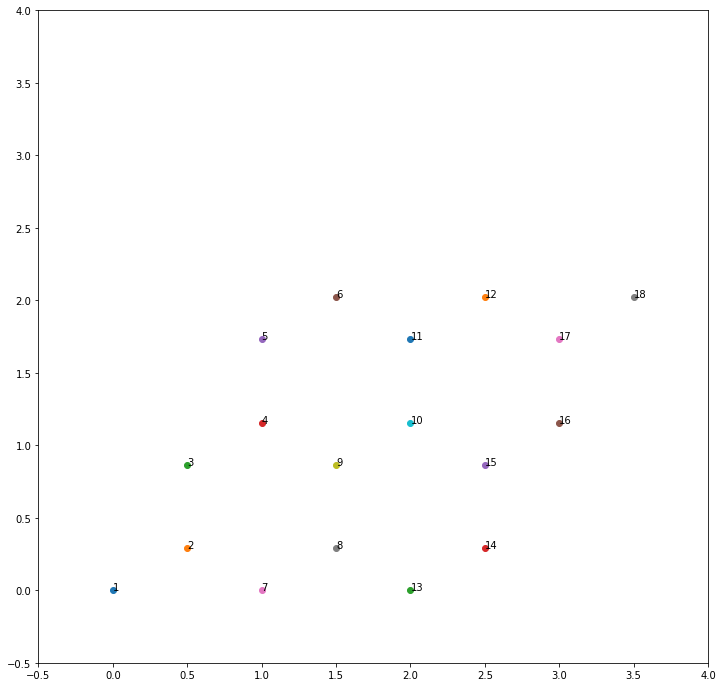

In [9]:
import time

begin = time.time()

#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%
#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%
#%#%#%                                                                              #%#%#% 
#%#%#%     ENTRIES                                                                  #%#%#%    
#%#%#%     a1=modulus of the first primitive vector                                 #%#%#% 
#%#%#%     a2=modulus of the second primitive vector                                #%#%#% 
#%#%#%     phi=angle between the two primitive vectors                              #%#%#% 
#%#%#%                                                                              #%#%#% 
#%#%#%     enne[i,j] is a 2x2 integer matrix defining the two translations which    #%#%#% 
#%#%#%     identify the cluster:                                                    #%#%#% 
#%#%#%     T_i = sum_j enne[i,j]*a_j                                                #%#%#% 
#%#%#%     Namely:                                                                  #%#%#% 
#%#%#%     T_1 = n_{0,0}*a_1 + n_{0,1}*a_2                                          #%#%#% 
#%#%#%     T_2 = n_{1,0}*a_1 + n_{1,1}*a_2                                          #%#%#% 
#%#%#%     We assume that the leading components are enne[0,0]>0 and enne[1,1]>0    #%#%#% 
#%#%#%                                                                              #%#%#% 
#%#%#%     We assume that the basis is given in terms of the components with        #%#%#% 
#%#%#%     respect to the primitive vectors.                                        #%#%#% 
#%#%#%     For example for graphene it will be given by:                            #%#%#% 
#%#%#%     x_0 = a_1*0 + a_2*0  ; x_1 = a_1*1/3 + a_2*1/3                           #%#%#% 
#%#%#%                                                                              #%#%#% 
#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%
#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%

epsilon=1.0e-10

a, b, enne, enne1, nbase, nsite, xb, yb = read_lattice(file_text="graphene_geometry.d", small=epsilon)

# a, b, enne, enne1, nbase, nsite, xb, yb = read_lattice(file_text="graphene_geometry.d", small=epsilon)
# a, b, enne, enne1, nbase, nsite, xb, yb = read_lattice(file_text="triangular_geometry.d", small=epsilon)

x, y, i1, i2, dist = cluster(a, b, enne, enne1, nbase, nsite, xb, yb, small=epsilon)

dindip, dist_matrix = indip_distances(dist, small=epsilon)

#print(dist_matrix)

ivic, ivict, maxmulti, imulti  = table_neighbours(dist, dindip, nsite, nbase, nsite, i1, i2, enne1, small=epsilon)

print_ivict(ivict, nsite, nbase, dindip.size, imulti)

info_out(nsite, nbase, dindip.size, maxmulti, imulti)

import matplotlib.pyplot as plt        
fig=plt.figure(figsize=(12, 12))
x_max = np.max(x)
y_max = np.max(y)
coord_max = max(x_max,y_max)
for i in range(nsite):
    for j in range(nbase):
#         print(i*nbase+j+1,x[i,j],y[i,j])
        plt.scatter(x[i,j],y[i,j])
        plt.annotate(str(i*nbase+j+1), xy=(x[i,j],y[i,j]))
        plt.xlim(-0.5,coord_max+0.5)
        plt.ylim(-0.5,coord_max+0.5)

print("\n")
print("Elapsed time: ",time.time()-begin)

# with open('./lattice_triangular.npy', 'wb') as f:
#     np.save(f, ivict)
#     np.save(f, imulti)
#     np.save(f, maxmulti)
#     np.save(f, dist_matrix)

# with open('./lattice_triangular.npy', 'rb') as f:
#     ivict = np.load(f)
#     imulti = np.load(f)
#     maxmulti = np.load(f)
#     dist_matrix = np.load(f)
    

In [19]:
ivict[16,2,0]+1

12.0

In [11]:
imulti

array([3., 6., 3., 3., 2.])

In [7]:
aaa = 3
ivict[int(ivict[0,aaa,12]),aaa,12]

IndexError: index 12 is out of bounds for axis 2 with size 5

In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)


print(dist_matrix)

imulti

In [11]:
# Build hopping matrices

n_hopping = 2

hopping_array_matrices = np.zeros((n_hopping,2*nsite,2*nsite))

break_rotat_symmetry = False


for distance in range(n_hopping):
    for i in range(nsite):
        for j in range(int(imulti[distance])):
            hopping_array_matrices[distance-1,i,int(ivict[i,j,distance-1])] = 1.
            hopping_array_matrices[distance-1,i+nsite,int(ivict[i,j,distance-1])+nsite] = -1.



In [13]:
ivict

array([[[ 1.,  5.,  2.,  6., 10.],
        [ 4.,  7.,  8.,  9.,  0.],
        [ 3., 15.,  0., 14.,  0.],
        [12., 13.,  0., 11.,  0.]],

       [[ 2.,  6.,  3.,  7., 11.],
        [ 5.,  4.,  9., 10.,  0.],
        [ 0., 12.,  0., 15.,  0.],
        [13., 14.,  0.,  8.,  0.]],

       [[ 3.,  7.,  0.,  4.,  8.],
        [ 6.,  5., 10., 11.,  0.],
        [ 1., 13.,  0., 12.,  0.],
        [14., 15.,  0.,  9.,  0.]],

       [[ 0.,  4.,  1.,  5.,  9.],
        [ 7.,  6., 11.,  8.,  0.],
        [ 2., 14.,  0., 13.,  0.],
        [15., 12.,  0., 10.,  0.]],

       [[ 5.,  9.,  6., 10., 14.],
        [ 8., 11., 12., 13.,  0.],
        [ 7.,  3.,  0.,  2.,  0.],
        [ 0.,  1.,  0., 15.,  0.]],

       [[ 6., 10.,  7., 11., 15.],
        [ 9.,  8., 13., 14.,  0.],
        [ 4.,  0.,  0.,  3.,  0.],
        [ 1.,  2.,  0., 12.,  0.]],

       [[ 7., 11.,  4.,  8., 12.],
        [10.,  9., 14., 15.,  0.],
        [ 5.,  1.,  0.,  0.,  0.],
        [ 2.,  3.,  0., 13.,  0.]],

      

In [6]:
print_ivict(ivict, nsite, nbase, dindip.size, imulti)


Ordered Table of neighbours

At distance k= 1
1      2.0  5.0  8.0  4.0  13.0  14.0   
2      3.0  6.0  5.0  1.0  14.0  15.0   
3      4.0  7.0  6.0  2.0  15.0  16.0   
4      1.0  8.0  7.0  3.0  16.0  13.0   
5      6.0  9.0  12.0  8.0  1.0  2.0   
6      7.0  10.0  9.0  5.0  2.0  3.0   
7      8.0  11.0  10.0  6.0  3.0  4.0   
8      5.0  12.0  11.0  7.0  4.0  1.0   
9      10.0  13.0  16.0  12.0  5.0  6.0   
10      11.0  14.0  13.0  9.0  6.0  7.0   
11      12.0  15.0  14.0  10.0  7.0  8.0   
12      9.0  16.0  15.0  11.0  8.0  5.0   
13      14.0  1.0  4.0  16.0  9.0  10.0   
14      15.0  2.0  1.0  13.0  10.0  11.0   
15      16.0  3.0  2.0  14.0  11.0  12.0   
16      13.0  4.0  3.0  15.0  12.0  9.0   
At distance k= 2
1      6.0  7.0  10.0  16.0  15.0  12.0   
2      7.0  8.0  11.0  13.0  16.0  9.0   
3      8.0  5.0  12.0  14.0  13.0  10.0   
4      5.0  6.0  9.0  15.0  14.0  11.0   
5      10.0  11.0  14.0  4.0  3.0  16.0   
6      11.0  12.0  15.0  1.0  4.0  13.0   
7      

0.0 0.0
0
0.5 0.28867513459481287
0
0.5000000000000001 0.8660254037844386
1
1.0 1.1547005383792515
1
1.0000000000000002 1.7320508075688772
2
1.5000000000000002 2.02072594216369
2
1.5000000000000004 2.598076211353316
3
2.0000000000000004 2.886751345948129
3
2.0000000000000004 3.4641016151377544
4
2.5000000000000004 3.7527767497325675
4
2.5000000000000004 4.330127018922193
5
3.0000000000000004 4.618802153517006
5
3.000000000000001 5.196152422706632
6
3.500000000000001 5.484827557301445
6
3.500000000000001 6.06217782649107
7
4.000000000000001 6.3508529610858835
7
4.000000000000001 6.928203230275509
8
4.500000000000001 7.216878364870322
8
4.500000000000001 7.794228634059947
9
5.000000000000001 8.08290376865476
9
1.0 0.0
10
1.5 0.28867513459481287
10
1.5 0.8660254037844386
11
2.0 1.1547005383792515
11
2.0 1.7320508075688772
12
2.5 2.02072594216369
12
2.5000000000000004 2.598076211353316
13
3.0000000000000004 2.886751345948129
13
3.0000000000000004 3.4641016151377544
14
3.5000000000000004 3.

90      92  88  110  108  70  72   
91      93  89  111  109  71  73   
92      94  90  112  110  72  74   
93      95  91  113  111  73  75   
94      96  92  114  112  74  76   
95      97  93  115  113  75  77   
96      98  94  116  114  76  78   
97      99  95  117  115  77  79   
98      100  96  118  116  78  80   
99      81  97  119  117  79  61   
100      82  98  120  118  80  62   
101      103  119  121  139  81  83   
102      104  120  122  140  82  84   
103      105  101  123  121  83  85   
104      106  102  124  122  84  86   
105      107  103  125  123  85  87   
106      108  104  126  124  86  88   
107      109  105  127  125  87  89   
108      110  106  128  126  88  90   
109      111  107  129  127  89  91   
110      112  108  130  128  90  92   
111      113  109  131  129  91  93   
112      114  110  132  130  92  94   
113      115  111  133  131  93  95   
114      116  112  134  132  94  96   
115      117  113  135  133  95  97   
116      118  114

139      122  136  160  156  100  82   
140      123  137  179  177  119  103   
141      144  158  162  178  102  104   
142      145  159  181  199  121  125   
143      146  160  164  180  104  106   
144      147  141  183  181  123  127   
145      148  142  166  162  106  108   
146      149  143  185  183  125  129   
147      150  144  168  164  108  110   
148      151  145  187  185  127  131   
149      152  146  170  166  110  112   
150      153  147  189  187  129  133   
151      154  148  172  168  112  114   
152      155  149  191  189  131  135   
153      156  150  174  170  114  116   
154      157  151  193  191  133  137   
155      158  152  176  172  116  118   
156      159  153  195  193  135  139   
157      160  154  178  174  118  120   
158      141  155  197  195  137  121   
159      142  156  180  176  120  102   
160      143  157  199  197  139  123   
161      164  178  182  198  122  124   
162      165  179  1  19  141  145   
163      166  180  1

114      118  110  154  150  74  78   
115      119  111  155  151  75  79   
116      120  112  156  152  76  80   
117      101  113  157  153  77  61   
118      102  114  158  154  78  62   
119      103  115  159  155  79  63   
120      104  116  160  156  80  64   
121      125  137  161  177  81  85   
122      126  138  162  178  82  86   
123      127  139  163  179  83  87   
124      128  140  164  180  84  88   
125      129  121  165  161  85  89   
126      130  122  166  162  86  90   
127      131  123  167  163  87  91   
128      132  124  168  164  88  92   
129      133  125  169  165  89  93   
130      134  126  170  166  90  94   
131      135  127  171  167  91  95   
132      136  128  172  168  92  96   
133      137  129  173  169  93  97   
134      138  130  174  170  94  98   
135      139  131  175  171  95  99   
136      140  132  176  172  96  100   
137      121  133  177  173  97  81   
138      122  134  178  174  98  82   
139      123  135  179  

140      197  105  117   
141      164  176  84   
142      19  127  139   
143      166  178  86   
144      1  129  121   
145      168  180  88   
146      3  131  123   
147      170  162  90   
148      5  133  125   
149      172  164  92   
150      7  135  127   
151      174  166  94   
152      9  137  129   
153      176  168  96   
154      11  139  131   
155      178  170  98   
156      13  121  133   
157      180  172  100   
158      15  123  135   
159      162  174  82   
160      17  125  137   
161      184  196  104   
162      39  147  159   
163      186  198  106   
164      21  149  141   
165      188  200  108   
166      23  151  143   
167      190  182  110   
168      25  153  145   
169      192  184  112   
170      27  155  147   
171      194  186  114   
172      29  157  149   
173      196  188  116   
174      31  159  151   
175      198  190  118   
176      33  141  153   
177      200  192  120   
178      35  143  155   
179      182  194  

79      83  93  101  113  135  137  1  3  25  37  45  55   
80      84  94  102  114  136  138  2  4  26  38  46  56   
81      105  115  123  135  157  159  23  25  47  59  67  77   
82      106  116  124  136  158  160  24  26  48  60  68  78   
83      107  117  125  137  159  141  25  27  49  41  69  79   
84      108  118  126  138  160  142  26  28  50  42  70  80   
85      109  119  127  139  141  143  27  29  51  43  71  61   
86      110  120  128  140  142  144  28  30  52  44  72  62   
87      111  101  129  121  143  145  29  31  53  45  73  63   
88      112  102  130  122  144  146  30  32  54  46  74  64   
89      113  103  131  123  145  147  31  33  55  47  75  65   
90      114  104  132  124  146  148  32  34  56  48  76  66   
91      115  105  133  125  147  149  33  35  57  49  77  67   
92      116  106  134  126  148  150  34  36  58  50  78  68   
93      117  107  135  127  149  151  35  37  59  51  79  69   
94      118  108  136  128  150  152  36  38  60

99      85  93  159  153  39  25   
100      86  94  160  154  40  26   
101      107  115  161  175  41  47   
102      108  116  162  176  42  48   
103      109  117  163  177  43  49   
104      110  118  164  178  44  50   
105      111  119  165  179  45  51   
106      112  120  166  180  46  52   
107      113  101  167  161  47  53   
108      114  102  168  162  48  54   
109      115  103  169  163  49  55   
110      116  104  170  164  50  56   
111      117  105  171  165  51  57   
112      118  106  172  166  52  58   
113      119  107  173  167  53  59   
114      120  108  174  168  54  60   
115      101  109  175  169  55  41   
116      102  110  176  170  56  42   
117      103  111  177  171  57  43   
118      104  112  178  172  58  44   
119      105  113  179  173  59  45   
120      106  114  180  174  60  46   
121      127  135  181  195  61  67   
122      128  136  182  196  62  68   
123      129  137  183  197  63  69   
124      130  138  184  198  6

36      111  113  183  193  3  11   
37      42  50  80  70  160  142   
38      113  115  185  195  5  13   
39      44  52  62  72  142  144   
40      115  117  187  197  7  15   
41      66  74  84  94  164  166   
42      137  139  9  19  29  37   
43      68  76  86  96  166  168   
44      139  121  11  1  31  39   
45      70  78  88  98  168  170   
46      121  123  13  3  33  21   
47      72  80  90  100  170  172   
48      123  125  15  5  35  23   
49      74  62  92  82  172  174   
50      125  127  17  7  37  25   
51      76  64  94  84  174  176   
52      127  129  19  9  39  27   
53      78  66  96  86  176  178   
54      129  131  1  11  21  29   
55      80  68  98  88  178  180   
56      131  133  3  13  23  31   
57      62  70  100  90  180  162   
58      133  135  5  15  25  33   
59      64  72  82  92  162  164   
60      135  137  7  17  27  35   
61      86  94  104  114  184  186   
62      157  159  29  39  49  57   
63      88  96  106  116  186  

61      105  113  157  185  29  37   
62      106  114  158  186  30  38   
63      107  115  159  187  31  39   
64      108  116  160  188  32  40   
65      109  117  141  189  33  21   
66      110  118  142  190  34  22   
67      111  119  143  191  35  23   
68      112  120  144  192  36  24   
69      113  101  145  193  37  25   
70      114  102  146  194  38  26   
71      115  103  147  195  39  27   
72      116  104  148  196  40  28   
73      117  105  149  197  21  29   
74      118  106  150  198  22  30   
75      119  107  151  199  23  31   
76      120  108  152  200  24  32   
77      101  109  153  181  25  33   
78      102  110  154  182  26  34   
79      103  111  155  183  27  35   
80      104  112  156  184  28  36   
81      125  133  177  5  49  57   
82      126  134  178  6  50  58   
83      127  135  179  7  51  59   
84      128  136  180  8  52  60   
85      129  137  161  9  53  41   
86      130  138  162  10  54  42   
87      131  139  163  

20      26  32  62  72  94  98  122  126  148  158  188  194   
21      47  53  83  93  115  119  143  147  169  179  9  15   
22      48  54  84  94  116  120  144  148  170  180  10  16   
23      49  55  85  95  117  101  145  149  171  161  11  17   
24      50  56  86  96  118  102  146  150  172  162  12  18   
25      51  57  87  97  119  103  147  151  173  163  13  19   
26      52  58  88  98  120  104  148  152  174  164  14  20   
27      53  59  89  99  101  105  149  153  175  165  15  1   
28      54  60  90  100  102  106  150  154  176  166  16  2   
29      55  41  91  81  103  107  151  155  177  167  17  3   
30      56  42  92  82  104  108  152  156  178  168  18  4   
31      57  43  93  83  105  109  153  157  179  169  19  5   
32      58  44  94  84  106  110  154  158  180  170  20  6   
33      59  45  95  85  107  111  155  159  161  171  1  7   
34      60  46  96  86  108  112  156  160  162  172  2  8   
35      41  47  97  87  109  113  157  141  163  1

60      85  91  103  111  163  165   
61      156  158  10  18  30  36   
62      107  113  125  133  185  187   
63      158  160  12  20  32  38   
64      109  115  127  135  187  189   
65      160  142  14  2  34  40   
66      111  117  129  137  189  191   
67      142  144  16  4  36  22   
68      113  119  131  139  191  193   
69      144  146  18  6  38  24   
70      115  101  133  121  193  195   
71      146  148  20  8  40  26   
72      117  103  135  123  195  197   
73      148  150  2  10  22  28   
74      119  105  137  125  197  199   
75      150  152  4  12  24  30   
76      101  107  139  127  199  181   
77      152  154  6  14  26  32   
78      103  109  121  129  181  183   
79      154  156  8  16  28  34   
80      105  111  123  131  183  185   
81      176  178  30  38  50  56   
82      127  133  145  153  5  7   
83      178  180  32  40  52  58   
84      129  135  147  155  7  9   
85      180  162  34  22  54  60   
86      131  137  149  157  9 

25      70  76  118  104  130  154  144  14  18   
26      53  57  107  117  121  147  153  195  181   
27      72  78  120  106  132  156  146  16  20   
28      55  59  109  119  123  149  155  197  183   
29      74  80  102  108  134  158  148  18  2   
30      57  41  111  101  125  151  157  199  185   
31      76  62  104  110  136  160  150  20  4   
32      59  43  113  103  127  153  159  181  187   
33      78  64  106  112  138  142  152  2  6   
34      41  45  115  105  129  155  141  183  189   
35      80  66  108  114  140  144  154  4  8   
36      43  47  117  107  131  157  143  185  191   
37      62  68  110  116  122  146  156  6  10   
38      45  49  119  109  133  159  145  187  193   
39      64  70  112  118  124  148  158  8  12   
40      47  51  101  111  135  141  147  189  195   
41      86  92  134  140  146  170  180  30  34   
42      69  73  123  133  157  163  169  11  17   
43      88  94  136  122  148  172  162  32  36   
44      71  75  125  13

65      92  96  128  136  168  172   
66      179  163  15  3  55  59   
67      94  98  130  138  170  174   
68      161  165  17  5  57  41   
69      96  100  132  140  172  176   
70      163  167  19  7  59  43   
71      98  82  134  122  174  178   
72      165  169  1  9  41  45   
73      100  84  136  124  176  180   
74      167  171  3  11  43  47   
75      82  86  138  126  178  162   
76      169  173  5  13  45  49   
77      84  88  140  128  180  164   
78      171  175  7  15  47  51   
79      86  90  122  130  162  166   
80      173  177  9  17  49  53   
81      108  112  144  152  184  188   
82      195  199  31  39  71  75   
83      110  114  146  154  186  190   
84      197  181  33  21  73  77   
85      112  116  148  156  188  192   
86      199  183  35  23  75  79   
87      114  118  150  158  190  194   
88      181  185  37  25  77  61   
89      116  120  152  160  192  196   
90      183  187  39  27  79  63   
91      118  102  154  142  194  19

167      13  17  31  37  71  73  61  63  117  103  137  121   
168      14  18  32  38  72  74  62  64  118  104  138  122   
169      15  19  33  39  73  75  63  65  119  105  139  123   
170      16  20  34  40  74  76  64  66  120  106  140  124   
171      17  1  35  21  75  77  65  67  101  107  121  125   
172      18  2  36  22  76  78  66  68  102  108  122  126   
173      19  3  37  23  77  79  67  69  103  109  123  127   
174      20  4  38  24  78  80  68  70  104  110  124  128   
175      1  5  39  25  79  61  69  71  105  111  125  129   
176      2  6  40  26  80  62  70  72  106  112  126  130   
177      3  7  21  27  61  63  71  73  107  113  127  131   
178      4  8  22  28  62  64  72  74  108  114  128  132   
179      5  9  23  29  63  65  73  75  109  115  129  133   
180      6  10  24  30  64  66  74  76  110  116  130  134   
181      27  31  45  51  85  87  95  97  131  137  151  155   
182      28  32  46  52  86  88  96  98  132  138  152  156   
183    

42      70  72  124  132  144  150  154  160  172  180  32  34   
43      71  73  125  133  145  151  155  141  173  161  33  35   
44      72  74  126  134  146  152  156  142  174  162  34  36   
45      73  75  127  135  147  153  157  143  175  163  35  37   
46      74  76  128  136  148  154  158  144  176  164  36  38   
47      75  77  129  137  149  155  159  145  177  165  37  39   
48      76  78  130  138  150  156  160  146  178  166  38  40   
49      77  79  131  139  151  157  141  147  179  167  39  21   
50      78  80  132  140  152  158  142  148  180  168  40  22   
51      79  61  133  121  153  159  143  149  161  169  21  23   
52      80  62  134  122  154  160  144  150  162  170  22  24   
53      61  63  135  123  155  141  145  151  163  171  23  25   
54      62  64  136  124  156  142  146  152  164  172  24  26   
55      63  65  137  125  157  143  147  153  165  173  25  27   
56      64  66  138  126  158  144  148  154  166  174  26  28   
57      65

1      116  152  156   
2      67  71  107   
3      118  154  158   
4      69  73  109   
5      120  156  160   
6      71  75  111   
7      102  158  142   
8      73  77  113   
9      104  160  144   
10      75  79  115   
11      106  142  146   
12      77  61  117   
13      108  144  148   
14      79  63  119   
15      110  146  150   
16      61  65  101   
17      112  148  152   
18      63  67  103   
19      114  150  154   
20      65  69  105   
21      136  172  176   
22      87  91  127   
23      138  174  178   
24      89  93  129   
25      140  176  180   
26      91  95  131   
27      122  178  162   
28      93  97  133   
29      124  180  164   
30      95  99  135   
31      126  162  166   
32      97  81  137   
33      128  164  168   
34      99  83  139   
35      130  166  170   
36      81  85  121   
37      132  168  172   
38      83  87  123   
39      134  170  174   
40      85  89  125   
41      156  192  196   
42      107  111  147   

157      50  54  68  74  108  110   
158      185  187  21  27  41  45   
159      52  56  70  76  110  112   
160      187  189  23  29  43  47   
161      74  78  92  98  132  134   
162      9  11  45  51  65  69   
163      76  80  94  100  134  136   
164      11  13  47  53  67  71   
165      78  62  96  82  136  138   
166      13  15  49  55  69  73   
167      80  64  98  84  138  140   
168      15  17  51  57  71  75   
169      62  66  100  86  140  122   
170      17  19  53  59  73  77   
171      64  68  82  88  122  124   
172      19  1  55  41  75  79   
173      66  70  84  90  124  126   
174      1  3  57  43  77  61   
175      68  72  86  92  126  128   
176      3  5  59  45  79  63   
177      70  74  88  94  128  130   
178      5  7  41  47  61  65   
179      72  76  90  96  130  132   
180      7  9  43  49  63  67   
181      94  98  112  118  152  154   
182      29  31  65  71  85  89   
183      96  100  114  120  154  156   
184      31  33  67  73  8

89      99  189  199   
90      100  190  200   
91      81  191  181   
92      82  192  182   
93      83  193  183   
94      84  194  184   
95      85  195  185   
96      86  196  186   
97      87  197  187   
98      88  198  188   
99      89  199  189   
100      90  200  190   
101      111  1  11   
102      112  2  12   
103      113  3  13   
104      114  4  14   
105      115  5  15   
106      116  6  16   
107      117  7  17   
108      118  8  18   
109      119  9  19   
110      120  10  20   
111      101  11  1   
112      102  12  2   
113      103  13  3   
114      104  14  4   
115      105  15  5   
116      106  16  6   
117      107  17  7   
118      108  18  8   
119      109  19  9   
120      110  20  10   
121      131  21  31   
122      132  22  32   
123      133  23  33   
124      134  24  34   
125      135  25  35   
126      136  26  36   
127      137  27  37   
128      138  28  38   
129      139  29  39   
130      140  30  40   
131     

134      45  51  105   
135      144  18  4   
136      47  53  107   
137      146  20  6   
138      49  55  109   
139      148  2  8   
140      51  57  111   
141      170  24  30   
142      73  79  133   
143      172  26  32   
144      75  61  135   
145      174  28  34   
146      77  63  137   
147      176  30  36   
148      79  65  139   
149      178  32  38   
150      61  67  121   
151      180  34  40   
152      63  69  123   
153      162  36  22   
154      65  71  125   
155      164  38  24   
156      67  73  127   
157      166  40  26   
158      69  75  129   
159      168  22  28   
160      71  77  131   
161      190  44  50   
162      93  99  153   
163      192  46  52   
164      95  81  155   
165      194  48  54   
166      97  83  157   
167      196  50  56   
168      99  85  159   
169      198  52  58   
170      81  87  141   
171      200  54  60   
172      83  89  143   
173      182  56  42   
174      85  91  145   
175      184  58  44

93      121  177  161  5  9  45   
94      122  178  162  6  10  46   
95      123  179  163  7  11  47   
96      124  180  164  8  12  48   
97      125  161  165  9  13  49   
98      126  162  166  10  14  50   
99      127  163  167  11  15  51   
100      128  164  168  12  16  52   
101      149  185  189  33  37  73   
102      150  186  190  34  38  74   
103      151  187  191  35  39  75   
104      152  188  192  36  40  76   
105      153  189  193  37  21  77   
106      154  190  194  38  22  78   
107      155  191  195  39  23  79   
108      156  192  196  40  24  80   
109      157  193  197  21  25  61   
110      158  194  198  22  26  62   
111      159  195  199  23  27  63   
112      160  196  200  24  28  64   
113      141  197  181  25  29  65   
114      142  198  182  26  30  66   
115      143  199  183  27  31  67   
116      144  200  184  28  32  68   
117      145  181  185  29  33  69   
118      146  182  186  30  34  70   
119      147  183  187  3

87      154   
88      21   
89      156   
90      23   
91      158   
92      25   
93      160   
94      27   
95      142   
96      29   
97      144   
98      31   
99      146   
100      33   
101      168   
102      55   
103      170   
104      57   
105      172   
106      59   
107      174   
108      41   
109      176   
110      43   
111      178   
112      45   
113      180   
114      47   
115      162   
116      49   
117      164   
118      51   
119      166   
120      53   
121      188   
122      75   
123      190   
124      77   
125      192   
126      79   
127      194   
128      61   
129      196   
130      63   
131      198   
132      65   
133      200   
134      67   
135      182   
136      69   
137      184   
138      71   
139      186   
140      73   
141      8   
142      95   
143      10   
144      97   
145      12   
146      99   
147      14   
148      81   
149      16   
150      83   
151      18   
152      85 

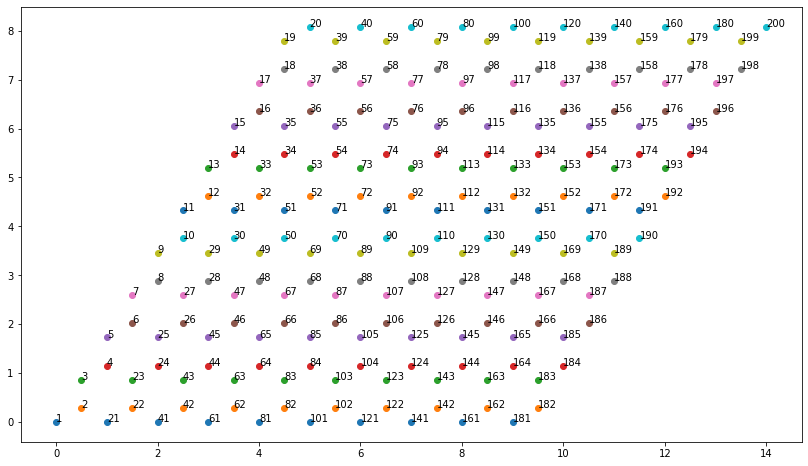

In [5]:
import numpy as np
import time

begin = time.time()

#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%
#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%
#%#%#%                                                                              #%#%#% 
#%#%#%     ENTRIES                                                                  #%#%#%    
#%#%#%     a1=modulus of the first primitive vector                                 #%#%#% 
#%#%#%     a2=modulus of the second primitive vector                                #%#%#% 
#%#%#%     phi=angle between the two primitive vectors                              #%#%#% 
#%#%#%                                                                              #%#%#% 
#%#%#%     enne[i,j] is a 2x2 integer matrix defining the two translations which    #%#%#% 
#%#%#%     identify the cluster:                                                    #%#%#% 
#%#%#%     T_i = sum_j enne[i,j]*a_j                                                #%#%#% 
#%#%#%     Namely:                                                                  #%#%#% 
#%#%#%     T_1 = n_{0,0}*a_1 + n_{0,1}*a_2                                          #%#%#% 
#%#%#%     T_2 = n_{1,0}*a_1 + n_{1,1}*a_2                                          #%#%#% 
#%#%#%     We assume that the leading components are enne[0,0]>0 and enne[1,1]>0    #%#%#% 
#%#%#%                                                                              #%#%#% 
#%#%#%     We assume that the basis is given in terms of the components with        #%#%#% 
#%#%#%     respect to the primitive vectors.                                        #%#%#% 
#%#%#%     For example for graphene it will be given by:                            #%#%#% 
#%#%#%     x_0 = a_1*0 + a_2*0  ; x_1 = a_1*1/3 + a_2*1/3                           #%#%#% 
#%#%#%                                                                              #%#%#% 
#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%
#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%#%



enne=np.zeros((2,2)).astype(int)
small=1.0e-10

a = np.zeros((2,2)) #Primitive vectors
b = np.zeros((2,2)) #Reciprocal vectors, see https://physics.stackexchange.com/questions/340860/reciprocal-lattice-in-2d


########## Reading part ##########

# Actually read from file
# f = open("geometry_square.d", "r")
f = open("graphene_geometry.d", "r")
lines=f.readlines()


listWords = (lines[0]).split(" ")
oper1 = listWords[0]
a1    = float(listWords[1])
oper2 = listWords[2]
a2    = float(listWords[3])
phi   = float(listWords[4])


if (oper1=="'sqrt'"):
    a1=np.sqrt(a1)
elif (oper1!="''"):
    print("wrong operator")
    exit()
if (oper2=="'sqrt'"):
    a2=np.sqrt(a2)
elif (oper2!="''"):
    print("wrong operator")
    exit()

phi=phi*np.pi/180.

a[0,0] = a1
a[1,0] = 0.
a[0,1] = a2*np.cos(phi)
a[1,1] = a2*np.sin(phi)
b=np.linalg.inv(a)

nbase=int(lines[1][0]) 

xb=np.zeros(nbase)
yb=np.zeros(nbase)

if nbase != 1:
    for i in range(nbase):
        listWords = (lines[2+i]).split(" ")
        oper3 = listWords[0]
        axx    = float(listWords[1])
        oper4 = listWords[2]
        ayy    = float(listWords[3])
        if (oper3=="'sqrt'"):
            axx=np.sqrt(axx)
        if (oper4=="'sqrt'"):
            ayy=np.sqrt(ayy)
        xb[i]=a[0,0]*axx+a[0,1]*ayy
        yb[i]=a[1,0]*axx+a[1,1]*ayy

listWords = (lines[-1]).split(" ")
enne[0,0]=listWords[0]   
enne[0,1]=listWords[1]   
enne[1,0]=listWords[2]   
enne[1,1]=listWords[3]   
        
if (enne[0,0]<=0. or enne[1,1]<=0.):
    print("box positioning")
    exit()

if np.abs(np.linalg.det(enne))-int(np.abs(np.linalg.det(enne)))>1-small:
    nsite=int(np.abs(np.linalg.det(enne)))+1
else:
    nsite=int(np.abs(np.linalg.det(enne)))
    
enne1=np.linalg.inv(enne) #  Inverse N matrix


########## End Reading part ##########


########## Cluster part ##########


amat = np.zeros((2,2))
Abig = np.zeros((2,2))
Bbig = np.zeros(2) 
XBig = np.zeros(2) 

ndim=0

x  = np.zeros((nsite,nbase))
y  = np.zeros((nsite,nbase))
i1 = np.zeros(nsite).astype(int)
i2 = np.zeros(nsite).astype(int)

n1max=int(enne[0,0]+max(0,enne[1,0]))
n1min=int(min(0,enne[1,0]))
n2max=int(enne[1,1]+max(0,enne[0,1]))
n2min=int(min(0,enne[0,1]))

for i in range(2):
    for j in range(2):
        amat[i,j]=np.dot(a[:,i],a[:,j])

        
for n1 in range(n1min,n1max+1):
    for n2 in range(n2min,n2max+1):
        for i in range(2):
            for j in range(2):
                Abig[i,j]=np.dot(enne[j,:],amat[:,i])
            Bbig[i]=n1*amat[0,i]+n2*amat[1,i]
        XBig = np.linalg.solve(Abig, Bbig)
        iflag = False
        for i in range(2):
            if (np.abs(XBig[i])<small):
                XBig[i] = 0.
            if (np.abs(XBig[i]-1)<small):
                XBig[i] = 1.
            if (XBig[i]<0. or XBig[i]>=1.):
                iflag = True
        if iflag == False:
            for j in range(nbase):
                x[ndim,j]=xb[j]+float(n1)*a[0,0]+float(n2)*a[0,1]
                y[ndim,j]=yb[j]+float(n1)*a[1,0]+float(n2)*a[1,1]
                print(x[ndim,j],y[ndim,j])
                print(ndim)
            i1[ndim]=n1
            i2[ndim]=n2
            ndim=ndim+1
        
print("\n")
        
if(nsite!=ndim):
    print("wrong site number ",nsite," ",ndim)

print("Nsite=",ndim)
print("Nbase=",nbase)
print("\nCLUSTER\n")
        
# Distances

ntotalsite=nsite*nbase

dist = np.zeros((ntotalsite,ntotalsite))

# print("\nDISTANCES\n")

for it in range(ntotalsite):
    i=int(it/nbase)
    ii=it%nbase
    xi=x[i,ii]
    yi=y[i,ii]
    for jt in range(ntotalsite):
        j=int(jt/nbase)
        jj=jt%nbase
        xj=x[j,jj]
        yj=y[j,jj]
        
        xij=xi-xj
        yij=yi-yj
        d2=xij**2+yij**2
        dist[it,jt]=d2
        # The shortest distance may cross PBCs...
        for isg1 in range(-1,2,1):
            for isg2 in range(-1,2,1):
                xt=xij+(isg1*enne[0,0]+isg2*enne[1,0])*a[0,0]+(isg1*enne[0,1]+isg2*enne[1,1])*a[0,1]
                yt=yij+(isg1*enne[0,0]+isg2*enne[1,0])*a[1,0]+(isg1*enne[0,1]+isg2*enne[1,1])*a[1,1]
                d2t=xt**2+yt**2
                if (d2t<dist[it,jt]):
                    dist[it,jt]=d2t
        dist[it,jt]=np.sqrt(dist[it,jt])
#         print(it,jt,dist[it,jt])
    

#  Independent distances

dindip=np.unique(dist.round(decimals=-int(np.log10(small))+1))[1:] #the [1:] at the end is to discard the distance 0., the round function is essential!
nind=dindip.size


print("\nTOTAL INDEPENDENT DISTANCES = "+str(nind)+"\n")

for i in range(nind):
    print(i+1,dindip[i])


#  Allowed momenta (in units of 2*pi)

nmom=0
n1max=int(enne[0,0]+max(0,enne[0,1]))
n1min=int(min(0,enne[0,1]))
n2max=int(enne[1,1]+max(0,enne[1,0]))
n2min=int(min(0,enne[1,0]))

uno=1.-small
with open('momenta.out', 'w') as momenta_output:
    for n1 in range(n1min,n1max+1):
        for n2 in range(n2min,n2max+1):
            eig1=enne1[0,0]*n1+enne1[0,1]*n2
            eig2=enne1[1,0]*n1+enne1[1,1]*n2
            if (eig1>=0. and eig1<uno and eig2>=0. and eig2<uno):
                qx=eig1*b[0,0]+eig2*b[0,1]
                qy=eig1*b[1,0]+eig2*b[1,1]
                nmom=nmom+1
                momenta_output.write(str(qx)+"   "+str(qy)+"\n")
            
print("\nIndipendent momenta=",nmom,"\n")      

if(nmom!=ndim):
    print("Problems in determining the momenta")

with open('positions_lattice.out', 'w') as lattice_output:
    for i in range(ndim):
        lattice_output.write(str(x[i,0])+"   "+str(y[i,0])+"\n")

########## End Cluster part ##########    

########## Table of neighbors ##########   

nindm  = nind
imulti = np.zeros(nindm).astype(int)
imark  = np.zeros(ndim*nbase).astype(int)

for k in range(nindm):
    d=dindip[k]
    for i in range(ndim*nbase):
        imark[i]=0
        for j in range(ndim*nbase):
            dij=dist[i,j]
            if(np.abs(dij-d)<small):
                imark[i]=imark[i]+1
    maxmulti=0   
    for i in range(ndim*nbase):
        maxmulti=max(maxmulti,imark[i])
    imulti[k]=maxmulti
            
maxmulti=0   
for k in range(nindm):
    maxmulti=max(maxmulti,imulti[k])
        

ivic=np.zeros(((ntotalsite,maxmulti,nindm))).astype(int)


for k in range(nindm):
    d=dindip[k]
    for i in range(ndim*nbase):
        ii=0
        for j in range(ndim*nbase):
            dij=dist[i,j]
            if(np.abs(dij-d)<small):
                ivic[i,ii,k]=j
                ii=ii+1             

#  In this table the order of neighbors for each site is given by the lexicographic order of the sites
# print('\nTable of neighbors\n')
# for k in range(nindm):
#     print('At distance k=',k+1)
#     for i in range(ndim*nbase):
#         print(i+1,end='      ')
#         for j in range(imulti[k]):
#             print(ivic[i,j,k]+1,end='  ')
#         print(' ')           
    
isymt=np.zeros((ntotalsite,ndim)).astype(int)  # table of translational symmetries

for i in range(ndim): #sites
    for k in range(ndim): #translations
        ik1=i1[i]+i1[k]
        ik2=i2[i]+i2[k]
        iflag=0
        for l in range(ndim):
            l1=ik1-i1[l]
            l2=ik2-i2[l]
            test1=enne1[0,0]*l1+enne1[1,0]*l2
            test2=enne1[0,1]*l1+enne1[1,1]*l2
            if(np.abs(test1-float(int(test1)))<small and np.abs(test2-float(int(test2)))<small):
                iflag=iflag+1
                ik=l
        if(iflag!=1):
            print('wrong reduction')
            exit()
        for ii in range(nbase):
            j  =  i*nbase+ii
            jj = ik*nbase+ii
            isymt[j,k]=jj

ivict=np.zeros((ntotalsite,maxmulti,nindm)).astype(int)
imark=np.zeros(ndim).astype(int)
ikm=0
iflagref=False

if(nbase!=1): #  we do not use inversion symmetry
    for k in range(nindm):
        for i in range(nbase):
            for j in range(imulti[k]):
                ii=np.abs(ivic[i,j,k])
                if(ii!=-1.): #???
                    for it in range(nsite): # traslations
                        m=isymt[i,it]
                        l=isymt[ii,it]
                        ivict[m,j,k]=l
else: # we order neighbors using the inversion symmetry 
    for k in range(nindm):
        imark=np.zeros(ndim)
        jshift=imulti[k]//2
        jj=-1
        for j in range(imulti[k]):
            i=int(np.abs(ivic[0,j,k]))
            if(imark[i]==0):
                imark[i]=1 # mark the site
                iflag=0
                ik1=i1[i]-i1[0]
                ik2=i2[i]-i2[0]
                ikm1=-ik1+i1[0]
                ikm2=-ik2+i2[0]
                for l in range(ndim): #reduction
                    l1=ikm1-i1[l]
                    l2=ikm2-i2[l]
                    test1=enne1[0,0]*l1+enne1[1,0]*l2
                    test2=enne1[0,1]*l1+enne1[1,1]*l2
                    if(np.abs(test1-float(int(test1)))<small and np.abs(test2-float(int(test2)))<small):
                        iflag=iflag+1
                        ikm=l         # inverted site
                if(iflag!=1):
                    print('wrong reduction')
                    exit()
                if(i!=ikm): # there is an inverted site
                    jj=jj+1
                    iflagref=False
                    imark[ikm]=1  # ...and it is inverted
                elif(i==ikm): # the inverted site is the site itself
                    jj=jj+1
                    iflagref=True
                for it in range(nsite): # traslations
                    m=isymt[0,it]
                    l=isymt[i,it]
                    if(iflagref==False):
                        ivict[m,jj,k]=l
                        l=isymt[ikm,it]
                        ivict[m,jj+jshift,k]=l
                    elif(iflagref==True):
                        ivict[m,jj,k]=l
                        
#  In this table the order of neighbors for each site is given by the order of the first site
print('\nOrdered Table of neighbors\n')
for k in range(nindm):
    print('At distance k=',k+1)
    for i in range(ndim*nbase):
        print(i+1,end='      ')
        for j in range(imulti[k]):
            print(ivict[i,j,k]+1,end='  ')
        print(' ')

########## End Table of neighbors ##########    
    
########## Write Information ##########       
    
with open('info.out', 'w') as info_output:
    info_output.write(str(ndim)+"   "+str(nbase)+"   "+str(nindm)+"   "+str(maxmulti)+"\n")
    info_output.write(str(imulti)+"\n\n")
    info_output.write(str(ndim)+"   "+str(nbase)+"\n")
#     info_output.write(str(isymt)+"\n")
#     info_output.write(str(ivict)+"\n")
    
########## End Write Information ##########    

print("\n")
print(str(time.time()-begin)+" seconds")
   
    
import matplotlib.pyplot as plt        
fig=plt.figure(figsize=(14, 8))
for i in range(ndim):
    for j in range(nbase):
        print(i*nbase+j+1,x[i,j],y[i,j])
        plt.scatter(x[i,j],y[i,j])
        plt.annotate(str(i*nbase+j+1), xy=(x[i,j],y[i,j]))    

# for i in range(36):
#     for j in range(imulti[0]):
#         if j%2==1:
#             plt.scatter(0.5*(x[i]+x[int(ivict[i,j,0])])[0],0.5*(y[i]+y[int(ivict[i,j,0])])[0],color='black')
#         elif (j//2+i+(int(i/6)%2))%2==0:
#             plt.scatter(0.5*(x[i]+x[int(ivict[i,j,0])])[0],0.5*(y[i]+y[int(ivict[i,j,0])])[0],color='red')
#         else:
#             plt.scatter(0.5*(x[i]+x[int(ivict[i,j,0])])[0],0.5*(y[i]+y[int(ivict[i,j,0])])[0],color='blue')




In [6]:

dict_distance = dict(zip(np.around(dindip, decimals=2), np.arange(9)+1))

dict_distance[0.] = 0

print(dict_distance)

{0.58: 1, 1.0: 2, 1.15: 3, 1.53: 4, 1.73: 5, 2.0: 6, 2.08: 7, 2.31: 8, 2.52: 9, 0.0: 0}


In [7]:
# print("\nDISTANCES: \n")
# for i in range(ntotalsite):
#     for j in range(ntotalsite):
#         print(dist[i,j],end=", ")
#     print("\n")
    
print("\nDISTANCES: \n")
for i in range(ntotalsite):
    for j in range(ntotalsite):
        print(dict_distance[np.around(dist[i,j], decimals=2)],end=", ")
    print("\n")



DISTANCES: 

0, 1, 2, 4, 6, 9, 

KeyError: 3.0

In [ ]:
print(imulti)

In [ ]:
for i in range(ntotalsite):
    for j in range(maxmulti):
        for k in range(nind):
            if j>=imulti[k]:
                print(0)
            else:
                print()
        

In [16]:
for i in range(ntotalsite):
    for j in range(maxmulti):
        for k in range(nind):
            if j>=imulti[k]:
                print(0, end=", ")
            else:
                print(ivict[i,j,k], end=", ")
        print("],[",end="")
    print("],[",end="")

1, 2, 39, 3, 22, 4, 57, 23, 5, 24, 77, 6, 75, 25, 44, 7, 26, 95, 8, 45, 27, 46, 9, 28, 115, 113, 47, 10, 111, 29, 66, 48, 133, 67, ],[19, 18, 183, 17, 36, 16, 59, 35, 15, 34, 167, 14, 79, 33, 52, 13, 32, 97, 12, 51, 31, 50, 11, 30, 151, 117, 49, 100, 119, 83, 68, 84, 135, 0, ],[181, 20, 199, 21, 58, 40, 165, 143, 41, 42, 177, 60, 147, 43, 96, 61, 62, 149, 80, 93, 63, 64, 81, 82, 155, 131, 65, 110, 191, 89, 86, 88, 153, 0, ],[0, 38, 0, 37, 162, 56, 179, 0, 55, 54, 0, 74, 159, 53, 124, 73, 72, 157, 92, 99, 71, 70, 91, 90, 0, 137, 69, 0, 0, 0, 134, 132, 0, 0, ],[0, 180, 0, 161, 184, 160, 185, 0, 141, 76, 0, 140, 187, 123, 168, 121, 94, 169, 120, 105, 103, 104, 101, 102, 0, 171, 85, 0, 0, 0, 152, 136, 0, 0, ],[0, 182, 0, 163, 198, 164, 197, 0, 145, 78, 0, 146, 195, 125, 176, 127, 98, 175, 128, 129, 107, 106, 109, 108, 0, 173, 87, 0, 0, 0, 154, 172, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 142, 0, 0, 0, 0, 0, 0, 122, 0, 0, 139, 0, 114, 0, 112, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0

, 88, 156, 71, 106, 89, 112, 90, 158, 117, 116, 198, 93, 95, 94, 0, ],[0, 25, 0, 44, 169, 43, 42, 0, 62, 41, 0, 61, 60, 164, 131, 80, 79, 78, 99, 98, 144, 77, 118, 97, 0, 96, 142, 0, 0, 0, 121, 139, 0, 0, ],[0, 187, 0, 186, 191, 167, 168, 0, 166, 63, 0, 147, 148, 194, 175, 146, 81, 130, 127, 102, 196, 111, 126, 109, 0, 110, 178, 0, 0, 0, 159, 123, 0, 0, ],[0, 189, 0, 190, 185, 171, 170, 0, 172, 65, 0, 153, 152, 182, 163, 154, 85, 132, 135, 128, 180, 113, 136, 115, 0, 114, 160, 0, 0, 0, 141, 179, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 149, 0, 0, 0, 0, 0, 0, 129, 0, 0, 134, 0, 101, 0, 119, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 151, 0, 0, 0, 0, 0, 0, 133, 0, 0, 176, 0, 103, 0, 105, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 173, 0, 0, 0, 0, 0, 0, 155, 0, 0, 162, 0, 157, 0, 137, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 165, 0, 0, 0, 0, 0, 0, 145, 0, 0, 0, 0, 143, 0, 125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 193, 

, 194, 0, 175, 198, 174, 199, 0, 155, 70, 0, 154, 181, 137, 162, 135, 88, 163, 134, 119, 117, 118, 115, 116, 0, 165, 99, 0, 0, 0, 146, 130, 0, 0, ],[0, 196, 0, 177, 192, 178, 191, 0, 159, 72, 0, 140, 189, 139, 170, 121, 92, 169, 122, 123, 101, 100, 103, 102, 0, 167, 81, 0, 0, 0, 148, 166, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 156, 0, 0, 0, 0, 0, 0, 136, 0, 0, 133, 0, 108, 0, 106, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 158, 0, 0, 0, 0, 0, 0, 120, 0, 0, 183, 0, 110, 0, 112, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 160, 0, 0, 0, 0, 0, 0, 142, 0, 0, 187, 0, 144, 0, 124, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 172, 0, 0, 0, 0, 0, 0, 152, 0, 0, 0, 0, 150, 0, 132, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 180, 0, 0, 0, 0, 0, 0, 182, 0, 0, 0, 0, 164, 0, 184, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 190, 0, 0, 0, 0, 0, 0, 188, 0, 0, 0, 0, 168, 0, 186, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[],[14, 17, 36, 18

, 74, 0, 94, 179, 73, 144, 93, 92, 177, 112, 119, 91, 90, 111, 110, 0, 157, 89, 0, 0, 0, 154, 152, 0, 0, ],[0, 0, 0, 181, 4, 180, 5, 0, 161, 96, 0, 160, 7, 143, 188, 141, 114, 189, 140, 125, 123, 124, 121, 122, 0, 191, 105, 0, 0, 0, 172, 156, 0, 0, ],[0, 2, 0, 183, 18, 184, 17, 0, 165, 98, 0, 166, 15, 145, 196, 147, 118, 195, 148, 149, 127, 126, 129, 128, 0, 193, 107, 0, 0, 0, 174, 192, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 162, 0, 0, 0, 0, 0, 0, 142, 0, 0, 159, 0, 134, 0, 132, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 164, 0, 0, 0, 0, 0, 0, 146, 0, 0, 9, 0, 136, 0, 138, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 186, 0, 0, 0, 0, 0, 0, 168, 0, 0, 13, 0, 170, 0, 150, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 198, 0, 0, 0, 0, 0, 0, 178, 0, 0, 0, 0, 176, 0, 158, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 190, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0

, 198, 0, 0, 0, 179, 143, 0, 0, ],[0, 9, 0, 10, 5, 191, 190, 0, 192, 85, 0, 173, 172, 2, 183, 174, 105, 152, 155, 148, 0, 133, 156, 135, 0, 134, 180, 0, 0, 0, 161, 199, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 169, 0, 0, 0, 0, 0, 0, 149, 0, 0, 154, 0, 121, 0, 139, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 171, 0, 0, 0, 0, 0, 0, 153, 0, 0, 196, 0, 123, 0, 125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 193, 0, 0, 0, 0, 0, 0, 175, 0, 0, 182, 0, 177, 0, 157, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 185, 0, 0, 0, 0, 0, 0, 165, 0, 0, 0, 0, 163, 0, 145, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 197, 0, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 181, 0, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[],[29, 30, 47, 31, 50, 32, 65, 51, 33, 52, 85, 34, 83, 53, 72, 35, 54, 103, 36, 73, 55, 74, 37, 56, 123, 121, 75, 38, 139, 57, 94, 76, 141, 95, ],

, 0, 176, 0, 0, 0, 0, 0, 0, 156, 0, 0, 153, 0, 128, 0, 126, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 178, 0, 0, 0, 0, 0, 0, 140, 0, 0, 3, 0, 130, 0, 132, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 180, 0, 0, 0, 0, 0, 0, 162, 0, 0, 7, 0, 164, 0, 144, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 192, 0, 0, 0, 0, 0, 0, 172, 0, 0, 0, 0, 170, 0, 152, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 184, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 188, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[],[34, 37, 56, 38, 57, 39, 58, 92, 20, 59, 78, 21, 40, 110, 79, 22, 41, 60, 23, 42, 128, 61, 24, 43, 80, 62, 148, 25, 44, 146, 81, 63, 82, 168, ],[36, 33, 52, 32, 51, 31, 50, 0, 30, 49, 68, 29, 48, 112, 67, 28, 47, 66, 27, 46, 132, 65, 26, 45, 84, 64, 150, 135, 136, 152, 83, 119, 100, 0, ],[54, 55, 16, 74, 73, 75, 76, 12, 94, 77, 178, 95, 96, 182, 111

, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 189, 0, 0, 16, 0, 191, 0, 171, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0, 0, 0, 0, 199, 0, 0, 0, 0, 197, 0, 179, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 27, 0, 0, 0, 0, 0, 0, 29, 0, 0, 0, 0, 11, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 37, 0, 0, 0, 0, 0, 0, 35, 0, 0, 0, 0, 15, 0, 33, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[],[43, 44, 61, 45, 64, 46, 99, 65, 47, 66, 119, 48, 117, 67, 86, 49, 68, 137, 50, 87, 69, 88, 51, 70, 157, 155, 89, 52, 153, 71, 108, 90, 175, 109, ],[41, 40, 25, 59, 78, 58, 81, 77, 57, 76, 9, 56, 101, 75, 94, 55, 74, 139, 54, 93, 73, 92, 53, 72, 193, 159, 91, 142, 141, 125, 110, 126, 177, 0, ],[23, 62, 21, 63, 80, 82, 7, 185, 83, 84, 19, 102, 189, 85, 138, 103, 104, 191, 122, 135, 105, 106, 123, 124, 197, 173, 107, 152, 33, 131, 128, 130, 195, 0, ],[0, 60, 0, 79, 4, 98, 1, 0, 97, 96, 0, 116, 181, 95, 166, 115, 114, 199

, 0, 0, 6, 0, 0, 0, 0, 0, 0, 186, 0, 0, 0, 0, 184, 0, 166, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 34, 0, 0, 0, 0, 0, 0, 36, 0, 0, 0, 0, 18, 0, 38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 0, 2, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[],[48, 51, 70, 52, 71, 53, 72, 106, 54, 73, 92, 55, 74, 124, 93, 56, 75, 94, 57, 76, 142, 95, 58, 77, 114, 96, 162, 59, 78, 160, 115, 97, 116, 182, ],[50, 47, 66, 46, 65, 45, 64, 34, 44, 63, 82, 43, 62, 126, 81, 42, 61, 80, 41, 60, 146, 99, 40, 79, 118, 98, 164, 149, 150, 166, 117, 133, 134, 0, ],[68, 69, 30, 88, 87, 89, 90, 26, 108, 91, 192, 109, 110, 16, 125, 128, 111, 112, 129, 130, 198, 113, 148, 131, 154, 132, 180, 159, 158, 20, 135, 137, 136, 0, ],[0, 67, 0, 86, 11, 85, 84, 0, 104, 83, 0, 103, 102, 6, 173, 122, 101, 100, 121, 120, 186, 119, 140, 139, 0, 138, 184, 0, 0, 0, 163, 161, 0, 0, ],[0, 29, 0, 28, 33, 9, 10, 0, 8, 105, 0, 189, 190, 36, 17, 188, 123, 172, 169, 144, 38, 1

, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 29, 0, 0, 0, 0, 9, 0, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[],[57, 58, 75, 59, 78, 40, 93, 79, 41, 60, 113, 42, 111, 61, 80, 43, 62, 131, 44, 81, 63, 82, 45, 64, 151, 149, 83, 46, 147, 65, 102, 84, 169, 103, ],[55, 54, 39, 53, 72, 52, 95, 71, 51, 70, 3, 50, 115, 69, 88, 49, 68, 133, 48, 87, 67, 86, 47, 66, 187, 153, 85, 156, 155, 139, 104, 120, 171, 0, ],[37, 76, 35, 77, 94, 96, 1, 199, 97, 98, 13, 116, 183, 99, 132, 117, 118, 185, 136, 129, 119, 100, 137, 138, 191, 167, 101, 146, 27, 125, 122, 124, 189, 0, ],[0, 74, 0, 73, 18, 92, 15, 0, 91, 90, 0, 110, 195, 89, 160, 109, 108, 193, 128, 135, 107, 106, 127, 126, 0, 173, 105, 0, 0, 0, 170, 168, 0, 0, ],[0, 36, 0, 17, 20, 16, 21, 0, 197, 112, 0, 196, 23, 179, 4, 177, 130, 5, 176, 141, 159, 140, 157, 158, 0, 7, 121, 0, 0, 0, 188, 172, 0, 0, ],[0, 38, 0, 19, 34, 0, 33, 0, 181, 114, 0, 182, 31, 161, 12, 163, 134, 11, 164, 165, 143, 142, 145, 144, 0, 9, 123, 0

, 67, 86, 120, 68, 87, 106, 69, 88, 158, 107, 70, 89, 108, 71, 90, 176, 109, 72, 91, 128, 110, 196, 73, 92, 194, 129, 111, 130, 16, ],[64, 61, 80, 60, 99, 79, 98, 48, 78, 97, 116, 77, 96, 140, 115, 76, 95, 114, 75, 94, 160, 113, 74, 93, 132, 112, 198, 163, 164, 180, 131, 147, 148, 0, ],[82, 83, 44, 102, 101, 103, 104, 40, 122, 105, 6, 123, 124, 30, 159, 142, 125, 126, 143, 144, 12, 127, 162, 145, 168, 146, 14, 173, 172, 54, 149, 151, 150, 0, ],[0, 81, 0, 100, 25, 119, 118, 0, 138, 117, 0, 137, 136, 20, 187, 156, 135, 134, 155, 154, 0, 133, 174, 153, 0, 152, 18, 0, 0, 0, 197, 195, 0, 0, ],[0, 43, 0, 42, 47, 23, 24, 0, 22, 139, 0, 3, 4, 50, 31, 2, 157, 186, 183, 178, 52, 167, 182, 165, 0, 166, 34, 0, 0, 0, 15, 199, 0, 0, ],[0, 45, 0, 46, 41, 27, 26, 0, 28, 121, 0, 9, 8, 58, 39, 10, 141, 188, 191, 184, 56, 169, 192, 171, 0, 170, 36, 0, 0, 0, 17, 35, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 185, 0, 0, 190, 0, 177, 0, 175, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0

, 42, 157, 159, 158, 0, ],[0, 89, 0, 108, 33, 107, 106, 0, 126, 105, 0, 125, 124, 28, 195, 144, 123, 122, 143, 142, 8, 121, 162, 141, 0, 140, 6, 0, 0, 0, 185, 183, 0, 0, ],[0, 51, 0, 50, 55, 31, 32, 0, 30, 127, 0, 11, 12, 58, 39, 10, 145, 194, 191, 166, 40, 175, 190, 173, 0, 174, 22, 0, 0, 0, 3, 187, 0, 0, ],[0, 53, 0, 54, 49, 35, 34, 0, 36, 129, 0, 17, 16, 46, 27, 18, 149, 196, 199, 192, 44, 177, 180, 179, 0, 178, 24, 0, 0, 0, 5, 23, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 193, 0, 0, 198, 0, 165, 0, 163, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 0, 0, 197, 0, 0, 20, 0, 167, 0, 169, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 37, 0, 0, 0, 0, 0, 0, 19, 0, 0, 26, 0, 1, 0, 181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 29, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 7, 0, 189, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 57, 0, 0, 0, 0, 0, 0, 59, 0, 0, 0, 0, 21, 0, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]

, 39, 113, 112, 0, 132, 111, 0, 131, 130, 34, 181, 150, 129, 128, 149, 148, 14, 127, 168, 147, 0, 146, 12, 0, 0, 0, 191, 189, 0, 0, ],[0, 57, 0, 56, 41, 37, 38, 0, 36, 133, 0, 17, 18, 44, 25, 16, 151, 180, 197, 172, 46, 161, 196, 179, 0, 160, 28, 0, 0, 0, 9, 193, 0, 0, ],[0, 59, 0, 40, 55, 21, 20, 0, 22, 135, 0, 3, 2, 52, 33, 4, 155, 182, 185, 198, 50, 163, 186, 165, 0, 164, 30, 0, 0, 0, 11, 29, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0, 0, 0, 0, 199, 0, 0, 184, 0, 171, 0, 169, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 183, 0, 0, 26, 0, 173, 0, 175, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 0, 0, 0, 0, 0, 0, 5, 0, 0, 32, 0, 7, 0, 187, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 35, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 13, 0, 195, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 43, 0, 0, 0, 0, 0, 0, 45, 0, 0, 0, 0, 27, 0, 47, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 53, 0, 0, 0

, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 29, 0, 0, 0, 0, 0, 0, 11, 0, 0, 54, 0, 181, 0, 183, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 51, 0, 0, 0, 0, 0, 0, 33, 0, 0, 40, 0, 35, 0, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 43, 0, 0, 0, 0, 0, 0, 23, 0, 0, 0, 0, 21, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 71, 0, 0, 0, 0, 0, 0, 73, 0, 0, 0, 0, 55, 0, 75, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 61, 0, 0, 0, 0, 0, 0, 79, 0, 0, 0, 0, 59, 0, 77, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[],[87, 88, 105, 89, 108, 90, 123, 109, 91, 110, 143, 92, 141, 111, 130, 93, 112, 161, 94, 131, 113, 132, 95, 114, 181, 199, 133, 96, 197, 115, 152, 134, 19, 153, ],[85, 84, 69, 83, 102, 82, 125, 101, 81, 100, 53, 80, 145, 119, 138, 99, 118, 163, 98, 137, 117, 136, 97, 116, 37, 183, 135, 186, 185, 169, 154, 170, 1, 0, ],[67, 106, 65, 107, 124, 126, 51, 29, 127, 128, 43, 146, 33, 129, 162, 147, 148, 35, 166, 179, 149, 150, 167, 168, 

, 0, 0, 0, 0, 20, 0, 0, 65, 0, 22, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 0, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 28, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 78, 0, 0, 0, 0, 0, 0, 60, 0, 0, 0, 0, 42, 0, 62, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 68, 0, 0, 0, 0, 0, 0, 66, 0, 0, 0, 0, 46, 0, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[],[92, 95, 114, 96, 115, 97, 116, 150, 98, 117, 136, 99, 118, 168, 137, 80, 119, 138, 81, 100, 186, 139, 82, 101, 158, 120, 6, 83, 102, 4, 159, 121, 140, 26, ],[94, 91, 110, 90, 109, 89, 108, 78, 88, 107, 126, 87, 106, 170, 125, 86, 105, 124, 85, 104, 190, 123, 84, 103, 142, 122, 8, 193, 194, 10, 141, 177, 178, 0, ],[112, 113, 74, 132, 131, 133, 134, 70, 152, 135, 36, 153, 154, 40, 169, 172, 155, 156, 173, 174, 22, 157, 192, 175, 198, 176, 24, 183, 182, 64, 179, 161, 160, 0, ],[0, 111, 0, 130, 55, 129, 128, 0, 148, 127, 0, 147, 146, 50, 17, 166, 145, 144, 165, 164, 30, 143, 184, 163, 0, 162, 

, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 65, 0, 0, 0, 0, 0, 0, 67, 0, 0, 0, 0, 49, 0, 69, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 75, 0, 0, 0, 0, 0, 0, 73, 0, 0, 0, 0, 53, 0, 71, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[],[101, 102, 139, 103, 122, 104, 157, 123, 105, 124, 177, 106, 175, 125, 144, 107, 126, 195, 108, 145, 127, 146, 109, 128, 15, 13, 147, 110, 11, 129, 166, 148, 33, 167, ],[119, 118, 83, 117, 136, 116, 159, 135, 115, 134, 67, 114, 179, 133, 152, 113, 132, 197, 112, 151, 131, 150, 111, 130, 51, 17, 149, 0, 19, 183, 168, 184, 35, 0, ],[81, 120, 99, 121, 158, 140, 65, 43, 141, 142, 77, 160, 47, 143, 196, 161, 162, 49, 180, 193, 163, 164, 181, 182, 55, 31, 165, 10, 91, 189, 186, 188, 53, 0, ],[0, 138, 0, 137, 62, 156, 79, 0, 155, 154, 0, 174, 59, 153, 24, 173, 172, 57, 192, 199, 171, 170, 191, 190, 0, 37, 169, 0, 0, 0, 34, 32, 0, 0, ],[0, 80, 0, 61, 84, 60, 85, 0, 41, 176, 0, 40, 87, 23, 68, 21, 194, 69, 20, 5, 3, 4, 1, 2, 0, 71, 185, 0, 0, 0, 52, 36, 0, 0,

, 0, 0, 0, 0, 0, 80, 0, 0, 0, 0, 60, 0, 98, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[],[106, 109, 128, 110, 129, 111, 130, 164, 112, 131, 150, 113, 132, 182, 151, 114, 133, 152, 115, 134, 0, 153, 116, 135, 172, 154, 20, 117, 136, 38, 173, 155, 174, 40, ],[108, 105, 124, 104, 123, 103, 122, 92, 102, 121, 140, 101, 120, 184, 159, 100, 139, 158, 119, 138, 4, 157, 118, 137, 176, 156, 22, 7, 8, 24, 175, 191, 192, 0, ],[126, 127, 88, 146, 145, 147, 148, 84, 166, 149, 50, 167, 168, 74, 183, 186, 169, 170, 187, 188, 56, 171, 6, 189, 12, 190, 58, 17, 16, 98, 193, 195, 194, 0, ],[0, 125, 0, 144, 69, 143, 142, 0, 162, 141, 0, 161, 160, 64, 31, 180, 179, 178, 199, 198, 44, 177, 18, 197, 0, 196, 42, 0, 0, 0, 21, 39, 0, 0, ],[0, 87, 0, 86, 91, 67, 68, 0, 66, 163, 0, 47, 48, 94, 75, 46, 181, 30, 27, 2, 96, 11, 26, 9, 0, 10, 78, 0, 0, 0, 59, 23, 0, 0, ],[0, 89, 0, 90, 85, 71, 70, 0, 72, 165, 0, 53, 52, 82, 63, 54, 185, 32, 35, 28, 80, 13, 36, 15, 0, 14, 60, 0, 0, 0, 41, 79, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0,

, 104, 5, 123, 160, 142, 27, 161, ],[113, 112, 97, 111, 130, 110, 153, 129, 109, 128, 61, 108, 173, 127, 146, 107, 126, 191, 106, 145, 125, 144, 105, 124, 45, 11, 143, 14, 13, 197, 162, 198, 29, 0, ],[95, 134, 93, 135, 152, 154, 79, 57, 155, 156, 71, 174, 41, 157, 190, 175, 176, 43, 194, 187, 177, 178, 195, 196, 49, 25, 179, 4, 85, 183, 180, 182, 47, 0, ],[0, 132, 0, 131, 76, 150, 73, 0, 149, 148, 0, 168, 53, 147, 38, 167, 166, 51, 186, 193, 165, 164, 185, 184, 0, 31, 163, 0, 0, 0, 28, 26, 0, 0, ],[0, 94, 0, 75, 98, 74, 99, 0, 55, 170, 0, 54, 81, 37, 62, 35, 188, 63, 34, 19, 17, 18, 15, 16, 0, 65, 199, 0, 0, 0, 46, 30, 0, 0, ],[0, 96, 0, 77, 92, 78, 91, 0, 59, 172, 0, 40, 89, 39, 70, 21, 192, 69, 22, 23, 1, 0, 3, 2, 0, 67, 181, 0, 0, 0, 48, 66, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 56, 0, 0, 0, 0, 0, 0, 36, 0, 0, 33, 0, 8, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 58, 0, 0, 0, 0, 0, 0, 20, 0, 0, 83, 0, 10, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 

, 1, 193, 192, 13, 12, 0, 59, 191, 0, 0, 0, 56, 54, 0, 0, ],[0, 102, 0, 83, 106, 82, 107, 0, 63, 198, 0, 62, 109, 45, 90, 43, 16, 91, 42, 27, 25, 26, 23, 24, 0, 93, 7, 0, 0, 0, 74, 58, 0, 0, ],[0, 104, 0, 85, 100, 86, 119, 0, 67, 180, 0, 68, 117, 47, 98, 49, 0, 97, 50, 51, 29, 28, 31, 30, 0, 95, 9, 0, 0, 0, 76, 94, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, 0, 0, 0, 44, 0, 0, 41, 0, 36, 0, 34, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 66, 0, 0, 0, 0, 0, 0, 48, 0, 0, 111, 0, 38, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 88, 0, 0, 0, 0, 0, 0, 70, 0, 0, 115, 0, 72, 0, 52, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 0, 0, 0, 0, 0, 0, 60, 0, 0, 0, 0, 78, 0, 40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 108, 0, 0, 0, 0, 0, 0, 110, 0, 0, 0, 0, 92, 0, 112, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 118, 0, 0, 0, 0, 0, 0, 116, 0, 0, 0, 0, 96, 0, 114, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[],[122, 1

0, 0, 0, 0, 0, 0, 0, 0, 0, 71, 0, 0, 0, 0, 0, 0, 51, 0, 0, 56, 0, 23, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 73, 0, 0, 0, 0, 0, 0, 55, 0, 0, 98, 0, 25, 0, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 95, 0, 0, 0, 0, 0, 0, 77, 0, 0, 84, 0, 79, 0, 59, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 87, 0, 0, 0, 0, 0, 0, 67, 0, 0, 0, 0, 65, 0, 47, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 115, 0, 0, 0, 0, 0, 0, 117, 0, 0, 0, 0, 99, 0, 119, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 105, 0, 0, 0, 0, 0, 0, 103, 0, 0, 0, 0, 83, 0, 101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[],[131, 132, 149, 133, 152, 134, 167, 153, 135, 154, 187, 136, 185, 155, 174, 137, 156, 5, 138, 175, 157, 176, 139, 158, 25, 23, 177, 120, 21, 159, 196, 178, 43, 197, ],[129, 128, 113, 127, 146, 126, 169, 145, 125, 144, 97, 124, 189, 143, 162, 123, 142, 7, 122, 161, 141, 160, 121, 140, 61, 27, 179, 30, 29, 13, 198, 14, 45, 0, ],[111, 1

, 159, 121, 140, 194, 122, 141, 160, 123, 142, 12, 161, 124, 143, 162, 125, 144, 30, 163, 126, 145, 182, 164, 50, 127, 146, 48, 183, 165, 184, 70, ],[138, 135, 154, 134, 153, 133, 152, 102, 132, 151, 170, 131, 150, 14, 169, 130, 149, 168, 129, 148, 34, 167, 128, 147, 186, 166, 52, 37, 38, 54, 185, 1, 2, 0, ],[156, 157, 118, 176, 175, 177, 178, 114, 196, 179, 60, 197, 198, 84, 13, 16, 199, 180, 17, 18, 66, 181, 36, 19, 22, 0, 68, 27, 26, 108, 3, 5, 4, 0, ],[0, 155, 0, 174, 99, 173, 172, 0, 192, 171, 0, 191, 190, 94, 41, 10, 189, 188, 9, 8, 74, 187, 28, 7, 0, 6, 72, 0, 0, 0, 51, 49, 0, 0, ],[0, 117, 0, 116, 101, 97, 98, 0, 96, 193, 0, 77, 78, 104, 85, 76, 11, 40, 57, 32, 106, 21, 56, 39, 0, 20, 88, 0, 0, 0, 69, 53, 0, 0, ],[0, 119, 0, 100, 115, 81, 80, 0, 82, 195, 0, 63, 62, 112, 93, 64, 15, 42, 45, 58, 110, 23, 46, 25, 0, 24, 90, 0, 0, 0, 71, 89, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 79, 0, 0, 0, 0, 0, 0, 59, 0, 0, 44, 0, 31, 0, 29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0,

, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 81, 0, 0, 0, 0, 99, 0, 61, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 129, 0, 0, 0, 0, 0, 0, 131, 0, 0, 0, 0, 113, 0, 133, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 139, 0, 0, 0, 0, 0, 0, 137, 0, 0, 0, 0, 117, 0, 135, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[],[145, 146, 163, 147, 166, 148, 181, 167, 149, 168, 1, 150, 19, 169, 188, 151, 170, 39, 152, 189, 171, 190, 153, 172, 59, 57, 191, 154, 55, 173, 10, 192, 77, 11, ],[143, 142, 127, 141, 160, 140, 183, 179, 159, 178, 111, 158, 3, 177, 196, 157, 176, 21, 156, 195, 175, 194, 155, 174, 95, 41, 193, 44, 43, 27, 12, 28, 79, 0, ],[125, 164, 123, 165, 182, 184, 109, 87, 185, 186, 101, 4, 91, 187, 20, 5, 6, 93, 24, 37, 7, 8, 25, 26, 99, 75, 9, 54, 135, 33, 30, 32, 97, 0, ],[0, 162, 0, 161, 106, 180, 103, 0, 199, 198, 0, 18, 83, 197, 68, 17, 16, 81, 36, 23, 15, 14, 35, 34, 0, 61, 13, 0, 0, 0, 78, 76, 0, 0, ],[0, 124, 0, 105, 128, 104, 129, 0, 85, 0, 0, 84, 131,

, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 116, 0, 0, 0, 0, 0, 0, 98, 0, 0, 123, 0, 80, 0, 60, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 108, 0, 0, 0, 0, 0, 0, 88, 0, 0, 0, 0, 86, 0, 68, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 136, 0, 0, 0, 0, 0, 0, 138, 0, 0, 0, 0, 100, 0, 120, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 126, 0, 0, 0, 0, 0, 0, 124, 0, 0, 0, 0, 104, 0, 122, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[],[150, 153, 172, 154, 173, 155, 174, 8, 156, 175, 194, 157, 176, 26, 195, 158, 177, 196, 159, 178, 44, 197, 140, 179, 16, 198, 64, 141, 160, 62, 17, 199, 18, 84, ],[152, 149, 168, 148, 167, 147, 166, 136, 146, 165, 184, 145, 164, 28, 183, 144, 163, 182, 143, 162, 48, 181, 142, 161, 0, 180, 66, 51, 52, 68, 19, 35, 36, 0, ],[170, 171, 132, 190, 189, 191, 192, 128, 10, 193, 94, 11, 12, 118, 27, 30, 13, 14, 31, 32, 80, 15, 50, 33, 56, 34, 82, 41, 40, 122, 37, 39, 38, 0, ],[0, 169, 0, 188, 113, 187, 186, 0, 6, 185, 0, 5, 

, 0, ],[],[159, 140, 177, 141, 160, 142, 195, 161, 143, 162, 15, 144, 13, 163, 182, 145, 164, 33, 146, 183, 165, 184, 147, 166, 53, 51, 185, 148, 49, 167, 4, 186, 71, 5, ],[157, 156, 121, 155, 174, 154, 197, 173, 153, 172, 105, 152, 17, 171, 190, 151, 170, 35, 150, 189, 169, 188, 149, 168, 89, 55, 187, 58, 57, 21, 6, 22, 73, 0, ],[139, 178, 137, 179, 196, 198, 103, 81, 199, 180, 115, 18, 85, 181, 34, 19, 0, 87, 38, 31, 1, 2, 39, 20, 93, 69, 3, 48, 129, 27, 24, 26, 91, 0, ],[0, 176, 0, 175, 100, 194, 117, 0, 193, 192, 0, 12, 97, 191, 62, 11, 10, 95, 30, 37, 9, 8, 29, 28, 0, 75, 7, 0, 0, 0, 72, 70, 0, 0, ],[0, 138, 0, 119, 122, 118, 123, 0, 99, 14, 0, 98, 125, 61, 106, 79, 32, 107, 78, 43, 41, 42, 59, 40, 0, 109, 23, 0, 0, 0, 90, 74, 0, 0, ],[0, 120, 0, 101, 136, 102, 135, 0, 83, 16, 0, 84, 133, 63, 114, 65, 36, 113, 66, 67, 45, 44, 47, 46, 0, 111, 25, 0, 0, 0, 92, 110, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 0, 0, 0, 0, 0, 0, 60, 0, 0, 77, 0, 52, 0, 50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[

, 17, 178, 197, 16, 177, 196, 62, 15, 176, 195, 34, 14, 80, 65, 66, 82, 33, 49, 50, 0, ],[184, 185, 146, 4, 3, 5, 6, 142, 24, 7, 108, 25, 26, 132, 41, 44, 27, 28, 45, 46, 114, 29, 64, 47, 70, 48, 116, 75, 74, 156, 51, 53, 52, 0, ],[0, 183, 0, 2, 127, 1, 0, 0, 20, 19, 0, 39, 38, 122, 89, 58, 37, 36, 57, 56, 102, 35, 76, 55, 0, 54, 100, 0, 0, 0, 99, 97, 0, 0, ],[0, 145, 0, 144, 149, 125, 126, 0, 124, 21, 0, 105, 106, 152, 133, 104, 59, 88, 85, 60, 154, 69, 84, 67, 0, 68, 136, 0, 0, 0, 117, 81, 0, 0, ],[0, 147, 0, 148, 143, 129, 128, 0, 130, 23, 0, 111, 110, 140, 121, 112, 43, 90, 93, 86, 158, 71, 94, 73, 0, 72, 138, 0, 0, 0, 119, 137, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 107, 0, 0, 0, 0, 0, 0, 87, 0, 0, 92, 0, 79, 0, 77, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 109, 0, 0, 0, 0, 0, 0, 91, 0, 0, 134, 0, 61, 0, 63, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 131, 0, 0, 0, 0, 0, 0, 113, 0, 0, 120, 0, 115, 0, 95, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0

, 40, 105, 0, ],[0, 190, 0, 189, 134, 8, 131, 0, 7, 6, 0, 26, 111, 5, 96, 25, 24, 109, 44, 51, 23, 22, 43, 42, 0, 89, 21, 0, 0, 0, 86, 84, 0, 0, ],[0, 152, 0, 133, 156, 132, 157, 0, 113, 28, 0, 112, 159, 95, 120, 93, 46, 121, 92, 77, 75, 76, 73, 74, 0, 123, 57, 0, 0, 0, 104, 88, 0, 0, ],[0, 154, 0, 135, 150, 136, 149, 0, 117, 30, 0, 118, 147, 97, 128, 99, 50, 127, 80, 81, 79, 78, 61, 60, 0, 125, 59, 0, 0, 0, 106, 124, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 114, 0, 0, 0, 0, 0, 0, 94, 0, 0, 91, 0, 66, 0, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 116, 0, 0, 0, 0, 0, 0, 98, 0, 0, 141, 0, 68, 0, 70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 138, 0, 0, 0, 0, 0, 0, 100, 0, 0, 145, 0, 102, 0, 82, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 130, 0, 0, 0, 0, 0, 0, 110, 0, 0, 0, 0, 108, 0, 90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 158, 0, 0, 0, 0, 0, 0, 140, 0, 0, 0, 0, 122, 0, 142, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0

, 0, 149, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 155, 0, 0, 0, 0, 0, 0, 153, 0, 0, 0, 0, 133, 0, 151, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[],[181, 182, 19, 183, 2, 184, 37, 3, 185, 4, 57, 186, 55, 5, 24, 187, 6, 75, 188, 25, 7, 26, 189, 8, 95, 93, 27, 190, 91, 9, 46, 28, 113, 47, ],[199, 198, 163, 197, 16, 196, 39, 15, 195, 14, 147, 194, 59, 13, 32, 193, 12, 77, 192, 31, 11, 30, 191, 10, 131, 97, 29, 80, 99, 63, 48, 64, 115, 0, ],[161, 0, 179, 1, 38, 20, 145, 123, 21, 22, 157, 40, 127, 23, 76, 41, 42, 129, 60, 73, 43, 44, 61, 62, 135, 111, 45, 90, 171, 69, 66, 68, 133, 0, ],[0, 18, 0, 17, 142, 36, 159, 0, 35, 34, 0, 54, 139, 33, 104, 53, 52, 137, 72, 79, 51, 50, 71, 70, 0, 117, 49, 0, 0, 0, 114, 112, 0, 0, ],[0, 160, 0, 141, 164, 140, 165, 0, 121, 56, 0, 120, 167, 103, 148, 101, 74, 149, 100, 85, 83, 84, 81, 82, 0, 151, 65, 0, 0, 0, 132, 116, 0, 0, ],[0, 162, 0, 143, 178, 144, 177, 0, 125, 58, 0, 126, 175, 105, 156, 107, 78, 155, 108, 109, 87, 86, 89, 88, 0, 153, 67, 0

, 0, 0, 0, 0, 0, 153, 0, 0, 0, 0, 0, 0, 135, 0, 0, 142, 0, 137, 0, 117, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 145, 0, 0, 0, 0, 0, 0, 125, 0, 0, 0, 0, 123, 0, 105, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 173, 0, 0, 0, 0, 0, 0, 175, 0, 0, 0, 0, 157, 0, 177, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 163, 0, 0, 0, 0, 0, 0, 161, 0, 0, 0, 0, 141, 0, 179, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[],[189, 190, 7, 191, 10, 192, 25, 11, 193, 12, 45, 194, 43, 13, 32, 195, 14, 63, 196, 33, 15, 34, 197, 16, 83, 81, 35, 198, 99, 17, 54, 36, 101, 55, ],[187, 186, 171, 185, 4, 184, 27, 3, 183, 2, 155, 182, 47, 1, 20, 181, 0, 65, 180, 39, 19, 38, 199, 18, 139, 85, 37, 88, 87, 71, 56, 72, 103, 0, ],[169, 8, 167, 9, 26, 28, 153, 131, 29, 30, 145, 48, 135, 31, 64, 49, 50, 137, 68, 61, 51, 52, 69, 70, 123, 119, 53, 98, 179, 77, 74, 76, 121, 0, ],[0, 6, 0, 5, 150, 24, 147, 0, 23, 22, 0, 42, 127, 21, 112, 41, 40, 125, 60, 67, 59, 58, 79, 78, 0, 105, 57, 0, 0

, 0, 109, 107, 0, 0, ],[0, 175, 0, 174, 179, 155, 156, 0, 154, 51, 0, 135, 136, 162, 143, 134, 69, 118, 115, 90, 164, 99, 114, 97, 0, 98, 146, 0, 0, 0, 127, 111, 0, 0, ],[0, 177, 0, 178, 173, 159, 158, 0, 140, 53, 0, 121, 120, 170, 151, 122, 73, 100, 103, 116, 168, 81, 104, 83, 0, 82, 148, 0, 0, 0, 129, 147, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 137, 0, 0, 0, 0, 0, 0, 117, 0, 0, 102, 0, 89, 0, 87, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 139, 0, 0, 0, 0, 0, 0, 101, 0, 0, 144, 0, 91, 0, 93, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 141, 0, 0, 0, 0, 0, 0, 123, 0, 0, 150, 0, 125, 0, 105, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 153, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0, 131, 0, 113, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 161, 0, 0, 0, 0, 0, 0, 163, 0, 0, 0, 0, 145, 0, 165, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 171, 0, 0, 0, 0, 0, 0, 169, 0, 0, 0, 0, 149, 0, 167, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[]

In [ ]:
imulti

In [25]:
ivic_copy = np.array([[[1, 2, 39, 3, 22, 4, 57, 23, 5, 24, 77, 6, 75, 25, 44, 7, 26, 95, 8, 45, 27, 46, 9, 28, 115, 113, 47, 10, 111, 29, 66, 48, 133, 67, ],[19, 18, 183, 17, 36, 16, 59, 35, 15, 34, 167, 14, 79, 33, 52, 13, 32, 97, 12, 51, 31, 50, 11, 30, 151, 117, 49, 100, 119, 83, 68, 84, 135, 0, ],[181, 20, 199, 21, 58, 40, 165, 143, 41, 42, 177, 60, 147, 43, 96, 61, 62, 149, 80, 93, 63, 64, 81, 82, 155, 131, 65, 110, 191, 89, 86, 88, 153, 0, ],[0, 38, 0, 37, 162, 56, 179, 0, 55, 54, 0, 74, 159, 53, 124, 73, 72, 157, 92, 99, 71, 70, 91, 90, 0, 137, 69, 0, 0, 0, 134, 132, 0, 0, ],[0, 180, 0, 161, 184, 160, 185, 0, 141, 76, 0, 140, 187, 123, 168, 121, 94, 169, 120, 105, 103, 104, 101, 102, 0, 171, 85, 0, 0, 0, 152, 136, 0, 0, ],[0, 182, 0, 163, 198, 164, 197, 0, 145, 78, 0, 146, 195, 125, 176, 127, 98, 175, 128, 129, 107, 106, 109, 108, 0, 173, 87, 0, 0, 0, 154, 172, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 142, 0, 0, 0, 0, 0, 0, 122, 0, 0, 139, 0, 114, 0, 112, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 144, 0, 0, 0, 0, 0, 0, 126, 0, 0, 189, 0, 116, 0, 118, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 166, 0, 0, 0, 0, 0, 0, 148, 0, 0, 193, 0, 150, 0, 130, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 178, 0, 0, 0, 0, 0, 0, 158, 0, 0, 0, 0, 156, 0, 138, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 186, 0, 0, 0, 0, 0, 0, 188, 0, 0, 0, 0, 170, 0, 190, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 196, 0, 0, 0, 0, 0, 0, 194, 0, 0, 0, 0, 174, 0, 192, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[0, 3, 22, 4, 23, 5, 24, 78, 6, 25, 44, 7, 26, 96, 45, 8, 27, 46, 9, 28, 114, 47, 10, 29, 66, 48, 134, 11, 30, 132, 67, 49, 68, 154, ],[2, 19, 38, 18, 37, 17, 36, 186, 16, 35, 54, 15, 34, 98, 53, 14, 33, 52, 13, 32, 118, 51, 12, 31, 70, 50, 136, 101, 102, 138, 69, 85, 86, 0, ],[20, 21, 182, 40, 59, 41, 42, 198, 60, 43, 144, 61, 62, 168, 97, 80, 63, 64, 81, 82, 150, 65, 100, 83, 106, 84, 152, 111, 110, 192, 87, 89, 88, 0, ],[0, 39, 0, 58, 163, 57, 56, 0, 76, 55, 0, 75, 74, 178, 125, 94, 73, 72, 93, 92, 158, 71, 112, 91, 0, 90, 156, 0, 0, 0, 135, 133, 0, 0, ],[0, 181, 0, 180, 185, 161, 162, 0, 160, 77, 0, 141, 142, 188, 169, 140, 95, 124, 121, 116, 190, 105, 120, 103, 0, 104, 172, 0, 0, 0, 153, 137, 0, 0, ],[0, 183, 0, 184, 199, 165, 164, 0, 166, 79, 0, 147, 146, 196, 177, 148, 99, 126, 129, 122, 194, 107, 130, 109, 0, 108, 174, 0, 0, 0, 155, 173, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 143, 0, 0, 0, 0, 0, 0, 123, 0, 0, 128, 0, 115, 0, 113, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 145, 0, 0, 0, 0, 0, 0, 127, 0, 0, 170, 0, 117, 0, 119, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 167, 0, 0, 0, 0, 0, 0, 149, 0, 0, 176, 0, 151, 0, 131, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 179, 0, 0, 0, 0, 0, 0, 159, 0, 0, 0, 0, 157, 0, 139, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 187, 0, 0, 0, 0, 0, 0, 189, 0, 0, 0, 0, 171, 0, 191, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 197, 0, 0, 0, 0, 0, 0, 195, 0, 0, 0, 0, 175, 0, 193, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[3, 4, 21, 5, 24, 6, 59, 25, 7, 26, 79, 8, 77, 27, 46, 9, 28, 97, 10, 47, 29, 48, 11, 30, 117, 115, 49, 12, 113, 31, 68, 50, 135, 69, ],[1, 0, 185, 19, 38, 18, 41, 37, 17, 36, 169, 16, 61, 35, 54, 15, 34, 99, 14, 53, 33, 52, 13, 32, 153, 119, 51, 102, 101, 85, 70, 86, 137, 0, ],[183, 22, 181, 23, 40, 42, 167, 145, 43, 44, 179, 62, 149, 45, 98, 63, 64, 151, 82, 95, 65, 66, 83, 84, 157, 133, 67, 112, 193, 91, 88, 90, 155, 0, ],[0, 20, 0, 39, 164, 58, 161, 0, 57, 56, 0, 76, 141, 55, 126, 75, 74, 159, 94, 81, 73, 72, 93, 92, 0, 139, 71, 0, 0, 0, 136, 134, 0, 0, ],[0, 182, 0, 163, 186, 162, 187, 0, 143, 78, 0, 142, 189, 125, 170, 123, 96, 171, 122, 107, 105, 106, 103, 104, 0, 173, 87, 0, 0, 0, 154, 138, 0, 0, ],[0, 184, 0, 165, 180, 166, 199, 0, 147, 60, 0, 148, 197, 127, 178, 129, 80, 177, 130, 131, 109, 108, 111, 110, 0, 175, 89, 0, 0, 0, 156, 174, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 144, 0, 0, 0, 0, 0, 0, 124, 0, 0, 121, 0, 116, 0, 114, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 146, 0, 0, 0, 0, 0, 0, 128, 0, 0, 191, 0, 118, 0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 168, 0, 0, 0, 0, 0, 0, 150, 0, 0, 195, 0, 152, 0, 132, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 160, 0, 0, 0, 0, 0, 0, 140, 0, 0, 0, 0, 158, 0, 120, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 188, 0, 0, 0, 0, 0, 0, 190, 0, 0, 0, 0, 172, 0, 192, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 198, 0, 0, 0, 0, 0, 0, 196, 0, 0, 0, 0, 176, 0, 194, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[2, 5, 24, 6, 25, 7, 26, 60, 8, 27, 46, 9, 28, 98, 47, 10, 29, 48, 11, 30, 116, 49, 12, 31, 68, 50, 136, 13, 32, 134, 69, 51, 70, 156, ],[4, 1, 20, 0, 39, 19, 38, 188, 18, 37, 56, 17, 36, 80, 55, 16, 35, 54, 15, 34, 100, 53, 14, 33, 72, 52, 138, 103, 104, 120, 71, 87, 88, 0, ],[22, 23, 184, 42, 41, 43, 44, 180, 62, 45, 146, 63, 64, 170, 99, 82, 65, 66, 83, 84, 152, 67, 102, 85, 108, 86, 154, 113, 112, 194, 89, 91, 90, 0, ],[0, 21, 0, 40, 165, 59, 58, 0, 78, 57, 0, 77, 76, 160, 127, 96, 75, 74, 95, 94, 140, 73, 114, 93, 0, 92, 158, 0, 0, 0, 137, 135, 0, 0, ],[0, 183, 0, 182, 187, 163, 164, 0, 162, 79, 0, 143, 144, 190, 171, 142, 97, 126, 123, 118, 192, 107, 122, 105, 0, 106, 174, 0, 0, 0, 155, 139, 0, 0, ],[0, 185, 0, 186, 181, 167, 166, 0, 168, 61, 0, 149, 148, 198, 179, 150, 81, 128, 131, 124, 196, 109, 132, 111, 0, 110, 176, 0, 0, 0, 157, 175, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 145, 0, 0, 0, 0, 0, 0, 125, 0, 0, 130, 0, 117, 0, 115, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 147, 0, 0, 0, 0, 0, 0, 129, 0, 0, 172, 0, 119, 0, 101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 169, 0, 0, 0, 0, 0, 0, 151, 0, 0, 178, 0, 153, 0, 133, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 161, 0, 0, 0, 0, 0, 0, 141, 0, 0, 0, 0, 159, 0, 121, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 189, 0, 0, 0, 0, 0, 0, 191, 0, 0, 0, 0, 173, 0, 193, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 199, 0, 0, 0, 0, 0, 0, 197, 0, 0, 0, 0, 177, 0, 195, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[5, 6, 23, 7, 26, 8, 41, 27, 9, 28, 61, 10, 79, 29, 48, 11, 30, 99, 12, 49, 31, 50, 13, 32, 119, 117, 51, 14, 115, 33, 70, 52, 137, 71, ],[3, 2, 187, 1, 20, 0, 43, 39, 19, 38, 171, 18, 63, 37, 56, 17, 36, 81, 16, 55, 35, 54, 15, 34, 155, 101, 53, 104, 103, 87, 72, 88, 139, 0, ],[185, 24, 183, 25, 42, 44, 169, 147, 45, 46, 161, 64, 151, 47, 80, 65, 66, 153, 84, 97, 67, 68, 85, 86, 159, 135, 69, 114, 195, 93, 90, 92, 157, 0, ],[0, 22, 0, 21, 166, 40, 163, 0, 59, 58, 0, 78, 143, 57, 128, 77, 76, 141, 96, 83, 75, 74, 95, 94, 0, 121, 73, 0, 0, 0, 138, 136, 0, 0, ],[0, 184, 0, 165, 188, 164, 189, 0, 145, 60, 0, 144, 191, 127, 172, 125, 98, 173, 124, 109, 107, 108, 105, 106, 0, 175, 89, 0, 0, 0, 156, 120, 0, 0, ],[0, 186, 0, 167, 182, 168, 181, 0, 149, 62, 0, 150, 199, 129, 160, 131, 82, 179, 132, 133, 111, 110, 113, 112, 0, 177, 91, 0, 0, 0, 158, 176, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 146, 0, 0, 0, 0, 0, 0, 126, 0, 0, 123, 0, 118, 0, 116, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 148, 0, 0, 0, 0, 0, 0, 130, 0, 0, 193, 0, 100, 0, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 170, 0, 0, 0, 0, 0, 0, 152, 0, 0, 197, 0, 154, 0, 134, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 162, 0, 0, 0, 0, 0, 0, 142, 0, 0, 0, 0, 140, 0, 122, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 190, 0, 0, 0, 0, 0, 0, 192, 0, 0, 0, 0, 174, 0, 194, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 180, 0, 0, 0, 0, 0, 0, 198, 0, 0, 0, 0, 178, 0, 196, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[4, 7, 26, 8, 27, 9, 28, 62, 10, 29, 48, 11, 30, 80, 49, 12, 31, 50, 13, 32, 118, 51, 14, 33, 70, 52, 138, 15, 34, 136, 71, 53, 72, 158, ],[6, 3, 22, 2, 21, 1, 20, 190, 0, 39, 58, 19, 38, 82, 57, 18, 37, 56, 17, 36, 102, 55, 16, 35, 74, 54, 120, 105, 106, 122, 73, 89, 90, 0, ],[24, 25, 186, 44, 43, 45, 46, 182, 64, 47, 148, 65, 66, 172, 81, 84, 67, 68, 85, 86, 154, 69, 104, 87, 110, 88, 156, 115, 114, 196, 91, 93, 92, 0, ],[0, 23, 0, 42, 167, 41, 40, 0, 60, 59, 0, 79, 78, 162, 129, 98, 77, 76, 97, 96, 142, 75, 116, 95, 0, 94, 140, 0, 0, 0, 139, 137, 0, 0, ],[0, 185, 0, 184, 189, 165, 166, 0, 164, 61, 0, 145, 146, 192, 173, 144, 99, 128, 125, 100, 194, 109, 124, 107, 0, 108, 176, 0, 0, 0, 157, 121, 0, 0, ],[0, 187, 0, 188, 183, 169, 168, 0, 170, 63, 0, 151, 150, 180, 161, 152, 83, 130, 133, 126, 198, 111, 134, 113, 0, 112, 178, 0, 0, 0, 159, 177, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 147, 0, 0, 0, 0, 0, 0, 127, 0, 0, 132, 0, 119, 0, 117, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 149, 0, 0, 0, 0, 0, 0, 131, 0, 0, 174, 0, 101, 0, 103, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 171, 0, 0, 0, 0, 0, 0, 153, 0, 0, 160, 0, 155, 0, 135, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 163, 0, 0, 0, 0, 0, 0, 143, 0, 0, 0, 0, 141, 0, 123, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 191, 0, 0, 0, 0, 0, 0, 193, 0, 0, 0, 0, 175, 0, 195, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 181, 0, 0, 0, 0, 0, 0, 199, 0, 0, 0, 0, 179, 0, 197, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[7, 8, 25, 9, 28, 10, 43, 29, 11, 30, 63, 12, 61, 31, 50, 13, 32, 81, 14, 51, 33, 52, 15, 34, 101, 119, 53, 16, 117, 35, 72, 54, 139, 73, ],[5, 4, 189, 3, 22, 2, 45, 21, 1, 20, 173, 0, 65, 39, 58, 19, 38, 83, 18, 57, 37, 56, 17, 36, 157, 103, 55, 106, 105, 89, 74, 90, 121, 0, ],[187, 26, 185, 27, 44, 46, 171, 149, 47, 48, 163, 66, 153, 49, 82, 67, 68, 155, 86, 99, 69, 70, 87, 88, 141, 137, 71, 116, 197, 95, 92, 94, 159, 0, ],[0, 24, 0, 23, 168, 42, 165, 0, 41, 40, 0, 60, 145, 59, 130, 79, 78, 143, 98, 85, 77, 76, 97, 96, 0, 123, 75, 0, 0, 0, 120, 138, 0, 0, ],[0, 186, 0, 167, 190, 166, 191, 0, 147, 62, 0, 146, 193, 129, 174, 127, 80, 175, 126, 111, 109, 110, 107, 108, 0, 177, 91, 0, 0, 0, 158, 122, 0, 0, ],[0, 188, 0, 169, 184, 170, 183, 0, 151, 64, 0, 152, 181, 131, 162, 133, 84, 161, 134, 135, 113, 112, 115, 114, 0, 179, 93, 0, 0, 0, 140, 178, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 148, 0, 0, 0, 0, 0, 0, 128, 0, 0, 125, 0, 100, 0, 118, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 150, 0, 0, 0, 0, 0, 0, 132, 0, 0, 195, 0, 102, 0, 104, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 172, 0, 0, 0, 0, 0, 0, 154, 0, 0, 199, 0, 156, 0, 136, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 164, 0, 0, 0, 0, 0, 0, 144, 0, 0, 0, 0, 142, 0, 124, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 192, 0, 0, 0, 0, 0, 0, 194, 0, 0, 0, 0, 176, 0, 196, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 182, 0, 0, 0, 0, 0, 0, 180, 0, 0, 0, 0, 160, 0, 198, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[6, 9, 28, 10, 29, 11, 30, 64, 12, 31, 50, 13, 32, 82, 51, 14, 33, 52, 15, 34, 100, 53, 16, 35, 72, 54, 120, 17, 36, 138, 73, 55, 74, 140, ],[8, 5, 24, 4, 23, 3, 22, 192, 2, 21, 40, 1, 20, 84, 59, 0, 39, 58, 19, 38, 104, 57, 18, 37, 76, 56, 122, 107, 108, 124, 75, 91, 92, 0, ],[26, 27, 188, 46, 45, 47, 48, 184, 66, 49, 150, 67, 68, 174, 83, 86, 69, 70, 87, 88, 156, 71, 106, 89, 112, 90, 158, 117, 116, 198, 93, 95, 94, 0, ],[0, 25, 0, 44, 169, 43, 42, 0, 62, 41, 0, 61, 60, 164, 131, 80, 79, 78, 99, 98, 144, 77, 118, 97, 0, 96, 142, 0, 0, 0, 121, 139, 0, 0, ],[0, 187, 0, 186, 191, 167, 168, 0, 166, 63, 0, 147, 148, 194, 175, 146, 81, 130, 127, 102, 196, 111, 126, 109, 0, 110, 178, 0, 0, 0, 159, 123, 0, 0, ],[0, 189, 0, 190, 185, 171, 170, 0, 172, 65, 0, 153, 152, 182, 163, 154, 85, 132, 135, 128, 180, 113, 136, 115, 0, 114, 160, 0, 0, 0, 141, 179, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 149, 0, 0, 0, 0, 0, 0, 129, 0, 0, 134, 0, 101, 0, 119, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 151, 0, 0, 0, 0, 0, 0, 133, 0, 0, 176, 0, 103, 0, 105, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 173, 0, 0, 0, 0, 0, 0, 155, 0, 0, 162, 0, 157, 0, 137, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 165, 0, 0, 0, 0, 0, 0, 145, 0, 0, 0, 0, 143, 0, 125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 193, 0, 0, 0, 0, 0, 0, 195, 0, 0, 0, 0, 177, 0, 197, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 183, 0, 0, 0, 0, 0, 0, 181, 0, 0, 0, 0, 161, 0, 199, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[9, 10, 27, 11, 30, 12, 45, 31, 13, 32, 65, 14, 63, 33, 52, 15, 34, 83, 16, 53, 35, 54, 17, 36, 103, 101, 55, 18, 119, 37, 74, 56, 121, 75, ],[7, 6, 191, 5, 24, 4, 47, 23, 3, 22, 175, 2, 67, 21, 40, 1, 20, 85, 0, 59, 39, 58, 19, 38, 159, 105, 57, 108, 107, 91, 76, 92, 123, 0, ],[189, 28, 187, 29, 46, 48, 173, 151, 49, 50, 165, 68, 155, 51, 84, 69, 70, 157, 88, 81, 71, 72, 89, 90, 143, 139, 73, 118, 199, 97, 94, 96, 141, 0, ],[0, 26, 0, 25, 170, 44, 167, 0, 43, 42, 0, 62, 147, 41, 132, 61, 60, 145, 80, 87, 79, 78, 99, 98, 0, 125, 77, 0, 0, 0, 122, 120, 0, 0, ],[0, 188, 0, 169, 192, 168, 193, 0, 149, 64, 0, 148, 195, 131, 176, 129, 82, 177, 128, 113, 111, 112, 109, 110, 0, 179, 93, 0, 0, 0, 140, 124, 0, 0, ],[0, 190, 0, 171, 186, 172, 185, 0, 153, 66, 0, 154, 183, 133, 164, 135, 86, 163, 136, 137, 115, 114, 117, 116, 0, 161, 95, 0, 0, 0, 142, 160, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 150, 0, 0, 0, 0, 0, 0, 130, 0, 0, 127, 0, 102, 0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 152, 0, 0, 0, 0, 0, 0, 134, 0, 0, 197, 0, 104, 0, 106, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 174, 0, 0, 0, 0, 0, 0, 156, 0, 0, 181, 0, 158, 0, 138, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 166, 0, 0, 0, 0, 0, 0, 146, 0, 0, 0, 0, 144, 0, 126, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 194, 0, 0, 0, 0, 0, 0, 196, 0, 0, 0, 0, 178, 0, 198, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 184, 0, 0, 0, 0, 0, 0, 182, 0, 0, 0, 0, 162, 0, 180, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[8, 11, 30, 12, 31, 13, 32, 66, 14, 33, 52, 15, 34, 84, 53, 16, 35, 54, 17, 36, 102, 55, 18, 37, 74, 56, 122, 19, 38, 120, 75, 57, 76, 142, ],[10, 7, 26, 6, 25, 5, 24, 194, 4, 23, 42, 3, 22, 86, 41, 2, 21, 40, 1, 20, 106, 59, 0, 39, 78, 58, 124, 109, 110, 126, 77, 93, 94, 0, ],[28, 29, 190, 48, 47, 49, 50, 186, 68, 51, 152, 69, 70, 176, 85, 88, 71, 72, 89, 90, 158, 73, 108, 91, 114, 92, 140, 119, 118, 180, 95, 97, 96, 0, ],[0, 27, 0, 46, 171, 45, 44, 0, 64, 43, 0, 63, 62, 166, 133, 82, 61, 60, 81, 80, 146, 79, 100, 99, 0, 98, 144, 0, 0, 0, 123, 121, 0, 0, ],[0, 189, 0, 188, 193, 169, 170, 0, 168, 65, 0, 149, 150, 196, 177, 148, 83, 132, 129, 104, 198, 113, 128, 111, 0, 112, 160, 0, 0, 0, 141, 125, 0, 0, ],[0, 191, 0, 192, 187, 173, 172, 0, 174, 67, 0, 155, 154, 184, 165, 156, 87, 134, 137, 130, 182, 115, 138, 117, 0, 116, 162, 0, 0, 0, 143, 161, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 151, 0, 0, 0, 0, 0, 0, 131, 0, 0, 136, 0, 103, 0, 101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 153, 0, 0, 0, 0, 0, 0, 135, 0, 0, 178, 0, 105, 0, 107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 175, 0, 0, 0, 0, 0, 0, 157, 0, 0, 164, 0, 159, 0, 139, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 167, 0, 0, 0, 0, 0, 0, 147, 0, 0, 0, 0, 145, 0, 127, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 195, 0, 0, 0, 0, 0, 0, 197, 0, 0, 0, 0, 179, 0, 199, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 185, 0, 0, 0, 0, 0, 0, 183, 0, 0, 0, 0, 163, 0, 181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[11, 12, 29, 13, 32, 14, 47, 33, 15, 34, 67, 16, 65, 35, 54, 17, 36, 85, 18, 55, 37, 56, 19, 38, 105, 103, 57, 0, 101, 39, 76, 58, 123, 77, ],[9, 8, 193, 7, 26, 6, 49, 25, 5, 24, 177, 4, 69, 23, 42, 3, 22, 87, 2, 41, 21, 40, 1, 20, 141, 107, 59, 110, 109, 93, 78, 94, 125, 0, ],[191, 30, 189, 31, 48, 50, 175, 153, 51, 52, 167, 70, 157, 53, 86, 71, 72, 159, 90, 83, 73, 74, 91, 92, 145, 121, 75, 100, 181, 99, 96, 98, 143, 0, ],[0, 28, 0, 27, 172, 46, 169, 0, 45, 44, 0, 64, 149, 43, 134, 63, 62, 147, 82, 89, 61, 60, 81, 80, 0, 127, 79, 0, 0, 0, 124, 122, 0, 0, ],[0, 190, 0, 171, 194, 170, 195, 0, 151, 66, 0, 150, 197, 133, 178, 131, 84, 179, 130, 115, 113, 114, 111, 112, 0, 161, 95, 0, 0, 0, 142, 126, 0, 0, ],[0, 192, 0, 173, 188, 174, 187, 0, 155, 68, 0, 156, 185, 135, 166, 137, 88, 165, 138, 139, 117, 116, 119, 118, 0, 163, 97, 0, 0, 0, 144, 162, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 152, 0, 0, 0, 0, 0, 0, 132, 0, 0, 129, 0, 104, 0, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 154, 0, 0, 0, 0, 0, 0, 136, 0, 0, 199, 0, 106, 0, 108, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 176, 0, 0, 0, 0, 0, 0, 158, 0, 0, 183, 0, 140, 0, 120, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 168, 0, 0, 0, 0, 0, 0, 148, 0, 0, 0, 0, 146, 0, 128, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 196, 0, 0, 0, 0, 0, 0, 198, 0, 0, 0, 0, 160, 0, 180, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 186, 0, 0, 0, 0, 0, 0, 184, 0, 0, 0, 0, 164, 0, 182, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[10, 13, 32, 14, 33, 15, 34, 68, 16, 35, 54, 17, 36, 86, 55, 18, 37, 56, 19, 38, 104, 57, 0, 39, 76, 58, 124, 1, 20, 122, 77, 59, 78, 144, ],[12, 9, 28, 8, 27, 7, 26, 196, 6, 25, 44, 5, 24, 88, 43, 4, 23, 42, 3, 22, 108, 41, 2, 21, 60, 40, 126, 111, 112, 128, 79, 95, 96, 0, ],[30, 31, 192, 50, 49, 51, 52, 188, 70, 53, 154, 71, 72, 178, 87, 90, 73, 74, 91, 92, 140, 75, 110, 93, 116, 94, 142, 101, 100, 182, 97, 99, 98, 0, ],[0, 29, 0, 48, 173, 47, 46, 0, 66, 45, 0, 65, 64, 168, 135, 84, 63, 62, 83, 82, 148, 61, 102, 81, 0, 80, 146, 0, 0, 0, 125, 123, 0, 0, ],[0, 191, 0, 190, 195, 171, 172, 0, 170, 67, 0, 151, 152, 198, 179, 150, 85, 134, 131, 106, 180, 115, 130, 113, 0, 114, 162, 0, 0, 0, 143, 127, 0, 0, ],[0, 193, 0, 194, 189, 175, 174, 0, 176, 69, 0, 157, 156, 186, 167, 158, 89, 136, 139, 132, 184, 117, 120, 119, 0, 118, 164, 0, 0, 0, 145, 163, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 153, 0, 0, 0, 0, 0, 0, 133, 0, 0, 138, 0, 105, 0, 103, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 155, 0, 0, 0, 0, 0, 0, 137, 0, 0, 160, 0, 107, 0, 109, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 177, 0, 0, 0, 0, 0, 0, 159, 0, 0, 166, 0, 141, 0, 121, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 169, 0, 0, 0, 0, 0, 0, 149, 0, 0, 0, 0, 147, 0, 129, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 197, 0, 0, 0, 0, 0, 0, 199, 0, 0, 0, 0, 161, 0, 181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 187, 0, 0, 0, 0, 0, 0, 185, 0, 0, 0, 0, 165, 0, 183, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[13, 14, 31, 15, 34, 16, 49, 35, 17, 36, 69, 18, 67, 37, 56, 19, 38, 87, 0, 57, 39, 58, 1, 20, 107, 105, 59, 2, 103, 21, 78, 40, 125, 79, ],[11, 10, 195, 9, 28, 8, 51, 27, 7, 26, 179, 6, 71, 25, 44, 5, 24, 89, 4, 43, 23, 42, 3, 22, 143, 109, 41, 112, 111, 95, 60, 96, 127, 0, ],[193, 32, 191, 33, 50, 52, 177, 155, 53, 54, 169, 72, 159, 55, 88, 73, 74, 141, 92, 85, 75, 76, 93, 94, 147, 123, 77, 102, 183, 81, 98, 80, 145, 0, ],[0, 30, 0, 29, 174, 48, 171, 0, 47, 46, 0, 66, 151, 45, 136, 65, 64, 149, 84, 91, 63, 62, 83, 82, 0, 129, 61, 0, 0, 0, 126, 124, 0, 0, ],[0, 192, 0, 173, 196, 172, 197, 0, 153, 68, 0, 152, 199, 135, 160, 133, 86, 161, 132, 117, 115, 116, 113, 114, 0, 163, 97, 0, 0, 0, 144, 128, 0, 0, ],[0, 194, 0, 175, 190, 176, 189, 0, 157, 70, 0, 158, 187, 137, 168, 139, 90, 167, 120, 121, 119, 118, 101, 100, 0, 165, 99, 0, 0, 0, 146, 164, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 154, 0, 0, 0, 0, 0, 0, 134, 0, 0, 131, 0, 106, 0, 104, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 156, 0, 0, 0, 0, 0, 0, 138, 0, 0, 181, 0, 108, 0, 110, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 178, 0, 0, 0, 0, 0, 0, 140, 0, 0, 185, 0, 142, 0, 122, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 170, 0, 0, 0, 0, 0, 0, 150, 0, 0, 0, 0, 148, 0, 130, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 198, 0, 0, 0, 0, 0, 0, 180, 0, 0, 0, 0, 162, 0, 182, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 188, 0, 0, 0, 0, 0, 0, 186, 0, 0, 0, 0, 166, 0, 184, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[12, 15, 34, 16, 35, 17, 36, 70, 18, 37, 56, 19, 38, 88, 57, 0, 39, 58, 1, 20, 106, 59, 2, 21, 78, 40, 126, 3, 22, 124, 79, 41, 60, 146, ],[14, 11, 30, 10, 29, 9, 28, 198, 8, 27, 46, 7, 26, 90, 45, 6, 25, 44, 5, 24, 110, 43, 4, 23, 62, 42, 128, 113, 114, 130, 61, 97, 98, 0, ],[32, 33, 194, 52, 51, 53, 54, 190, 72, 55, 156, 73, 74, 160, 89, 92, 75, 76, 93, 94, 142, 77, 112, 95, 118, 96, 144, 103, 102, 184, 99, 81, 80, 0, ],[0, 31, 0, 50, 175, 49, 48, 0, 68, 47, 0, 67, 66, 170, 137, 86, 65, 64, 85, 84, 150, 63, 104, 83, 0, 82, 148, 0, 0, 0, 127, 125, 0, 0, ],[0, 193, 0, 192, 197, 173, 174, 0, 172, 69, 0, 153, 154, 180, 161, 152, 87, 136, 133, 108, 182, 117, 132, 115, 0, 116, 164, 0, 0, 0, 145, 129, 0, 0, ],[0, 195, 0, 196, 191, 177, 176, 0, 178, 71, 0, 159, 158, 188, 169, 140, 91, 138, 121, 134, 186, 119, 122, 101, 0, 100, 166, 0, 0, 0, 147, 165, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 155, 0, 0, 0, 0, 0, 0, 135, 0, 0, 120, 0, 107, 0, 105, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 157, 0, 0, 0, 0, 0, 0, 139, 0, 0, 162, 0, 109, 0, 111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 179, 0, 0, 0, 0, 0, 0, 141, 0, 0, 168, 0, 143, 0, 123, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 171, 0, 0, 0, 0, 0, 0, 151, 0, 0, 0, 0, 149, 0, 131, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 199, 0, 0, 0, 0, 0, 0, 181, 0, 0, 0, 0, 163, 0, 183, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 189, 0, 0, 0, 0, 0, 0, 187, 0, 0, 0, 0, 167, 0, 185, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[15, 16, 33, 17, 36, 18, 51, 37, 19, 38, 71, 0, 69, 39, 58, 1, 20, 89, 2, 59, 21, 40, 3, 22, 109, 107, 41, 4, 105, 23, 60, 42, 127, 61, ],[13, 12, 197, 11, 30, 10, 53, 29, 9, 28, 161, 8, 73, 27, 46, 7, 26, 91, 6, 45, 25, 44, 5, 24, 145, 111, 43, 114, 113, 97, 62, 98, 129, 0, ],[195, 34, 193, 35, 52, 54, 179, 157, 55, 56, 171, 74, 141, 57, 90, 75, 76, 143, 94, 87, 77, 78, 95, 96, 149, 125, 79, 104, 185, 83, 80, 82, 147, 0, ],[0, 32, 0, 31, 176, 50, 173, 0, 49, 48, 0, 68, 153, 47, 138, 67, 66, 151, 86, 93, 65, 64, 85, 84, 0, 131, 63, 0, 0, 0, 128, 126, 0, 0, ],[0, 194, 0, 175, 198, 174, 199, 0, 155, 70, 0, 154, 181, 137, 162, 135, 88, 163, 134, 119, 117, 118, 115, 116, 0, 165, 99, 0, 0, 0, 146, 130, 0, 0, ],[0, 196, 0, 177, 192, 178, 191, 0, 159, 72, 0, 140, 189, 139, 170, 121, 92, 169, 122, 123, 101, 100, 103, 102, 0, 167, 81, 0, 0, 0, 148, 166, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 156, 0, 0, 0, 0, 0, 0, 136, 0, 0, 133, 0, 108, 0, 106, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 158, 0, 0, 0, 0, 0, 0, 120, 0, 0, 183, 0, 110, 0, 112, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 160, 0, 0, 0, 0, 0, 0, 142, 0, 0, 187, 0, 144, 0, 124, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 172, 0, 0, 0, 0, 0, 0, 152, 0, 0, 0, 0, 150, 0, 132, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 180, 0, 0, 0, 0, 0, 0, 182, 0, 0, 0, 0, 164, 0, 184, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 190, 0, 0, 0, 0, 0, 0, 188, 0, 0, 0, 0, 168, 0, 186, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[14, 17, 36, 18, 37, 19, 38, 72, 0, 39, 58, 1, 20, 90, 59, 2, 21, 40, 3, 22, 108, 41, 4, 23, 60, 42, 128, 5, 24, 126, 61, 43, 62, 148, ],[16, 13, 32, 12, 31, 11, 30, 180, 10, 29, 48, 9, 28, 92, 47, 8, 27, 46, 7, 26, 112, 45, 6, 25, 64, 44, 130, 115, 116, 132, 63, 99, 80, 0, ],[34, 35, 196, 54, 53, 55, 56, 192, 74, 57, 158, 75, 76, 162, 91, 94, 77, 78, 95, 96, 144, 79, 114, 97, 100, 98, 146, 105, 104, 186, 81, 83, 82, 0, ],[0, 33, 0, 52, 177, 51, 50, 0, 70, 49, 0, 69, 68, 172, 139, 88, 67, 66, 87, 86, 152, 65, 106, 85, 0, 84, 150, 0, 0, 0, 129, 127, 0, 0, ],[0, 195, 0, 194, 199, 175, 176, 0, 174, 71, 0, 155, 156, 182, 163, 154, 89, 138, 135, 110, 184, 119, 134, 117, 0, 118, 166, 0, 0, 0, 147, 131, 0, 0, ],[0, 197, 0, 198, 193, 179, 178, 0, 160, 73, 0, 141, 140, 190, 171, 142, 93, 120, 123, 136, 188, 101, 124, 103, 0, 102, 168, 0, 0, 0, 149, 167, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 157, 0, 0, 0, 0, 0, 0, 137, 0, 0, 122, 0, 109, 0, 107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 159, 0, 0, 0, 0, 0, 0, 121, 0, 0, 164, 0, 111, 0, 113, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 161, 0, 0, 0, 0, 0, 0, 143, 0, 0, 170, 0, 145, 0, 125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 173, 0, 0, 0, 0, 0, 0, 153, 0, 0, 0, 0, 151, 0, 133, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 181, 0, 0, 0, 0, 0, 0, 183, 0, 0, 0, 0, 165, 0, 185, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 191, 0, 0, 0, 0, 0, 0, 189, 0, 0, 0, 0, 169, 0, 187, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[17, 18, 35, 19, 38, 0, 53, 39, 1, 20, 73, 2, 71, 21, 40, 3, 22, 91, 4, 41, 23, 42, 5, 24, 111, 109, 43, 6, 107, 25, 62, 44, 129, 63, ],[15, 14, 199, 13, 32, 12, 55, 31, 11, 30, 163, 10, 75, 29, 48, 9, 28, 93, 8, 47, 27, 46, 7, 26, 147, 113, 45, 116, 115, 99, 64, 80, 131, 0, ],[197, 36, 195, 37, 54, 56, 161, 159, 57, 58, 173, 76, 143, 59, 92, 77, 78, 145, 96, 89, 79, 60, 97, 98, 151, 127, 61, 106, 187, 85, 82, 84, 149, 0, ],[0, 34, 0, 33, 178, 52, 175, 0, 51, 50, 0, 70, 155, 49, 120, 69, 68, 153, 88, 95, 67, 66, 87, 86, 0, 133, 65, 0, 0, 0, 130, 128, 0, 0, ],[0, 196, 0, 177, 180, 176, 181, 0, 157, 72, 0, 156, 183, 139, 164, 137, 90, 165, 136, 101, 119, 100, 117, 118, 0, 167, 81, 0, 0, 0, 148, 132, 0, 0, ],[0, 198, 0, 179, 194, 160, 193, 0, 141, 74, 0, 142, 191, 121, 172, 123, 94, 171, 124, 125, 103, 102, 105, 104, 0, 169, 83, 0, 0, 0, 150, 168, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 158, 0, 0, 0, 0, 0, 0, 138, 0, 0, 135, 0, 110, 0, 108, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 140, 0, 0, 0, 0, 0, 0, 122, 0, 0, 185, 0, 112, 0, 114, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 162, 0, 0, 0, 0, 0, 0, 144, 0, 0, 189, 0, 146, 0, 126, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 174, 0, 0, 0, 0, 0, 0, 154, 0, 0, 0, 0, 152, 0, 134, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 182, 0, 0, 0, 0, 0, 0, 184, 0, 0, 0, 0, 166, 0, 186, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 192, 0, 0, 0, 0, 0, 0, 190, 0, 0, 0, 0, 170, 0, 188, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[16, 19, 38, 0, 39, 1, 20, 74, 2, 21, 40, 3, 22, 92, 41, 4, 23, 42, 5, 24, 110, 43, 6, 25, 62, 44, 130, 7, 26, 128, 63, 45, 64, 150, ],[18, 15, 34, 14, 33, 13, 32, 182, 12, 31, 50, 11, 30, 94, 49, 10, 29, 48, 9, 28, 114, 47, 8, 27, 66, 46, 132, 117, 118, 134, 65, 81, 82, 0, ],[36, 37, 198, 56, 55, 57, 58, 194, 76, 59, 140, 77, 78, 164, 93, 96, 79, 60, 97, 98, 146, 61, 116, 99, 102, 80, 148, 107, 106, 188, 83, 85, 84, 0, ],[0, 35, 0, 54, 179, 53, 52, 0, 72, 51, 0, 71, 70, 174, 121, 90, 69, 68, 89, 88, 154, 67, 108, 87, 0, 86, 152, 0, 0, 0, 131, 129, 0, 0, ],[0, 197, 0, 196, 181, 177, 178, 0, 176, 73, 0, 157, 158, 184, 165, 156, 91, 120, 137, 112, 186, 101, 136, 119, 0, 100, 168, 0, 0, 0, 149, 133, 0, 0, ],[0, 199, 0, 180, 195, 161, 160, 0, 162, 75, 0, 143, 142, 192, 173, 144, 95, 122, 125, 138, 190, 103, 126, 105, 0, 104, 170, 0, 0, 0, 151, 169, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 159, 0, 0, 0, 0, 0, 0, 139, 0, 0, 124, 0, 111, 0, 109, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 141, 0, 0, 0, 0, 0, 0, 123, 0, 0, 166, 0, 113, 0, 115, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 163, 0, 0, 0, 0, 0, 0, 145, 0, 0, 172, 0, 147, 0, 127, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 175, 0, 0, 0, 0, 0, 0, 155, 0, 0, 0, 0, 153, 0, 135, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 183, 0, 0, 0, 0, 0, 0, 185, 0, 0, 0, 0, 167, 0, 187, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 193, 0, 0, 0, 0, 0, 0, 191, 0, 0, 0, 0, 171, 0, 189, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[19, 0, 37, 1, 20, 2, 55, 21, 3, 22, 75, 4, 73, 23, 42, 5, 24, 93, 6, 43, 25, 44, 7, 26, 113, 111, 45, 8, 109, 27, 64, 46, 131, 65, ],[17, 16, 181, 15, 34, 14, 57, 33, 13, 32, 165, 12, 77, 31, 50, 11, 30, 95, 10, 49, 29, 48, 9, 28, 149, 115, 47, 118, 117, 81, 66, 82, 133, 0, ],[199, 38, 197, 39, 56, 58, 163, 141, 59, 40, 175, 78, 145, 41, 94, 79, 60, 147, 98, 91, 61, 62, 99, 80, 153, 129, 63, 108, 189, 87, 84, 86, 151, 0, ],[0, 36, 0, 35, 160, 54, 177, 0, 53, 52, 0, 72, 157, 51, 122, 71, 70, 155, 90, 97, 69, 68, 89, 88, 0, 135, 67, 0, 0, 0, 132, 130, 0, 0, ],[0, 198, 0, 179, 182, 178, 183, 0, 159, 74, 0, 158, 185, 121, 166, 139, 92, 167, 138, 103, 101, 102, 119, 100, 0, 169, 83, 0, 0, 0, 150, 134, 0, 0, ],[0, 180, 0, 161, 196, 162, 195, 0, 143, 76, 0, 144, 193, 123, 174, 125, 96, 173, 126, 127, 105, 104, 107, 106, 0, 171, 85, 0, 0, 0, 152, 170, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 140, 0, 0, 0, 0, 0, 0, 120, 0, 0, 137, 0, 112, 0, 110, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 142, 0, 0, 0, 0, 0, 0, 124, 0, 0, 187, 0, 114, 0, 116, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 164, 0, 0, 0, 0, 0, 0, 146, 0, 0, 191, 0, 148, 0, 128, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 176, 0, 0, 0, 0, 0, 0, 156, 0, 0, 0, 0, 154, 0, 136, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 184, 0, 0, 0, 0, 0, 0, 186, 0, 0, 0, 0, 168, 0, 188, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 194, 0, 0, 0, 0, 0, 0, 192, 0, 0, 0, 0, 172, 0, 190, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[18, 1, 20, 2, 21, 3, 22, 76, 4, 23, 42, 5, 24, 94, 43, 6, 25, 44, 7, 26, 112, 45, 8, 27, 64, 46, 132, 9, 28, 130, 65, 47, 66, 152, ],[0, 17, 36, 16, 35, 15, 34, 184, 14, 33, 52, 13, 32, 96, 51, 12, 31, 50, 11, 30, 116, 49, 10, 29, 68, 48, 134, 119, 100, 136, 67, 83, 84, 0, ],[38, 39, 180, 58, 57, 59, 40, 196, 78, 41, 142, 79, 60, 166, 95, 98, 61, 62, 99, 80, 148, 63, 118, 81, 104, 82, 150, 109, 108, 190, 85, 87, 86, 0, ],[0, 37, 0, 56, 161, 55, 54, 0, 74, 53, 0, 73, 72, 176, 123, 92, 71, 70, 91, 90, 156, 69, 110, 89, 0, 88, 154, 0, 0, 0, 133, 131, 0, 0, ],[0, 199, 0, 198, 183, 179, 160, 0, 178, 75, 0, 159, 140, 186, 167, 158, 93, 122, 139, 114, 188, 103, 138, 101, 0, 102, 170, 0, 0, 0, 151, 135, 0, 0, ],[0, 181, 0, 182, 197, 163, 162, 0, 164, 77, 0, 145, 144, 194, 175, 146, 97, 124, 127, 120, 192, 105, 128, 107, 0, 106, 172, 0, 0, 0, 153, 171, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 141, 0, 0, 0, 0, 0, 0, 121, 0, 0, 126, 0, 113, 0, 111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 143, 0, 0, 0, 0, 0, 0, 125, 0, 0, 168, 0, 115, 0, 117, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 165, 0, 0, 0, 0, 0, 0, 147, 0, 0, 174, 0, 149, 0, 129, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 177, 0, 0, 0, 0, 0, 0, 157, 0, 0, 0, 0, 155, 0, 137, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 185, 0, 0, 0, 0, 0, 0, 187, 0, 0, 0, 0, 169, 0, 189, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 195, 0, 0, 0, 0, 0, 0, 193, 0, 0, 0, 0, 173, 0, 191, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[21, 22, 59, 23, 42, 24, 77, 43, 25, 44, 97, 26, 95, 45, 64, 27, 46, 115, 28, 65, 47, 66, 29, 48, 135, 133, 67, 30, 131, 49, 86, 68, 153, 87, ],[39, 38, 3, 37, 56, 36, 79, 55, 35, 54, 187, 34, 99, 53, 72, 33, 52, 117, 32, 71, 51, 70, 31, 50, 171, 137, 69, 120, 139, 103, 88, 104, 155, 0, ],[1, 40, 19, 41, 78, 60, 185, 163, 61, 62, 197, 80, 167, 63, 116, 81, 82, 169, 100, 113, 83, 84, 101, 102, 175, 151, 85, 130, 11, 109, 106, 108, 173, 0, ],[0, 58, 0, 57, 182, 76, 199, 0, 75, 74, 0, 94, 179, 73, 144, 93, 92, 177, 112, 119, 91, 90, 111, 110, 0, 157, 89, 0, 0, 0, 154, 152, 0, 0, ],[0, 0, 0, 181, 4, 180, 5, 0, 161, 96, 0, 160, 7, 143, 188, 141, 114, 189, 140, 125, 123, 124, 121, 122, 0, 191, 105, 0, 0, 0, 172, 156, 0, 0, ],[0, 2, 0, 183, 18, 184, 17, 0, 165, 98, 0, 166, 15, 145, 196, 147, 118, 195, 148, 149, 127, 126, 129, 128, 0, 193, 107, 0, 0, 0, 174, 192, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 162, 0, 0, 0, 0, 0, 0, 142, 0, 0, 159, 0, 134, 0, 132, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 164, 0, 0, 0, 0, 0, 0, 146, 0, 0, 9, 0, 136, 0, 138, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 186, 0, 0, 0, 0, 0, 0, 168, 0, 0, 13, 0, 170, 0, 150, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 198, 0, 0, 0, 0, 0, 0, 178, 0, 0, 0, 0, 176, 0, 158, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 190, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 194, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[20, 23, 42, 24, 43, 25, 44, 98, 26, 45, 64, 27, 46, 116, 65, 28, 47, 66, 29, 48, 134, 67, 30, 49, 86, 68, 154, 31, 50, 152, 87, 69, 88, 174, ],[22, 39, 58, 38, 57, 37, 56, 6, 36, 55, 74, 35, 54, 118, 73, 34, 53, 72, 33, 52, 138, 71, 32, 51, 90, 70, 156, 121, 122, 158, 89, 105, 106, 0, ],[40, 41, 2, 60, 79, 61, 62, 18, 80, 63, 164, 81, 82, 188, 117, 100, 83, 84, 101, 102, 170, 85, 120, 103, 126, 104, 172, 131, 130, 12, 107, 109, 108, 0, ],[0, 59, 0, 78, 183, 77, 76, 0, 96, 75, 0, 95, 94, 198, 145, 114, 93, 92, 113, 112, 178, 91, 132, 111, 0, 110, 176, 0, 0, 0, 155, 153, 0, 0, ],[0, 1, 0, 0, 5, 181, 182, 0, 180, 97, 0, 161, 162, 8, 189, 160, 115, 144, 141, 136, 10, 125, 140, 123, 0, 124, 192, 0, 0, 0, 173, 157, 0, 0, ],[0, 3, 0, 4, 19, 185, 184, 0, 186, 99, 0, 167, 166, 16, 197, 168, 119, 146, 149, 142, 14, 127, 150, 129, 0, 128, 194, 0, 0, 0, 175, 193, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 163, 0, 0, 0, 0, 0, 0, 143, 0, 0, 148, 0, 135, 0, 133, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 165, 0, 0, 0, 0, 0, 0, 147, 0, 0, 190, 0, 137, 0, 139, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 187, 0, 0, 0, 0, 0, 0, 169, 0, 0, 196, 0, 171, 0, 151, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 199, 0, 0, 0, 0, 0, 0, 179, 0, 0, 0, 0, 177, 0, 159, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 191, 0, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 195, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[23, 24, 41, 25, 44, 26, 79, 45, 27, 46, 99, 28, 97, 47, 66, 29, 48, 117, 30, 67, 49, 68, 31, 50, 137, 135, 69, 32, 133, 51, 88, 70, 155, 89, ],[21, 20, 5, 39, 58, 38, 61, 57, 37, 56, 189, 36, 81, 55, 74, 35, 54, 119, 34, 73, 53, 72, 33, 52, 173, 139, 71, 122, 121, 105, 90, 106, 157, 0, ],[3, 42, 1, 43, 60, 62, 187, 165, 63, 64, 199, 82, 169, 65, 118, 83, 84, 171, 102, 115, 85, 86, 103, 104, 177, 153, 87, 132, 13, 111, 108, 110, 175, 0, ],[0, 40, 0, 59, 184, 78, 181, 0, 77, 76, 0, 96, 161, 75, 146, 95, 94, 179, 114, 101, 93, 92, 113, 112, 0, 159, 91, 0, 0, 0, 156, 154, 0, 0, ],[0, 2, 0, 183, 6, 182, 7, 0, 163, 98, 0, 162, 9, 145, 190, 143, 116, 191, 142, 127, 125, 126, 123, 124, 0, 193, 107, 0, 0, 0, 174, 158, 0, 0, ],[0, 4, 0, 185, 0, 186, 19, 0, 167, 80, 0, 168, 17, 147, 198, 149, 100, 197, 150, 151, 129, 128, 131, 130, 0, 195, 109, 0, 0, 0, 176, 194, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 164, 0, 0, 0, 0, 0, 0, 144, 0, 0, 141, 0, 136, 0, 134, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 166, 0, 0, 0, 0, 0, 0, 148, 0, 0, 11, 0, 138, 0, 120, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 188, 0, 0, 0, 0, 0, 0, 170, 0, 0, 15, 0, 172, 0, 152, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 180, 0, 0, 0, 0, 0, 0, 160, 0, 0, 0, 0, 178, 0, 140, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 192, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 196, 0, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[22, 25, 44, 26, 45, 27, 46, 80, 28, 47, 66, 29, 48, 118, 67, 30, 49, 68, 31, 50, 136, 69, 32, 51, 88, 70, 156, 33, 52, 154, 89, 71, 90, 176, ],[24, 21, 40, 20, 59, 39, 58, 8, 38, 57, 76, 37, 56, 100, 75, 36, 55, 74, 35, 54, 120, 73, 34, 53, 92, 72, 158, 123, 124, 140, 91, 107, 108, 0, ],[42, 43, 4, 62, 61, 63, 64, 0, 82, 65, 166, 83, 84, 190, 119, 102, 85, 86, 103, 104, 172, 87, 122, 105, 128, 106, 174, 133, 132, 14, 109, 111, 110, 0, ],[0, 41, 0, 60, 185, 79, 78, 0, 98, 77, 0, 97, 96, 180, 147, 116, 95, 94, 115, 114, 160, 93, 134, 113, 0, 112, 178, 0, 0, 0, 157, 155, 0, 0, ],[0, 3, 0, 2, 7, 183, 184, 0, 182, 99, 0, 163, 164, 10, 191, 162, 117, 146, 143, 138, 12, 127, 142, 125, 0, 126, 194, 0, 0, 0, 175, 159, 0, 0, ],[0, 5, 0, 6, 1, 187, 186, 0, 188, 81, 0, 169, 168, 18, 199, 170, 101, 148, 151, 144, 16, 129, 152, 131, 0, 130, 196, 0, 0, 0, 177, 195, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 165, 0, 0, 0, 0, 0, 0, 145, 0, 0, 150, 0, 137, 0, 135, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 167, 0, 0, 0, 0, 0, 0, 149, 0, 0, 192, 0, 139, 0, 121, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 189, 0, 0, 0, 0, 0, 0, 171, 0, 0, 198, 0, 173, 0, 153, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 181, 0, 0, 0, 0, 0, 0, 161, 0, 0, 0, 0, 179, 0, 141, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 193, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 197, 0, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[25, 26, 43, 27, 46, 28, 61, 47, 29, 48, 81, 30, 99, 49, 68, 31, 50, 119, 32, 69, 51, 70, 33, 52, 139, 137, 71, 34, 135, 53, 90, 72, 157, 91, ],[23, 22, 7, 21, 40, 20, 63, 59, 39, 58, 191, 38, 83, 57, 76, 37, 56, 101, 36, 75, 55, 74, 35, 54, 175, 121, 73, 124, 123, 107, 92, 108, 159, 0, ],[5, 44, 3, 45, 62, 64, 189, 167, 65, 66, 181, 84, 171, 67, 100, 85, 86, 173, 104, 117, 87, 88, 105, 106, 179, 155, 89, 134, 15, 113, 110, 112, 177, 0, ],[0, 42, 0, 41, 186, 60, 183, 0, 79, 78, 0, 98, 163, 77, 148, 97, 96, 161, 116, 103, 95, 94, 115, 114, 0, 141, 93, 0, 0, 0, 158, 156, 0, 0, ],[0, 4, 0, 185, 8, 184, 9, 0, 165, 80, 0, 164, 11, 147, 192, 145, 118, 193, 144, 129, 127, 128, 125, 126, 0, 195, 109, 0, 0, 0, 176, 140, 0, 0, ],[0, 6, 0, 187, 2, 188, 1, 0, 169, 82, 0, 170, 19, 149, 180, 151, 102, 199, 152, 153, 131, 130, 133, 132, 0, 197, 111, 0, 0, 0, 178, 196, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 166, 0, 0, 0, 0, 0, 0, 146, 0, 0, 143, 0, 138, 0, 136, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 168, 0, 0, 0, 0, 0, 0, 150, 0, 0, 13, 0, 120, 0, 122, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 190, 0, 0, 0, 0, 0, 0, 172, 0, 0, 17, 0, 174, 0, 154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 182, 0, 0, 0, 0, 0, 0, 162, 0, 0, 0, 0, 160, 0, 142, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 194, 0, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 0, 0, 0, 0, 198, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[24, 27, 46, 28, 47, 29, 48, 82, 30, 49, 68, 31, 50, 100, 69, 32, 51, 70, 33, 52, 138, 71, 34, 53, 90, 72, 158, 35, 54, 156, 91, 73, 92, 178, ],[26, 23, 42, 22, 41, 21, 40, 10, 20, 59, 78, 39, 58, 102, 77, 38, 57, 76, 37, 56, 122, 75, 36, 55, 94, 74, 140, 125, 126, 142, 93, 109, 110, 0, ],[44, 45, 6, 64, 63, 65, 66, 2, 84, 67, 168, 85, 86, 192, 101, 104, 87, 88, 105, 106, 174, 89, 124, 107, 130, 108, 176, 135, 134, 16, 111, 113, 112, 0, ],[0, 43, 0, 62, 187, 61, 60, 0, 80, 79, 0, 99, 98, 182, 149, 118, 97, 96, 117, 116, 162, 95, 136, 115, 0, 114, 160, 0, 0, 0, 159, 157, 0, 0, ],[0, 5, 0, 4, 9, 185, 186, 0, 184, 81, 0, 165, 166, 12, 193, 164, 119, 148, 145, 120, 14, 129, 144, 127, 0, 128, 196, 0, 0, 0, 177, 141, 0, 0, ],[0, 7, 0, 8, 3, 189, 188, 0, 190, 83, 0, 171, 170, 0, 181, 172, 103, 150, 153, 146, 18, 131, 154, 133, 0, 132, 198, 0, 0, 0, 179, 197, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 167, 0, 0, 0, 0, 0, 0, 147, 0, 0, 152, 0, 139, 0, 137, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 169, 0, 0, 0, 0, 0, 0, 151, 0, 0, 194, 0, 121, 0, 123, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 191, 0, 0, 0, 0, 0, 0, 173, 0, 0, 180, 0, 175, 0, 155, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 183, 0, 0, 0, 0, 0, 0, 163, 0, 0, 0, 0, 161, 0, 143, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 195, 0, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0, 0, 199, 0, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[27, 28, 45, 29, 48, 30, 63, 49, 31, 50, 83, 32, 81, 51, 70, 33, 52, 101, 34, 71, 53, 72, 35, 54, 121, 139, 73, 36, 137, 55, 92, 74, 159, 93, ],[25, 24, 9, 23, 42, 22, 65, 41, 21, 40, 193, 20, 85, 59, 78, 39, 58, 103, 38, 77, 57, 76, 37, 56, 177, 123, 75, 126, 125, 109, 94, 110, 141, 0, ],[7, 46, 5, 47, 64, 66, 191, 169, 67, 68, 183, 86, 173, 69, 102, 87, 88, 175, 106, 119, 89, 90, 107, 108, 161, 157, 91, 136, 17, 115, 112, 114, 179, 0, ],[0, 44, 0, 43, 188, 62, 185, 0, 61, 60, 0, 80, 165, 79, 150, 99, 98, 163, 118, 105, 97, 96, 117, 116, 0, 143, 95, 0, 0, 0, 140, 158, 0, 0, ],[0, 6, 0, 187, 10, 186, 11, 0, 167, 82, 0, 166, 13, 149, 194, 147, 100, 195, 146, 131, 129, 130, 127, 128, 0, 197, 111, 0, 0, 0, 178, 142, 0, 0, ],[0, 8, 0, 189, 4, 190, 3, 0, 171, 84, 0, 172, 1, 151, 182, 153, 104, 181, 154, 155, 133, 132, 135, 134, 0, 199, 113, 0, 0, 0, 160, 198, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 168, 0, 0, 0, 0, 0, 0, 148, 0, 0, 145, 0, 120, 0, 138, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 170, 0, 0, 0, 0, 0, 0, 152, 0, 0, 15, 0, 122, 0, 124, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 192, 0, 0, 0, 0, 0, 0, 174, 0, 0, 19, 0, 176, 0, 156, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 184, 0, 0, 0, 0, 0, 0, 164, 0, 0, 0, 0, 162, 0, 144, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 196, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 180, 0, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[26, 29, 48, 30, 49, 31, 50, 84, 32, 51, 70, 33, 52, 102, 71, 34, 53, 72, 35, 54, 120, 73, 36, 55, 92, 74, 140, 37, 56, 158, 93, 75, 94, 160, ],[28, 25, 44, 24, 43, 23, 42, 12, 22, 41, 60, 21, 40, 104, 79, 20, 59, 78, 39, 58, 124, 77, 38, 57, 96, 76, 142, 127, 128, 144, 95, 111, 112, 0, ],[46, 47, 8, 66, 65, 67, 68, 4, 86, 69, 170, 87, 88, 194, 103, 106, 89, 90, 107, 108, 176, 91, 126, 109, 132, 110, 178, 137, 136, 18, 113, 115, 114, 0, ],[0, 45, 0, 64, 189, 63, 62, 0, 82, 61, 0, 81, 80, 184, 151, 100, 99, 98, 119, 118, 164, 97, 138, 117, 0, 116, 162, 0, 0, 0, 141, 159, 0, 0, ],[0, 7, 0, 6, 11, 187, 188, 0, 186, 83, 0, 167, 168, 14, 195, 166, 101, 150, 147, 122, 16, 131, 146, 129, 0, 130, 198, 0, 0, 0, 179, 143, 0, 0, ],[0, 9, 0, 10, 5, 191, 190, 0, 192, 85, 0, 173, 172, 2, 183, 174, 105, 152, 155, 148, 0, 133, 156, 135, 0, 134, 180, 0, 0, 0, 161, 199, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 169, 0, 0, 0, 0, 0, 0, 149, 0, 0, 154, 0, 121, 0, 139, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 171, 0, 0, 0, 0, 0, 0, 153, 0, 0, 196, 0, 123, 0, 125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 193, 0, 0, 0, 0, 0, 0, 175, 0, 0, 182, 0, 177, 0, 157, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 185, 0, 0, 0, 0, 0, 0, 165, 0, 0, 0, 0, 163, 0, 145, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 197, 0, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 181, 0, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[29, 30, 47, 31, 50, 32, 65, 51, 33, 52, 85, 34, 83, 53, 72, 35, 54, 103, 36, 73, 55, 74, 37, 56, 123, 121, 75, 38, 139, 57, 94, 76, 141, 95, ],[27, 26, 11, 25, 44, 24, 67, 43, 23, 42, 195, 22, 87, 41, 60, 21, 40, 105, 20, 79, 59, 78, 39, 58, 179, 125, 77, 128, 127, 111, 96, 112, 143, 0, ],[9, 48, 7, 49, 66, 68, 193, 171, 69, 70, 185, 88, 175, 71, 104, 89, 90, 177, 108, 101, 91, 92, 109, 110, 163, 159, 93, 138, 19, 117, 114, 116, 161, 0, ],[0, 46, 0, 45, 190, 64, 187, 0, 63, 62, 0, 82, 167, 61, 152, 81, 80, 165, 100, 107, 99, 98, 119, 118, 0, 145, 97, 0, 0, 0, 142, 140, 0, 0, ],[0, 8, 0, 189, 12, 188, 13, 0, 169, 84, 0, 168, 15, 151, 196, 149, 102, 197, 148, 133, 131, 132, 129, 130, 0, 199, 113, 0, 0, 0, 160, 144, 0, 0, ],[0, 10, 0, 191, 6, 192, 5, 0, 173, 86, 0, 174, 3, 153, 184, 155, 106, 183, 156, 157, 135, 134, 137, 136, 0, 181, 115, 0, 0, 0, 162, 180, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 170, 0, 0, 0, 0, 0, 0, 150, 0, 0, 147, 0, 122, 0, 120, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 172, 0, 0, 0, 0, 0, 0, 154, 0, 0, 17, 0, 124, 0, 126, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 194, 0, 0, 0, 0, 0, 0, 176, 0, 0, 1, 0, 178, 0, 158, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 186, 0, 0, 0, 0, 0, 0, 166, 0, 0, 0, 0, 164, 0, 146, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 198, 0, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 182, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[28, 31, 50, 32, 51, 33, 52, 86, 34, 53, 72, 35, 54, 104, 73, 36, 55, 74, 37, 56, 122, 75, 38, 57, 94, 76, 142, 39, 58, 140, 95, 77, 96, 162, ],[30, 27, 46, 26, 45, 25, 44, 14, 24, 43, 62, 23, 42, 106, 61, 22, 41, 60, 21, 40, 126, 79, 20, 59, 98, 78, 144, 129, 130, 146, 97, 113, 114, 0, ],[48, 49, 10, 68, 67, 69, 70, 6, 88, 71, 172, 89, 90, 196, 105, 108, 91, 92, 109, 110, 178, 93, 128, 111, 134, 112, 160, 139, 138, 0, 115, 117, 116, 0, ],[0, 47, 0, 66, 191, 65, 64, 0, 84, 63, 0, 83, 82, 186, 153, 102, 81, 80, 101, 100, 166, 99, 120, 119, 0, 118, 164, 0, 0, 0, 143, 141, 0, 0, ],[0, 9, 0, 8, 13, 189, 190, 0, 188, 85, 0, 169, 170, 16, 197, 168, 103, 152, 149, 124, 18, 133, 148, 131, 0, 132, 180, 0, 0, 0, 161, 145, 0, 0, ],[0, 11, 0, 12, 7, 193, 192, 0, 194, 87, 0, 175, 174, 4, 185, 176, 107, 154, 157, 150, 2, 135, 158, 137, 0, 136, 182, 0, 0, 0, 163, 181, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 171, 0, 0, 0, 0, 0, 0, 151, 0, 0, 156, 0, 123, 0, 121, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 173, 0, 0, 0, 0, 0, 0, 155, 0, 0, 198, 0, 125, 0, 127, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 195, 0, 0, 0, 0, 0, 0, 177, 0, 0, 184, 0, 179, 0, 159, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 187, 0, 0, 0, 0, 0, 0, 167, 0, 0, 0, 0, 165, 0, 147, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 199, 0, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 183, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[31, 32, 49, 33, 52, 34, 67, 53, 35, 54, 87, 36, 85, 55, 74, 37, 56, 105, 38, 75, 57, 76, 39, 58, 125, 123, 77, 20, 121, 59, 96, 78, 143, 97, ],[29, 28, 13, 27, 46, 26, 69, 45, 25, 44, 197, 24, 89, 43, 62, 23, 42, 107, 22, 61, 41, 60, 21, 40, 161, 127, 79, 130, 129, 113, 98, 114, 145, 0, ],[11, 50, 9, 51, 68, 70, 195, 173, 71, 72, 187, 90, 177, 73, 106, 91, 92, 179, 110, 103, 93, 94, 111, 112, 165, 141, 95, 120, 1, 119, 116, 118, 163, 0, ],[0, 48, 0, 47, 192, 66, 189, 0, 65, 64, 0, 84, 169, 63, 154, 83, 82, 167, 102, 109, 81, 80, 101, 100, 0, 147, 99, 0, 0, 0, 144, 142, 0, 0, ],[0, 10, 0, 191, 14, 190, 15, 0, 171, 86, 0, 170, 17, 153, 198, 151, 104, 199, 150, 135, 133, 134, 131, 132, 0, 181, 115, 0, 0, 0, 162, 146, 0, 0, ],[0, 12, 0, 193, 8, 194, 7, 0, 175, 88, 0, 176, 5, 155, 186, 157, 108, 185, 158, 159, 137, 136, 139, 138, 0, 183, 117, 0, 0, 0, 164, 182, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 172, 0, 0, 0, 0, 0, 0, 152, 0, 0, 149, 0, 124, 0, 122, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 174, 0, 0, 0, 0, 0, 0, 156, 0, 0, 19, 0, 126, 0, 128, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 196, 0, 0, 0, 0, 0, 0, 178, 0, 0, 3, 0, 160, 0, 140, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 188, 0, 0, 0, 0, 0, 0, 168, 0, 0, 0, 0, 166, 0, 148, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 18, 0, 0, 0, 0, 180, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 184, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[30, 33, 52, 34, 53, 35, 54, 88, 36, 55, 74, 37, 56, 106, 75, 38, 57, 76, 39, 58, 124, 77, 20, 59, 96, 78, 144, 21, 40, 142, 97, 79, 98, 164, ],[32, 29, 48, 28, 47, 27, 46, 16, 26, 45, 64, 25, 44, 108, 63, 24, 43, 62, 23, 42, 128, 61, 22, 41, 80, 60, 146, 131, 132, 148, 99, 115, 116, 0, ],[50, 51, 12, 70, 69, 71, 72, 8, 90, 73, 174, 91, 92, 198, 107, 110, 93, 94, 111, 112, 160, 95, 130, 113, 136, 114, 162, 121, 120, 2, 117, 119, 118, 0, ],[0, 49, 0, 68, 193, 67, 66, 0, 86, 65, 0, 85, 84, 188, 155, 104, 83, 82, 103, 102, 168, 81, 122, 101, 0, 100, 166, 0, 0, 0, 145, 143, 0, 0, ],[0, 11, 0, 10, 15, 191, 192, 0, 190, 87, 0, 171, 172, 18, 199, 170, 105, 154, 151, 126, 0, 135, 150, 133, 0, 134, 182, 0, 0, 0, 163, 147, 0, 0, ],[0, 13, 0, 14, 9, 195, 194, 0, 196, 89, 0, 177, 176, 6, 187, 178, 109, 156, 159, 152, 4, 137, 140, 139, 0, 138, 184, 0, 0, 0, 165, 183, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 173, 0, 0, 0, 0, 0, 0, 153, 0, 0, 158, 0, 125, 0, 123, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 175, 0, 0, 0, 0, 0, 0, 157, 0, 0, 180, 0, 127, 0, 129, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 197, 0, 0, 0, 0, 0, 0, 179, 0, 0, 186, 0, 161, 0, 141, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 189, 0, 0, 0, 0, 0, 0, 169, 0, 0, 0, 0, 167, 0, 149, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0, 0, 181, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 185, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[33, 34, 51, 35, 54, 36, 69, 55, 37, 56, 89, 38, 87, 57, 76, 39, 58, 107, 20, 77, 59, 78, 21, 40, 127, 125, 79, 22, 123, 41, 98, 60, 145, 99, ],[31, 30, 15, 29, 48, 28, 71, 47, 27, 46, 199, 26, 91, 45, 64, 25, 44, 109, 24, 63, 43, 62, 23, 42, 163, 129, 61, 132, 131, 115, 80, 116, 147, 0, ],[13, 52, 11, 53, 70, 72, 197, 175, 73, 74, 189, 92, 179, 75, 108, 93, 94, 161, 112, 105, 95, 96, 113, 114, 167, 143, 97, 122, 3, 101, 118, 100, 165, 0, ],[0, 50, 0, 49, 194, 68, 191, 0, 67, 66, 0, 86, 171, 65, 156, 85, 84, 169, 104, 111, 83, 82, 103, 102, 0, 149, 81, 0, 0, 0, 146, 144, 0, 0, ],[0, 12, 0, 193, 16, 192, 17, 0, 173, 88, 0, 172, 19, 155, 180, 153, 106, 181, 152, 137, 135, 136, 133, 134, 0, 183, 117, 0, 0, 0, 164, 148, 0, 0, ],[0, 14, 0, 195, 10, 196, 9, 0, 177, 90, 0, 178, 7, 157, 188, 159, 110, 187, 140, 141, 139, 138, 121, 120, 0, 185, 119, 0, 0, 0, 166, 184, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 174, 0, 0, 0, 0, 0, 0, 154, 0, 0, 151, 0, 126, 0, 124, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 176, 0, 0, 0, 0, 0, 0, 158, 0, 0, 1, 0, 128, 0, 130, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 198, 0, 0, 0, 0, 0, 0, 160, 0, 0, 5, 0, 162, 0, 142, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 190, 0, 0, 0, 0, 0, 0, 170, 0, 0, 0, 0, 168, 0, 150, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 182, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 186, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[32, 35, 54, 36, 55, 37, 56, 90, 38, 57, 76, 39, 58, 108, 77, 20, 59, 78, 21, 40, 126, 79, 22, 41, 98, 60, 146, 23, 42, 144, 99, 61, 80, 166, ],[34, 31, 50, 30, 49, 29, 48, 18, 28, 47, 66, 27, 46, 110, 65, 26, 45, 64, 25, 44, 130, 63, 24, 43, 82, 62, 148, 133, 134, 150, 81, 117, 118, 0, ],[52, 53, 14, 72, 71, 73, 74, 10, 92, 75, 176, 93, 94, 180, 109, 112, 95, 96, 113, 114, 162, 97, 132, 115, 138, 116, 164, 123, 122, 4, 119, 101, 100, 0, ],[0, 51, 0, 70, 195, 69, 68, 0, 88, 67, 0, 87, 86, 190, 157, 106, 85, 84, 105, 104, 170, 83, 124, 103, 0, 102, 168, 0, 0, 0, 147, 145, 0, 0, ],[0, 13, 0, 12, 17, 193, 194, 0, 192, 89, 0, 173, 174, 0, 181, 172, 107, 156, 153, 128, 2, 137, 152, 135, 0, 136, 184, 0, 0, 0, 165, 149, 0, 0, ],[0, 15, 0, 16, 11, 197, 196, 0, 198, 91, 0, 179, 178, 8, 189, 160, 111, 158, 141, 154, 6, 139, 142, 121, 0, 120, 186, 0, 0, 0, 167, 185, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 175, 0, 0, 0, 0, 0, 0, 155, 0, 0, 140, 0, 127, 0, 125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 177, 0, 0, 0, 0, 0, 0, 159, 0, 0, 182, 0, 129, 0, 131, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 199, 0, 0, 0, 0, 0, 0, 161, 0, 0, 188, 0, 163, 0, 143, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 191, 0, 0, 0, 0, 0, 0, 171, 0, 0, 0, 0, 169, 0, 151, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 183, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 187, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[35, 36, 53, 37, 56, 38, 71, 57, 39, 58, 91, 20, 89, 59, 78, 21, 40, 109, 22, 79, 41, 60, 23, 42, 129, 127, 61, 24, 125, 43, 80, 62, 147, 81, ],[33, 32, 17, 31, 50, 30, 73, 49, 29, 48, 181, 28, 93, 47, 66, 27, 46, 111, 26, 65, 45, 64, 25, 44, 165, 131, 63, 134, 133, 117, 82, 118, 149, 0, ],[15, 54, 13, 55, 72, 74, 199, 177, 75, 76, 191, 94, 161, 77, 110, 95, 96, 163, 114, 107, 97, 98, 115, 116, 169, 145, 99, 124, 5, 103, 100, 102, 167, 0, ],[0, 52, 0, 51, 196, 70, 193, 0, 69, 68, 0, 88, 173, 67, 158, 87, 86, 171, 106, 113, 85, 84, 105, 104, 0, 151, 83, 0, 0, 0, 148, 146, 0, 0, ],[0, 14, 0, 195, 18, 194, 19, 0, 175, 90, 0, 174, 1, 157, 182, 155, 108, 183, 154, 139, 137, 138, 135, 136, 0, 185, 119, 0, 0, 0, 166, 150, 0, 0, ],[0, 16, 0, 197, 12, 198, 11, 0, 179, 92, 0, 160, 9, 159, 190, 141, 112, 189, 142, 143, 121, 120, 123, 122, 0, 187, 101, 0, 0, 0, 168, 186, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 176, 0, 0, 0, 0, 0, 0, 156, 0, 0, 153, 0, 128, 0, 126, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 178, 0, 0, 0, 0, 0, 0, 140, 0, 0, 3, 0, 130, 0, 132, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 180, 0, 0, 0, 0, 0, 0, 162, 0, 0, 7, 0, 164, 0, 144, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 192, 0, 0, 0, 0, 0, 0, 172, 0, 0, 0, 0, 170, 0, 152, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 184, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 188, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[34, 37, 56, 38, 57, 39, 58, 92, 20, 59, 78, 21, 40, 110, 79, 22, 41, 60, 23, 42, 128, 61, 24, 43, 80, 62, 148, 25, 44, 146, 81, 63, 82, 168, ],[36, 33, 52, 32, 51, 31, 50, 0, 30, 49, 68, 29, 48, 112, 67, 28, 47, 66, 27, 46, 132, 65, 26, 45, 84, 64, 150, 135, 136, 152, 83, 119, 100, 0, ],[54, 55, 16, 74, 73, 75, 76, 12, 94, 77, 178, 95, 96, 182, 111, 114, 97, 98, 115, 116, 164, 99, 134, 117, 120, 118, 166, 125, 124, 6, 101, 103, 102, 0, ],[0, 53, 0, 72, 197, 71, 70, 0, 90, 69, 0, 89, 88, 192, 159, 108, 87, 86, 107, 106, 172, 85, 126, 105, 0, 104, 170, 0, 0, 0, 149, 147, 0, 0, ],[0, 15, 0, 14, 19, 195, 196, 0, 194, 91, 0, 175, 176, 2, 183, 174, 109, 158, 155, 130, 4, 139, 154, 137, 0, 138, 186, 0, 0, 0, 167, 151, 0, 0, ],[0, 17, 0, 18, 13, 199, 198, 0, 180, 93, 0, 161, 160, 10, 191, 162, 113, 140, 143, 156, 8, 121, 144, 123, 0, 122, 188, 0, 0, 0, 169, 187, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 177, 0, 0, 0, 0, 0, 0, 157, 0, 0, 142, 0, 129, 0, 127, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 179, 0, 0, 0, 0, 0, 0, 141, 0, 0, 184, 0, 131, 0, 133, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 181, 0, 0, 0, 0, 0, 0, 163, 0, 0, 190, 0, 165, 0, 145, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 193, 0, 0, 0, 0, 0, 0, 173, 0, 0, 0, 0, 171, 0, 153, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 185, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 189, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[37, 38, 55, 39, 58, 20, 73, 59, 21, 40, 93, 22, 91, 41, 60, 23, 42, 111, 24, 61, 43, 62, 25, 44, 131, 129, 63, 26, 127, 45, 82, 64, 149, 83, ],[35, 34, 19, 33, 52, 32, 75, 51, 31, 50, 183, 30, 95, 49, 68, 29, 48, 113, 28, 67, 47, 66, 27, 46, 167, 133, 65, 136, 135, 119, 84, 100, 151, 0, ],[17, 56, 15, 57, 74, 76, 181, 179, 77, 78, 193, 96, 163, 79, 112, 97, 98, 165, 116, 109, 99, 80, 117, 118, 171, 147, 81, 126, 7, 105, 102, 104, 169, 0, ],[0, 54, 0, 53, 198, 72, 195, 0, 71, 70, 0, 90, 175, 69, 140, 89, 88, 173, 108, 115, 87, 86, 107, 106, 0, 153, 85, 0, 0, 0, 150, 148, 0, 0, ],[0, 16, 0, 197, 0, 196, 1, 0, 177, 92, 0, 176, 3, 159, 184, 157, 110, 185, 156, 121, 139, 120, 137, 138, 0, 187, 101, 0, 0, 0, 168, 152, 0, 0, ],[0, 18, 0, 199, 14, 180, 13, 0, 161, 94, 0, 162, 11, 141, 192, 143, 114, 191, 144, 145, 123, 122, 125, 124, 0, 189, 103, 0, 0, 0, 170, 188, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 178, 0, 0, 0, 0, 0, 0, 158, 0, 0, 155, 0, 130, 0, 128, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 160, 0, 0, 0, 0, 0, 0, 142, 0, 0, 5, 0, 132, 0, 134, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 182, 0, 0, 0, 0, 0, 0, 164, 0, 0, 9, 0, 166, 0, 146, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 194, 0, 0, 0, 0, 0, 0, 174, 0, 0, 0, 0, 172, 0, 154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 186, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 190, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[36, 39, 58, 20, 59, 21, 40, 94, 22, 41, 60, 23, 42, 112, 61, 24, 43, 62, 25, 44, 130, 63, 26, 45, 82, 64, 150, 27, 46, 148, 83, 65, 84, 170, ],[38, 35, 54, 34, 53, 33, 52, 2, 32, 51, 70, 31, 50, 114, 69, 30, 49, 68, 29, 48, 134, 67, 28, 47, 86, 66, 152, 137, 138, 154, 85, 101, 102, 0, ],[56, 57, 18, 76, 75, 77, 78, 14, 96, 79, 160, 97, 98, 184, 113, 116, 99, 80, 117, 118, 166, 81, 136, 119, 122, 100, 168, 127, 126, 8, 103, 105, 104, 0, ],[0, 55, 0, 74, 199, 73, 72, 0, 92, 71, 0, 91, 90, 194, 141, 110, 89, 88, 109, 108, 174, 87, 128, 107, 0, 106, 172, 0, 0, 0, 151, 149, 0, 0, ],[0, 17, 0, 16, 1, 197, 198, 0, 196, 93, 0, 177, 178, 4, 185, 176, 111, 140, 157, 132, 6, 121, 156, 139, 0, 120, 188, 0, 0, 0, 169, 153, 0, 0, ],[0, 19, 0, 0, 15, 181, 180, 0, 182, 95, 0, 163, 162, 12, 193, 164, 115, 142, 145, 158, 10, 123, 146, 125, 0, 124, 190, 0, 0, 0, 171, 189, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 179, 0, 0, 0, 0, 0, 0, 159, 0, 0, 144, 0, 131, 0, 129, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 161, 0, 0, 0, 0, 0, 0, 143, 0, 0, 186, 0, 133, 0, 135, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 183, 0, 0, 0, 0, 0, 0, 165, 0, 0, 192, 0, 167, 0, 147, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 195, 0, 0, 0, 0, 0, 0, 175, 0, 0, 0, 0, 173, 0, 155, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 187, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 191, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[39, 20, 57, 21, 40, 22, 75, 41, 23, 42, 95, 24, 93, 43, 62, 25, 44, 113, 26, 63, 45, 64, 27, 46, 133, 131, 65, 28, 129, 47, 84, 66, 151, 85, ],[37, 36, 1, 35, 54, 34, 77, 53, 33, 52, 185, 32, 97, 51, 70, 31, 50, 115, 30, 69, 49, 68, 29, 48, 169, 135, 67, 138, 137, 101, 86, 102, 153, 0, ],[19, 58, 17, 59, 76, 78, 183, 161, 79, 60, 195, 98, 165, 61, 114, 99, 80, 167, 118, 111, 81, 82, 119, 100, 173, 149, 83, 128, 9, 107, 104, 106, 171, 0, ],[0, 56, 0, 55, 180, 74, 197, 0, 73, 72, 0, 92, 177, 71, 142, 91, 90, 175, 110, 117, 89, 88, 109, 108, 0, 155, 87, 0, 0, 0, 152, 150, 0, 0, ],[0, 18, 0, 199, 2, 198, 3, 0, 179, 94, 0, 178, 5, 141, 186, 159, 112, 187, 158, 123, 121, 122, 139, 120, 0, 189, 103, 0, 0, 0, 170, 154, 0, 0, ],[0, 0, 0, 181, 16, 182, 15, 0, 163, 96, 0, 164, 13, 143, 194, 145, 116, 193, 146, 147, 125, 124, 127, 126, 0, 191, 105, 0, 0, 0, 172, 190, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 160, 0, 0, 0, 0, 0, 0, 140, 0, 0, 157, 0, 132, 0, 130, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 162, 0, 0, 0, 0, 0, 0, 144, 0, 0, 7, 0, 134, 0, 136, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 184, 0, 0, 0, 0, 0, 0, 166, 0, 0, 11, 0, 168, 0, 148, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 196, 0, 0, 0, 0, 0, 0, 176, 0, 0, 0, 0, 174, 0, 156, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 188, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 192, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[38, 21, 40, 22, 41, 23, 42, 96, 24, 43, 62, 25, 44, 114, 63, 26, 45, 64, 27, 46, 132, 65, 28, 47, 84, 66, 152, 29, 48, 150, 85, 67, 86, 172, ],[20, 37, 56, 36, 55, 35, 54, 4, 34, 53, 72, 33, 52, 116, 71, 32, 51, 70, 31, 50, 136, 69, 30, 49, 88, 68, 154, 139, 120, 156, 87, 103, 104, 0, ],[58, 59, 0, 78, 77, 79, 60, 16, 98, 61, 162, 99, 80, 186, 115, 118, 81, 82, 119, 100, 168, 83, 138, 101, 124, 102, 170, 129, 128, 10, 105, 107, 106, 0, ],[0, 57, 0, 76, 181, 75, 74, 0, 94, 73, 0, 93, 92, 196, 143, 112, 91, 90, 111, 110, 176, 89, 130, 109, 0, 108, 174, 0, 0, 0, 153, 151, 0, 0, ],[0, 19, 0, 18, 3, 199, 180, 0, 198, 95, 0, 179, 160, 6, 187, 178, 113, 142, 159, 134, 8, 123, 158, 121, 0, 122, 190, 0, 0, 0, 171, 155, 0, 0, ],[0, 1, 0, 2, 17, 183, 182, 0, 184, 97, 0, 165, 164, 14, 195, 166, 117, 144, 147, 140, 12, 125, 148, 127, 0, 126, 192, 0, 0, 0, 173, 191, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 161, 0, 0, 0, 0, 0, 0, 141, 0, 0, 146, 0, 133, 0, 131, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 163, 0, 0, 0, 0, 0, 0, 145, 0, 0, 188, 0, 135, 0, 137, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 185, 0, 0, 0, 0, 0, 0, 167, 0, 0, 194, 0, 169, 0, 149, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 197, 0, 0, 0, 0, 0, 0, 177, 0, 0, 0, 0, 175, 0, 157, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 189, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 193, 0, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[41, 42, 79, 43, 62, 44, 97, 63, 45, 64, 117, 46, 115, 65, 84, 47, 66, 135, 48, 85, 67, 86, 49, 68, 155, 153, 87, 50, 151, 69, 106, 88, 173, 107, ],[59, 58, 23, 57, 76, 56, 99, 75, 55, 74, 7, 54, 119, 73, 92, 53, 72, 137, 52, 91, 71, 90, 51, 70, 191, 157, 89, 140, 159, 123, 108, 124, 175, 0, ],[21, 60, 39, 61, 98, 80, 5, 183, 81, 82, 17, 100, 187, 83, 136, 101, 102, 189, 120, 133, 103, 104, 121, 122, 195, 171, 105, 150, 31, 129, 126, 128, 193, 0, ],[0, 78, 0, 77, 2, 96, 19, 0, 95, 94, 0, 114, 199, 93, 164, 113, 112, 197, 132, 139, 111, 110, 131, 130, 0, 177, 109, 0, 0, 0, 174, 172, 0, 0, ],[0, 20, 0, 1, 24, 0, 25, 0, 181, 116, 0, 180, 27, 163, 8, 161, 134, 9, 160, 145, 143, 144, 141, 142, 0, 11, 125, 0, 0, 0, 192, 176, 0, 0, ],[0, 22, 0, 3, 38, 4, 37, 0, 185, 118, 0, 186, 35, 165, 16, 167, 138, 15, 168, 169, 147, 146, 149, 148, 0, 13, 127, 0, 0, 0, 194, 12, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 182, 0, 0, 0, 0, 0, 0, 162, 0, 0, 179, 0, 154, 0, 152, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 184, 0, 0, 0, 0, 0, 0, 166, 0, 0, 29, 0, 156, 0, 158, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 188, 0, 0, 33, 0, 190, 0, 170, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 0, 0, 0, 0, 0, 0, 198, 0, 0, 0, 0, 196, 0, 178, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 26, 0, 0, 0, 0, 0, 0, 28, 0, 0, 0, 0, 10, 0, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 36, 0, 0, 0, 0, 0, 0, 34, 0, 0, 0, 0, 14, 0, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[40, 43, 62, 44, 63, 45, 64, 118, 46, 65, 84, 47, 66, 136, 85, 48, 67, 86, 49, 68, 154, 87, 50, 69, 106, 88, 174, 51, 70, 172, 107, 89, 108, 194, ],[42, 59, 78, 58, 77, 57, 76, 26, 56, 75, 94, 55, 74, 138, 93, 54, 73, 92, 53, 72, 158, 91, 52, 71, 110, 90, 176, 141, 142, 178, 109, 125, 126, 0, ],[60, 61, 22, 80, 99, 81, 82, 38, 100, 83, 184, 101, 102, 8, 137, 120, 103, 104, 121, 122, 190, 105, 140, 123, 146, 124, 192, 151, 150, 32, 127, 129, 128, 0, ],[0, 79, 0, 98, 3, 97, 96, 0, 116, 95, 0, 115, 114, 18, 165, 134, 113, 112, 133, 132, 198, 111, 152, 131, 0, 130, 196, 0, 0, 0, 175, 173, 0, 0, ],[0, 21, 0, 20, 25, 1, 2, 0, 0, 117, 0, 181, 182, 28, 9, 180, 135, 164, 161, 156, 30, 145, 160, 143, 0, 144, 12, 0, 0, 0, 193, 177, 0, 0, ],[0, 23, 0, 24, 39, 5, 4, 0, 6, 119, 0, 187, 186, 36, 17, 188, 139, 166, 169, 162, 34, 147, 170, 149, 0, 148, 14, 0, 0, 0, 195, 13, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 183, 0, 0, 0, 0, 0, 0, 163, 0, 0, 168, 0, 155, 0, 153, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 185, 0, 0, 0, 0, 0, 0, 167, 0, 0, 10, 0, 157, 0, 159, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 189, 0, 0, 16, 0, 191, 0, 171, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0, 0, 0, 0, 199, 0, 0, 0, 0, 197, 0, 179, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 27, 0, 0, 0, 0, 0, 0, 29, 0, 0, 0, 0, 11, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 37, 0, 0, 0, 0, 0, 0, 35, 0, 0, 0, 0, 15, 0, 33, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[43, 44, 61, 45, 64, 46, 99, 65, 47, 66, 119, 48, 117, 67, 86, 49, 68, 137, 50, 87, 69, 88, 51, 70, 157, 155, 89, 52, 153, 71, 108, 90, 175, 109, ],[41, 40, 25, 59, 78, 58, 81, 77, 57, 76, 9, 56, 101, 75, 94, 55, 74, 139, 54, 93, 73, 92, 53, 72, 193, 159, 91, 142, 141, 125, 110, 126, 177, 0, ],[23, 62, 21, 63, 80, 82, 7, 185, 83, 84, 19, 102, 189, 85, 138, 103, 104, 191, 122, 135, 105, 106, 123, 124, 197, 173, 107, 152, 33, 131, 128, 130, 195, 0, ],[0, 60, 0, 79, 4, 98, 1, 0, 97, 96, 0, 116, 181, 95, 166, 115, 114, 199, 134, 121, 113, 112, 133, 132, 0, 179, 111, 0, 0, 0, 176, 174, 0, 0, ],[0, 22, 0, 3, 26, 2, 27, 0, 183, 118, 0, 182, 29, 165, 10, 163, 136, 11, 162, 147, 145, 146, 143, 144, 0, 13, 127, 0, 0, 0, 194, 178, 0, 0, ],[0, 24, 0, 5, 20, 6, 39, 0, 187, 100, 0, 188, 37, 167, 18, 169, 120, 17, 170, 171, 149, 148, 151, 150, 0, 15, 129, 0, 0, 0, 196, 14, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 184, 0, 0, 0, 0, 0, 0, 164, 0, 0, 161, 0, 156, 0, 154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 186, 0, 0, 0, 0, 0, 0, 168, 0, 0, 31, 0, 158, 0, 140, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 190, 0, 0, 35, 0, 192, 0, 172, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 180, 0, 0, 0, 0, 198, 0, 160, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 0, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 12, 0, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 38, 0, 0, 0, 0, 0, 0, 36, 0, 0, 0, 0, 16, 0, 34, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[42, 45, 64, 46, 65, 47, 66, 100, 48, 67, 86, 49, 68, 138, 87, 50, 69, 88, 51, 70, 156, 89, 52, 71, 108, 90, 176, 53, 72, 174, 109, 91, 110, 196, ],[44, 41, 60, 40, 79, 59, 78, 28, 58, 77, 96, 57, 76, 120, 95, 56, 75, 94, 55, 74, 140, 93, 54, 73, 112, 92, 178, 143, 144, 160, 111, 127, 128, 0, ],[62, 63, 24, 82, 81, 83, 84, 20, 102, 85, 186, 103, 104, 10, 139, 122, 105, 106, 123, 124, 192, 107, 142, 125, 148, 126, 194, 153, 152, 34, 129, 131, 130, 0, ],[0, 61, 0, 80, 5, 99, 98, 0, 118, 97, 0, 117, 116, 0, 167, 136, 115, 114, 135, 134, 180, 113, 154, 133, 0, 132, 198, 0, 0, 0, 177, 175, 0, 0, ],[0, 23, 0, 22, 27, 3, 4, 0, 2, 119, 0, 183, 184, 30, 11, 182, 137, 166, 163, 158, 32, 147, 162, 145, 0, 146, 14, 0, 0, 0, 195, 179, 0, 0, ],[0, 25, 0, 26, 21, 7, 6, 0, 8, 101, 0, 189, 188, 38, 19, 190, 121, 168, 171, 164, 36, 149, 172, 151, 0, 150, 16, 0, 0, 0, 197, 15, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 185, 0, 0, 0, 0, 0, 0, 165, 0, 0, 170, 0, 157, 0, 155, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 187, 0, 0, 0, 0, 0, 0, 169, 0, 0, 12, 0, 159, 0, 141, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 191, 0, 0, 18, 0, 193, 0, 173, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 181, 0, 0, 0, 0, 199, 0, 161, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 29, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 13, 0, 33, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 39, 0, 0, 0, 0, 0, 0, 37, 0, 0, 0, 0, 17, 0, 35, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[45, 46, 63, 47, 66, 48, 81, 67, 49, 68, 101, 50, 119, 69, 88, 51, 70, 139, 52, 89, 71, 90, 53, 72, 159, 157, 91, 54, 155, 73, 110, 92, 177, 111, ],[43, 42, 27, 41, 60, 40, 83, 79, 59, 78, 11, 58, 103, 77, 96, 57, 76, 121, 56, 95, 75, 94, 55, 74, 195, 141, 93, 144, 143, 127, 112, 128, 179, 0, ],[25, 64, 23, 65, 82, 84, 9, 187, 85, 86, 1, 104, 191, 87, 120, 105, 106, 193, 124, 137, 107, 108, 125, 126, 199, 175, 109, 154, 35, 133, 130, 132, 197, 0, ],[0, 62, 0, 61, 6, 80, 3, 0, 99, 98, 0, 118, 183, 97, 168, 117, 116, 181, 136, 123, 115, 114, 135, 134, 0, 161, 113, 0, 0, 0, 178, 176, 0, 0, ],[0, 24, 0, 5, 28, 4, 29, 0, 185, 100, 0, 184, 31, 167, 12, 165, 138, 13, 164, 149, 147, 148, 145, 146, 0, 15, 129, 0, 0, 0, 196, 160, 0, 0, ],[0, 26, 0, 7, 22, 8, 21, 0, 189, 102, 0, 190, 39, 169, 0, 171, 122, 19, 172, 173, 151, 150, 153, 152, 0, 17, 131, 0, 0, 0, 198, 16, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 186, 0, 0, 0, 0, 0, 0, 166, 0, 0, 163, 0, 158, 0, 156, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 188, 0, 0, 0, 0, 0, 0, 170, 0, 0, 33, 0, 140, 0, 142, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 192, 0, 0, 37, 0, 194, 0, 174, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 182, 0, 0, 0, 0, 180, 0, 162, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 0, 0, 32, 0, 0, 0, 0, 14, 0, 34, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 38, 0, 0, 0, 0, 18, 0, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[44, 47, 66, 48, 67, 49, 68, 102, 50, 69, 88, 51, 70, 120, 89, 52, 71, 90, 53, 72, 158, 91, 54, 73, 110, 92, 178, 55, 74, 176, 111, 93, 112, 198, ],[46, 43, 62, 42, 61, 41, 60, 30, 40, 79, 98, 59, 78, 122, 97, 58, 77, 96, 57, 76, 142, 95, 56, 75, 114, 94, 160, 145, 146, 162, 113, 129, 130, 0, ],[64, 65, 26, 84, 83, 85, 86, 22, 104, 87, 188, 105, 106, 12, 121, 124, 107, 108, 125, 126, 194, 109, 144, 127, 150, 128, 196, 155, 154, 36, 131, 133, 132, 0, ],[0, 63, 0, 82, 7, 81, 80, 0, 100, 99, 0, 119, 118, 2, 169, 138, 117, 116, 137, 136, 182, 115, 156, 135, 0, 134, 180, 0, 0, 0, 179, 177, 0, 0, ],[0, 25, 0, 24, 29, 5, 6, 0, 4, 101, 0, 185, 186, 32, 13, 184, 139, 168, 165, 140, 34, 149, 164, 147, 0, 148, 16, 0, 0, 0, 197, 161, 0, 0, ],[0, 27, 0, 28, 23, 9, 8, 0, 10, 103, 0, 191, 190, 20, 1, 192, 123, 170, 173, 166, 38, 151, 174, 153, 0, 152, 18, 0, 0, 0, 199, 17, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 187, 0, 0, 0, 0, 0, 0, 167, 0, 0, 172, 0, 159, 0, 157, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 189, 0, 0, 0, 0, 0, 0, 171, 0, 0, 14, 0, 141, 0, 143, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 0, 193, 0, 0, 0, 0, 195, 0, 175, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 183, 0, 0, 0, 0, 181, 0, 163, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 33, 0, 0, 0, 0, 15, 0, 35, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 39, 0, 0, 0, 0, 19, 0, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[47, 48, 65, 49, 68, 50, 83, 69, 51, 70, 103, 52, 101, 71, 90, 53, 72, 121, 54, 91, 73, 92, 55, 74, 141, 159, 93, 56, 157, 75, 112, 94, 179, 113, ],[45, 44, 29, 43, 62, 42, 85, 61, 41, 60, 13, 40, 105, 79, 98, 59, 78, 123, 58, 97, 77, 96, 57, 76, 197, 143, 95, 146, 145, 129, 114, 130, 161, 0, ],[27, 66, 25, 67, 84, 86, 11, 189, 87, 88, 3, 106, 193, 89, 122, 107, 108, 195, 126, 139, 109, 110, 127, 128, 181, 177, 111, 156, 37, 135, 132, 134, 199, 0, ],[0, 64, 0, 63, 8, 82, 5, 0, 81, 80, 0, 100, 185, 99, 170, 119, 118, 183, 138, 125, 117, 116, 137, 136, 0, 163, 115, 0, 0, 0, 160, 178, 0, 0, ],[0, 26, 0, 7, 30, 6, 31, 0, 187, 102, 0, 186, 33, 169, 14, 167, 120, 15, 166, 151, 149, 150, 147, 148, 0, 17, 131, 0, 0, 0, 198, 162, 0, 0, ],[0, 28, 0, 9, 24, 10, 23, 0, 191, 104, 0, 192, 21, 171, 2, 173, 124, 1, 174, 175, 153, 152, 155, 154, 0, 19, 133, 0, 0, 0, 180, 18, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 188, 0, 0, 0, 0, 0, 0, 168, 0, 0, 165, 0, 140, 0, 158, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 190, 0, 0, 0, 0, 0, 0, 172, 0, 0, 35, 0, 142, 0, 144, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 194, 0, 0, 39, 0, 196, 0, 176, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 184, 0, 0, 0, 0, 182, 0, 164, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 32, 0, 0, 0, 0, 0, 0, 34, 0, 0, 0, 0, 16, 0, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[46, 49, 68, 50, 69, 51, 70, 104, 52, 71, 90, 53, 72, 122, 91, 54, 73, 92, 55, 74, 140, 93, 56, 75, 112, 94, 160, 57, 76, 178, 113, 95, 114, 180, ],[48, 45, 64, 44, 63, 43, 62, 32, 42, 61, 80, 41, 60, 124, 99, 40, 79, 98, 59, 78, 144, 97, 58, 77, 116, 96, 162, 147, 148, 164, 115, 131, 132, 0, ],[66, 67, 28, 86, 85, 87, 88, 24, 106, 89, 190, 107, 108, 14, 123, 126, 109, 110, 127, 128, 196, 111, 146, 129, 152, 130, 198, 157, 156, 38, 133, 135, 134, 0, ],[0, 65, 0, 84, 9, 83, 82, 0, 102, 81, 0, 101, 100, 4, 171, 120, 119, 118, 139, 138, 184, 117, 158, 137, 0, 136, 182, 0, 0, 0, 161, 179, 0, 0, ],[0, 27, 0, 26, 31, 7, 8, 0, 6, 103, 0, 187, 188, 34, 15, 186, 121, 170, 167, 142, 36, 151, 166, 149, 0, 150, 18, 0, 0, 0, 199, 163, 0, 0, ],[0, 29, 0, 30, 25, 11, 10, 0, 12, 105, 0, 193, 192, 22, 3, 194, 125, 172, 175, 168, 20, 153, 176, 155, 0, 154, 0, 0, 0, 0, 181, 19, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 189, 0, 0, 0, 0, 0, 0, 169, 0, 0, 174, 0, 141, 0, 159, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 191, 0, 0, 0, 0, 0, 0, 173, 0, 0, 16, 0, 143, 0, 145, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 195, 0, 0, 2, 0, 197, 0, 177, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 185, 0, 0, 0, 0, 183, 0, 165, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 33, 0, 0, 0, 0, 0, 0, 35, 0, 0, 0, 0, 17, 0, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 1, 0, 39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[49, 50, 67, 51, 70, 52, 85, 71, 53, 72, 105, 54, 103, 73, 92, 55, 74, 123, 56, 93, 75, 94, 57, 76, 143, 141, 95, 58, 159, 77, 114, 96, 161, 115, ],[47, 46, 31, 45, 64, 44, 87, 63, 43, 62, 15, 42, 107, 61, 80, 41, 60, 125, 40, 99, 79, 98, 59, 78, 199, 145, 97, 148, 147, 131, 116, 132, 163, 0, ],[29, 68, 27, 69, 86, 88, 13, 191, 89, 90, 5, 108, 195, 91, 124, 109, 110, 197, 128, 121, 111, 112, 129, 130, 183, 179, 113, 158, 39, 137, 134, 136, 181, 0, ],[0, 66, 0, 65, 10, 84, 7, 0, 83, 82, 0, 102, 187, 81, 172, 101, 100, 185, 120, 127, 119, 118, 139, 138, 0, 165, 117, 0, 0, 0, 162, 160, 0, 0, ],[0, 28, 0, 9, 32, 8, 33, 0, 189, 104, 0, 188, 35, 171, 16, 169, 122, 17, 168, 153, 151, 152, 149, 150, 0, 19, 133, 0, 0, 0, 180, 164, 0, 0, ],[0, 30, 0, 11, 26, 12, 25, 0, 193, 106, 0, 194, 23, 173, 4, 175, 126, 3, 176, 177, 155, 154, 157, 156, 0, 1, 135, 0, 0, 0, 182, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 190, 0, 0, 0, 0, 0, 0, 170, 0, 0, 167, 0, 142, 0, 140, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 192, 0, 0, 0, 0, 0, 0, 174, 0, 0, 37, 0, 144, 0, 146, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0, 0, 196, 0, 0, 21, 0, 198, 0, 178, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 186, 0, 0, 0, 0, 184, 0, 166, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 34, 0, 0, 0, 0, 0, 0, 36, 0, 0, 0, 0, 18, 0, 38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 0, 2, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[48, 51, 70, 52, 71, 53, 72, 106, 54, 73, 92, 55, 74, 124, 93, 56, 75, 94, 57, 76, 142, 95, 58, 77, 114, 96, 162, 59, 78, 160, 115, 97, 116, 182, ],[50, 47, 66, 46, 65, 45, 64, 34, 44, 63, 82, 43, 62, 126, 81, 42, 61, 80, 41, 60, 146, 99, 40, 79, 118, 98, 164, 149, 150, 166, 117, 133, 134, 0, ],[68, 69, 30, 88, 87, 89, 90, 26, 108, 91, 192, 109, 110, 16, 125, 128, 111, 112, 129, 130, 198, 113, 148, 131, 154, 132, 180, 159, 158, 20, 135, 137, 136, 0, ],[0, 67, 0, 86, 11, 85, 84, 0, 104, 83, 0, 103, 102, 6, 173, 122, 101, 100, 121, 120, 186, 119, 140, 139, 0, 138, 184, 0, 0, 0, 163, 161, 0, 0, ],[0, 29, 0, 28, 33, 9, 10, 0, 8, 105, 0, 189, 190, 36, 17, 188, 123, 172, 169, 144, 38, 153, 168, 151, 0, 152, 0, 0, 0, 0, 181, 165, 0, 0, ],[0, 31, 0, 32, 27, 13, 12, 0, 14, 107, 0, 195, 194, 24, 5, 196, 127, 174, 177, 170, 22, 155, 178, 157, 0, 156, 2, 0, 0, 0, 183, 1, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 191, 0, 0, 0, 0, 0, 0, 171, 0, 0, 176, 0, 143, 0, 141, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 193, 0, 0, 0, 0, 0, 0, 175, 0, 0, 18, 0, 145, 0, 147, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 0, 0, 197, 0, 0, 4, 0, 199, 0, 179, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 187, 0, 0, 0, 0, 185, 0, 167, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 35, 0, 0, 0, 0, 0, 0, 37, 0, 0, 0, 0, 19, 0, 39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 23, 0, 0, 0, 0, 3, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[51, 52, 69, 53, 72, 54, 87, 73, 55, 74, 107, 56, 105, 75, 94, 57, 76, 125, 58, 95, 77, 96, 59, 78, 145, 143, 97, 40, 141, 79, 116, 98, 163, 117, ],[49, 48, 33, 47, 66, 46, 89, 65, 45, 64, 17, 44, 109, 63, 82, 43, 62, 127, 42, 81, 61, 80, 41, 60, 181, 147, 99, 150, 149, 133, 118, 134, 165, 0, ],[31, 70, 29, 71, 88, 90, 15, 193, 91, 92, 7, 110, 197, 93, 126, 111, 112, 199, 130, 123, 113, 114, 131, 132, 185, 161, 115, 140, 21, 139, 136, 138, 183, 0, ],[0, 68, 0, 67, 12, 86, 9, 0, 85, 84, 0, 104, 189, 83, 174, 103, 102, 187, 122, 129, 101, 100, 121, 120, 0, 167, 119, 0, 0, 0, 164, 162, 0, 0, ],[0, 30, 0, 11, 34, 10, 35, 0, 191, 106, 0, 190, 37, 173, 18, 171, 124, 19, 170, 155, 153, 154, 151, 152, 0, 1, 135, 0, 0, 0, 182, 166, 0, 0, ],[0, 32, 0, 13, 28, 14, 27, 0, 195, 108, 0, 196, 25, 175, 6, 177, 128, 5, 178, 179, 157, 156, 159, 158, 0, 3, 137, 0, 0, 0, 184, 2, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 192, 0, 0, 0, 0, 0, 0, 172, 0, 0, 169, 0, 144, 0, 142, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 194, 0, 0, 0, 0, 0, 0, 176, 0, 0, 39, 0, 146, 0, 148, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 198, 0, 0, 23, 0, 180, 0, 160, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 188, 0, 0, 0, 0, 186, 0, 168, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 36, 0, 0, 0, 0, 0, 0, 38, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 26, 0, 0, 0, 0, 0, 0, 24, 0, 0, 0, 0, 4, 0, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[50, 53, 72, 54, 73, 55, 74, 108, 56, 75, 94, 57, 76, 126, 95, 58, 77, 96, 59, 78, 144, 97, 40, 79, 116, 98, 164, 41, 60, 162, 117, 99, 118, 184, ],[52, 49, 68, 48, 67, 47, 66, 36, 46, 65, 84, 45, 64, 128, 83, 44, 63, 82, 43, 62, 148, 81, 42, 61, 100, 80, 166, 151, 152, 168, 119, 135, 136, 0, ],[70, 71, 32, 90, 89, 91, 92, 28, 110, 93, 194, 111, 112, 18, 127, 130, 113, 114, 131, 132, 180, 115, 150, 133, 156, 134, 182, 141, 140, 22, 137, 139, 138, 0, ],[0, 69, 0, 88, 13, 87, 86, 0, 106, 85, 0, 105, 104, 8, 175, 124, 103, 102, 123, 122, 188, 101, 142, 121, 0, 120, 186, 0, 0, 0, 165, 163, 0, 0, ],[0, 31, 0, 30, 35, 11, 12, 0, 10, 107, 0, 191, 192, 38, 19, 190, 125, 174, 171, 146, 20, 155, 170, 153, 0, 154, 2, 0, 0, 0, 183, 167, 0, 0, ],[0, 33, 0, 34, 29, 15, 14, 0, 16, 109, 0, 197, 196, 26, 7, 198, 129, 176, 179, 172, 24, 157, 160, 159, 0, 158, 4, 0, 0, 0, 185, 3, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 193, 0, 0, 0, 0, 0, 0, 173, 0, 0, 178, 0, 145, 0, 143, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 195, 0, 0, 0, 0, 0, 0, 177, 0, 0, 0, 0, 147, 0, 149, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0, 0, 199, 0, 0, 6, 0, 181, 0, 161, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 189, 0, 0, 0, 0, 187, 0, 169, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 37, 0, 0, 0, 0, 0, 0, 39, 0, 0, 0, 0, 1, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 27, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 5, 0, 23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[53, 54, 71, 55, 74, 56, 89, 75, 57, 76, 109, 58, 107, 77, 96, 59, 78, 127, 40, 97, 79, 98, 41, 60, 147, 145, 99, 42, 143, 61, 118, 80, 165, 119, ],[51, 50, 35, 49, 68, 48, 91, 67, 47, 66, 19, 46, 111, 65, 84, 45, 64, 129, 44, 83, 63, 82, 43, 62, 183, 149, 81, 152, 151, 135, 100, 136, 167, 0, ],[33, 72, 31, 73, 90, 92, 17, 195, 93, 94, 9, 112, 199, 95, 128, 113, 114, 181, 132, 125, 115, 116, 133, 134, 187, 163, 117, 142, 23, 121, 138, 120, 185, 0, ],[0, 70, 0, 69, 14, 88, 11, 0, 87, 86, 0, 106, 191, 85, 176, 105, 104, 189, 124, 131, 103, 102, 123, 122, 0, 169, 101, 0, 0, 0, 166, 164, 0, 0, ],[0, 32, 0, 13, 36, 12, 37, 0, 193, 108, 0, 192, 39, 175, 0, 173, 126, 1, 172, 157, 155, 156, 153, 154, 0, 3, 137, 0, 0, 0, 184, 168, 0, 0, ],[0, 34, 0, 15, 30, 16, 29, 0, 197, 110, 0, 198, 27, 177, 8, 179, 130, 7, 160, 161, 159, 158, 141, 140, 0, 5, 139, 0, 0, 0, 186, 4, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 194, 0, 0, 0, 0, 0, 0, 174, 0, 0, 171, 0, 146, 0, 144, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 196, 0, 0, 0, 0, 0, 0, 178, 0, 0, 21, 0, 148, 0, 150, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 0, 0, 0, 0, 0, 0, 180, 0, 0, 25, 0, 182, 0, 162, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 190, 0, 0, 0, 0, 188, 0, 170, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 38, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 2, 0, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 0, 0, 0, 0, 0, 0, 26, 0, 0, 0, 0, 6, 0, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[52, 55, 74, 56, 75, 57, 76, 110, 58, 77, 96, 59, 78, 128, 97, 40, 79, 98, 41, 60, 146, 99, 42, 61, 118, 80, 166, 43, 62, 164, 119, 81, 100, 186, ],[54, 51, 70, 50, 69, 49, 68, 38, 48, 67, 86, 47, 66, 130, 85, 46, 65, 84, 45, 64, 150, 83, 44, 63, 102, 82, 168, 153, 154, 170, 101, 137, 138, 0, ],[72, 73, 34, 92, 91, 93, 94, 30, 112, 95, 196, 113, 114, 0, 129, 132, 115, 116, 133, 134, 182, 117, 152, 135, 158, 136, 184, 143, 142, 24, 139, 121, 120, 0, ],[0, 71, 0, 90, 15, 89, 88, 0, 108, 87, 0, 107, 106, 10, 177, 126, 105, 104, 125, 124, 190, 103, 144, 123, 0, 122, 188, 0, 0, 0, 167, 165, 0, 0, ],[0, 33, 0, 32, 37, 13, 14, 0, 12, 109, 0, 193, 194, 20, 1, 192, 127, 176, 173, 148, 22, 157, 172, 155, 0, 156, 4, 0, 0, 0, 185, 169, 0, 0, ],[0, 35, 0, 36, 31, 17, 16, 0, 18, 111, 0, 199, 198, 28, 9, 180, 131, 178, 161, 174, 26, 159, 162, 141, 0, 140, 6, 0, 0, 0, 187, 5, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 195, 0, 0, 0, 0, 0, 0, 175, 0, 0, 160, 0, 147, 0, 145, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 197, 0, 0, 0, 0, 0, 0, 179, 0, 0, 2, 0, 149, 0, 151, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0, 0, 0, 0, 181, 0, 0, 8, 0, 183, 0, 163, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 0, 191, 0, 0, 0, 0, 189, 0, 171, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 39, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 3, 0, 23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 29, 0, 0, 0, 0, 0, 0, 27, 0, 0, 0, 0, 7, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[55, 56, 73, 57, 76, 58, 91, 77, 59, 78, 111, 40, 109, 79, 98, 41, 60, 129, 42, 99, 61, 80, 43, 62, 149, 147, 81, 44, 145, 63, 100, 82, 167, 101, ],[53, 52, 37, 51, 70, 50, 93, 69, 49, 68, 1, 48, 113, 67, 86, 47, 66, 131, 46, 85, 65, 84, 45, 64, 185, 151, 83, 154, 153, 137, 102, 138, 169, 0, ],[35, 74, 33, 75, 92, 94, 19, 197, 95, 96, 11, 114, 181, 97, 130, 115, 116, 183, 134, 127, 117, 118, 135, 136, 189, 165, 119, 144, 25, 123, 120, 122, 187, 0, ],[0, 72, 0, 71, 16, 90, 13, 0, 89, 88, 0, 108, 193, 87, 178, 107, 106, 191, 126, 133, 105, 104, 125, 124, 0, 171, 103, 0, 0, 0, 168, 166, 0, 0, ],[0, 34, 0, 15, 38, 14, 39, 0, 195, 110, 0, 194, 21, 177, 2, 175, 128, 3, 174, 159, 157, 158, 155, 156, 0, 5, 139, 0, 0, 0, 186, 170, 0, 0, ],[0, 36, 0, 17, 32, 18, 31, 0, 199, 112, 0, 180, 29, 179, 10, 161, 132, 9, 162, 163, 141, 140, 143, 142, 0, 7, 121, 0, 0, 0, 188, 6, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 196, 0, 0, 0, 0, 0, 0, 176, 0, 0, 173, 0, 148, 0, 146, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 198, 0, 0, 0, 0, 0, 0, 160, 0, 0, 23, 0, 150, 0, 152, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 182, 0, 0, 27, 0, 184, 0, 164, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 192, 0, 0, 0, 0, 190, 0, 172, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 0, 4, 0, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 0, 0, 28, 0, 0, 0, 0, 8, 0, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[54, 57, 76, 58, 77, 59, 78, 112, 40, 79, 98, 41, 60, 130, 99, 42, 61, 80, 43, 62, 148, 81, 44, 63, 100, 82, 168, 45, 64, 166, 101, 83, 102, 188, ],[56, 53, 72, 52, 71, 51, 70, 20, 50, 69, 88, 49, 68, 132, 87, 48, 67, 86, 47, 66, 152, 85, 46, 65, 104, 84, 170, 155, 156, 172, 103, 139, 120, 0, ],[74, 75, 36, 94, 93, 95, 96, 32, 114, 97, 198, 115, 116, 2, 131, 134, 117, 118, 135, 136, 184, 119, 154, 137, 140, 138, 186, 145, 144, 26, 121, 123, 122, 0, ],[0, 73, 0, 92, 17, 91, 90, 0, 110, 89, 0, 109, 108, 12, 179, 128, 107, 106, 127, 126, 192, 105, 146, 125, 0, 124, 190, 0, 0, 0, 169, 167, 0, 0, ],[0, 35, 0, 34, 39, 15, 16, 0, 14, 111, 0, 195, 196, 22, 3, 194, 129, 178, 175, 150, 24, 159, 174, 157, 0, 158, 6, 0, 0, 0, 187, 171, 0, 0, ],[0, 37, 0, 38, 33, 19, 18, 0, 0, 113, 0, 181, 180, 30, 11, 182, 133, 160, 163, 176, 28, 141, 164, 143, 0, 142, 8, 0, 0, 0, 189, 7, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 197, 0, 0, 0, 0, 0, 0, 177, 0, 0, 162, 0, 149, 0, 147, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 199, 0, 0, 0, 0, 0, 0, 161, 0, 0, 4, 0, 151, 0, 153, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 183, 0, 0, 10, 0, 185, 0, 165, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 193, 0, 0, 0, 0, 191, 0, 173, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 23, 0, 0, 0, 0, 5, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 29, 0, 0, 0, 0, 9, 0, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[57, 58, 75, 59, 78, 40, 93, 79, 41, 60, 113, 42, 111, 61, 80, 43, 62, 131, 44, 81, 63, 82, 45, 64, 151, 149, 83, 46, 147, 65, 102, 84, 169, 103, ],[55, 54, 39, 53, 72, 52, 95, 71, 51, 70, 3, 50, 115, 69, 88, 49, 68, 133, 48, 87, 67, 86, 47, 66, 187, 153, 85, 156, 155, 139, 104, 120, 171, 0, ],[37, 76, 35, 77, 94, 96, 1, 199, 97, 98, 13, 116, 183, 99, 132, 117, 118, 185, 136, 129, 119, 100, 137, 138, 191, 167, 101, 146, 27, 125, 122, 124, 189, 0, ],[0, 74, 0, 73, 18, 92, 15, 0, 91, 90, 0, 110, 195, 89, 160, 109, 108, 193, 128, 135, 107, 106, 127, 126, 0, 173, 105, 0, 0, 0, 170, 168, 0, 0, ],[0, 36, 0, 17, 20, 16, 21, 0, 197, 112, 0, 196, 23, 179, 4, 177, 130, 5, 176, 141, 159, 140, 157, 158, 0, 7, 121, 0, 0, 0, 188, 172, 0, 0, ],[0, 38, 0, 19, 34, 0, 33, 0, 181, 114, 0, 182, 31, 161, 12, 163, 134, 11, 164, 165, 143, 142, 145, 144, 0, 9, 123, 0, 0, 0, 190, 8, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 198, 0, 0, 0, 0, 0, 0, 178, 0, 0, 175, 0, 150, 0, 148, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 180, 0, 0, 0, 0, 0, 0, 162, 0, 0, 25, 0, 152, 0, 154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 184, 0, 0, 29, 0, 186, 0, 166, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0, 0, 194, 0, 0, 0, 0, 192, 0, 174, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 0, 0, 0, 24, 0, 0, 0, 0, 6, 0, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 32, 0, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 10, 0, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[56, 59, 78, 40, 79, 41, 60, 114, 42, 61, 80, 43, 62, 132, 81, 44, 63, 82, 45, 64, 150, 83, 46, 65, 102, 84, 170, 47, 66, 168, 103, 85, 104, 190, ],[58, 55, 74, 54, 73, 53, 72, 22, 52, 71, 90, 51, 70, 134, 89, 50, 69, 88, 49, 68, 154, 87, 48, 67, 106, 86, 172, 157, 158, 174, 105, 121, 122, 0, ],[76, 77, 38, 96, 95, 97, 98, 34, 116, 99, 180, 117, 118, 4, 133, 136, 119, 100, 137, 138, 186, 101, 156, 139, 142, 120, 188, 147, 146, 28, 123, 125, 124, 0, ],[0, 75, 0, 94, 19, 93, 92, 0, 112, 91, 0, 111, 110, 14, 161, 130, 109, 108, 129, 128, 194, 107, 148, 127, 0, 126, 192, 0, 0, 0, 171, 169, 0, 0, ],[0, 37, 0, 36, 21, 17, 18, 0, 16, 113, 0, 197, 198, 24, 5, 196, 131, 160, 177, 152, 26, 141, 176, 159, 0, 140, 8, 0, 0, 0, 189, 173, 0, 0, ],[0, 39, 0, 20, 35, 1, 0, 0, 2, 115, 0, 183, 182, 32, 13, 184, 135, 162, 165, 178, 30, 143, 166, 145, 0, 144, 10, 0, 0, 0, 191, 9, 0, 0, ],[0 , 0, 0, 0, 0, 0, 0, 0, 0, 199, 0, 0, 0, 0, 0, 0, 179, 0, 0, 164, 0, 151, 0, 149, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 181, 0, 0, 0, 0, 0, 0, 163, 0, 0, 6, 0, 153, 0, 155, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 185, 0, 0, 12, 0, 187, 0, 167, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 0, 0, 195, 0, 0, 0, 0, 193, 0, 175, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 7, 0, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 33, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 11, 0, 29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[59, 40, 77, 41, 60, 42, 95, 61, 43, 62, 115, 44, 113, 63, 82, 45, 64, 133, 46, 83, 65, 84, 47, 66, 153, 151, 85, 48, 149, 67, 104, 86, 171, 105, ],[57, 56, 21, 55, 74, 54, 97, 73, 53, 72, 5, 52, 117, 71, 90, 51, 70, 135, 50, 89, 69, 88, 49, 68, 189, 155, 87, 158, 157, 121, 106, 122, 173, 0, ],[39, 78, 37, 79, 96, 98, 3, 181, 99, 80, 15, 118, 185, 81, 134, 119, 100, 187, 138, 131, 101, 102, 139, 120, 193, 169, 103, 148, 29, 127, 124, 126, 191, 0, ],[0, 76, 0, 75, 0, 94, 17, 0, 93, 92, 0, 112, 197, 91, 162, 111, 110, 195, 130, 137, 109, 108, 129, 128, 0, 175, 107, 0, 0, 0, 172, 170, 0, 0, ],[0, 38, 0, 19, 22, 18, 23, 0, 199, 114, 0, 198, 25, 161, 6, 179, 132, 7, 178, 143, 141, 142, 159, 140, 0, 9, 123, 0, 0, 0, 190, 174, 0, 0, ],[0, 20, 0, 1, 36, 2, 35, 0, 183, 116, 0, 184, 33, 163, 14, 165, 136, 13, 166, 167, 145, 144, 147, 146, 0, 11, 125, 0, 0, 0, 192, 10, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 180, 0, 0, 0, 0, 0, 0, 160, 0, 0, 177, 0, 152, 0, 150, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 182, 0, 0, 0, 0, 0, 0, 164, 0, 0, 27, 0, 154, 0, 156, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 186, 0, 0, 31, 0, 188, 0, 168, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 196, 0, 0, 0, 0, 194, 0, 176, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 0, 0, 0, 0, 0, 0, 26, 0, 0, 0, 0, 8, 0, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 34, 0, 0, 0, 0, 0, 0, 32, 0, 0, 0, 0, 12, 0, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[58, 41, 60, 42, 61, 43, 62, 116, 44, 63, 82, 45, 64, 134, 83, 46, 65, 84, 47, 66, 152, 85, 48, 67, 104, 86, 172, 49, 68, 170, 105, 87, 106, 192, ],[40, 57, 76, 56, 75, 55, 74, 24, 54, 73, 92, 53, 72, 136, 91, 52, 71, 90, 51, 70, 156, 89, 50, 69, 108, 88, 174, 159, 140, 176, 107, 123, 124, 0, ],[78, 79, 20, 98, 97, 99, 80, 36, 118, 81, 182, 119, 100, 6, 135, 138, 101, 102, 139, 120, 188, 103, 158, 121, 144, 122, 190, 149, 148, 30, 125, 127, 126, 0, ],[0, 77, 0, 96, 1, 95, 94, 0, 114, 93, 0, 113, 112, 16, 163, 132, 111, 110, 131, 130, 196, 109, 150, 129, 0, 128, 194, 0, 0, 0, 173, 171, 0, 0, ],[0, 39, 0, 38, 23, 19, 0, 0, 18, 115, 0, 199, 180, 26, 7, 198, 133, 162, 179, 154, 28, 143, 178, 141, 0, 142, 10, 0, 0, 0, 191, 175, 0, 0, ],[0, 21, 0, 22, 37, 3, 2, 0, 4, 117, 0, 185, 184, 34, 15, 186, 137, 164, 167, 160, 32, 145, 168, 147, 0, 146, 12, 0, 0, 0, 193, 11, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 181, 0, 0, 0, 0, 0, 0, 161, 0, 0, 166, 0, 153, 0, 151, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 183, 0, 0, 0, 0, 0, 0, 165, 0, 0, 8, 0, 155, 0, 157, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 187, 0, 0, 14, 0, 189, 0, 169, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0, 0, 197, 0, 0, 0, 0, 195, 0, 177, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 27, 0, 0, 0, 0, 9, 0, 29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 35, 0, 0, 0, 0, 0, 0, 33, 0, 0, 0, 0, 13, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[61, 62, 99, 63, 82, 64, 117, 83, 65, 84, 137, 66, 135, 85, 104, 67, 86, 155, 68, 105, 87, 106, 69, 88, 175, 173, 107, 70, 171, 89, 126, 108, 193, 127, ],[79, 78, 43, 77, 96, 76, 119, 95, 75, 94, 27, 74, 139, 93, 112, 73, 92, 157, 72, 111, 91, 110, 71, 90, 11, 177, 109, 160, 179, 143, 128, 144, 195, 0, ],[41, 80, 59, 81, 118, 100, 25, 3, 101, 102, 37, 120, 7, 103, 156, 121, 122, 9, 140, 153, 123, 124, 141, 142, 15, 191, 125, 170, 51, 149, 146, 148, 13, 0, ],[0, 98, 0, 97, 22, 116, 39, 0, 115, 114, 0, 134, 19, 113, 184, 133, 132, 17, 152, 159, 131, 130, 151, 150, 0, 197, 129, 0, 0, 0, 194, 192, 0, 0, ],[0, 40, 0, 21, 44, 20, 45, 0, 1, 136, 0, 0, 47, 183, 28, 181, 154, 29, 180, 165, 163, 164, 161, 162, 0, 31, 145, 0, 0, 0, 12, 196, 0, 0, ],[0, 42, 0, 23, 58, 24, 57, 0, 5, 138, 0, 6, 55, 185, 36, 187, 158, 35, 188, 189, 167, 166, 169, 168, 0, 33, 147, 0, 0, 0, 14, 32, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 182, 0, 0, 199, 0, 174, 0, 172, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 186, 0, 0, 49, 0, 176, 0, 178, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 26, 0, 0, 0, 0, 0, 0, 8, 0, 0, 53, 0, 10, 0, 190, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 38, 0, 0, 0, 0, 0, 0, 18, 0, 0, 0, 0, 16, 0, 198, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 46, 0, 0, 0, 0, 0, 0, 48, 0, 0, 0, 0, 30, 0, 50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 56, 0, 0, 0, 0, 0, 0, 54, 0, 0, 0, 0, 34, 0, 52, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[60, 63, 82, 64, 83, 65, 84, 138, 66, 85, 104, 67, 86, 156, 105, 68, 87, 106, 69, 88, 174, 107, 70, 89, 126, 108, 194, 71, 90, 192, 127, 109, 128, 14, ],[62, 79, 98, 78, 97, 77, 96, 46, 76, 95, 114, 75, 94, 158, 113, 74, 93, 112, 73, 92, 178, 111, 72, 91, 130, 110, 196, 161, 162, 198, 129, 145, 146, 0, ],[80, 81, 42, 100, 119, 101, 102, 58, 120, 103, 4, 121, 122, 28, 157, 140, 123, 124, 141, 142, 10, 125, 160, 143, 166, 144, 12, 171, 170, 52, 147, 149, 148, 0, ],[0, 99, 0, 118, 23, 117, 116, 0, 136, 115, 0, 135, 134, 38, 185, 154, 133, 132, 153, 152, 18, 131, 172, 151, 0, 150, 16, 0, 0, 0, 195, 193, 0, 0, ],[0, 41, 0, 40, 45, 21, 22, 0, 20, 137, 0, 1, 2, 48, 29, 0, 155, 184, 181, 176, 50, 165, 180, 163, 0, 164, 32, 0, 0, 0, 13, 197, 0, 0, ],[0, 43, 0, 44, 59, 25, 24, 0, 26, 139, 0, 7, 6, 56, 37, 8, 159, 186, 189, 182, 54, 167, 190, 169, 0, 168, 34, 0, 0, 0, 15, 33, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 183, 0, 0, 188, 0, 175, 0, 173, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 187, 0, 0, 30, 0, 177, 0, 179, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 27, 0, 0, 0, 0, 0, 0, 9, 0, 0, 36, 0, 11, 0, 191, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 39, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0, 0, 17, 0, 199, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 49, 0, 0, 0, 0, 31, 0, 51, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 57, 0, 0, 0, 0, 0, 0, 55, 0, 0, 0, 0, 35, 0, 53, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[63, 64, 81, 65, 84, 66, 119, 85, 67, 86, 139, 68, 137, 87, 106, 69, 88, 157, 70, 107, 89, 108, 71, 90, 177, 175, 109, 72, 173, 91, 128, 110, 195, 129, ],[61, 60, 45, 79, 98, 78, 101, 97, 77, 96, 29, 76, 121, 95, 114, 75, 94, 159, 74, 113, 93, 112, 73, 92, 13, 179, 111, 162, 161, 145, 130, 146, 197, 0, ],[43, 82, 41, 83, 100, 102, 27, 5, 103, 104, 39, 122, 9, 105, 158, 123, 124, 11, 142, 155, 125, 126, 143, 144, 17, 193, 127, 172, 53, 151, 148, 150, 15, 0, ],[0, 80, 0, 99, 24, 118, 21, 0, 117, 116, 0, 136, 1, 115, 186, 135, 134, 19, 154, 141, 133, 132, 153, 152, 0, 199, 131, 0, 0, 0, 196, 194, 0, 0, ],[0, 42, 0, 23, 46, 22, 47, 0, 3, 138, 0, 2, 49, 185, 30, 183, 156, 31, 182, 167, 165, 166, 163, 164, 0, 33, 147, 0, 0, 0, 14, 198, 0, 0, ],[0, 44, 0, 25, 40, 26, 59, 0, 7, 120, 0, 8, 57, 187, 38, 189, 140, 37, 190, 191, 169, 168, 171, 170, 0, 35, 149, 0, 0, 0, 16, 34, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 184, 0, 0, 181, 0, 176, 0, 174, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 188, 0, 0, 51, 0, 178, 0, 160, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 0, 0, 0, 0, 0, 0, 10, 0, 0, 55, 0, 12, 0, 192, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 0, 180, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 0, 0, 0, 0, 0, 0, 50, 0, 0, 0, 0, 32, 0, 52, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 58, 0, 0, 0, 0, 0, 0, 56, 0, 0, 0, 0, 36, 0, 54, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[62, 65, 84, 66, 85, 67, 86, 120, 68, 87, 106, 69, 88, 158, 107, 70, 89, 108, 71, 90, 176, 109, 72, 91, 128, 110, 196, 73, 92, 194, 129, 111, 130, 16, ],[64, 61, 80, 60, 99, 79, 98, 48, 78, 97, 116, 77, 96, 140, 115, 76, 95, 114, 75, 94, 160, 113, 74, 93, 132, 112, 198, 163, 164, 180, 131, 147, 148, 0, ],[82, 83, 44, 102, 101, 103, 104, 40, 122, 105, 6, 123, 124, 30, 159, 142, 125, 126, 143, 144, 12, 127, 162, 145, 168, 146, 14, 173, 172, 54, 149, 151, 150, 0, ],[0, 81, 0, 100, 25, 119, 118, 0, 138, 117, 0, 137, 136, 20, 187, 156, 135, 134, 155, 154, 0, 133, 174, 153, 0, 152, 18, 0, 0, 0, 197, 195, 0, 0, ],[0, 43, 0, 42, 47, 23, 24, 0, 22, 139, 0, 3, 4, 50, 31, 2, 157, 186, 183, 178, 52, 167, 182, 165, 0, 166, 34, 0, 0, 0, 15, 199, 0, 0, ],[0, 45, 0, 46, 41, 27, 26, 0, 28, 121, 0, 9, 8, 58, 39, 10, 141, 188, 191, 184, 56, 169, 192, 171, 0, 170, 36, 0, 0, 0, 17, 35, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 185, 0, 0, 190, 0, 177, 0, 175, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 189, 0, 0, 32, 0, 179, 0, 161, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 29, 0, 0, 0, 0, 0, 0, 11, 0, 0, 38, 0, 13, 0, 193, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 19, 0, 181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 49, 0, 0, 0, 0, 0, 0, 51, 0, 0, 0, 0, 33, 0, 53, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 59, 0, 0, 0, 0, 0, 0, 57, 0, 0, 0, 0, 37, 0, 55, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[65, 66, 83, 67, 86, 68, 101, 87, 69, 88, 121, 70, 139, 89, 108, 71, 90, 159, 72, 109, 91, 110, 73, 92, 179, 177, 111, 74, 175, 93, 130, 112, 197, 131, ],[63, 62, 47, 61, 80, 60, 103, 99, 79, 98, 31, 78, 123, 97, 116, 77, 96, 141, 76, 115, 95, 114, 75, 94, 15, 161, 113, 164, 163, 147, 132, 148, 199, 0, ],[45, 84, 43, 85, 102, 104, 29, 7, 105, 106, 21, 124, 11, 107, 140, 125, 126, 13, 144, 157, 127, 128, 145, 146, 19, 195, 129, 174, 55, 153, 150, 152, 17, 0, ],[0, 82, 0, 81, 26, 100, 23, 0, 119, 118, 0, 138, 3, 117, 188, 137, 136, 1, 156, 143, 135, 134, 155, 154, 0, 181, 133, 0, 0, 0, 198, 196, 0, 0, ],[0, 44, 0, 25, 48, 24, 49, 0, 5, 120, 0, 4, 51, 187, 32, 185, 158, 33, 184, 169, 167, 168, 165, 166, 0, 35, 149, 0, 0, 0, 16, 180, 0, 0, ],[0, 46, 0, 27, 42, 28, 41, 0, 9, 122, 0, 10, 59, 189, 20, 191, 142, 39, 192, 193, 171, 170, 173, 172, 0, 37, 151, 0, 0, 0, 18, 36, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 186, 0, 0, 183, 0, 178, 0, 176, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 190, 0, 0, 53, 0, 160, 0, 162, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 0, 0, 12, 0, 0, 57, 0, 14, 0, 194, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 182, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 0, 0, 0, 0, 0, 0, 52, 0, 0, 0, 0, 34, 0, 54, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 40, 0, 0, 0, 0, 0, 0, 58, 0, 0, 0, 0, 38, 0, 56, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[64, 67, 86, 68, 87, 69, 88, 122, 70, 89, 108, 71, 90, 140, 109, 72, 91, 110, 73, 92, 178, 111, 74, 93, 130, 112, 198, 75, 94, 196, 131, 113, 132, 18, ],[66, 63, 82, 62, 81, 61, 80, 50, 60, 99, 118, 79, 98, 142, 117, 78, 97, 116, 77, 96, 162, 115, 76, 95, 134, 114, 180, 165, 166, 182, 133, 149, 150, 0, ],[84, 85, 46, 104, 103, 105, 106, 42, 124, 107, 8, 125, 126, 32, 141, 144, 127, 128, 145, 146, 14, 129, 164, 147, 170, 148, 16, 175, 174, 56, 151, 153, 152, 0, ],[0, 83, 0, 102, 27, 101, 100, 0, 120, 119, 0, 139, 138, 22, 189, 158, 137, 136, 157, 156, 2, 135, 176, 155, 0, 154, 0, 0, 0, 0, 199, 197, 0, 0, ],[0, 45, 0, 44, 49, 25, 26, 0, 24, 121, 0, 5, 6, 52, 33, 4, 159, 188, 185, 160, 54, 169, 184, 167, 0, 168, 36, 0, 0, 0, 17, 181, 0, 0, ],[0, 47, 0, 48, 43, 29, 28, 0, 30, 123, 0, 11, 10, 40, 21, 12, 143, 190, 193, 186, 58, 171, 194, 173, 0, 172, 38, 0, 0, 0, 19, 37, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 187, 0, 0, 192, 0, 179, 0, 177, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 191, 0, 0, 34, 0, 161, 0, 163, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 13, 0, 0, 20, 0, 15, 0, 195, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 183, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 51, 0, 0, 0, 0, 0, 0, 53, 0, 0, 0, 0, 35, 0, 55, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 41, 0, 0, 0, 0, 0, 0, 59, 0, 0, 0, 0, 39, 0, 57, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0, ]],[[67, 68, 85, 69, 88, 70, 103, 89, 71, 90, 123, 72, 121, 91, 110, 73, 92, 141, 74, 111, 93, 112, 75, 94, 161, 179, 113, 76, 177, 95, 132, 114, 199, 133, ],[65, 64, 49, 63, 82, 62, 105, 81, 61, 80, 33, 60, 125, 99, 118, 79, 98, 143, 78, 117, 97, 116, 77, 96, 17, 163, 115, 166, 165, 149, 134, 150, 181, 0, ],[47, 86, 45, 87, 104, 106, 31, 9, 107, 108, 23, 126, 13, 109, 142, 127, 128, 15, 146, 159, 129, 130, 147, 148, 1, 197, 131, 176, 57, 155, 152, 154, 19, 0, ],[0, 84, 0, 83, 28, 102, 25, 0, 101, 100, 0, 120, 5, 119, 190, 139, 138, 3, 158, 145, 137, 136, 157, 156, 0, 183, 135, 0, 0, 0, 180, 198, 0, 0, ],[0, 46, 0, 27, 50, 26, 51, 0, 7, 122, 0, 6, 53, 189, 34, 187, 140, 35, 186, 171, 169, 170, 167, 168, 0, 37, 151, 0, 0, 0, 18, 182, 0, 0, ],[0, 48, 0, 29, 44, 30, 43, 0, 11, 124, 0, 12, 41, 191, 22, 193, 144, 21, 194, 195, 173, 172, 175, 174, 0, 39, 153, 0, 0, 0, 0, 38, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 188, 0, 0, 185, 0, 160, 0, 178, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 192, 0, 0, 55, 0, 162, 0, 164, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 32, 0, 0, 0, 0, 0, 0, 14, 0, 0, 59, 0, 16, 0, 196, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 184, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 52, 0, 0, 0, 0, 0, 0, 54, 0, 0, 0, 0, 36, 0, 56, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 42, 0, 0, 0, 0, 0, 0, 40, 0, 0, 0, 0, 20, 0, 58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[66, 69, 88, 70, 89, 71, 90, 124, 72, 91, 110, 73, 92, 142, 111, 74, 93, 112, 75, 94, 160, 113, 76, 95, 132, 114, 180, 77, 96, 198, 133, 115, 134, 0, ],[68, 65, 84, 64, 83, 63, 82, 52, 62, 81, 100, 61, 80, 144, 119, 60, 99, 118, 79, 98, 164, 117, 78, 97, 136, 116, 182, 167, 168, 184, 135, 151, 152, 0, ],[86, 87, 48, 106, 105, 107, 108, 44, 126, 109, 10, 127, 128, 34, 143, 146, 129, 130, 147, 148, 16, 131, 166, 149, 172, 150, 18, 177, 176, 58, 153, 155, 154, 0, ],[0, 85, 0, 104, 29, 103, 102, 0, 122, 101, 0, 121, 120, 24, 191, 140, 139, 138, 159, 158, 4, 137, 178, 157, 0, 156, 2, 0, 0, 0, 181, 199, 0, 0, ],[0, 47, 0, 46, 51, 27, 28, 0, 26, 123, 0, 7, 8, 54, 35, 6, 141, 190, 187, 162, 56, 171, 186, 169, 0, 170, 38, 0, 0, 0, 19, 183, 0, 0, ],[0, 49, 0, 50, 45, 31, 30, 0, 32, 125, 0, 13, 12, 42, 23, 14, 145, 192, 195, 188, 40, 173, 196, 175, 0, 174, 20, 0, 0, 0, 1, 39, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 189, 0, 0, 194, 0, 161, 0, 179, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 0, 193, 0, 0, 36, 0, 163, 0, 165, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 33, 0, 0, 0, 0, 0, 0, 15, 0, 0, 22, 0, 17, 0, 197, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 3, 0, 185, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 53, 0, 0, 0, 0, 0, 0, 55, 0, 0, 0, 0, 37, 0, 57, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 43, 0, 0, 0, 0, 0, 0, 41, 0, 0, 0, 0, 21, 0, 59, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[69, 70, 87, 71, 90, 72, 105, 91, 73, 92, 125, 74, 123, 93, 112, 75, 94, 143, 76, 113, 95, 114, 77, 96, 163, 161, 115, 78, 179, 97, 134, 116, 181, 135, ],[67, 66, 51, 65, 84, 64, 107, 83, 63, 82, 35, 62, 127, 81, 100, 61, 80, 145, 60, 119, 99, 118, 79, 98, 19, 165, 117, 168, 167, 151, 136, 152, 183, 0, ],[49, 88, 47, 89, 106, 108, 33, 11, 109, 110, 25, 128, 15, 111, 144, 129, 130, 17, 148, 141, 131, 132, 149, 150, 3, 199, 133, 178, 59, 157, 154, 156, 1, 0, ],[0, 86, 0, 85, 30, 104, 27, 0, 103, 102, 0, 122, 7, 101, 192, 121, 120, 5, 140, 147, 139, 138, 159, 158, 0, 185, 137, 0, 0, 0, 182, 180, 0, 0, ],[0, 48, 0, 29, 52, 28, 53, 0, 9, 124, 0, 8, 55, 191, 36, 189, 142, 37, 188, 173, 171, 172, 169, 170, 0, 39, 153, 0, 0, 0, 0, 184, 0, 0, ],[0, 50, 0, 31, 46, 32, 45, 0, 13, 126, 0, 14, 43, 193, 24, 195, 146, 23, 196, 197, 175, 174, 177, 176, 0, 21, 155, 0, 0, 0, 2, 20, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 190, 0, 0, 187, 0, 162, 0, 160, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 194, 0, 0, 57, 0, 164, 0, 166, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 34, 0, 0, 0, 0, 0, 0, 16, 0, 0, 41, 0, 18, 0, 198, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 26, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 4, 0, 186, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 54, 0, 0, 0, 0, 0, 0, 56, 0, 0, 0, 0, 38, 0, 58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 44, 0, 0, 0, 0, 0, 0, 42, 0, 0, 0, 0, 22, 0, 40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[68, 71, 90, 72, 91, 73, 92, 126, 74, 93, 112, 75, 94, 144, 113, 76, 95, 114, 77, 96, 162, 115, 78, 97, 134, 116, 182, 79, 98, 180, 135, 117, 136, 2, ],[70, 67, 86, 66, 85, 65, 84, 54, 64, 83, 102, 63, 82, 146, 101, 62, 81, 100, 61, 80, 166, 119, 60, 99, 138, 118, 184, 169, 170, 186, 137, 153, 154, 0, ],[88, 89, 50, 108, 107, 109, 110, 46, 128, 111, 12, 129, 130, 36, 145, 148, 131, 132, 149, 150, 18, 133, 168, 151, 174, 152, 0, 179, 178, 40, 155, 157, 156, 0, ],[0, 87, 0, 106, 31, 105, 104, 0, 124, 103, 0, 123, 122, 26, 193, 142, 121, 120, 141, 140, 6, 139, 160, 159, 0, 158, 4, 0, 0, 0, 183, 181, 0, 0, ],[0, 49, 0, 48, 53, 29, 30, 0, 28, 125, 0, 9, 10, 56, 37, 8, 143, 192, 189, 164, 58, 173, 188, 171, 0, 172, 20, 0, 0, 0, 1, 185, 0, 0, ],[0, 51, 0, 52, 47, 33, 32, 0, 34, 127, 0, 15, 14, 44, 25, 16, 147, 194, 197, 190, 42, 175, 198, 177, 0, 176, 22, 0, 0, 0, 3, 21, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 0, 191, 0, 0, 196, 0, 163, 0, 161, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 195, 0, 0, 38, 0, 165, 0, 167, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 35, 0, 0, 0, 0, 0, 0, 17, 0, 0, 24, 0, 19, 0, 199, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 27, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 5, 0, 187, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 55, 0, 0, 0, 0, 0, 0, 57, 0, 0, 0, 0, 39, 0, 59, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 45, 0, 0, 0, 0, 0, 0, 43, 0, 0, 0, 0, 23, 0, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[71, 72, 89, 73, 92, 74, 107, 93, 75, 94, 127, 76, 125, 95, 114, 77, 96, 145, 78, 115, 97, 116, 79, 98, 165, 163, 117, 60, 161, 99, 136, 118, 183, 137, ],[69, 68, 53, 67, 86, 66, 109, 85, 65, 84, 37, 64, 129, 83, 102, 63, 82, 147, 62, 101, 81, 100, 61, 80, 1, 167, 119, 170, 169, 153, 138, 154, 185, 0, ],[51, 90, 49, 91, 108, 110, 35, 13, 111, 112, 27, 130, 17, 113, 146, 131, 132, 19, 150, 143, 133, 134, 151, 152, 5, 181, 135, 160, 41, 159, 156, 158, 3, 0, ],[0, 88, 0, 87, 32, 106, 29, 0, 105, 104, 0, 124, 9, 103, 194, 123, 122, 7, 142, 149, 121, 120, 141, 140, 0, 187, 139, 0, 0, 0, 184, 182, 0, 0, ],[0, 50, 0, 31, 54, 30, 55, 0, 11, 126, 0, 10, 57, 193, 38, 191, 144, 39, 190, 175, 173, 174, 171, 172, 0, 21, 155, 0, 0, 0, 2, 186, 0, 0, ],[0, 52, 0, 33, 48, 34, 47, 0, 15, 128, 0, 16, 45, 195, 26, 197, 148, 25, 198, 199, 177, 176, 179, 178, 0, 23, 157, 0, 0, 0, 4, 22, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 192, 0, 0, 189, 0, 164, 0, 162, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0, 0, 196, 0, 0, 59, 0, 166, 0, 168, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 36, 0, 0, 0, 0, 0, 0, 18, 0, 0, 43, 0, 0, 0, 180, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 6, 0, 188, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 56, 0, 0, 0, 0, 0, 0, 58, 0, 0, 0, 0, 20, 0, 40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 46, 0, 0, 0, 0, 0, 0, 44, 0, 0, 0, 0, 24, 0, 42, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[70, 73, 92, 74, 93, 75, 94, 128, 76, 95, 114, 77, 96, 146, 115, 78, 97, 116, 79, 98, 164, 117, 60, 99, 136, 118, 184, 61, 80, 182, 137, 119, 138, 4, ],[72, 69, 88, 68, 87, 67, 86, 56, 66, 85, 104, 65, 84, 148, 103, 64, 83, 102, 63, 82, 168, 101, 62, 81, 120, 100, 186, 171, 172, 188, 139, 155, 156, 0, ],[90, 91, 52, 110, 109, 111, 112, 48, 130, 113, 14, 131, 132, 38, 147, 150, 133, 134, 151, 152, 0, 135, 170, 153, 176, 154, 2, 161, 160, 42, 157, 159, 158, 0, ],[0, 89, 0, 108, 33, 107, 106, 0, 126, 105, 0, 125, 124, 28, 195, 144, 123, 122, 143, 142, 8, 121, 162, 141, 0, 140, 6, 0, 0, 0, 185, 183, 0, 0, ],[0, 51, 0, 50, 55, 31, 32, 0, 30, 127, 0, 11, 12, 58, 39, 10, 145, 194, 191, 166, 40, 175, 190, 173, 0, 174, 22, 0, 0, 0, 3, 187, 0, 0, ],[0, 53, 0, 54, 49, 35, 34, 0, 36, 129, 0, 17, 16, 46, 27, 18, 149, 196, 199, 192, 44, 177, 180, 179, 0, 178, 24, 0, 0, 0, 5, 23, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 193, 0, 0, 198, 0, 165, 0, 163, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 0, 0, 197, 0, 0, 20, 0, 167, 0, 169, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 37, 0, 0, 0, 0, 0, 0, 19, 0, 0, 26, 0, 1, 0, 181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 29, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 7, 0, 189, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 57, 0, 0, 0, 0, 0, 0, 59, 0, 0, 0, 0, 21, 0, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 45, 0, 0, 0, 0, 25, 0, 43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[73, 74, 91, 75, 94, 76, 109, 95, 77, 96, 129, 78, 127, 97, 116, 79, 98, 147, 60, 117, 99, 118, 61, 80, 167, 165, 119, 62, 163, 81, 138, 100, 185, 139, ],[71, 70, 55, 69, 88, 68, 111, 87, 67, 86, 39, 66, 131, 85, 104, 65, 84, 149, 64, 103, 83, 102, 63, 82, 3, 169, 101, 172, 171, 155, 120, 156, 187, 0, ],[53, 92, 51, 93, 110, 112, 37, 15, 113, 114, 29, 132, 19, 115, 148, 133, 134, 1, 152, 145, 135, 136, 153, 154, 7, 183, 137, 162, 43, 141, 158, 140, 5, 0, ],[0, 90, 0, 89, 34, 108, 31, 0, 107, 106, 0, 126, 11, 105, 196, 125, 124, 9, 144, 151, 123, 122, 143, 142, 0, 189, 121, 0, 0, 0, 186, 184, 0, 0, ],[0, 52, 0, 33, 56, 32, 57, 0, 13, 128, 0, 12, 59, 195, 20, 193, 146, 21, 192, 177, 175, 176, 173, 174, 0, 23, 157, 0, 0, 0, 4, 188, 0, 0, ],[0, 54, 0, 35, 50, 36, 49, 0, 17, 130, 0, 18, 47, 197, 28, 199, 150, 27, 180, 181, 179, 178, 161, 160, 0, 25, 159, 0, 0, 0, 6, 24, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0, 0, 194, 0, 0, 191, 0, 166, 0, 164, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 198, 0, 0, 41, 0, 168, 0, 170, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 45, 0, 2, 0, 182, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 8, 0, 190, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 58, 0, 0, 0, 0, 0, 0, 40, 0, 0, 0, 0, 22, 0, 42, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 0, 0, 0, 0, 0, 0, 46, 0, 0, 0, 0, 26, 0, 44, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[72, 75, 94, 76, 95, 77, 96, 130, 78, 97, 116, 79, 98, 148, 117, 60, 99, 118, 61, 80, 166, 119, 62, 81, 138, 100, 186, 63, 82, 184, 139, 101, 120, 6, ],[74, 71, 90, 70, 89, 69, 88, 58, 68, 87, 106, 67, 86, 150, 105, 66, 85, 104, 65, 84, 170, 103, 64, 83, 122, 102, 188, 173, 174, 190, 121, 157, 158, 0, ],[92, 93, 54, 112, 111, 113, 114, 50, 132, 115, 16, 133, 134, 20, 149, 152, 135, 136, 153, 154, 2, 137, 172, 155, 178, 156, 4, 163, 162, 44, 159, 141, 140, 0, ],[0, 91, 0, 110, 35, 109, 108, 0, 128, 107, 0, 127, 126, 30, 197, 146, 125, 124, 145, 144, 10, 123, 164, 143, 0, 142, 8, 0, 0, 0, 187, 185, 0, 0, ],[0, 53, 0, 52, 57, 33, 34, 0, 32, 129, 0, 13, 14, 40, 21, 12, 147, 196, 193, 168, 42, 177, 192, 175, 0, 176, 24, 0, 0, 0, 5, 189, 0, 0, ],[0, 55, 0, 56, 51, 37, 36, 0, 38, 131, 0, 19, 18, 48, 29, 0, 151, 198, 181, 194, 46, 179, 182, 161, 0, 160, 26, 0, 0, 0, 7, 25, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 0, 0, 195, 0, 0, 180, 0, 167, 0, 165, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0, 0, 199, 0, 0, 22, 0, 169, 0, 171, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 39, 0, 0, 0, 0, 0, 0, 1, 0, 0, 28, 0, 3, 0, 183, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 9, 0, 191, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 59, 0, 0, 0, 0, 0, 0, 41, 0, 0, 0, 0, 23, 0, 43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 49, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 27, 0, 45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[75, 76, 93, 77, 96, 78, 111, 97, 79, 98, 131, 60, 129, 99, 118, 61, 80, 149, 62, 119, 81, 100, 63, 82, 169, 167, 101, 64, 165, 83, 120, 102, 187, 121, ],[73, 72, 57, 71, 90, 70, 113, 89, 69, 88, 21, 68, 133, 87, 106, 67, 86, 151, 66, 105, 85, 104, 65, 84, 5, 171, 103, 174, 173, 157, 122, 158, 189, 0, ],[55, 94, 53, 95, 112, 114, 39, 17, 115, 116, 31, 134, 1, 117, 150, 135, 136, 3, 154, 147, 137, 138, 155, 156, 9, 185, 139, 164, 45, 143, 140, 142, 7, 0, ],[0, 92, 0, 91, 36, 110, 33, 0, 109, 108, 0, 128, 13, 107, 198, 127, 126, 11, 146, 153, 125, 124, 145, 144, 0, 191, 123, 0, 0, 0, 188, 186, 0, 0, ],[0, 54, 0, 35, 58, 34, 59, 0, 15, 130, 0, 14, 41, 197, 22, 195, 148, 23, 194, 179, 177, 178, 175, 176, 0, 25, 159, 0, 0, 0, 6, 190, 0, 0, ],[0, 56, 0, 37, 52, 38, 51, 0, 19, 132, 0, 0, 49, 199, 30, 181, 152, 29, 182, 183, 161, 160, 163, 162, 0, 27, 141, 0, 0, 0, 8, 26, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 196, 0, 0, 193, 0, 168, 0, 166, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 0, 0, 0, 0, 0, 0, 180, 0, 0, 43, 0, 170, 0, 172, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 2, 0, 0, 47, 0, 4, 0, 184, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 32, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 10, 0, 192, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 40, 0, 0, 0, 0, 0, 0, 42, 0, 0, 0, 0, 24, 0, 44, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 0, 0, 0, 0, 0, 0, 48, 0, 0, 0, 0, 28, 0, 46, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[74, 77, 96, 78, 97, 79, 98, 132, 60, 99, 118, 61, 80, 150, 119, 62, 81, 100, 63, 82, 168, 101, 64, 83, 120, 102, 188, 65, 84, 186, 121, 103, 122, 8, ],[76, 73, 92, 72, 91, 71, 90, 40, 70, 89, 108, 69, 88, 152, 107, 68, 87, 106, 67, 86, 172, 105, 66, 85, 124, 104, 190, 175, 176, 192, 123, 159, 140, 0, ],[94, 95, 56, 114, 113, 115, 116, 52, 134, 117, 18, 135, 136, 22, 151, 154, 137, 138, 155, 156, 4, 139, 174, 157, 160, 158, 6, 165, 164, 46, 141, 143, 142, 0, ],[0, 93, 0, 112, 37, 111, 110, 0, 130, 109, 0, 129, 128, 32, 199, 148, 127, 126, 147, 146, 12, 125, 166, 145, 0, 144, 10, 0, 0, 0, 189, 187, 0, 0, ],[0, 55, 0, 54, 59, 35, 36, 0, 34, 131, 0, 15, 16, 42, 23, 14, 149, 198, 195, 170, 44, 179, 194, 177, 0, 178, 26, 0, 0, 0, 7, 191, 0, 0, ],[0, 57, 0, 58, 53, 39, 38, 0, 20, 133, 0, 1, 0, 50, 31, 2, 153, 180, 183, 196, 48, 161, 184, 163, 0, 162, 28, 0, 0, 0, 9, 27, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0, 0, 197, 0, 0, 182, 0, 169, 0, 167, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0, 0, 0, 0, 181, 0, 0, 24, 0, 171, 0, 173, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 3, 0, 0, 30, 0, 5, 0, 185, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 33, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 11, 0, 193, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 41, 0, 0, 0, 0, 0, 0, 43, 0, 0, 0, 0, 25, 0, 45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 51, 0, 0, 0, 0, 0, 0, 49, 0, 0, 0, 0, 29, 0, 47, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[77, 78, 95, 79, 98, 60, 113, 99, 61, 80, 133, 62, 131, 81, 100, 63, 82, 151, 64, 101, 83, 102, 65, 84, 171, 169, 103, 66, 167, 85, 122, 104, 189, 123, ],[75, 74, 59, 73, 92, 72, 115, 91, 71, 90, 23, 70, 135, 89, 108, 69, 88, 153, 68, 107, 87, 106, 67, 86, 7, 173, 105, 176, 175, 159, 124, 140, 191, 0, ],[57, 96, 55, 97, 114, 116, 21, 19, 117, 118, 33, 136, 3, 119, 152, 137, 138, 5, 156, 149, 139, 120, 157, 158, 11, 187, 121, 166, 47, 145, 142, 144, 9, 0, ],[0, 94, 0, 93, 38, 112, 35, 0, 111, 110, 0, 130, 15, 109, 180, 129, 128, 13, 148, 155, 127, 126, 147, 146, 0, 193, 125, 0, 0, 0, 190, 188, 0, 0, ],[0, 56, 0, 37, 40, 36, 41, 0, 17, 132, 0, 16, 43, 199, 24, 197, 150, 25, 196, 161, 179, 160, 177, 178, 0, 27, 141, 0, 0, 0, 8, 192, 0, 0, ],[0, 58, 0, 39, 54, 20, 53, 0, 1, 134, 0, 2, 51, 181, 32, 183, 154, 31, 184, 185, 163, 162, 165, 164, 0, 29, 143, 0, 0, 0, 10, 28, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 0, 0, 0, 0, 0, 0, 198, 0, 0, 195, 0, 170, 0, 168, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 182, 0, 0, 45, 0, 172, 0, 174, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 0, 0, 0, 4, 0, 0, 49, 0, 6, 0, 186, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 34, 0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 12, 0, 194, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 42, 0, 0, 0, 0, 0, 0, 44, 0, 0, 0, 0, 26, 0, 46, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 52, 0, 0, 0, 0, 0, 0, 50, 0, 0, 0, 0, 30, 0, 48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[76, 79, 98, 60, 99, 61, 80, 134, 62, 81, 100, 63, 82, 152, 101, 64, 83, 102, 65, 84, 170, 103, 66, 85, 122, 104, 190, 67, 86, 188, 123, 105, 124, 10, ],[78, 75, 94, 74, 93, 73, 92, 42, 72, 91, 110, 71, 90, 154, 109, 70, 89, 108, 69, 88, 174, 107, 68, 87, 126, 106, 192, 177, 178, 194, 125, 141, 142, 0, ],[96, 97, 58, 116, 115, 117, 118, 54, 136, 119, 0, 137, 138, 24, 153, 156, 139, 120, 157, 158, 6, 121, 176, 159, 162, 140, 8, 167, 166, 48, 143, 145, 144, 0, ],[0, 95, 0, 114, 39, 113, 112, 0, 132, 111, 0, 131, 130, 34, 181, 150, 129, 128, 149, 148, 14, 127, 168, 147, 0, 146, 12, 0, 0, 0, 191, 189, 0, 0, ],[0, 57, 0, 56, 41, 37, 38, 0, 36, 133, 0, 17, 18, 44, 25, 16, 151, 180, 197, 172, 46, 161, 196, 179, 0, 160, 28, 0, 0, 0, 9, 193, 0, 0, ],[0, 59, 0, 40, 55, 21, 20, 0, 22, 135, 0, 3, 2, 52, 33, 4, 155, 182, 185, 198, 50, 163, 186, 165, 0, 164, 30, 0, 0, 0, 11, 29, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0, 0, 0, 0, 199, 0, 0, 184, 0, 171, 0, 169, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 183, 0, 0, 26, 0, 173, 0, 175, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 0, 0, 0, 0, 0, 0, 5, 0, 0, 32, 0, 7, 0, 187, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 35, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 13, 0, 195, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 43, 0, 0, 0, 0, 0, 0, 45, 0, 0, 0, 0, 27, 0, 47, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 53, 0, 0, 0, 0, 0, 0, 51, 0, 0, 0, 0, 31, 0, 49, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[79, 60, 97, 61, 80, 62, 115, 81, 63, 82, 135, 64, 133, 83, 102, 65, 84, 153, 66, 103, 85, 104, 67, 86, 173, 171, 105, 68, 169, 87, 124, 106, 191, 125, ],[77, 76, 41, 75, 94, 74, 117, 93, 73, 92, 25, 72, 137, 91, 110, 71, 90, 155, 70, 109, 89, 108, 69, 88, 9, 175, 107, 178, 177, 141, 126, 142, 193, 0, ],[59, 98, 57, 99, 116, 118, 23, 1, 119, 100, 35, 138, 5, 101, 154, 139, 120, 7, 158, 151, 121, 122, 159, 140, 13, 189, 123, 168, 49, 147, 144, 146, 11, 0, ],[0, 96, 0, 95, 20, 114, 37, 0, 113, 112, 0, 132, 17, 111, 182, 131, 130, 15, 150, 157, 129, 128, 149, 148, 0, 195, 127, 0, 0, 0, 192, 190, 0, 0, ],[0, 58, 0, 39, 42, 38, 43, 0, 19, 134, 0, 18, 45, 181, 26, 199, 152, 27, 198, 163, 161, 162, 179, 160, 0, 29, 143, 0, 0, 0, 10, 194, 0, 0, ],[0, 40, 0, 21, 56, 22, 55, 0, 3, 136, 0, 4, 53, 183, 34, 185, 156, 33, 186, 187, 165, 164, 167, 166, 0, 31, 145, 0, 0, 0, 12, 30, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 180, 0, 0, 197, 0, 172, 0, 170, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 184, 0, 0, 47, 0, 174, 0, 176, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 0, 0, 0, 0, 0, 0, 6, 0, 0, 51, 0, 8, 0, 188, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 36, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 14, 0, 196, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 44, 0, 0, 0, 0, 0, 0, 46, 0, 0, 0, 0, 28, 0, 48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 54, 0, 0, 0, 0, 0, 0, 52, 0, 0, 0, 0, 32, 0, 50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[78, 61, 80, 62, 81, 63, 82, 136, 64, 83, 102, 65, 84, 154, 103, 66, 85, 104, 67, 86, 172, 105, 68, 87, 124, 106, 192, 69, 88, 190, 125, 107, 126, 12, ],[60, 77, 96, 76, 95, 75, 94, 44, 74, 93, 112, 73, 92, 156, 111, 72, 91, 110, 71, 90, 176, 109, 70, 89, 128, 108, 194, 179, 160, 196, 127, 143, 144, 0, ],[98, 99, 40, 118, 117, 119, 100, 56, 138, 101, 2, 139, 120, 26, 155, 158, 121, 122, 159, 140, 8, 123, 178, 141, 164, 142, 10, 169, 168, 50, 145, 147, 146, 0, ],[0, 97, 0, 116, 21, 115, 114, 0, 134, 113, 0, 133, 132, 36, 183, 152, 131, 130, 151, 150, 16, 129, 170, 149, 0, 148, 14, 0, 0, 0, 193, 191, 0, 0, ],[0, 59, 0, 58, 43, 39, 20, 0, 38, 135, 0, 19, 0, 46, 27, 18, 153, 182, 199, 174, 48, 163, 198, 161, 0, 162, 30, 0, 0, 0, 11, 195, 0, 0, ],[0, 41, 0, 42, 57, 23, 22, 0, 24, 137, 0, 5, 4, 54, 35, 6, 157, 184, 187, 180, 52, 165, 188, 167, 0, 166, 32, 0, 0, 0, 13, 31, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 181, 0, 0, 186, 0, 173, 0, 171, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 185, 0, 0, 28, 0, 175, 0, 177, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 7, 0, 0, 34, 0, 9, 0, 189, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 37, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 15, 0, 197, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 45, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 29, 0, 49, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 55, 0, 0, 0, 0, 0, 0, 53, 0, 0, 0, 0, 33, 0, 51, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[81, 82, 119, 83, 102, 84, 137, 103, 85, 104, 157, 86, 155, 105, 124, 87, 106, 175, 88, 125, 107, 126, 89, 108, 195, 193, 127, 90, 191, 109, 146, 128, 13, 147, ],[99, 98, 63, 97, 116, 96, 139, 115, 95, 114, 47, 94, 159, 113, 132, 93, 112, 177, 92, 131, 111, 130, 91, 110, 31, 197, 129, 180, 199, 163, 148, 164, 15, 0, ],[61, 100, 79, 101, 138, 120, 45, 23, 121, 122, 57, 140, 27, 123, 176, 141, 142, 29, 160, 173, 143, 144, 161, 162, 35, 11, 145, 190, 71, 169, 166, 168, 33, 0, ],[0, 118, 0, 117, 42, 136, 59, 0, 135, 134, 0, 154, 39, 133, 4, 153, 152, 37, 172, 179, 151, 150, 171, 170, 0, 17, 149, 0, 0, 0, 14, 12, 0, 0, ],[0, 60, 0, 41, 64, 40, 65, 0, 21, 156, 0, 20, 67, 3, 48, 1, 174, 49, 0, 185, 183, 184, 181, 182, 0, 51, 165, 0, 0, 0, 32, 16, 0, 0, ],[0, 62, 0, 43, 78, 44, 77, 0, 25, 158, 0, 26, 75, 5, 56, 7, 178, 55, 8, 9, 187, 186, 189, 188, 0, 53, 167, 0, 0, 0, 34, 52, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 0, 0, 0, 2, 0, 0, 19, 0, 194, 0, 192, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 0, 0, 0, 0, 0, 0, 6, 0, 0, 69, 0, 196, 0, 198, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 46, 0, 0, 0, 0, 0, 0, 28, 0, 0, 73, 0, 30, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 58, 0, 0, 0, 0, 0, 0, 38, 0, 0, 0, 0, 36, 0, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 66, 0, 0, 0, 0, 0, 0, 68, 0, 0, 0, 0, 50, 0, 70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 76, 0, 0, 0, 0, 0, 0, 74, 0, 0, 0, 0, 54, 0, 72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[80, 83, 102, 84, 103, 85, 104, 158, 86, 105, 124, 87, 106, 176, 125, 88, 107, 126, 89, 108, 194, 127, 90, 109, 146, 128, 14, 91, 110, 12, 147, 129, 148, 34, ],[82, 99, 118, 98, 117, 97, 116, 66, 96, 115, 134, 95, 114, 178, 133, 94, 113, 132, 93, 112, 198, 131, 92, 111, 150, 130, 16, 181, 182, 18, 149, 165, 166, 0, ],[100, 101, 62, 120, 139, 121, 122, 78, 140, 123, 24, 141, 142, 48, 177, 160, 143, 144, 161, 162, 30, 145, 180, 163, 186, 164, 32, 191, 190, 72, 167, 169, 168, 0, ],[0, 119, 0, 138, 43, 137, 136, 0, 156, 135, 0, 155, 154, 58, 5, 174, 153, 152, 173, 172, 38, 151, 192, 171, 0, 170, 36, 0, 0, 0, 15, 13, 0, 0, ],[0, 61, 0, 60, 65, 41, 42, 0, 40, 157, 0, 21, 22, 68, 49, 20, 175, 4, 1, 196, 70, 185, 0, 183, 0, 184, 52, 0, 0, 0, 33, 17, 0, 0, ],[0, 63, 0, 64, 79, 45, 44, 0, 46, 159, 0, 27, 26, 76, 57, 28, 179, 6, 9, 2, 74, 187, 10, 189, 0, 188, 54, 0, 0, 0, 35, 53, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 0, 0, 0, 0, 0, 0, 3, 0, 0, 8, 0, 195, 0, 193, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 7, 0, 0, 50, 0, 197, 0, 199, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 29, 0, 0, 56, 0, 31, 0, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 59, 0, 0, 0, 0, 0, 0, 39, 0, 0, 0, 0, 37, 0, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 67, 0, 0, 0, 0, 0, 0, 69, 0, 0, 0, 0, 51, 0, 71, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 77, 0, 0, 0, 0, 0, 0, 75, 0, 0, 0, 0, 55, 0, 73, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[83, 84, 101, 85, 104, 86, 139, 105, 87, 106, 159, 88, 157, 107, 126, 89, 108, 177, 90, 127, 109, 128, 91, 110, 197, 195, 129, 92, 193, 111, 148, 130, 15, 149, ],[81, 80, 65, 99, 118, 98, 121, 117, 97, 116, 49, 96, 141, 115, 134, 95, 114, 179, 94, 133, 113, 132, 93, 112, 33, 199, 131, 182, 181, 165, 150, 166, 17, 0, ],[63, 102, 61, 103, 120, 122, 47, 25, 123, 124, 59, 142, 29, 125, 178, 143, 144, 31, 162, 175, 145, 146, 163, 164, 37, 13, 147, 192, 73, 171, 168, 170, 35, 0, ],[0, 100, 0, 119, 44, 138, 41, 0, 137, 136, 0, 156, 21, 135, 6, 155, 154, 39, 174, 161, 153, 152, 173, 172, 0, 19, 151, 0, 0, 0, 16, 14, 0, 0, ],[0, 62, 0, 43, 66, 42, 67, 0, 23, 158, 0, 22, 69, 5, 50, 3, 176, 51, 2, 187, 185, 186, 183, 184, 0, 53, 167, 0, 0, 0, 34, 18, 0, 0, ],[0, 64, 0, 45, 60, 46, 79, 0, 27, 140, 0, 28, 77, 7, 58, 9, 160, 57, 10, 11, 189, 188, 191, 190, 0, 55, 169, 0, 0, 0, 36, 54, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 0, 196, 0, 194, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 26, 0, 0, 0, 0, 0, 0, 8, 0, 0, 71, 0, 198, 0, 180, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 0, 0, 0, 0, 0, 0, 30, 0, 0, 75, 0, 32, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 40, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 68, 0, 0, 0, 0, 0, 0, 70, 0, 0, 0, 0, 52, 0, 72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 78, 0, 0, 0, 0, 0, 0, 76, 0, 0, 0, 0, 56, 0, 74, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[82, 85, 104, 86, 105, 87, 106, 140, 88, 107, 126, 89, 108, 178, 127, 90, 109, 128, 91, 110, 196, 129, 92, 111, 148, 130, 16, 93, 112, 14, 149, 131, 150, 36, ],[84, 81, 100, 80, 119, 99, 118, 68, 98, 117, 136, 97, 116, 160, 135, 96, 115, 134, 95, 114, 180, 133, 94, 113, 152, 132, 18, 183, 184, 0, 151, 167, 168, 0, ],[102, 103, 64, 122, 121, 123, 124, 60, 142, 125, 26, 143, 144, 50, 179, 162, 145, 146, 163, 164, 32, 147, 182, 165, 188, 166, 34, 193, 192, 74, 169, 171, 170, 0, ],[0, 101, 0, 120, 45, 139, 138, 0, 158, 137, 0, 157, 156, 40, 7, 176, 155, 154, 175, 174, 20, 153, 194, 173, 0, 172, 38, 0, 0, 0, 17, 15, 0, 0, ],[0, 63, 0, 62, 67, 43, 44, 0, 42, 159, 0, 23, 24, 70, 51, 22, 177, 6, 3, 198, 72, 187, 2, 185, 0, 186, 54, 0, 0, 0, 35, 19, 0, 0, ],[0, 65, 0, 66, 61, 47, 46, 0, 48, 141, 0, 29, 28, 78, 59, 30, 161, 8, 11, 4, 76, 189, 12, 191, 0, 190, 56, 0, 0, 0, 37, 55, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 5, 0, 0, 10, 0, 197, 0, 195, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 27, 0, 0, 0, 0, 0, 0, 9, 0, 0, 52, 0, 199, 0, 181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 49, 0, 0, 0, 0, 0, 0, 31, 0, 0, 58, 0, 33, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 41, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 39, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 69, 0, 0, 0, 0, 0, 0, 71, 0, 0, 0, 0, 53, 0, 73, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 79, 0, 0, 0, 0, 0, 0, 77, 0, 0, 0, 0, 57, 0, 75, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[85, 86, 103, 87, 106, 88, 121, 107, 89, 108, 141, 90, 159, 109, 128, 91, 110, 179, 92, 129, 111, 130, 93, 112, 199, 197, 131, 94, 195, 113, 150, 132, 17, 151, ],[83, 82, 67, 81, 100, 80, 123, 119, 99, 118, 51, 98, 143, 117, 136, 97, 116, 161, 96, 135, 115, 134, 95, 114, 35, 181, 133, 184, 183, 167, 152, 168, 19, 0, ],[65, 104, 63, 105, 122, 124, 49, 27, 125, 126, 41, 144, 31, 127, 160, 145, 146, 33, 164, 177, 147, 148, 165, 166, 39, 15, 149, 194, 75, 173, 170, 172, 37, 0, ],[0, 102, 0, 101, 46, 120, 43, 0, 139, 138, 0, 158, 23, 137, 8, 157, 156, 21, 176, 163, 155, 154, 175, 174, 0, 1, 153, 0, 0, 0, 18, 16, 0, 0, ],[0, 64, 0, 45, 68, 44, 69, 0, 25, 140, 0, 24, 71, 7, 52, 5, 178, 53, 4, 189, 187, 188, 185, 186, 0, 55, 169, 0, 0, 0, 36, 0, 0, 0, ],[0, 66, 0, 47, 62, 48, 61, 0, 29, 142, 0, 30, 79, 9, 40, 11, 162, 59, 12, 13, 191, 190, 193, 192, 0, 57, 171, 0, 0, 0, 38, 56, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 26, 0, 0, 0, 0, 0, 0, 6, 0, 0, 3, 0, 198, 0, 196, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 0, 0, 0, 0, 0, 0, 10, 0, 0, 73, 0, 180, 0, 182, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 0, 0, 0, 0, 0, 0, 32, 0, 0, 77, 0, 34, 0, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 42, 0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 0, 20, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 70, 0, 0, 0, 0, 0, 0, 72, 0, 0, 0, 0, 54, 0, 74, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 0, 0, 0, 0, 0, 0, 78, 0, 0, 0, 0, 58, 0, 76, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[84, 87, 106, 88, 107, 89, 108, 142, 90, 109, 128, 91, 110, 160, 129, 92, 111, 130, 93, 112, 198, 131, 94, 113, 150, 132, 18, 95, 114, 16, 151, 133, 152, 38, ],[86, 83, 102, 82, 101, 81, 100, 70, 80, 119, 138, 99, 118, 162, 137, 98, 117, 136, 97, 116, 182, 135, 96, 115, 154, 134, 0, 185, 186, 2, 153, 169, 170, 0, ],[104, 105, 66, 124, 123, 125, 126, 62, 144, 127, 28, 145, 146, 52, 161, 164, 147, 148, 165, 166, 34, 149, 184, 167, 190, 168, 36, 195, 194, 76, 171, 173, 172, 0, ],[0, 103, 0, 122, 47, 121, 120, 0, 140, 139, 0, 159, 158, 42, 9, 178, 157, 156, 177, 176, 22, 155, 196, 175, 0, 174, 20, 0, 0, 0, 19, 17, 0, 0, ],[0, 65, 0, 64, 69, 45, 46, 0, 44, 141, 0, 25, 26, 72, 53, 24, 179, 8, 5, 180, 74, 189, 4, 187, 0, 188, 56, 0, 0, 0, 37, 1, 0, 0, ],[0, 67, 0, 68, 63, 49, 48, 0, 50, 143, 0, 31, 30, 60, 41, 32, 163, 10, 13, 6, 78, 191, 14, 193, 0, 192, 58, 0, 0, 0, 39, 57, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 27, 0, 0, 0, 0, 0, 0, 7, 0, 0, 12, 0, 199, 0, 197, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 29, 0, 0, 0, 0, 0, 0, 11, 0, 0, 54, 0, 181, 0, 183, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 51, 0, 0, 0, 0, 0, 0, 33, 0, 0, 40, 0, 35, 0, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 43, 0, 0, 0, 0, 0, 0, 23, 0, 0, 0, 0, 21, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 71, 0, 0, 0, 0, 0, 0, 73, 0, 0, 0, 0, 55, 0, 75, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 61, 0, 0, 0, 0, 0, 0, 79, 0, 0, 0, 0, 59, 0, 77, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[87, 88, 105, 89, 108, 90, 123, 109, 91, 110, 143, 92, 141, 111, 130, 93, 112, 161, 94, 131, 113, 132, 95, 114, 181, 199, 133, 96, 197, 115, 152, 134, 19, 153, ],[85, 84, 69, 83, 102, 82, 125, 101, 81, 100, 53, 80, 145, 119, 138, 99, 118, 163, 98, 137, 117, 136, 97, 116, 37, 183, 135, 186, 185, 169, 154, 170, 1, 0, ],[67, 106, 65, 107, 124, 126, 51, 29, 127, 128, 43, 146, 33, 129, 162, 147, 148, 35, 166, 179, 149, 150, 167, 168, 21, 17, 151, 196, 77, 175, 172, 174, 39, 0, ],[0, 104, 0, 103, 48, 122, 45, 0, 121, 120, 0, 140, 25, 139, 10, 159, 158, 23, 178, 165, 157, 156, 177, 176, 0, 3, 155, 0, 0, 0, 0, 18, 0, 0, ],[0, 66, 0, 47, 70, 46, 71, 0, 27, 142, 0, 26, 73, 9, 54, 7, 160, 55, 6, 191, 189, 190, 187, 188, 0, 57, 171, 0, 0, 0, 38, 2, 0, 0, ],[0, 68, 0, 49, 64, 50, 63, 0, 31, 144, 0, 32, 61, 11, 42, 13, 164, 41, 14, 15, 193, 192, 195, 194, 0, 59, 173, 0, 0, 0, 20, 58, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 0, 0, 0, 0, 0, 0, 8, 0, 0, 5, 0, 180, 0, 198, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 0, 0, 12, 0, 0, 75, 0, 182, 0, 184, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 52, 0, 0, 0, 0, 0, 0, 34, 0, 0, 79, 0, 36, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 44, 0, 0, 0, 0, 0, 0, 24, 0, 0, 0, 0, 22, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 72, 0, 0, 0, 0, 0, 0, 74, 0, 0, 0, 0, 56, 0, 76, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 62, 0, 0, 0, 0, 0, 0, 60, 0, 0, 0, 0, 40, 0, 78, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[86, 89, 108, 90, 109, 91, 110, 144, 92, 111, 130, 93, 112, 162, 131, 94, 113, 132, 95, 114, 180, 133, 96, 115, 152, 134, 0, 97, 116, 18, 153, 135, 154, 20, ],[88, 85, 104, 84, 103, 83, 102, 72, 82, 101, 120, 81, 100, 164, 139, 80, 119, 138, 99, 118, 184, 137, 98, 117, 156, 136, 2, 187, 188, 4, 155, 171, 172, 0, ],[106, 107, 68, 126, 125, 127, 128, 64, 146, 129, 30, 147, 148, 54, 163, 166, 149, 150, 167, 168, 36, 151, 186, 169, 192, 170, 38, 197, 196, 78, 173, 175, 174, 0, ],[0, 105, 0, 124, 49, 123, 122, 0, 142, 121, 0, 141, 140, 44, 11, 160, 159, 158, 179, 178, 24, 157, 198, 177, 0, 176, 22, 0, 0, 0, 1, 19, 0, 0, ],[0, 67, 0, 66, 71, 47, 48, 0, 46, 143, 0, 27, 28, 74, 55, 26, 161, 10, 7, 182, 76, 191, 6, 189, 0, 190, 58, 0, 0, 0, 39, 3, 0, 0, ],[0, 69, 0, 70, 65, 51, 50, 0, 52, 145, 0, 33, 32, 62, 43, 34, 165, 12, 15, 8, 60, 193, 16, 195, 0, 194, 40, 0, 0, 0, 21, 59, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 29, 0, 0, 0, 0, 0, 0, 9, 0, 0, 14, 0, 181, 0, 199, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 13, 0, 0, 56, 0, 183, 0, 185, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 53, 0, 0, 0, 0, 0, 0, 35, 0, 0, 42, 0, 37, 0, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 45, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 23, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 73, 0, 0, 0, 0, 0, 0, 75, 0, 0, 0, 0, 57, 0, 77, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 63, 0, 0, 0, 0, 0, 0, 61, 0, 0, 0, 0, 41, 0, 79, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[89, 90, 107, 91, 110, 92, 125, 111, 93, 112, 145, 94, 143, 113, 132, 95, 114, 163, 96, 133, 115, 134, 97, 116, 183, 181, 135, 98, 199, 117, 154, 136, 1, 155, ],[87, 86, 71, 85, 104, 84, 127, 103, 83, 102, 55, 82, 147, 101, 120, 81, 100, 165, 80, 139, 119, 138, 99, 118, 39, 185, 137, 188, 187, 171, 156, 172, 3, 0, ],[69, 108, 67, 109, 126, 128, 53, 31, 129, 130, 45, 148, 35, 131, 164, 149, 150, 37, 168, 161, 151, 152, 169, 170, 23, 19, 153, 198, 79, 177, 174, 176, 21, 0, ],[0, 106, 0, 105, 50, 124, 47, 0, 123, 122, 0, 142, 27, 121, 12, 141, 140, 25, 160, 167, 159, 158, 179, 178, 0, 5, 157, 0, 0, 0, 2, 0, 0, 0, ],[0, 68, 0, 49, 72, 48, 73, 0, 29, 144, 0, 28, 75, 11, 56, 9, 162, 57, 8, 193, 191, 192, 189, 190, 0, 59, 173, 0, 0, 0, 20, 4, 0, 0, ],[0, 70, 0, 51, 66, 52, 65, 0, 33, 146, 0, 34, 63, 13, 44, 15, 166, 43, 16, 17, 195, 194, 197, 196, 0, 41, 175, 0, 0, 0, 22, 40, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 0, 0, 10, 0, 0, 7, 0, 182, 0, 180, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 32, 0, 0, 0, 0, 0, 0, 14, 0, 0, 77, 0, 184, 0, 186, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 54, 0, 0, 0, 0, 0, 0, 36, 0, 0, 61, 0, 38, 0, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 46, 0, 0, 0, 0, 0, 0, 26, 0, 0, 0, 0, 24, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 74, 0, 0, 0, 0, 0, 0, 76, 0, 0, 0, 0, 58, 0, 78, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, 0, 0, 0, 62, 0, 0, 0, 0, 42, 0, 60, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[88, 91, 110, 92, 111, 93, 112, 146, 94, 113, 132, 95, 114, 164, 133, 96, 115, 134, 97, 116, 182, 135, 98, 117, 154, 136, 2, 99, 118, 0, 155, 137, 156, 22, ],[90, 87, 106, 86, 105, 85, 104, 74, 84, 103, 122, 83, 102, 166, 121, 82, 101, 120, 81, 100, 186, 139, 80, 119, 158, 138, 4, 189, 190, 6, 157, 173, 174, 0, ],[108, 109, 70, 128, 127, 129, 130, 66, 148, 131, 32, 149, 150, 56, 165, 168, 151, 152, 169, 170, 38, 153, 188, 171, 194, 172, 20, 199, 198, 60, 175, 177, 176, 0, ],[0, 107, 0, 126, 51, 125, 124, 0, 144, 123, 0, 143, 142, 46, 13, 162, 141, 140, 161, 160, 26, 159, 180, 179, 0, 178, 24, 0, 0, 0, 3, 1, 0, 0, ],[0, 69, 0, 68, 73, 49, 50, 0, 48, 145, 0, 29, 30, 76, 57, 28, 163, 12, 9, 184, 78, 193, 8, 191, 0, 192, 40, 0, 0, 0, 21, 5, 0, 0, ],[0, 71, 0, 72, 67, 53, 52, 0, 54, 147, 0, 35, 34, 64, 45, 36, 167, 14, 17, 10, 62, 195, 18, 197, 0, 196, 42, 0, 0, 0, 23, 41, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 11, 0, 0, 16, 0, 183, 0, 181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 33, 0, 0, 0, 0, 0, 0, 15, 0, 0, 58, 0, 185, 0, 187, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 55, 0, 0, 0, 0, 0, 0, 37, 0, 0, 44, 0, 39, 0, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 27, 0, 0, 0, 0, 25, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 75, 0, 0, 0, 0, 0, 0, 77, 0, 0, 0, 0, 59, 0, 79, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 65, 0, 0, 0, 0, 0, 0, 63, 0, 0, 0, 0, 43, 0, 61, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[91, 92, 109, 93, 112, 94, 127, 113, 95, 114, 147, 96, 145, 115, 134, 97, 116, 165, 98, 135, 117, 136, 99, 118, 185, 183, 137, 80, 181, 119, 156, 138, 3, 157, ],[89, 88, 73, 87, 106, 86, 129, 105, 85, 104, 57, 84, 149, 103, 122, 83, 102, 167, 82, 121, 101, 120, 81, 100, 21, 187, 139, 190, 189, 173, 158, 174, 5, 0, ],[71, 110, 69, 111, 128, 130, 55, 33, 131, 132, 47, 150, 37, 133, 166, 151, 152, 39, 170, 163, 153, 154, 171, 172, 25, 1, 155, 180, 61, 179, 176, 178, 23, 0, ],[0, 108, 0, 107, 52, 126, 49, 0, 125, 124, 0, 144, 29, 123, 14, 143, 142, 27, 162, 169, 141, 140, 161, 160, 0, 7, 159, 0, 0, 0, 4, 2, 0, 0, ],[0, 70, 0, 51, 74, 50, 75, 0, 31, 146, 0, 30, 77, 13, 58, 11, 164, 59, 10, 195, 193, 194, 191, 192, 0, 41, 175, 0, 0, 0, 22, 6, 0, 0, ],[0, 72, 0, 53, 68, 54, 67, 0, 35, 148, 0, 36, 65, 15, 46, 17, 168, 45, 18, 19, 197, 196, 199, 198, 0, 43, 177, 0, 0, 0, 24, 42, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 32, 0, 0, 0, 0, 0, 0, 12, 0, 0, 9, 0, 184, 0, 182, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 34, 0, 0, 0, 0, 0, 0, 16, 0, 0, 79, 0, 186, 0, 188, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 56, 0, 0, 0, 0, 0, 0, 38, 0, 0, 63, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 0, 0, 0, 0, 0, 0, 28, 0, 0, 0, 0, 26, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 76, 0, 0, 0, 0, 0, 0, 78, 0, 0, 0, 0, 40, 0, 60, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 66, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, 0, 44, 0, 62, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[90, 93, 112, 94, 113, 95, 114, 148, 96, 115, 134, 97, 116, 166, 135, 98, 117, 136, 99, 118, 184, 137, 80, 119, 156, 138, 4, 81, 100, 2, 157, 139, 158, 24, ],[92, 89, 108, 88, 107, 87, 106, 76, 86, 105, 124, 85, 104, 168, 123, 84, 103, 122, 83, 102, 188, 121, 82, 101, 140, 120, 6, 191, 192, 8, 159, 175, 176, 0, ],[110, 111, 72, 130, 129, 131, 132, 68, 150, 133, 34, 151, 152, 58, 167, 170, 153, 154, 171, 172, 20, 155, 190, 173, 196, 174, 22, 181, 180, 62, 177, 179, 178, 0, ],[0, 109, 0, 128, 53, 127, 126, 0, 146, 125, 0, 145, 144, 48, 15, 164, 143, 142, 163, 162, 28, 141, 182, 161, 0, 160, 26, 0, 0, 0, 5, 3, 0, 0, ],[0, 71, 0, 70, 75, 51, 52, 0, 50, 147, 0, 31, 32, 78, 59, 30, 165, 14, 11, 186, 60, 195, 10, 193, 0, 194, 42, 0, 0, 0, 23, 7, 0, 0, ],[0, 73, 0, 74, 69, 55, 54, 0, 56, 149, 0, 37, 36, 66, 47, 38, 169, 16, 19, 12, 64, 197, 0, 199, 0, 198, 44, 0, 0, 0, 25, 43, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 33, 0, 0, 0, 0, 0, 0, 13, 0, 0, 18, 0, 185, 0, 183, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 35, 0, 0, 0, 0, 0, 0, 17, 0, 0, 40, 0, 187, 0, 189, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 57, 0, 0, 0, 0, 0, 0, 39, 0, 0, 46, 0, 21, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 49, 0, 0, 0, 0, 0, 0, 29, 0, 0, 0, 0, 27, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 77, 0, 0, 0, 0, 0, 0, 79, 0, 0, 0, 0, 41, 0, 61, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 67, 0, 0, 0, 0, 0, 0, 65, 0, 0, 0, 0, 45, 0, 63, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[93, 94, 111, 95, 114, 96, 129, 115, 97, 116, 149, 98, 147, 117, 136, 99, 118, 167, 80, 137, 119, 138, 81, 100, 187, 185, 139, 82, 183, 101, 158, 120, 5, 159, ],[91, 90, 75, 89, 108, 88, 131, 107, 87, 106, 59, 86, 151, 105, 124, 85, 104, 169, 84, 123, 103, 122, 83, 102, 23, 189, 121, 192, 191, 175, 140, 176, 7, 0, ],[73, 112, 71, 113, 130, 132, 57, 35, 133, 134, 49, 152, 39, 135, 168, 153, 154, 21, 172, 165, 155, 156, 173, 174, 27, 3, 157, 182, 63, 161, 178, 160, 25, 0, ],[0, 110, 0, 109, 54, 128, 51, 0, 127, 126, 0, 146, 31, 125, 16, 145, 144, 29, 164, 171, 143, 142, 163, 162, 0, 9, 141, 0, 0, 0, 6, 4, 0, 0, ],[0, 72, 0, 53, 76, 52, 77, 0, 33, 148, 0, 32, 79, 15, 40, 13, 166, 41, 12, 197, 195, 196, 193, 194, 0, 43, 177, 0, 0, 0, 24, 8, 0, 0, ],[0, 74, 0, 55, 70, 56, 69, 0, 37, 150, 0, 38, 67, 17, 48, 19, 170, 47, 0, 1, 199, 198, 181, 180, 0, 45, 179, 0, 0, 0, 26, 44, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 34, 0, 0, 0, 0, 0, 0, 14, 0, 0, 11, 0, 186, 0, 184, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 36, 0, 0, 0, 0, 0, 0, 18, 0, 0, 61, 0, 188, 0, 190, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 58, 0, 0, 0, 0, 0, 0, 20, 0, 0, 65, 0, 22, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 0, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 28, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 78, 0, 0, 0, 0, 0, 0, 60, 0, 0, 0, 0, 42, 0, 62, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 68, 0, 0, 0, 0, 0, 0, 66, 0, 0, 0, 0, 46, 0, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[92, 95, 114, 96, 115, 97, 116, 150, 98, 117, 136, 99, 118, 168, 137, 80, 119, 138, 81, 100, 186, 139, 82, 101, 158, 120, 6, 83, 102, 4, 159, 121, 140, 26, ],[94, 91, 110, 90, 109, 89, 108, 78, 88, 107, 126, 87, 106, 170, 125, 86, 105, 124, 85, 104, 190, 123, 84, 103, 142, 122, 8, 193, 194, 10, 141, 177, 178, 0, ],[112, 113, 74, 132, 131, 133, 134, 70, 152, 135, 36, 153, 154, 40, 169, 172, 155, 156, 173, 174, 22, 157, 192, 175, 198, 176, 24, 183, 182, 64, 179, 161, 160, 0, ],[0, 111, 0, 130, 55, 129, 128, 0, 148, 127, 0, 147, 146, 50, 17, 166, 145, 144, 165, 164, 30, 143, 184, 163, 0, 162, 28, 0, 0, 0, 7, 5, 0, 0, ],[0, 73, 0, 72, 77, 53, 54, 0, 52, 149, 0, 33, 34, 60, 41, 32, 167, 16, 13, 188, 62, 197, 12, 195, 0, 196, 44, 0, 0, 0, 25, 9, 0, 0, ],[0, 75, 0, 76, 71, 57, 56, 0, 58, 151, 0, 39, 38, 68, 49, 20, 171, 18, 1, 14, 66, 199, 2, 181, 0, 180, 46, 0, 0, 0, 27, 45, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 35, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 187, 0, 185, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 37, 0, 0, 0, 0, 0, 0, 19, 0, 0, 42, 0, 189, 0, 191, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 59, 0, 0, 0, 0, 0, 0, 21, 0, 0, 48, 0, 23, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 51, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 29, 0, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 79, 0, 0, 0, 0, 0, 0, 61, 0, 0, 0, 0, 43, 0, 63, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 69, 0, 0, 0, 0, 0, 0, 67, 0, 0, 0, 0, 47, 0, 65, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[95, 96, 113, 97, 116, 98, 131, 117, 99, 118, 151, 80, 149, 119, 138, 81, 100, 169, 82, 139, 101, 120, 83, 102, 189, 187, 121, 84, 185, 103, 140, 122, 7, 141, ],[93, 92, 77, 91, 110, 90, 133, 109, 89, 108, 41, 88, 153, 107, 126, 87, 106, 171, 86, 125, 105, 124, 85, 104, 25, 191, 123, 194, 193, 177, 142, 178, 9, 0, ],[75, 114, 73, 115, 132, 134, 59, 37, 135, 136, 51, 154, 21, 137, 170, 155, 156, 23, 174, 167, 157, 158, 175, 176, 29, 5, 159, 184, 65, 163, 160, 162, 27, 0, ],[0, 112, 0, 111, 56, 130, 53, 0, 129, 128, 0, 148, 33, 127, 18, 147, 146, 31, 166, 173, 145, 144, 165, 164, 0, 11, 143, 0, 0, 0, 8, 6, 0, 0, ],[0, 74, 0, 55, 78, 54, 79, 0, 35, 150, 0, 34, 61, 17, 42, 15, 168, 43, 14, 199, 197, 198, 195, 196, 0, 45, 179, 0, 0, 0, 26, 10, 0, 0, ],[0, 76, 0, 57, 72, 58, 71, 0, 39, 152, 0, 20, 69, 19, 50, 1, 172, 49, 2, 3, 181, 180, 183, 182, 0, 47, 161, 0, 0, 0, 28, 46, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 36, 0, 0, 0, 0, 0, 0, 16, 0, 0, 13, 0, 188, 0, 186, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 63, 0, 190, 0, 192, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 40, 0, 0, 0, 0, 0, 0, 22, 0, 0, 67, 0, 24, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 52, 0, 0, 0, 0, 0, 0, 32, 0, 0, 0, 0, 30, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 0, 0, 0, 0, 0, 0, 62, 0, 0, 0, 0, 44, 0, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 70, 0, 0, 0, 0, 0, 0, 68, 0, 0, 0, 0, 48, 0, 66, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[94, 97, 116, 98, 117, 99, 118, 152, 80, 119, 138, 81, 100, 170, 139, 82, 101, 120, 83, 102, 188, 121, 84, 103, 140, 122, 8, 85, 104, 6, 141, 123, 142, 28, ],[96, 93, 112, 92, 111, 91, 110, 60, 90, 109, 128, 89, 108, 172, 127, 88, 107, 126, 87, 106, 192, 125, 86, 105, 144, 124, 10, 195, 196, 12, 143, 179, 160, 0, ],[114, 115, 76, 134, 133, 135, 136, 72, 154, 137, 38, 155, 156, 42, 171, 174, 157, 158, 175, 176, 24, 159, 194, 177, 180, 178, 26, 185, 184, 66, 161, 163, 162, 0, ],[0, 113, 0, 132, 57, 131, 130, 0, 150, 129, 0, 149, 148, 52, 19, 168, 147, 146, 167, 166, 32, 145, 186, 165, 0, 164, 30, 0, 0, 0, 9, 7, 0, 0, ],[0, 75, 0, 74, 79, 55, 56, 0, 54, 151, 0, 35, 36, 62, 43, 34, 169, 18, 15, 190, 64, 199, 14, 197, 0, 198, 46, 0, 0, 0, 27, 11, 0, 0, ],[0, 77, 0, 78, 73, 59, 58, 0, 40, 153, 0, 21, 20, 70, 51, 22, 173, 0, 3, 16, 68, 181, 4, 183, 0, 182, 48, 0, 0, 0, 29, 47, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 37, 0, 0, 0, 0, 0, 0, 17, 0, 0, 2, 0, 189, 0, 187, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 39, 0, 0, 0, 0, 0, 0, 1, 0, 0, 44, 0, 191, 0, 193, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 41, 0, 0, 0, 0, 0, 0, 23, 0, 0, 50, 0, 25, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 53, 0, 0, 0, 0, 0, 0, 33, 0, 0, 0, 0, 31, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 61, 0, 0, 0, 0, 0, 0, 63, 0, 0, 0, 0, 45, 0, 65, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 71, 0, 0, 0, 0, 0, 0, 69, 0, 0, 0, 0, 49, 0, 67, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[97, 98, 115, 99, 118, 80, 133, 119, 81, 100, 153, 82, 151, 101, 120, 83, 102, 171, 84, 121, 103, 122, 85, 104, 191, 189, 123, 86, 187, 105, 142, 124, 9, 143, ],[95, 94, 79, 93, 112, 92, 135, 111, 91, 110, 43, 90, 155, 109, 128, 89, 108, 173, 88, 127, 107, 126, 87, 106, 27, 193, 125, 196, 195, 179, 144, 160, 11, 0, ],[77, 116, 75, 117, 134, 136, 41, 39, 137, 138, 53, 156, 23, 139, 172, 157, 158, 25, 176, 169, 159, 140, 177, 178, 31, 7, 141, 186, 67, 165, 162, 164, 29, 0, ],[0, 114, 0, 113, 58, 132, 55, 0, 131, 130, 0, 150, 35, 129, 0, 149, 148, 33, 168, 175, 147, 146, 167, 166, 0, 13, 145, 0, 0, 0, 10, 8, 0, 0, ],[0, 76, 0, 57, 60, 56, 61, 0, 37, 152, 0, 36, 63, 19, 44, 17, 170, 45, 16, 181, 199, 180, 197, 198, 0, 47, 161, 0, 0, 0, 28, 12, 0, 0, ],[0, 78, 0, 59, 74, 40, 73, 0, 21, 154, 0, 22, 71, 1, 52, 3, 174, 51, 4, 5, 183, 182, 185, 184, 0, 49, 163, 0, 0, 0, 30, 48, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 38, 0, 0, 0, 0, 0, 0, 18, 0, 0, 15, 0, 190, 0, 188, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 2, 0, 0, 65, 0, 192, 0, 194, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 42, 0, 0, 0, 0, 0, 0, 24, 0, 0, 69, 0, 26, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 54, 0, 0, 0, 0, 0, 0, 34, 0, 0, 0, 0, 32, 0, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 62, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, 0, 46, 0, 66, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 72, 0, 0, 0, 0, 0, 0, 70, 0, 0, 0, 0, 50, 0, 68, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[96, 99, 118, 80, 119, 81, 100, 154, 82, 101, 120, 83, 102, 172, 121, 84, 103, 122, 85, 104, 190, 123, 86, 105, 142, 124, 10, 87, 106, 8, 143, 125, 144, 30, ],[98, 95, 114, 94, 113, 93, 112, 62, 92, 111, 130, 91, 110, 174, 129, 90, 109, 128, 89, 108, 194, 127, 88, 107, 146, 126, 12, 197, 198, 14, 145, 161, 162, 0, ],[116, 117, 78, 136, 135, 137, 138, 74, 156, 139, 20, 157, 158, 44, 173, 176, 159, 140, 177, 178, 26, 141, 196, 179, 182, 160, 28, 187, 186, 68, 163, 165, 164, 0, ],[0, 115, 0, 134, 59, 133, 132, 0, 152, 131, 0, 151, 150, 54, 1, 170, 149, 148, 169, 168, 34, 147, 188, 167, 0, 166, 32, 0, 0, 0, 11, 9, 0, 0, ],[0, 77, 0, 76, 61, 57, 58, 0, 56, 153, 0, 37, 38, 64, 45, 36, 171, 0, 17, 192, 66, 181, 16, 199, 0, 180, 48, 0, 0, 0, 29, 13, 0, 0, ],[0, 79, 0, 60, 75, 41, 40, 0, 42, 155, 0, 23, 22, 72, 53, 24, 175, 2, 5, 18, 70, 183, 6, 185, 0, 184, 50, 0, 0, 0, 31, 49, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 39, 0, 0, 0, 0, 0, 0, 19, 0, 0, 4, 0, 191, 0, 189, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 3, 0, 0, 46, 0, 193, 0, 195, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 43, 0, 0, 0, 0, 0, 0, 25, 0, 0, 52, 0, 27, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 55, 0, 0, 0, 0, 0, 0, 35, 0, 0, 0, 0, 33, 0, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 63, 0, 0, 0, 0, 0, 0, 65, 0, 0, 0, 0, 47, 0, 67, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 73, 0, 0, 0, 0, 0, 0, 71, 0, 0, 0, 0, 51, 0, 69, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[99, 80, 117, 81, 100, 82, 135, 101, 83, 102, 155, 84, 153, 103, 122, 85, 104, 173, 86, 123, 105, 124, 87, 106, 193, 191, 125, 88, 189, 107, 144, 126, 11, 145, ],[97, 96, 61, 95, 114, 94, 137, 113, 93, 112, 45, 92, 157, 111, 130, 91, 110, 175, 90, 129, 109, 128, 89, 108, 29, 195, 127, 198, 197, 161, 146, 162, 13, 0, ],[79, 118, 77, 119, 136, 138, 43, 21, 139, 120, 55, 158, 25, 121, 174, 159, 140, 27, 178, 171, 141, 142, 179, 160, 33, 9, 143, 188, 69, 167, 164, 166, 31, 0, ],[0, 116, 0, 115, 40, 134, 57, 0, 133, 132, 0, 152, 37, 131, 2, 151, 150, 35, 170, 177, 149, 148, 169, 168, 0, 15, 147, 0, 0, 0, 12, 10, 0, 0, ],[0, 78, 0, 59, 62, 58, 63, 0, 39, 154, 0, 38, 65, 1, 46, 19, 172, 47, 18, 183, 181, 182, 199, 180, 0, 49, 163, 0, 0, 0, 30, 14, 0, 0, ],[0, 60, 0, 41, 76, 42, 75, 0, 23, 156, 0, 24, 73, 3, 54, 5, 176, 53, 6, 7, 185, 184, 187, 186, 0, 51, 165, 0, 0, 0, 32, 50, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0, 192, 0, 190, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 0, 0, 0, 4, 0, 0, 67, 0, 194, 0, 196, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 44, 0, 0, 0, 0, 0, 0, 26, 0, 0, 71, 0, 28, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 56, 0, 0, 0, 0, 0, 0, 36, 0, 0, 0, 0, 34, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, 0, 0, 0, 66, 0, 0, 0, 0, 48, 0, 68, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 74, 0, 0, 0, 0, 0, 0, 72, 0, 0, 0, 0, 52, 0, 70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[98, 81, 100, 82, 101, 83, 102, 156, 84, 103, 122, 85, 104, 174, 123, 86, 105, 124, 87, 106, 192, 125, 88, 107, 144, 126, 12, 89, 108, 10, 145, 127, 146, 32, ],[80, 97, 116, 96, 115, 95, 114, 64, 94, 113, 132, 93, 112, 176, 131, 92, 111, 130, 91, 110, 196, 129, 90, 109, 148, 128, 14, 199, 180, 16, 147, 163, 164, 0, ],[118, 119, 60, 138, 137, 139, 120, 76, 158, 121, 22, 159, 140, 46, 175, 178, 141, 142, 179, 160, 28, 143, 198, 161, 184, 162, 30, 189, 188, 70, 165, 167, 166, 0, ],[0, 117, 0, 136, 41, 135, 134, 0, 154, 133, 0, 153, 152, 56, 3, 172, 151, 150, 171, 170, 36, 149, 190, 169, 0, 168, 34, 0, 0, 0, 13, 11, 0, 0, ],[0, 79, 0, 78, 63, 59, 40, 0, 58, 155, 0, 39, 20, 66, 47, 38, 173, 2, 19, 194, 68, 183, 18, 181, 0, 182, 50, 0, 0, 0, 31, 15, 0, 0, ],[0, 61, 0, 62, 77, 43, 42, 0, 44, 157, 0, 25, 24, 74, 55, 26, 177, 4, 7, 0, 72, 185, 8, 187, 0, 186, 52, 0, 0, 0, 33, 51, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 1, 0, 0, 6, 0, 193, 0, 191, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 0, 0, 0, 0, 0, 0, 5, 0, 0, 48, 0, 195, 0, 197, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 45, 0, 0, 0, 0, 0, 0, 27, 0, 0, 54, 0, 29, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 57, 0, 0, 0, 0, 0, 0, 37, 0, 0, 0, 0, 35, 0, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 65, 0, 0, 0, 0, 0, 0, 67, 0, 0, 0, 0, 49, 0, 69, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 75, 0, 0, 0, 0, 0, 0, 73, 0, 0, 0, 0, 53, 0, 71, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[101, 102, 139, 103, 122, 104, 157, 123, 105, 124, 177, 106, 175, 125, 144, 107, 126, 195, 108, 145, 127, 146, 109, 128, 15, 13, 147, 110, 11, 129, 166, 148, 33, 167, ],[119, 118, 83, 117, 136, 116, 159, 135, 115, 134, 67, 114, 179, 133, 152, 113, 132, 197, 112, 151, 131, 150, 111, 130, 51, 17, 149, 0, 19, 183, 168, 184, 35, 0, ],[81, 120, 99, 121, 158, 140, 65, 43, 141, 142, 77, 160, 47, 143, 196, 161, 162, 49, 180, 193, 163, 164, 181, 182, 55, 31, 165, 10, 91, 189, 186, 188, 53, 0, ],[0, 138, 0, 137, 62, 156, 79, 0, 155, 154, 0, 174, 59, 153, 24, 173, 172, 57, 192, 199, 171, 170, 191, 190, 0, 37, 169, 0, 0, 0, 34, 32, 0, 0, ],[0, 80, 0, 61, 84, 60, 85, 0, 41, 176, 0, 40, 87, 23, 68, 21, 194, 69, 20, 5, 3, 4, 1, 2, 0, 71, 185, 0, 0, 0, 52, 36, 0, 0, ],[0, 82, 0, 63, 98, 64, 97, 0, 45, 178, 0, 46, 95, 25, 76, 27, 198, 75, 28, 29, 7, 6, 9, 8, 0, 73, 187, 0, 0, 0, 54, 72, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 42, 0, 0, 0, 0, 0, 0, 22, 0, 0, 39, 0, 14, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 44, 0, 0, 0, 0, 0, 0, 26, 0, 0, 89, 0, 16, 0, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 66, 0, 0, 0, 0, 0, 0, 48, 0, 0, 93, 0, 50, 0, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 78, 0, 0, 0, 0, 0, 0, 58, 0, 0, 0, 0, 56, 0, 38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 86, 0, 0, 0, 0, 0, 0, 88, 0, 0, 0, 0, 70, 0, 90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 96, 0, 0, 0, 0, 0, 0, 94, 0, 0, 0, 0, 74, 0, 92, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[100, 103, 122, 104, 123, 105, 124, 178, 106, 125, 144, 107, 126, 196, 145, 108, 127, 146, 109, 128, 14, 147, 110, 129, 166, 148, 34, 111, 130, 32, 167, 149, 168, 54, ],[102, 119, 138, 118, 137, 117, 136, 86, 116, 135, 154, 115, 134, 198, 153, 114, 133, 152, 113, 132, 18, 151, 112, 131, 170, 150, 36, 1, 2, 38, 169, 185, 186, 0, ],[120, 121, 82, 140, 159, 141, 142, 98, 160, 143, 44, 161, 162, 68, 197, 180, 163, 164, 181, 182, 50, 165, 0, 183, 6, 184, 52, 11, 10, 92, 187, 189, 188, 0, ],[0, 139, 0, 158, 63, 157, 156, 0, 176, 155, 0, 175, 174, 78, 25, 194, 173, 172, 193, 192, 58, 171, 12, 191, 0, 190, 56, 0, 0, 0, 35, 33, 0, 0, ],[0, 81, 0, 80, 85, 61, 62, 0, 60, 177, 0, 41, 42, 88, 69, 40, 195, 24, 21, 16, 90, 5, 20, 3, 0, 4, 72, 0, 0, 0, 53, 37, 0, 0, ],[0, 83, 0, 84, 99, 65, 64, 0, 66, 179, 0, 47, 46, 96, 77, 48, 199, 26, 29, 22, 94, 7, 30, 9, 0, 8, 74, 0, 0, 0, 55, 73, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 43, 0, 0, 0, 0, 0, 0, 23, 0, 0, 28, 0, 15, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 45, 0, 0, 0, 0, 0, 0, 27, 0, 0, 70, 0, 17, 0, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 67, 0, 0, 0, 0, 0, 0, 49, 0, 0, 76, 0, 51, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 79, 0, 0, 0, 0, 0, 0, 59, 0, 0, 0, 0, 57, 0, 39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 87, 0, 0, 0, 0, 0, 0, 89, 0, 0, 0, 0, 71, 0, 91, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 97, 0, 0, 0, 0, 0, 0, 95, 0, 0, 0, 0, 75, 0, 93, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[103, 104, 121, 105, 124, 106, 159, 125, 107, 126, 179, 108, 177, 127, 146, 109, 128, 197, 110, 147, 129, 148, 111, 130, 17, 15, 149, 112, 13, 131, 168, 150, 35, 169, ],[101, 100, 85, 119, 138, 118, 141, 137, 117, 136, 69, 116, 161, 135, 154, 115, 134, 199, 114, 153, 133, 152, 113, 132, 53, 19, 151, 2, 1, 185, 170, 186, 37, 0, ],[83, 122, 81, 123, 140, 142, 67, 45, 143, 144, 79, 162, 49, 145, 198, 163, 164, 51, 182, 195, 165, 166, 183, 184, 57, 33, 167, 12, 93, 191, 188, 190, 55, 0, ],[0, 120, 0, 139, 64, 158, 61, 0, 157, 156, 0, 176, 41, 155, 26, 175, 174, 59, 194, 181, 173, 172, 193, 192, 0, 39, 171, 0, 0, 0, 36, 34, 0, 0, ],[0, 82, 0, 63, 86, 62, 87, 0, 43, 178, 0, 42, 89, 25, 70, 23, 196, 71, 22, 7, 5, 6, 3, 4, 0, 73, 187, 0, 0, 0, 54, 38, 0, 0, ],[0, 84, 0, 65, 80, 66, 99, 0, 47, 160, 0, 48, 97, 27, 78, 29, 180, 77, 30, 31, 9, 8, 11, 10, 0, 75, 189, 0, 0, 0, 56, 74, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 44, 0, 0, 0, 0, 0, 0, 24, 0, 0, 21, 0, 16, 0, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 46, 0, 0, 0, 0, 0, 0, 28, 0, 0, 91, 0, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 68, 0, 0, 0, 0, 0, 0, 50, 0, 0, 95, 0, 52, 0, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 0, 0, 0, 0, 0, 0, 40, 0, 0, 0, 0, 58, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 88, 0, 0, 0, 0, 0, 0, 90, 0, 0, 0, 0, 72, 0, 92, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 98, 0, 0, 0, 0, 0, 0, 96, 0, 0, 0, 0, 76, 0, 94, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[102, 105, 124, 106, 125, 107, 126, 160, 108, 127, 146, 109, 128, 198, 147, 110, 129, 148, 111, 130, 16, 149, 112, 131, 168, 150, 36, 113, 132, 34, 169, 151, 170, 56, ],[104, 101, 120, 100, 139, 119, 138, 88, 118, 137, 156, 117, 136, 180, 155, 116, 135, 154, 115, 134, 0, 153, 114, 133, 172, 152, 38, 3, 4, 20, 171, 187, 188, 0, ],[122, 123, 84, 142, 141, 143, 144, 80, 162, 145, 46, 163, 164, 70, 199, 182, 165, 166, 183, 184, 52, 167, 2, 185, 8, 186, 54, 13, 12, 94, 189, 191, 190, 0, ],[0, 121, 0, 140, 65, 159, 158, 0, 178, 157, 0, 177, 176, 60, 27, 196, 175, 174, 195, 194, 40, 173, 14, 193, 0, 192, 58, 0, 0, 0, 37, 35, 0, 0, ],[0, 83, 0, 82, 87, 63, 64, 0, 62, 179, 0, 43, 44, 90, 71, 42, 197, 26, 23, 18, 92, 7, 22, 5, 0, 6, 74, 0, 0, 0, 55, 39, 0, 0, ],[0, 85, 0, 86, 81, 67, 66, 0, 68, 161, 0, 49, 48, 98, 79, 50, 181, 28, 31, 24, 96, 9, 32, 11, 0, 10, 76, 0, 0, 0, 57, 75, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 45, 0, 0, 0, 0, 0, 0, 25, 0, 0, 30, 0, 17, 0, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 29, 0, 0, 72, 0, 19, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 69, 0, 0, 0, 0, 0, 0, 51, 0, 0, 78, 0, 53, 0, 33, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 61, 0, 0, 0, 0, 0, 0, 41, 0, 0, 0, 0, 59, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 89, 0, 0, 0, 0, 0, 0, 91, 0, 0, 0, 0, 73, 0, 93, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 99, 0, 0, 0, 0, 0, 0, 97, 0, 0, 0, 0, 77, 0, 95, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[105, 106, 123, 107, 126, 108, 141, 127, 109, 128, 161, 110, 179, 129, 148, 111, 130, 199, 112, 149, 131, 150, 113, 132, 19, 17, 151, 114, 15, 133, 170, 152, 37, 171, ],[103, 102, 87, 101, 120, 100, 143, 139, 119, 138, 71, 118, 163, 137, 156, 117, 136, 181, 116, 155, 135, 154, 115, 134, 55, 1, 153, 4, 3, 187, 172, 188, 39, 0, ],[85, 124, 83, 125, 142, 144, 69, 47, 145, 146, 61, 164, 51, 147, 180, 165, 166, 53, 184, 197, 167, 168, 185, 186, 59, 35, 169, 14, 95, 193, 190, 192, 57, 0, ],[0, 122, 0, 121, 66, 140, 63, 0, 159, 158, 0, 178, 43, 157, 28, 177, 176, 41, 196, 183, 175, 174, 195, 194, 0, 21, 173, 0, 0, 0, 38, 36, 0, 0, ],[0, 84, 0, 65, 88, 64, 89, 0, 45, 160, 0, 44, 91, 27, 72, 25, 198, 73, 24, 9, 7, 8, 5, 6, 0, 75, 189, 0, 0, 0, 56, 20, 0, 0, ],[0, 86, 0, 67, 82, 68, 81, 0, 49, 162, 0, 50, 99, 29, 60, 31, 182, 79, 32, 33, 11, 10, 13, 12, 0, 77, 191, 0, 0, 0, 58, 76, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 46, 0, 0, 0, 0, 0, 0, 26, 0, 0, 23, 0, 18, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 0, 0, 0, 0, 0, 0, 30, 0, 0, 93, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 70, 0, 0, 0, 0, 0, 0, 52, 0, 0, 97, 0, 54, 0, 34, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 62, 0, 0, 0, 0, 0, 0, 42, 0, 0, 0, 0, 40, 0, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 90, 0, 0, 0, 0, 0, 0, 92, 0, 0, 0, 0, 74, 0, 94, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 0, 0, 0, 0, 0, 0, 98, 0, 0, 0, 0, 78, 0, 96, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[104, 107, 126, 108, 127, 109, 128, 162, 110, 129, 148, 111, 130, 180, 149, 112, 131, 150, 113, 132, 18, 151, 114, 133, 170, 152, 38, 115, 134, 36, 171, 153, 172, 58, ],[106, 103, 122, 102, 121, 101, 120, 90, 100, 139, 158, 119, 138, 182, 157, 118, 137, 156, 117, 136, 2, 155, 116, 135, 174, 154, 20, 5, 6, 22, 173, 189, 190, 0, ],[124, 125, 86, 144, 143, 145, 146, 82, 164, 147, 48, 165, 166, 72, 181, 184, 167, 168, 185, 186, 54, 169, 4, 187, 10, 188, 56, 15, 14, 96, 191, 193, 192, 0, ],[0, 123, 0, 142, 67, 141, 140, 0, 160, 159, 0, 179, 178, 62, 29, 198, 177, 176, 197, 196, 42, 175, 16, 195, 0, 194, 40, 0, 0, 0, 39, 37, 0, 0, ],[0, 85, 0, 84, 89, 65, 66, 0, 64, 161, 0, 45, 46, 92, 73, 44, 199, 28, 25, 0, 94, 9, 24, 7, 0, 8, 76, 0, 0, 0, 57, 21, 0, 0, ],[0, 87, 0, 88, 83, 69, 68, 0, 70, 163, 0, 51, 50, 80, 61, 52, 183, 30, 33, 26, 98, 11, 34, 13, 0, 12, 78, 0, 0, 0, 59, 77, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 27, 0, 0, 32, 0, 19, 0, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 49, 0, 0, 0, 0, 0, 0, 31, 0, 0, 74, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 71, 0, 0, 0, 0, 0, 0, 53, 0, 0, 60, 0, 55, 0, 35, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 63, 0, 0, 0, 0, 0, 0, 43, 0, 0, 0, 0, 41, 0, 23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 91, 0, 0, 0, 0, 0, 0, 93, 0, 0, 0, 0, 75, 0, 95, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 81, 0, 0, 0, 0, 0, 0, 99, 0, 0, 0, 0, 79, 0, 97, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[107, 108, 125, 109, 128, 110, 143, 129, 111, 130, 163, 112, 161, 131, 150, 113, 132, 181, 114, 151, 133, 152, 115, 134, 1, 19, 153, 116, 17, 135, 172, 154, 39, 173, ],[105, 104, 89, 103, 122, 102, 145, 121, 101, 120, 73, 100, 165, 139, 158, 119, 138, 183, 118, 157, 137, 156, 117, 136, 57, 3, 155, 6, 5, 189, 174, 190, 21, 0, ],[87, 126, 85, 127, 144, 146, 71, 49, 147, 148, 63, 166, 53, 149, 182, 167, 168, 55, 186, 199, 169, 170, 187, 188, 41, 37, 171, 16, 97, 195, 192, 194, 59, 0, ],[0, 124, 0, 123, 68, 142, 65, 0, 141, 140, 0, 160, 45, 159, 30, 179, 178, 43, 198, 185, 177, 176, 197, 196, 0, 23, 175, 0, 0, 0, 20, 38, 0, 0, ],[0, 86, 0, 67, 90, 66, 91, 0, 47, 162, 0, 46, 93, 29, 74, 27, 180, 75, 26, 11, 9, 10, 7, 8, 0, 77, 191, 0, 0, 0, 58, 22, 0, 0, ],[0, 88, 0, 69, 84, 70, 83, 0, 51, 164, 0, 52, 81, 31, 62, 33, 184, 61, 34, 35, 13, 12, 15, 14, 0, 79, 193, 0, 0, 0, 40, 78, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 0, 0, 0, 0, 0, 0, 28, 0, 0, 25, 0, 0, 0, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 0, 0, 0, 0, 0, 0, 32, 0, 0, 95, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 72, 0, 0, 0, 0, 0, 0, 54, 0, 0, 99, 0, 56, 0, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, 0, 0, 0, 44, 0, 0, 0, 0, 42, 0, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 92, 0, 0, 0, 0, 0, 0, 94, 0, 0, 0, 0, 76, 0, 96, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 82, 0, 0, 0, 0, 0, 0, 80, 0, 0, 0, 0, 60, 0, 98, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[106, 109, 128, 110, 129, 111, 130, 164, 112, 131, 150, 113, 132, 182, 151, 114, 133, 152, 115, 134, 0, 153, 116, 135, 172, 154, 20, 117, 136, 38, 173, 155, 174, 40, ],[108, 105, 124, 104, 123, 103, 122, 92, 102, 121, 140, 101, 120, 184, 159, 100, 139, 158, 119, 138, 4, 157, 118, 137, 176, 156, 22, 7, 8, 24, 175, 191, 192, 0, ],[126, 127, 88, 146, 145, 147, 148, 84, 166, 149, 50, 167, 168, 74, 183, 186, 169, 170, 187, 188, 56, 171, 6, 189, 12, 190, 58, 17, 16, 98, 193, 195, 194, 0, ],[0, 125, 0, 144, 69, 143, 142, 0, 162, 141, 0, 161, 160, 64, 31, 180, 179, 178, 199, 198, 44, 177, 18, 197, 0, 196, 42, 0, 0, 0, 21, 39, 0, 0, ],[0, 87, 0, 86, 91, 67, 68, 0, 66, 163, 0, 47, 48, 94, 75, 46, 181, 30, 27, 2, 96, 11, 26, 9, 0, 10, 78, 0, 0, 0, 59, 23, 0, 0, ],[0, 89, 0, 90, 85, 71, 70, 0, 72, 165, 0, 53, 52, 82, 63, 54, 185, 32, 35, 28, 80, 13, 36, 15, 0, 14, 60, 0, 0, 0, 41, 79, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 49, 0, 0, 0, 0, 0, 0, 29, 0, 0, 34, 0, 1, 0, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 51, 0, 0, 0, 0, 0, 0, 33, 0, 0, 76, 0, 3, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 73, 0, 0, 0, 0, 0, 0, 55, 0, 0, 62, 0, 57, 0, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 65, 0, 0, 0, 0, 0, 0, 45, 0, 0, 0, 0, 43, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 93, 0, 0, 0, 0, 0, 0, 95, 0, 0, 0, 0, 77, 0, 97, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 83, 0, 0, 0, 0, 0, 0, 81, 0, 0, 0, 0, 61, 0, 99, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[109, 110, 127, 111, 130, 112, 145, 131, 113, 132, 165, 114, 163, 133, 152, 115, 134, 183, 116, 153, 135, 154, 117, 136, 3, 1, 155, 118, 19, 137, 174, 156, 21, 175, ],[107, 106, 91, 105, 124, 104, 147, 123, 103, 122, 75, 102, 167, 121, 140, 101, 120, 185, 100, 159, 139, 158, 119, 138, 59, 5, 157, 8, 7, 191, 176, 192, 23, 0, ],[89, 128, 87, 129, 146, 148, 73, 51, 149, 150, 65, 168, 55, 151, 184, 169, 170, 57, 188, 181, 171, 172, 189, 190, 43, 39, 173, 18, 99, 197, 194, 196, 41, 0, ],[0, 126, 0, 125, 70, 144, 67, 0, 143, 142, 0, 162, 47, 141, 32, 161, 160, 45, 180, 187, 179, 178, 199, 198, 0, 25, 177, 0, 0, 0, 22, 20, 0, 0, ],[0, 88, 0, 69, 92, 68, 93, 0, 49, 164, 0, 48, 95, 31, 76, 29, 182, 77, 28, 13, 11, 12, 9, 10, 0, 79, 193, 0, 0, 0, 40, 24, 0, 0, ],[0, 90, 0, 71, 86, 72, 85, 0, 53, 166, 0, 54, 83, 33, 64, 35, 186, 63, 36, 37, 15, 14, 17, 16, 0, 61, 195, 0, 0, 0, 42, 60, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 0, 0, 0, 0, 0, 0, 30, 0, 0, 27, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 52, 0, 0, 0, 0, 0, 0, 34, 0, 0, 97, 0, 4, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 74, 0, 0, 0, 0, 0, 0, 56, 0, 0, 81, 0, 58, 0, 38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 66, 0, 0, 0, 0, 0, 0, 46, 0, 0, 0, 0, 44, 0, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 94, 0, 0, 0, 0, 0, 0, 96, 0, 0, 0, 0, 78, 0, 98, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 84, 0, 0, 0, 0, 0, 0, 82, 0, 0, 0, 0, 62, 0, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[108, 111, 130, 112, 131, 113, 132, 166, 114, 133, 152, 115, 134, 184, 153, 116, 135, 154, 117, 136, 2, 155, 118, 137, 174, 156, 22, 119, 138, 20, 175, 157, 176, 42, ],[110, 107, 126, 106, 125, 105, 124, 94, 104, 123, 142, 103, 122, 186, 141, 102, 121, 140, 101, 120, 6, 159, 100, 139, 178, 158, 24, 9, 10, 26, 177, 193, 194, 0, ],[128, 129, 90, 148, 147, 149, 150, 86, 168, 151, 52, 169, 170, 76, 185, 188, 171, 172, 189, 190, 58, 173, 8, 191, 14, 192, 40, 19, 18, 80, 195, 197, 196, 0, ],[0, 127, 0, 146, 71, 145, 144, 0, 164, 143, 0, 163, 162, 66, 33, 182, 161, 160, 181, 180, 46, 179, 0, 199, 0, 198, 44, 0, 0, 0, 23, 21, 0, 0, ],[0, 89, 0, 88, 93, 69, 70, 0, 68, 165, 0, 49, 50, 96, 77, 48, 183, 32, 29, 4, 98, 13, 28, 11, 0, 12, 60, 0, 0, 0, 41, 25, 0, 0, ],[0, 91, 0, 92, 87, 73, 72, 0, 74, 167, 0, 55, 54, 84, 65, 56, 187, 34, 37, 30, 82, 15, 38, 17, 0, 16, 62, 0, 0, 0, 43, 61, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 51, 0, 0, 0, 0, 0, 0, 31, 0, 0, 36, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 53, 0, 0, 0, 0, 0, 0, 35, 0, 0, 78, 0, 5, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 75, 0, 0, 0, 0, 0, 0, 57, 0, 0, 64, 0, 59, 0, 39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 67, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 45, 0, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 95, 0, 0, 0, 0, 0, 0, 97, 0, 0, 0, 0, 79, 0, 99, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 85, 0, 0, 0, 0, 0, 0, 83, 0, 0, 0, 0, 63, 0, 81, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[111, 112, 129, 113, 132, 114, 147, 133, 115, 134, 167, 116, 165, 135, 154, 117, 136, 185, 118, 155, 137, 156, 119, 138, 5, 3, 157, 100, 1, 139, 176, 158, 23, 177, ],[109, 108, 93, 107, 126, 106, 149, 125, 105, 124, 77, 104, 169, 123, 142, 103, 122, 187, 102, 141, 121, 140, 101, 120, 41, 7, 159, 10, 9, 193, 178, 194, 25, 0, ],[91, 130, 89, 131, 148, 150, 75, 53, 151, 152, 67, 170, 57, 153, 186, 171, 172, 59, 190, 183, 173, 174, 191, 192, 45, 21, 175, 0, 81, 199, 196, 198, 43, 0, ],[0, 128, 0, 127, 72, 146, 69, 0, 145, 144, 0, 164, 49, 143, 34, 163, 162, 47, 182, 189, 161, 160, 181, 180, 0, 27, 179, 0, 0, 0, 24, 22, 0, 0, ],[0, 90, 0, 71, 94, 70, 95, 0, 51, 166, 0, 50, 97, 33, 78, 31, 184, 79, 30, 15, 13, 14, 11, 12, 0, 61, 195, 0, 0, 0, 42, 26, 0, 0, ],[0, 92, 0, 73, 88, 74, 87, 0, 55, 168, 0, 56, 85, 35, 66, 37, 188, 65, 38, 39, 17, 16, 19, 18, 0, 63, 197, 0, 0, 0, 44, 62, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 52, 0, 0, 0, 0, 0, 0, 32, 0, 0, 29, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 54, 0, 0, 0, 0, 0, 0, 36, 0, 0, 99, 0, 6, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 76 , 0, 0, 0, 0, 0, 0, 58, 0, 0, 83, 0, 40, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 68, 0, 0, 0, 0, 0, 0, 48, 0, 0, 0, 0, 46, 0, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 96, 0, 0, 0, 0, 0, 0, 98, 0, 0, 0, 0, 60, 0, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 86, 0, 0, 0, 0, 0, 0, 84, 0, 0, 0, 0, 64, 0, 82, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[110, 113, 132, 114, 133, 115, 134, 168, 116, 135, 154, 117, 136, 186, 155, 118, 137, 156, 119, 138, 4, 157, 100, 139, 176, 158, 24, 101, 120, 22, 177, 159, 178, 44, ],[112, 109, 128, 108, 127, 107, 126, 96, 106, 125, 144, 105, 124, 188, 143, 104, 123, 142, 103, 122, 8, 141, 102, 121, 160, 140, 26, 11, 12, 28, 179, 195, 196, 0, ],[130, 131, 92, 150, 149, 151, 152, 88, 170, 153, 54, 171, 172, 78, 187, 190, 173, 174, 191, 192, 40, 175, 10, 193, 16, 194, 42, 1, 0, 82, 197, 199, 198, 0, ],[0, 129, 0, 148, 73, 147, 146, 0, 166, 145, 0, 165, 164, 68, 35, 184, 163, 162, 183, 182, 48, 161, 2, 181, 0, 180, 46, 0, 0, 0, 25, 23, 0, 0, ],[0, 91, 0, 90, 95, 71, 72, 0, 70, 167, 0, 51, 52, 98, 79, 50, 185, 34, 31, 6, 80, 15, 30, 13, 0, 14, 62, 0, 0, 0, 43, 27, 0, 0, ],[0, 93, 0, 94, 89, 75, 74, 0, 76, 169, 0, 57, 56, 86, 67, 58, 189, 36, 39, 32, 84, 17, 20, 19, 0, 18, 64, 0, 0, 0, 45, 63, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 53, 0, 0, 0, 0, 0, 0, 33, 0, 0, 38, 0, 5, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 55, 0, 0, 0, 0, 0, 0, 37, 0, 0, 60, 0, 7, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 77, 0, 0, 0, 0, 0, 0, 59, 0, 0, 66, 0, 41, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 69, 0, 0, 0, 0, 0, 0, 49, 0, 0, 0, 0, 47, 0, 29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 97, 0, 0, 0, 0, 0, 0, 99, 0, 0, 0, 0, 61, 0, 81, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 87, 0, 0, 0, 0, 0, 0, 85, 0, 0, 0, 0, 65, 0, 83, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[113, 114, 131, 115, 134, 116, 149, 135, 117, 136, 169, 118, 167, 137, 156, 119, 138, 187, 100, 157, 139, 158, 101, 120, 7, 5, 159, 102, 3, 121, 178, 140, 25, 179, ],[111, 110, 95, 109, 128, 108, 151, 127, 107, 126, 79, 106, 171, 125, 144, 105, 124, 189, 104, 143, 123, 142, 103, 122, 43, 9, 141, 12, 11, 195, 160, 196, 27, 0, ],[93, 132, 91, 133, 150, 152, 77, 55, 153, 154, 69, 172, 59, 155, 188, 173, 174, 41, 192, 185, 175, 176, 193, 194, 47, 23, 177, 2, 83, 181, 198, 180, 45, 0, ],[0, 130, 0, 129, 74, 148, 71, 0, 147, 146, 0, 166, 51, 145, 36, 165, 164, 49, 184, 191, 163, 162, 183, 182, 0, 29, 161, 0, 0, 0, 26, 24, 0, 0, ],[0, 92, 0, 73, 96, 72, 97, 0, 53, 168, 0, 52, 99, 35, 60, 33, 186, 61, 32, 17, 15, 16, 13, 14, 0, 63, 197, 0, 0, 0, 44, 28, 0, 0, ],[0, 94, 0, 75, 90, 76, 89, 0, 57, 170, 0, 58, 87, 37, 68, 39, 190, 67, 20, 21, 19, 18, 1, 0, 0, 65, 199, 0, 0, 0, 46, 64, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 54, 0, 0, 0, 0, 0, 0, 34, 0, 0, 31, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 56, 0, 0, 0, 0, 0, 0, 38, 0, 0, 81, 0, 8, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 78, 0, 0, 0, 0, 0, 0, 40, 0, 0, 85, 0, 42, 0, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 70, 0, 0, 0, 0, 0, 0, 50, 0, 0, 0, 0, 48, 0, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 98, 0, 0, 0, 0, 0, 0, 80, 0, 0, 0, 0, 62, 0, 82, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 88, 0, 0, 0, 0, 0, 0, 86, 0, 0, 0, 0, 66, 0, 84, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[112, 115, 134, 116, 135, 117, 136, 170, 118, 137, 156, 119, 138, 188, 157, 100, 139, 158, 101, 120, 6, 159, 102, 121, 178, 140, 26, 103, 122, 24, 179, 141, 160, 46, ],[114, 111, 130, 110, 129, 109, 128, 98, 108, 127, 146, 107, 126, 190, 145, 106, 125, 144, 105, 124, 10, 143, 104, 123, 162, 142, 28, 13, 14, 30, 161, 197, 198, 0, ],[132, 133, 94, 152, 151, 153, 154, 90, 172, 155, 56, 173, 174, 60, 189, 192, 175, 176, 193, 194, 42, 177, 12, 195, 18, 196, 44, 3, 2, 84, 199, 181, 180, 0, ],[0, 131, 0, 150, 75, 149, 148, 0, 168, 147, 0, 167, 166, 70, 37, 186, 165, 164, 185, 184, 50, 163, 4, 183, 0, 182, 48, 0, 0, 0, 27, 25, 0, 0, ],[0, 93, 0, 92, 97, 73, 74, 0, 72, 169, 0, 53, 54, 80, 61, 52, 187, 36, 33, 8, 82, 17, 32, 15, 0, 16, 64, 0, 0, 0, 45, 29, 0, 0, ],[0, 95, 0, 96, 91, 77, 76, 0, 78, 171, 0, 59, 58, 88, 69, 40, 191, 38, 21, 34, 86, 19, 22, 1, 0, 0, 66, 0, 0, 0, 47, 65, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 55, 0, 0, 0, 0, 0, 0, 35, 0, 0, 20, 0, 7, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 57, 0, 0, 0, 0, 0, 0, 39, 0, 0, 62, 0, 9, 0, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 79, 0, 0, 0, 0, 0, 0, 41, 0, 0, 68, 0, 43, 0, 23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 71, 0, 0, 0, 0, 0, 0, 51, 0, 0, 0, 0, 49, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 99, 0, 0, 0, 0, 0, 0, 81, 0, 0, 0, 0, 63, 0, 83, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 89, 0, 0, 0, 0, 0, 0, 87, 0, 0, 0, 0, 67, 0, 85, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[115, 116, 133, 117, 136, 118, 151, 137, 119, 138, 171, 100, 169, 139, 158, 101, 120, 189, 102, 159, 121, 140, 103, 122, 9, 7, 141, 104, 5, 123, 160, 142, 27, 161, ],[113, 112, 97, 111, 130, 110, 153, 129, 109, 128, 61, 108, 173, 127, 146, 107, 126, 191, 106, 145, 125, 144, 105, 124, 45, 11, 143, 14, 13, 197, 162, 198, 29, 0, ],[95, 134, 93, 135, 152, 154, 79, 57, 155, 156, 71, 174, 41, 157, 190, 175, 176, 43, 194, 187, 177, 178, 195, 196, 49, 25, 179, 4, 85, 183, 180, 182, 47, 0, ],[0, 132, 0, 131, 76, 150, 73, 0, 149, 148, 0, 168, 53, 147, 38, 167, 166, 51, 186, 193, 165, 164, 185, 184, 0, 31, 163, 0, 0, 0, 28, 26, 0, 0, ],[0, 94, 0, 75, 98, 74, 99, 0, 55, 170, 0, 54, 81, 37, 62, 35, 188, 63, 34, 19, 17, 18, 15, 16, 0, 65, 199, 0, 0, 0, 46, 30, 0, 0, ],[0, 96, 0, 77, 92, 78, 91, 0, 59, 172, 0, 40, 89, 39, 70, 21, 192, 69, 22, 23, 1, 0, 3, 2, 0, 67, 181, 0, 0, 0, 48, 66, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 56, 0, 0, 0, 0, 0, 0, 36, 0, 0, 33, 0, 8, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 58, 0, 0, 0, 0, 0, 0, 20, 0, 0, 83, 0, 10, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 0, 0, 0, 0, 0, 0, 42, 0, 0, 87, 0, 44, 0, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 72, 0, 0, 0, 0, 0, 0, 52, 0, 0, 0, 0, 50, 0, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 0, 0, 0, 0, 0, 0, 82, 0, 0, 0, 0, 64, 0, 84, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 90, 0, 0, 0, 0, 0, 0, 88, 0, 0, 0, 0, 68, 0, 86, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[114, 117, 136, 118, 137, 119, 138, 172, 100, 139, 158, 101, 120, 190, 159, 102, 121, 140, 103, 122, 8, 141, 104, 123, 160, 142, 28, 105, 124, 26, 161, 143, 162, 48, ],[116, 113, 132, 112, 131, 111, 130, 80, 110, 129, 148, 109, 128, 192, 147, 108, 127, 146, 107, 126, 12, 145, 106, 125, 164, 144, 30, 15, 16, 32, 163, 199, 180, 0, ],[134, 135, 96, 154, 153, 155, 156, 92, 174, 157, 58, 175, 176, 62, 191, 194, 177, 178, 195, 196, 44, 179, 14, 197, 0, 198, 46, 5, 4, 86, 181, 183, 182, 0, ],[0, 133, 0, 152, 77, 151, 150, 0, 170, 149, 0, 169, 168, 72, 39, 188, 167, 166, 187, 186, 52, 165, 6, 185, 0, 184, 50, 0, 0, 0, 29, 27, 0, 0, ],[0, 95, 0, 94, 99, 75, 76, 0, 74, 171, 0, 55, 56, 82, 63, 54, 189, 38, 35, 10, 84, 19, 34, 17, 0, 18, 66, 0, 0, 0, 47, 31, 0, 0, ],[0, 97, 0, 98, 93, 79, 78, 0, 60, 173, 0, 41, 40, 90, 71, 42, 193, 20, 23, 36, 88, 1, 24, 3, 0, 2, 68, 0, 0, 0, 49, 67, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 57, 0, 0, 0, 0, 0, 0, 37, 0, 0, 22, 0, 9, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 59, 0, 0, 0, 0, 0, 0, 21, 0, 0, 64, 0, 11, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 61, 0, 0, 0, 0, 0, 0, 43, 0, 0, 70, 0, 45, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 73, 0, 0, 0, 0, 0, 0, 53, 0, 0, 0, 0, 51, 0, 33, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 81, 0, 0, 0, 0, 0, 0, 83, 0, 0, 0, 0, 65, 0, 85, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 91, 0, 0, 0, 0, 0, 0, 89, 0, 0, 0, 0, 69, 0, 87, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[117, 118, 135, 119, 138, 100, 153, 139, 101, 120, 173, 102, 171, 121, 140, 103, 122, 191, 104, 141, 123, 142, 105, 124, 11, 9, 143, 106, 7, 125, 162, 144, 29, 163, ],[115, 114, 99, 113, 132, 112, 155, 131, 111, 130, 63, 110, 175, 129, 148, 109, 128, 193, 108, 147, 127, 146, 107, 126, 47, 13, 145, 16, 15, 199, 164, 180, 31, 0, ],[97, 136, 95, 137, 154, 156, 61, 59, 157, 158, 73, 176, 43, 159, 192, 177, 178, 45, 196, 189, 179, 160, 197, 198, 51, 27, 161, 6, 87, 185, 182, 184, 49, 0, ],[0, 134, 0, 133, 78, 152, 75, 0, 151, 150, 0, 170, 55, 149, 20, 169, 168, 53, 188, 195, 167, 166, 187, 186, 0, 33, 165, 0, 0, 0, 30, 28, 0, 0, ],[0, 96, 0, 77, 80, 76, 81, 0, 57, 172, 0, 56, 83, 39, 64, 37, 190, 65, 36, 1, 19, 0, 17, 18, 0, 67, 181, 0, 0, 0, 48, 32, 0, 0, ],[0, 98, 0, 79, 94, 60, 93, 0, 41, 174, 0, 42, 91, 21, 72, 23, 194, 71, 24, 25, 3, 2, 5, 4, 0, 69, 183, 0, 0, 0, 50, 68, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 58, 0, 0, 0, 0, 0, 0, 38, 0, 0, 35, 0, 10, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 40, 0, 0, 0, 0, 0, 0, 22, 0, 0, 85, 0, 12, 0, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 62, 0, 0, 0, 0, 0, 0, 44, 0, 0, 89, 0, 46, 0, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 74, 0, 0, 0, 0, 0, 0, 54, 0, 0, 0, 0, 52, 0, 34, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 82, 0, 0, 0, 0, 0, 0, 84, 0, 0, 0, 0, 66, 0, 86, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 92, 0, 0, 0, 0, 0, 0, 90, 0, 0, 0, 0, 70, 0, 88, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[116, 119, 138, 100, 139, 101, 120, 174, 102, 121, 140, 103, 122, 192, 141, 104, 123, 142, 105, 124, 10, 143, 106, 125, 162, 144, 30, 107, 126, 28, 163, 145, 164, 50, ],[118, 115, 134, 114, 133, 113, 132, 82, 112, 131, 150, 111, 130, 194, 149, 110, 129, 148, 109, 128, 14, 147, 108, 127, 166, 146, 32, 17, 18, 34, 165, 181, 182, 0, ],[136, 137, 98, 156, 155, 157, 158, 94, 176, 159, 40, 177, 178, 64, 193, 196, 179, 160, 197, 198, 46, 161, 16, 199, 2, 180, 48, 7, 6, 88, 183, 185, 184, 0, ],[0, 135, 0, 154, 79, 153, 152, 0, 172, 151, 0, 171, 170, 74, 21, 190, 169, 168, 189, 188, 54, 167, 8, 187, 0, 186, 52, 0, 0, 0, 31, 29, 0, 0, ],[0, 97, 0, 96, 81, 77, 78, 0, 76, 173, 0, 57, 58, 84, 65, 56, 191, 20, 37, 12, 86, 1, 36, 19, 0, 0, 68, 0, 0, 0, 49, 33, 0, 0, ],[0, 99, 0, 80, 95, 61, 60, 0, 62, 175, 0, 43, 42, 92, 73, 44, 195, 22, 25, 38, 90, 3, 26, 5, 0, 4, 70, 0, 0, 0, 51, 69, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 59, 0, 0, 0, 0, 0, 0, 39, 0, 0, 24, 0, 11, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 41, 0, 0, 0, 0, 0, 0, 23, 0, 0, 66, 0, 13, 0, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 63, 0, 0, 0, 0, 0, 0, 45, 0, 0, 72, 0, 47, 0, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 75, 0, 0, 0, 0, 0, 0, 55, 0, 0, 0, 0, 53, 0, 35, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 83, 0, 0, 0, 0, 0, 0, 85, 0, 0, 0, 0, 67, 0, 87, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 93, 0, 0, 0, 0, 0, 0, 91, 0, 0, 0, 0, 71, 0, 89, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[119, 100, 137, 101, 120, 102, 155, 121, 103, 122, 175, 104, 173, 123, 142, 105, 124, 193, 106, 143, 125, 144, 107, 126, 13, 11, 145, 108, 9, 127, 164, 146, 31, 165, ],[117, 116, 81, 115, 134, 114, 157, 133, 113, 132, 65, 112, 177, 131, 150, 111, 130, 195, 110, 149, 129, 148, 109, 128, 49, 15, 147, 18, 17, 181, 166, 182, 33, 0, ],[99, 138, 97, 139, 156, 158, 63, 41, 159, 140, 75, 178, 45, 141, 194, 179, 160, 47, 198, 191, 161, 162, 199, 180, 53, 29, 163, 8, 89, 187, 184, 186, 51, 0, ],[0, 136, 0, 135, 60, 154, 77, 0, 153, 152, 0, 172, 57, 151, 22, 171, 170, 55, 190, 197, 169, 168, 189, 188, 0, 35, 167, 0, 0, 0, 32, 30, 0, 0, ],[0, 98, 0, 79, 82, 78, 83, 0, 59, 174, 0, 58, 85, 21, 66, 39, 192, 67, 38, 3, 1, 2, 19, 0, 0, 69, 183, 0, 0, 0, 50, 34, 0, 0, ],[0, 80, 0, 61, 96, 62, 95, 0, 43, 176, 0, 44, 93, 23, 74, 25, 196, 73, 26, 27, 5, 4, 7, 6, 0, 71, 185, 0, 0, 0, 52, 70, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 40, 0, 0, 0, 0, 0, 0, 20, 0, 0, 37, 0, 12, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 42, 0, 0, 0, 0, 0, 0, 24, 0, 0, 87, 0, 14, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, 0, 0, 0, 46, 0, 0, 91, 0, 48, 0, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 76, 0, 0, 0, 0, 0, 0, 56, 0, 0, 0, 0, 54, 0, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 84, 0, 0, 0, 0, 0, 0, 86, 0, 0, 0, 0, 68, 0, 88, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 94, 0, 0, 0, 0, 0, 0, 92, 0, 0, 0, 0, 72, 0, 90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[118, 101, 120, 102, 121, 103, 122, 176, 104, 123, 142, 105, 124, 194, 143, 106, 125, 144, 107, 126, 12, 145, 108, 127, 164, 146, 32, 109, 128, 30, 165, 147, 166, 52, ],[100, 117, 136, 116, 135, 115, 134, 84, 114, 133, 152, 113, 132, 196, 151, 112, 131, 150, 111, 130, 16, 149, 110, 129, 168, 148, 34, 19, 0, 36, 167, 183, 184, 0, ],[138, 139, 80, 158, 157, 159, 140, 96, 178, 141, 42, 179, 160, 66, 195, 198, 161, 162, 199, 180, 48, 163, 18, 181, 4, 182, 50, 9, 8, 90, 185, 187, 186, 0, ],[0, 137, 0, 156, 61, 155, 154, 0, 174, 153, 0, 173, 172, 76, 23, 192, 171, 170, 191, 190, 56, 169, 10, 189, 0, 188, 54, 0, 0, 0, 33, 31, 0, 0, ],[0, 99, 0, 98, 83, 79, 60, 0, 78, 175, 0, 59, 40, 86, 67, 58, 193, 22, 39, 14, 88, 3, 38, 1, 0, 2, 70, 0, 0, 0, 51, 35, 0, 0, ],[0, 81, 0, 82, 97, 63, 62, 0, 64, 177, 0, 45, 44, 94, 75, 46, 197, 24, 27, 20, 92, 5, 28, 7, 0, 6, 72, 0, 0, 0, 53, 71, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 41, 0, 0, 0, 0, 0, 0, 21, 0, 0, 26, 0, 13, 0, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 43, 0, 0, 0, 0, 0, 0, 25, 0, 0, 68, 0, 15, 0, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 65, 0, 0, 0, 0, 0, 0, 47, 0, 0, 74, 0, 49, 0, 29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 77, 0, 0, 0, 0, 0, 0, 57, 0, 0, 0, 0, 55, 0, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 85, 0, 0, 0, 0, 0, 0, 87, 0, 0, 0, 0, 69, 0, 89, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 95, 0, 0, 0, 0, 0, 0, 93, 0, 0, 0, 0, 73, 0, 91, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[121, 122, 159, 123, 142, 124, 177, 143, 125, 144, 197, 126, 195, 145, 164, 127, 146, 15, 128, 165, 147, 166, 129, 148, 35, 33, 167, 130, 31, 149, 186, 168, 53, 187, ],[139, 138, 103, 137, 156, 136, 179, 155, 135, 154, 87, 134, 199, 153, 172, 133, 152, 17, 132, 171, 151, 170, 131, 150, 71, 37, 169, 20, 39, 3, 188, 4, 55, 0, ],[101, 140, 119, 141, 178, 160, 85, 63, 161, 162, 97, 180, 67, 163, 16, 181, 182, 69, 0, 13, 183, 184, 1, 2, 75, 51, 185, 30, 111, 9, 6, 8, 73, 0, ],[0, 158, 0, 157, 82, 176, 99, 0, 175, 174, 0, 194, 79, 173, 44, 193, 192, 77, 12, 19, 191, 190, 11, 10, 0, 57, 189, 0, 0, 0, 54, 52, 0, 0, ],[0, 100, 0, 81, 104, 80, 105, 0, 61, 196, 0, 60, 107, 43, 88, 41, 14, 89, 40, 25, 23, 24, 21, 22, 0, 91, 5, 0, 0, 0, 72, 56, 0, 0, ],[0, 102, 0, 83, 118, 84, 117, 0, 65, 198, 0, 66, 115, 45, 96, 47, 18, 95, 48, 49, 27, 26, 29, 28, 0, 93, 7, 0, 0, 0, 74, 92, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 62, 0, 0, 0, 0, 0, 0, 42, 0, 0, 59, 0, 34, 0, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, 0, 0, 0, 46, 0, 0, 109, 0, 36, 0, 38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 86, 0, 0, 0, 0, 0, 0, 68, 0, 0, 113, 0, 70, 0, 50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 98, 0, 0, 0, 0, 0, 0, 78, 0, 0, 0, 0, 76, 0, 58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 106, 0, 0, 0, 0, 0, 0, 108, 0, 0, 0, 0, 90, 0, 110, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 116, 0, 0, 0, 0, 0, 0, 114, 0, 0, 0, 0, 94, 0, 112, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[120, 123, 142, 124, 143, 125, 144, 198, 126, 145, 164, 127, 146, 16, 165, 128, 147, 166, 129, 148, 34, 167, 130, 149, 186, 168, 54, 131, 150, 52, 187, 169, 188, 74, ],[122, 139, 158, 138, 157, 137, 156, 106, 136, 155, 174, 135, 154, 18, 173, 134, 153, 172, 133, 152, 38, 171, 132, 151, 190, 170, 56, 21, 22, 58, 189, 5, 6, 0, ],[140, 141, 102, 160, 179, 161, 162, 118, 180, 163, 64, 181, 182, 88, 17, 0, 183, 184, 1, 2, 70, 185, 20, 3, 26, 4, 72, 31, 30, 112, 7, 9, 8, 0, ],[0, 159, 0, 178, 83, 177, 176, 0, 196, 175, 0, 195, 194, 98, 45, 14, 193, 192, 13, 12, 78, 191, 32, 11, 0, 10, 76, 0, 0, 0, 55, 53, 0, 0, ],[0, 101, 0, 100, 105, 81, 82, 0, 80, 197, 0, 61, 62, 108, 89, 60, 15, 44, 41, 36, 110, 25, 40, 23, 0, 24, 92, 0, 0, 0, 73, 57, 0, 0, ],[0, 103, 0, 104, 119, 85, 84, 0, 86, 199, 0, 67, 66, 116, 97, 68, 19, 46, 49, 42, 114, 27, 50, 29, 0, 28, 94, 0, 0, 0, 75, 93, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 63, 0, 0, 0, 0, 0, 0, 43, 0, 0, 48, 0, 35, 0, 33, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 65, 0, 0, 0, 0, 0, 0, 47, 0, 0, 90, 0, 37, 0, 39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 87, 0, 0, 0, 0, 0, 0, 69, 0, 0, 96, 0, 71, 0, 51, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 99, 0, 0, 0, 0, 0, 0, 79, 0, 0, 0, 0, 77, 0, 59, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 107, 0, 0, 0, 0, 0, 0, 109, 0, 0, 0, 0, 91, 0, 111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 117, 0, 0, 0, 0, 0, 0, 115, 0, 0, 0, 0, 95, 0, 113, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[123, 124, 141, 125, 144, 126, 179, 145, 127, 146, 199, 128, 197, 147, 166, 129, 148, 17, 130, 167, 149, 168, 131, 150, 37, 35, 169, 132, 33, 151, 188, 170, 55, 189, ],[121, 120, 105, 139, 158, 138, 161, 157, 137, 156, 89, 136, 181, 155, 174, 135, 154, 19, 134, 173, 153, 172, 133, 152, 73, 39, 171, 22, 21, 5, 190, 6, 57, 0, ],[103, 142, 101, 143, 160, 162, 87, 65, 163, 164, 99, 182, 69, 165, 18, 183, 184, 71, 2, 15, 185, 186, 3, 4, 77, 53, 187, 32, 113, 11, 8, 10, 75, 0, ],[0, 140, 0, 159, 84, 178, 81, 0, 177, 176, 0, 196, 61, 175, 46, 195, 194, 79, 14, 1, 193, 192, 13, 12, 0, 59, 191, 0, 0, 0, 56, 54, 0, 0, ],[0, 102, 0, 83, 106, 82, 107, 0, 63, 198, 0, 62, 109, 45, 90, 43, 16, 91, 42, 27, 25, 26, 23, 24, 0, 93, 7, 0, 0, 0, 74, 58, 0, 0, ],[0, 104, 0, 85, 100, 86, 119, 0, 67, 180, 0, 68, 117, 47, 98, 49, 0, 97, 50, 51, 29, 28, 31, 30, 0, 95, 9, 0, 0, 0, 76, 94, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, 0, 0, 0, 44, 0, 0, 41, 0, 36, 0, 34, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 66, 0, 0, 0, 0, 0, 0, 48, 0, 0, 111, 0, 38, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 88, 0, 0, 0, 0, 0, 0, 70, 0, 0, 115, 0, 72, 0, 52, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 0, 0, 0, 0, 0, 0, 60, 0, 0, 0, 0, 78, 0, 40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 108, 0, 0, 0, 0, 0, 0, 110, 0, 0, 0, 0, 92, 0, 112, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 118, 0, 0, 0, 0, 0, 0, 116, 0, 0, 0, 0, 96, 0, 114, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[122, 125, 144, 126, 145, 127, 146, 180, 128, 147, 166, 129, 148, 18, 167, 130, 149, 168, 131, 150, 36, 169, 132, 151, 188, 170, 56, 133, 152, 54, 189, 171, 190, 76, ],[124, 121, 140, 120, 159, 139, 158, 108, 138, 157, 176, 137, 156, 0, 175, 136, 155, 174, 135, 154, 20, 173, 134, 153, 192, 172, 58, 23, 24, 40, 191, 7, 8, 0, ],[142, 143, 104, 162, 161, 163, 164, 100, 182, 165, 66, 183, 184, 90, 19, 2, 185, 186, 3, 4, 72, 187, 22, 5, 28, 6, 74, 33, 32, 114, 9, 11, 10, 0, ],[0, 141, 0, 160, 85, 179, 178, 0, 198, 177, 0, 197, 196, 80, 47, 16, 195, 194, 15, 14, 60, 193, 34, 13, 0, 12, 78, 0, 0, 0, 57, 55, 0, 0, ],[0, 103, 0, 102, 107, 83, 84, 0, 82, 199, 0, 63, 64, 110, 91, 62, 17, 46, 43, 38, 112, 27, 42, 25, 0, 26, 94, 0, 0, 0, 75, 59, 0, 0, ],[0, 105, 0, 106, 101, 87, 86, 0, 88, 181, 0, 69, 68, 118, 99, 70, 1, 48, 51, 44, 116, 29, 52, 31, 0, 30, 96, 0, 0, 0, 77, 95, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 65, 0, 0, 0, 0, 0, 0, 45, 0, 0, 50, 0, 37, 0, 35, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 67, 0, 0, 0, 0, 0, 0, 49, 0, 0, 92, 0, 39, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 89, 0, 0, 0, 0, 0, 0, 71, 0, 0, 98, 0, 73, 0, 53, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 81, 0, 0, 0, 0, 0, 0, 61, 0, 0, 0, 0, 79, 0, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 109, 0, 0, 0, 0, 0, 0, 111, 0, 0, 0, 0, 93, 0, 113, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 119, 0, 0, 0, 0, 0, 0, 117, 0, 0, 0, 0, 97, 0, 115, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[125, 126, 143, 127, 146, 128, 161, 147, 129, 148, 181, 130, 199, 149, 168, 131, 150, 19, 132, 169, 151, 170, 133, 152, 39, 37, 171, 134, 35, 153, 190, 172, 57, 191, ],[123, 122, 107, 121, 140, 120, 163, 159, 139, 158, 91, 138, 183, 157, 176, 137, 156, 1, 136, 175, 155, 174, 135, 154, 75, 21, 173, 24, 23, 7, 192, 8, 59, 0, ],[105, 144, 103, 145, 162, 164, 89, 67, 165, 166, 81, 184, 71, 167, 0, 185, 186, 73, 4, 17, 187, 188, 5, 6, 79, 55, 189, 34, 115, 13, 10, 12, 77, 0, ],[0, 142, 0, 141, 86, 160, 83, 0, 179, 178, 0, 198, 63, 177, 48, 197, 196, 61, 16, 3, 195, 194, 15, 14, 0, 41, 193, 0, 0, 0, 58, 56, 0, 0, ],[0, 104, 0, 85, 108, 84, 109, 0, 65, 180, 0, 64, 111, 47, 92, 45, 18, 93, 44, 29, 27, 28, 25, 26, 0, 95, 9, 0, 0, 0, 76, 40, 0, 0, ],[0, 106, 0, 87, 102, 88, 101, 0, 69, 182, 0, 70, 119, 49, 80, 51, 2, 99, 52, 53, 31, 30, 33, 32, 0, 97, 11, 0, 0, 0, 78, 96, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 66, 0, 0, 0, 0, 0, 0, 46, 0, 0, 43, 0, 38, 0, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 68, 0, 0, 0, 0, 0, 0, 50, 0, 0, 113, 0, 20, 0, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 90, 0, 0, 0, 0, 0, 0, 72, 0, 0, 117, 0, 74, 0, 54, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 82, 0, 0, 0, 0, 0, 0, 62, 0, 0, 0, 0, 60, 0, 42, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 110, 0, 0, 0, 0, 0, 0, 112, 0, 0, 0, 0, 94, 0, 114, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 0, 0, 118, 0, 0, 0, 0, 98, 0, 116, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[124, 127, 146, 128, 147, 129, 148, 182, 130, 149, 168, 131, 150, 0, 169, 132, 151, 170, 133, 152, 38, 171, 134, 153, 190, 172, 58, 135, 154, 56, 191, 173, 192, 78, ],[126, 123, 142, 122, 141, 121, 140, 110, 120, 159, 178, 139, 158, 2, 177, 138, 157, 176, 137, 156, 22, 175, 136, 155, 194, 174, 40, 25, 26, 42, 193, 9, 10, 0, ],[144, 145, 106, 164, 163, 165, 166, 102, 184, 167, 68, 185, 186, 92, 1, 4, 187, 188, 5, 6, 74, 189, 24, 7, 30, 8, 76, 35, 34, 116, 11, 13, 12, 0, ],[0, 143, 0, 162, 87, 161, 160, 0, 180, 179, 0, 199, 198, 82, 49, 18, 197, 196, 17, 16, 62, 195, 36, 15, 0, 14, 60, 0, 0, 0, 59, 57, 0, 0, ],[0, 105, 0, 104, 109, 85, 86, 0, 84, 181, 0, 65, 66, 112, 93, 64, 19, 48, 45, 20, 114, 29, 44, 27, 0, 28, 96, 0, 0, 0, 77, 41, 0, 0, ],[0, 107, 0, 108, 103, 89, 88, 0, 90, 183, 0, 71, 70, 100, 81, 72, 3, 50, 53, 46, 118, 31, 54, 33, 0, 32, 98, 0, 0, 0, 79, 97, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 67, 0, 0, 0, 0, 0, 0, 47, 0, 0, 52, 0, 39, 0, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 69, 0, 0, 0, 0, 0, 0, 51, 0, 0, 94, 0, 21, 0, 23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 91, 0, 0, 0, 0, 0, 0, 73, 0, 0, 80, 0, 75, 0, 55, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 83, 0, 0, 0, 0, 0, 0, 63, 0, 0, 0, 0, 61, 0, 43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 111, 0, 0, 0, 0, 0, 0, 113, 0, 0, 0, 0, 95, 0, 115, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 119, 0, 0, 0, 0, 99, 0, 117, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[127, 128, 145, 129, 148, 130, 163, 149, 131, 150, 183, 132, 181, 151, 170, 133, 152, 1, 134, 171, 153, 172, 135, 154, 21, 39, 173, 136, 37, 155, 192, 174, 59, 193, ],[125, 124, 109, 123, 142, 122, 165, 141, 121, 140, 93, 120, 185, 159, 178, 139, 158, 3, 138, 177, 157, 176, 137, 156, 77, 23, 175, 26, 25, 9, 194, 10, 41, 0, ],[107, 146, 105, 147, 164, 166, 91, 69, 167, 168, 83, 186, 73, 169, 2, 187, 188, 75, 6, 19, 189, 190, 7, 8, 61, 57, 191, 36, 117, 15, 12, 14, 79, 0, ],[0, 144, 0, 143, 88, 162, 85, 0, 161, 160, 0, 180, 65, 179, 50, 199, 198, 63, 18, 5, 197, 196, 17, 16, 0, 43, 195, 0, 0, 0, 40, 58, 0, 0, ],[0, 106, 0, 87, 110, 86, 111, 0, 67, 182, 0, 66, 113, 49, 94, 47, 0, 95, 46, 31, 29, 30, 27, 28, 0, 97, 11, 0, 0, 0, 78, 42, 0, 0, ],[0, 108, 0, 89, 104, 90, 103, 0, 71, 184, 0, 72, 101, 51, 82, 53, 4, 81, 54, 55, 33, 32, 35, 34, 0, 99, 13, 0, 0, 0, 60, 98, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 68, 0, 0, 0, 0, 0, 0, 48, 0, 0, 45, 0, 20, 0, 38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 70, 0, 0, 0, 0, 0, 0, 52, 0, 0, 115, 0, 22, 0, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 92, 0, 0, 0, 0, 0, 0, 74, 0, 0, 119, 0, 76, 0, 56, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 84, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, 0, 62, 0, 44, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 112, 0, 0, 0, 0, 0, 0, 114, 0, 0, 0, 0, 96, 0, 116, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 102, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 80, 0, 118, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[126, 129, 148, 130, 149, 131, 150, 184, 132, 151, 170, 133, 152, 2, 171, 134, 153, 172, 135, 154, 20, 173, 136, 155, 192, 174, 40, 137, 156, 58, 193, 175, 194, 60, ],[128, 125, 144, 124, 143, 123, 142, 112, 122, 141, 160, 121, 140, 4, 179, 120, 159, 178, 139, 158, 24, 177, 138, 157, 196, 176, 42, 27, 28, 44, 195, 11, 12, 0, ],[146, 147, 108, 166, 165, 167, 168, 104, 186, 169, 70, 187, 188, 94, 3, 6, 189, 190, 7, 8, 76, 191, 26, 9, 32, 10, 78, 37, 36, 118, 13, 15, 14, 0, ],[0, 145, 0, 164, 89, 163, 162, 0, 182, 161, 0, 181, 180, 84, 51, 0, 199, 198, 19, 18, 64, 197, 38, 17, 0, 16, 62, 0, 0, 0, 41, 59, 0, 0, ],[0, 107, 0, 106, 111, 87, 88, 0, 86, 183, 0, 67, 68, 114, 95, 66, 1, 50, 47, 22, 116, 31, 46, 29, 0, 30, 98, 0, 0, 0, 79, 43, 0, 0, ],[0, 109, 0, 110, 105, 91, 90, 0, 92, 185, 0, 73, 72, 102, 83, 74, 5, 52, 55, 48, 100, 33, 56, 35, 0, 34, 80, 0, 0, 0, 61, 99, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 69, 0, 0, 0, 0, 0, 0, 49, 0, 0, 54, 0, 21, 0, 39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 71, 0, 0, 0, 0, 0, 0, 53, 0, 0, 96, 0, 23, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 93, 0, 0, 0, 0, 0, 0, 75, 0, 0, 82, 0, 77, 0, 57, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 85, 0, 0, 0, 0, 0, 0, 65, 0, 0, 0, 0, 63, 0, 45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 113, 0, 0, 0, 0, 0, 0, 115, 0, 0, 0, 0, 97, 0, 117, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 103, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 81, 0, 119, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[129, 130, 147, 131, 150, 132, 165, 151, 133, 152, 185, 134, 183, 153, 172, 135, 154, 3, 136, 173, 155, 174, 137, 156, 23, 21, 175, 138, 39, 157, 194, 176, 41, 195, ],[127, 126, 111, 125, 144, 124, 167, 143, 123, 142, 95, 122, 187, 141, 160, 121, 140, 5, 120, 179, 159, 178, 139, 158, 79, 25, 177, 28, 27, 11, 196, 12, 43, 0, ],[109, 148, 107, 149, 166, 168, 93, 71, 169, 170, 85, 188, 75, 171, 4, 189, 190, 77, 8, 1, 191, 192, 9, 10, 63, 59, 193, 38, 119, 17, 14, 16, 61, 0, ],[0, 146, 0, 145, 90, 164, 87, 0, 163, 162, 0, 182, 67, 161, 52, 181, 180, 65, 0, 7, 199, 198, 19, 18, 0, 45, 197, 0, 0, 0, 42, 40, 0, 0, ],[0, 108, 0, 89, 112, 88, 113, 0, 69, 184, 0, 68, 115, 51, 96, 49, 2, 97, 48, 33, 31, 32, 29, 30, 0, 99, 13, 0, 0, 0, 60, 44, 0, 0, ],[0, 110, 0, 91, 106, 92, 105, 0, 73, 186, 0, 74, 103, 53, 84, 55, 6, 83, 56, 57, 35, 34, 37, 36, 0, 81, 15, 0, 0, 0, 62, 80, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 70, 0, 0, 0, 0, 0, 0, 50, 0, 0, 47, 0, 22, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 72, 0, 0, 0, 0, 0, 0, 54, 0, 0, 117, 0, 24, 0, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 94, 0, 0, 0, 0, 0, 0, 76, 0, 0, 101, 0, 78, 0, 58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 86, 0, 0, 0, 0, 0, 0, 66, 0, 0, 0, 0, 64, 0, 46, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 114, 0, 0, 0, 0, 0, 0, 116, 0, 0, 0, 0, 98, 0, 118, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 104, 0, 0, 0, 0, 0, 0, 102, 0, 0, 0, 0, 82, 0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[128, 131, 150, 132, 151, 133, 152, 186, 134, 153, 172, 135, 154, 4, 173, 136, 155, 174, 137, 156, 22, 175, 138, 157, 194, 176, 42, 139, 158, 40, 195, 177, 196, 62, ],[130, 127, 146, 126, 145, 125, 144, 114, 124, 143, 162, 123, 142, 6, 161, 122, 141, 160, 121, 140, 26, 179, 120, 159, 198, 178, 44, 29, 30, 46, 197, 13, 14, 0, ],[148, 149, 110, 168, 167, 169, 170, 106, 188, 171, 72, 189, 190, 96, 5, 8, 191, 192, 9, 10, 78, 193, 28, 11, 34, 12, 60, 39, 38, 100, 15, 17, 16, 0, ],[0, 147, 0, 166, 91, 165, 164, 0, 184, 163, 0, 183, 182, 86, 53, 2, 181, 180, 1, 0, 66, 199, 20, 19, 0, 18, 64, 0, 0, 0, 43, 41, 0, 0, ],[0, 109, 0, 108, 113, 89, 90, 0, 88, 185, 0, 69, 70, 116, 97, 68, 3, 52, 49, 24, 118, 33, 48, 31, 0, 32, 80, 0, 0, 0, 61, 45, 0, 0, ],[0, 111, 0, 112, 107, 93, 92, 0, 94, 187, 0, 75, 74, 104, 85, 76, 7, 54, 57, 50, 102, 35, 58, 37, 0, 36, 82, 0, 0, 0, 63, 81, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 71, 0, 0, 0, 0, 0, 0, 51, 0, 0, 56, 0, 23, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 73, 0, 0, 0, 0, 0, 0, 55, 0, 0, 98, 0, 25, 0, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 95, 0, 0, 0, 0, 0, 0, 77, 0, 0, 84, 0, 79, 0, 59, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 87, 0, 0, 0, 0, 0, 0, 67, 0, 0, 0, 0, 65, 0, 47, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 115, 0, 0, 0, 0, 0, 0, 117, 0, 0, 0, 0, 99, 0, 119, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 105, 0, 0, 0, 0, 0, 0, 103, 0, 0, 0, 0, 83, 0, 101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[131, 132, 149, 133, 152, 134, 167, 153, 135, 154, 187, 136, 185, 155, 174, 137, 156, 5, 138, 175, 157, 176, 139, 158, 25, 23, 177, 120, 21, 159, 196, 178, 43, 197, ],[129, 128, 113, 127, 146, 126, 169, 145, 125, 144, 97, 124, 189, 143, 162, 123, 142, 7, 122, 161, 141, 160, 121, 140, 61, 27, 179, 30, 29, 13, 198, 14, 45, 0, ],[111, 150, 109, 151, 168, 170, 95, 73, 171, 172, 87, 190, 77, 173, 6, 191, 192, 79, 10, 3, 193, 194, 11, 12, 65, 41, 195, 20, 101, 19, 16, 18, 63, 0, ],[0, 148, 0, 147, 92, 166, 89, 0, 165, 164, 0, 184, 69, 163, 54, 183, 182, 67, 2, 9, 181, 180, 1, 0, 0, 47, 199, 0, 0, 0, 44, 42, 0, 0, ],[0, 110, 0, 91, 114, 90, 115, 0, 71, 186, 0, 70, 117, 53, 98, 51, 4, 99, 50, 35, 33, 34, 31, 32, 0, 81, 15, 0, 0, 0, 62, 46, 0, 0, ],[0, 112, 0, 93, 108, 94, 107, 0, 75, 188, 0, 76, 105, 55, 86, 57, 8, 85, 58, 59, 37, 36, 39, 38, 0, 83, 17, 0, 0, 0, 64, 82, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 72, 0, 0, 0, 0, 0, 0, 52, 0, 0, 49, 0, 24, 0, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 74, 0, 0, 0, 0, 0, 0, 56, 0, 0, 119, 0, 26, 0, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 96, 0, 0, 0, 0, 0, 0, 78, 0, 0, 103, 0, 60, 0, 40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 88, 0, 0, 0, 0, 0, 0, 68, 0, 0, 0, 0, 66, 0, 48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 116, 0, 0, 0, 0, 0, 0, 118, 0, 0, 0, 0, 80, 0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 106, 0, 0, 0, 0, 0, 0, 104, 0, 0, 0, 0, 84, 0, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[130, 133, 152, 134, 153, 135, 154, 188, 136, 155, 174, 137, 156, 6, 175, 138, 157, 176, 139, 158, 24, 177, 120, 159, 196, 178, 44, 121, 140, 42, 197, 179, 198, 64, ],[132, 129, 148, 128, 147, 127, 146, 116, 126, 145, 164, 125, 144, 8, 163, 124, 143, 162, 123, 142, 28, 161, 122, 141, 180, 160, 46, 31, 32, 48, 199, 15, 16, 0, ],[150, 151, 112, 170, 169, 171, 172, 108, 190, 173, 74, 191, 192, 98, 7, 10, 193, 194, 11, 12, 60, 195, 30, 13, 36, 14, 62, 21, 20, 102, 17, 19, 18, 0, ],[0, 149, 0, 168, 93, 167, 166, 0, 186, 165, 0, 185, 184, 88, 55, 4, 183, 182, 3, 2, 68, 181, 22, 1, 0, 0, 66, 0, 0, 0, 45, 43, 0, 0, ],[0, 111, 0, 110, 115, 91, 92, 0, 90, 187, 0, 71, 72, 118, 99, 70, 5, 54, 51, 26, 100, 35, 50, 33, 0, 34, 82, 0, 0, 0, 63, 47, 0, 0, ],[0, 113, 0, 114, 109, 95, 94, 0, 96, 189, 0, 77, 76, 106, 87, 78, 9, 56, 59, 52, 104, 37, 40, 39, 0, 38, 84, 0, 0, 0, 65, 83, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 73, 0, 0, 0, 0, 0, 0, 53, 0, 0, 58, 0, 25, 0, 23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 75, 0, 0, 0, 0, 0, 0, 57, 0, 0, 80, 0, 27, 0, 29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 97, 0, 0, 0, 0, 0, 0, 79, 0, 0, 86, 0, 61, 0, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 89, 0, 0, 0, 0, 0, 0, 69, 0, 0, 0, 0, 67, 0, 49, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 117, 0, 0, 0, 0, 0, 0, 119, 0, 0, 0, 0, 81, 0, 101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 107, 0, 0, 0, 0, 0, 0, 105, 0, 0, 0, 0, 85, 0, 103, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[133, 134, 151, 135, 154, 136, 169, 155, 137, 156, 189, 138, 187, 157, 176, 139, 158, 7, 120, 177, 159, 178, 121, 140, 27, 25, 179, 122, 23, 141, 198, 160, 45, 199, ],[131, 130, 115, 129, 148, 128, 171, 147, 127, 146, 99, 126, 191, 145, 164, 125, 144, 9, 124, 163, 143, 162, 123, 142, 63, 29, 161, 32, 31, 15, 180, 16, 47, 0, ],[113, 152, 111, 153, 170, 172, 97, 75, 173, 174, 89, 192, 79, 175, 8, 193, 194, 61, 12, 5, 195, 196, 13, 14, 67, 43, 197, 22, 103, 1, 18, 0, 65, 0, ],[0, 150, 0, 149, 94, 168, 91, 0, 167, 166, 0, 186, 71, 165, 56, 185, 184, 69, 4, 11, 183, 182, 3, 2, 0, 49, 181, 0, 0, 0, 46, 44, 0, 0, ],[0, 112, 0, 93, 116, 92, 117, 0, 73, 188, 0, 72, 119, 55, 80, 53, 6, 81, 52, 37, 35, 36, 33, 34, 0, 83, 17, 0, 0, 0, 64, 48, 0, 0, ],[0, 114, 0, 95, 110, 96, 109, 0, 77, 190, 0, 78, 107, 57, 88, 59, 10, 87, 40, 41, 39, 38, 21, 20, 0, 85, 19, 0, 0, 0, 66, 84, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 74, 0, 0, 0, 0, 0, 0, 54, 0, 0, 51, 0, 26, 0, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 76, 0, 0, 0, 0, 0, 0, 58, 0, 0, 101, 0, 28, 0, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 98, 0, 0, 0, 0, 0, 0, 60, 0, 0, 105, 0, 62, 0, 42, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 90, 0, 0, 0, 0, 0, 0, 70, 0, 0, 0, 0, 68, 0, 50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 118, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 82, 0, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 108, 0, 0, 0, 0, 0, 0, 106, 0, 0, 0, 0, 86, 0, 104, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[132, 135, 154, 136, 155, 137, 156, 190, 138, 157, 176, 139, 158, 8, 177, 120, 159, 178, 121, 140, 26, 179, 122, 141, 198, 160, 46, 123, 142, 44, 199, 161, 180, 66, ],[134, 131, 150, 130, 149, 129, 148, 118, 128, 147, 166, 127, 146, 10, 165, 126, 145, 164, 125, 144, 30, 163, 124, 143, 182, 162, 48, 33, 34, 50, 181, 17, 18, 0, ],[152, 153, 114, 172, 171, 173, 174, 110, 192, 175, 76, 193, 194, 80, 9, 12, 195, 196, 13, 14, 62, 197, 32, 15, 38, 16, 64, 23, 22, 104, 19, 1, 0, 0, ],[0, 151, 0, 170, 95, 169, 168, 0, 188, 167, 0, 187, 186, 90, 57, 6, 185, 184, 5, 4, 70, 183, 24, 3, 0, 2, 68, 0, 0, 0, 47, 45, 0, 0, ],[0, 113, 0, 112, 117, 93, 94, 0, 92, 189, 0, 73, 74, 100, 81, 72, 7, 56, 53, 28, 102, 37, 52, 35, 0, 36, 84, 0, 0, 0, 65, 49, 0, 0, ],[0, 115, 0, 116, 111, 97, 96, 0, 98, 191, 0, 79, 78, 108, 89, 60, 11, 58, 41, 54, 106, 39, 42, 21, 0, 20, 86, 0, 0, 0, 67, 85, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 75, 0, 0, 0, 0, 0, 0, 55, 0, 0, 40, 0, 27, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 77, 0, 0, 0, 0, 0, 0, 59, 0, 0, 82, 0, 29, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 99, 0, 0, 0, 0, 0, 0, 61, 0, 0, 88, 0, 63, 0, 43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 91, 0, 0, 0, 0, 0, 0, 71, 0, 0, 0, 0, 69, 0, 51, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 119, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 83, 0, 103, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 109, 0, 0, 0, 0, 0, 0, 107, 0, 0, 0, 0, 87, 0, 105, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[135, 136, 153, 137, 156, 138, 171, 157, 139, 158, 191, 120, 189, 159, 178, 121, 140, 9, 122, 179, 141, 160, 123, 142, 29, 27, 161, 124, 25, 143, 180, 162, 47, 181, ],[133, 132, 117, 131, 150, 130, 173, 149, 129, 148, 81, 128, 193, 147, 166, 127, 146, 11, 126, 165, 145, 164, 125, 144, 65, 31, 163, 34, 33, 17, 182, 18, 49, 0, ],[115, 154, 113, 155, 172, 174, 99, 77, 175, 176, 91, 194, 61, 177, 10, 195, 196, 63, 14, 7, 197, 198, 15, 16, 69, 45, 199, 24, 105, 3, 0, 2, 67, 0, ],[0, 152, 0, 151, 96, 170, 93, 0, 169, 168, 0, 188, 73, 167, 58, 187, 186, 71, 6, 13, 185, 184, 5, 4, 0, 51, 183, 0, 0, 0, 48, 46, 0, 0, ],[0, 114, 0, 95, 118, 94, 119, 0, 75, 190, 0, 74, 101, 57, 82, 55, 8, 83, 54, 39, 37, 38, 35, 36, 0, 85, 19, 0, 0, 0, 66, 50, 0, 0, ],[0, 116, 0, 97, 112, 98, 111, 0, 79, 192, 0, 60, 109, 59, 90, 41, 12, 89, 42, 43, 21, 20, 23, 22, 0, 87, 1, 0, 0, 0, 68, 86, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 76, 0, 0, 0, 0, 0, 0, 56, 0, 0, 53, 0, 28, 0, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 78, 0, 0, 0, 0, 0, 0, 40, 0, 0, 103, 0, 30, 0, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 0, 0, 0, 0, 0, 0, 62, 0, 0, 107, 0, 64, 0, 44, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 92, 0, 0, 0, 0, 0, 0, 72, 0, 0, 0, 0, 70, 0, 52, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 0, 0, 102, 0, 0, 0, 0, 84, 0, 104, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 110, 0, 0, 0, 0, 0, 0, 108, 0, 0, 0, 0, 88, 0, 106, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[134, 137, 156, 138, 157, 139, 158, 192, 120, 159, 178, 121, 140, 10, 179, 122, 141, 160, 123, 142, 28, 161, 124, 143, 180, 162, 48, 125, 144, 46, 181, 163, 182, 68, ],[136, 133, 152, 132, 151, 131, 150, 100, 130, 149, 168, 129, 148, 12, 167, 128, 147, 166, 127, 146, 32, 165, 126, 145, 184, 164, 50, 35, 36, 52, 183, 19, 0, 0, ],[154, 155, 116, 174, 173, 175, 176, 112, 194, 177, 78, 195, 196, 82, 11, 14, 197, 198, 15, 16, 64, 199, 34, 17, 20, 18, 66, 25, 24, 106, 1, 3, 2, 0, ],[0, 153, 0, 172, 97, 171, 170, 0, 190, 169, 0, 189, 188, 92, 59, 8, 187, 186, 7, 6, 72, 185, 26, 5, 0, 4, 70, 0, 0, 0, 49, 47, 0, 0, ],[0, 115, 0, 114, 119, 95, 96, 0, 94, 191, 0, 75, 76, 102, 83, 74, 9, 58, 55, 30, 104, 39, 54, 37, 0, 38, 86, 0, 0, 0, 67, 51, 0, 0, ],[0, 117, 0, 118, 113, 99, 98, 0, 80, 193, 0, 61, 60, 110, 91, 62, 13, 40, 43, 56, 108, 21, 44, 23, 0, 22, 88, 0, 0, 0, 69, 87, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 77, 0, 0, 0, 0, 0, 0, 57, 0, 0, 42, 0, 29, 0, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 79, 0, 0, 0, 0, 0, 0, 41, 0, 0, 84, 0, 31, 0, 33, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 81, 0, 0, 0, 0, 0, 0, 63, 0, 0, 90, 0, 65, 0, 45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 93, 0, 0, 0, 0, 0, 0, 73, 0, 0, 0, 0, 71, 0, 53, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 103, 0, 0, 0, 0, 85, 0, 105, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 111, 0, 0, 0, 0, 0, 0, 109, 0, 0, 0, 0, 89, 0, 107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[137, 138, 155, 139, 158, 120, 173, 159, 121, 140, 193, 122, 191, 141, 160, 123, 142, 11, 124, 161, 143, 162, 125, 144, 31, 29, 163, 126, 27, 145, 182, 164, 49, 183, ],[135, 134, 119, 133, 152, 132, 175, 151, 131, 150, 83, 130, 195, 149, 168, 129, 148, 13, 128, 167, 147, 166, 127, 146, 67, 33, 165, 36, 35, 19, 184, 0, 51, 0, ],[117, 156, 115, 157, 174, 176, 81, 79, 177, 178, 93, 196, 63, 179, 12, 197, 198, 65, 16, 9, 199, 180, 17, 18, 71, 47, 181, 26, 107, 5, 2, 4, 69, 0, ],[0, 154, 0, 153, 98, 172, 95, 0, 171, 170, 0, 190, 75, 169, 40, 189, 188, 73, 8, 15, 187, 186, 7, 6, 0, 53, 185, 0, 0, 0, 50, 48, 0, 0, ],[0, 116, 0, 97, 100, 96, 101, 0, 77, 192, 0, 76, 103, 59, 84, 57, 10, 85, 56, 21, 39, 20, 37, 38, 0, 87, 1, 0, 0, 0, 68, 52, 0, 0, ],[0, 118, 0, 99, 114, 80, 113, 0, 61, 194, 0, 62, 111, 41, 92, 43, 14, 91, 44, 45, 23, 22, 25, 24, 0, 89, 3, 0, 0, 0, 70, 88, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 78, 0, 0, 0, 0, 0, 0, 58, 0, 0, 55, 0, 30, 0, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 0, 0, 0, 0, 0, 0, 42, 0, 0, 105, 0, 32, 0, 34, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 82, 0, 0, 0, 0, 0, 0, 64, 0, 0, 109, 0, 66, 0, 46, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 94, 0, 0, 0, 0, 0, 0, 74, 0, 0, 0, 0, 72, 0, 54, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 102, 0, 0, 0, 0, 0, 0, 104, 0, 0, 0, 0, 86, 0, 106, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 112, 0, 0, 0, 0, 0, 0, 110, 0, 0, 0, 0, 90, 0, 108, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[136, 139, 158, 120, 159, 121, 140, 194, 122, 141, 160, 123, 142, 12, 161, 124, 143, 162, 125, 144, 30, 163, 126, 145, 182, 164, 50, 127, 146, 48, 183, 165, 184, 70, ],[138, 135, 154, 134, 153, 133, 152, 102, 132, 151, 170, 131, 150, 14, 169, 130, 149, 168, 129, 148, 34, 167, 128, 147, 186, 166, 52, 37, 38, 54, 185, 1, 2, 0, ],[156, 157, 118, 176, 175, 177, 178, 114, 196, 179, 60, 197, 198, 84, 13, 16, 199, 180, 17, 18, 66, 181, 36, 19, 22, 0, 68, 27, 26, 108, 3, 5, 4, 0, ],[0, 155, 0, 174, 99, 173, 172, 0, 192, 171, 0, 191, 190, 94, 41, 10, 189, 188, 9, 8, 74, 187, 28, 7, 0, 6, 72, 0, 0, 0, 51, 49, 0, 0, ],[0, 117, 0, 116, 101, 97, 98, 0, 96, 193, 0, 77, 78, 104, 85, 76, 11, 40, 57, 32, 106, 21, 56, 39, 0, 20, 88, 0, 0, 0, 69, 53, 0, 0, ],[0, 119, 0, 100, 115, 81, 80, 0, 82, 195, 0, 63, 62, 112, 93, 64, 15, 42, 45, 58, 110, 23, 46, 25, 0, 24, 90, 0, 0, 0, 71, 89, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 79, 0, 0, 0, 0, 0, 0, 59, 0, 0, 44, 0, 31, 0, 29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 61, 0, 0, 0, 0, 0, 0, 43, 0, 0, 86, 0, 33, 0, 35, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 83, 0, 0, 0, 0, 0, 0, 65, 0, 0, 92, 0, 67, 0, 47, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 95, 0, 0, 0, 0, 0, 0, 75, 0, 0, 0, 0, 73, 0, 55, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 103, 0, 0, 0, 0, 0, 0, 105, 0, 0, 0, 0, 87, 0, 107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 113, 0, 0, 0, 0, 0, 0, 111, 0, 0, 0, 0, 91, 0, 109, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[139, 120, 157, 121, 140, 122, 175, 141, 123, 142, 195, 124, 193, 143, 162, 125, 144, 13, 126, 163, 145, 164, 127, 146, 33, 31, 165, 128, 29, 147, 184, 166, 51, 185, ],[137, 136, 101, 135, 154, 134, 177, 153, 133, 152, 85, 132, 197, 151, 170, 131, 150, 15, 130, 169, 149, 168, 129, 148, 69, 35, 167, 38, 37, 1, 186, 2, 53, 0, ],[119, 158, 117, 159, 176, 178, 83, 61, 179, 160, 95, 198, 65, 161, 14, 199, 180, 67, 18, 11, 181, 182, 19, 0, 73, 49, 183, 28, 109, 7, 4, 6, 71, 0, ],[0, 156, 0, 155, 80, 174, 97, 0, 173, 172, 0, 192, 77, 171, 42, 191, 190, 75, 10, 17, 189, 188, 9, 8, 0, 55, 187, 0, 0, 0, 52, 50, 0, 0, ],[0, 118, 0, 99, 102, 98, 103, 0, 79, 194, 0, 78, 105, 41, 86, 59, 12, 87, 58, 23, 21, 22, 39, 20, 0, 89, 3, 0, 0, 0, 70, 54, 0, 0, ],[0, 100, 0, 81, 116, 82, 115, 0, 63, 196, 0, 64, 113, 43, 94, 45, 16, 93, 46, 47, 25, 24, 27, 26, 0, 91, 5, 0, 0, 0, 72, 90, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 0, 0, 0, 0, 0, 0, 40, 0, 0, 57, 0, 32, 0, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 62, 0, 0, 0, 0, 0, 0, 44, 0, 0, 107, 0, 34, 0, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 84, 0, 0, 0, 0, 0, 0, 66, 0, 0, 111, 0, 68, 0, 48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 96, 0, 0, 0, 0, 0, 0, 76, 0, 0, 0, 0, 74, 0, 56, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 104, 0, 0, 0, 0, 0, 0, 106, 0, 0, 0, 0, 88, 0, 108, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 114, 0, 0, 0, 0, 0, 0, 112, 0, 0, 0, 0, 92, 0, 110, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[138, 121, 140, 122, 141, 123, 142, 196, 124, 143, 162, 125, 144, 14, 163, 126, 145, 164, 127, 146, 32, 165, 128, 147, 184, 166, 52, 129, 148, 50, 185, 167, 186, 72, ],[120, 137, 156, 136, 155, 135, 154, 104, 134, 153, 172, 133, 152, 16, 171, 132, 151, 170, 131, 150, 36, 169, 130, 149, 188, 168, 54, 39, 20, 56, 187, 3, 4, 0, ],[158, 159, 100, 178, 177, 179, 160, 116, 198, 161, 62, 199, 180, 86, 15, 18, 181, 182, 19, 0, 68, 183, 38, 1, 24, 2, 70, 29, 28, 110, 5, 7, 6, 0, ],[0, 157, 0, 176, 81, 175, 174, 0, 194, 173, 0, 193, 192, 96, 43, 12, 191, 190, 11, 10, 76, 189, 30, 9, 0, 8, 74, 0, 0, 0, 53, 51, 0, 0, ],[0, 119, 0, 118, 103, 99, 80, 0, 98, 195, 0, 79, 60, 106, 87, 78, 13, 42, 59, 34, 108, 23, 58, 21, 0, 22, 90, 0, 0, 0, 71, 55, 0, 0, ],[0, 101, 0, 102, 117, 83, 82, 0, 84, 197, 0, 65, 64, 114, 95, 66, 17, 44, 47, 40, 112, 25, 48, 27, 0, 26, 92, 0, 0, 0, 73, 91, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 61, 0, 0, 0, 0, 0, 0, 41, 0, 0, 46, 0, 33, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 63, 0, 0, 0, 0, 0, 0, 45, 0, 0, 88, 0, 35, 0, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 85, 0, 0, 0, 0, 0, 0, 67, 0, 0, 94, 0, 69, 0, 49, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 97, 0, 0, 0, 0, 0, 0, 77, 0, 0, 0, 0, 75, 0, 57, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 105, 0, 0, 0, 0, 0, 0, 107, 0, 0, 0, 0, 89, 0, 109, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 115, 0, 0, 0, 0, 0, 0, 113, 0, 0, 0, 0, 93, 0, 111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[141, 142, 179, 143, 162, 144, 197, 163, 145, 164, 17, 146, 15, 165, 184, 147, 166, 35, 148, 185, 167, 186, 149, 168, 55, 53, 187, 150, 51, 169, 6, 188, 73, 7, ],[159, 158, 123, 157, 176, 156, 199, 175, 155, 174, 107, 154, 19, 173, 192, 153, 172, 37, 152, 191, 171, 190, 151, 170, 91, 57, 189, 40, 59, 23, 8, 24, 75, 0, ],[121, 160, 139, 161, 198, 180, 105, 83, 181, 182, 117, 0, 87, 183, 36, 1, 2, 89, 20, 33, 3, 4, 21, 22, 95, 71, 5, 50, 131, 29, 26, 28, 93, 0, ],[0, 178, 0, 177, 102, 196, 119, 0, 195, 194, 0, 14, 99, 193, 64, 13, 12, 97, 32, 39, 11, 10, 31, 30, 0, 77, 9, 0, 0, 0, 74, 72, 0, 0, ],[0, 120, 0, 101, 124, 100, 125, 0, 81, 16, 0, 80, 127, 63, 108, 61, 34, 109, 60, 45, 43, 44, 41, 42, 0, 111, 25, 0, 0, 0, 92, 76, 0, 0, ],[0, 122, 0, 103, 138, 104, 137, 0, 85, 18, 0, 86, 135, 65, 116, 67, 38, 115, 68, 69, 47, 46, 49, 48, 0, 113, 27, 0, 0, 0, 94, 112, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 82, 0, 0, 0, 0, 0, 0, 62, 0, 0, 79, 0, 54, 0, 52, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 84, 0, 0, 0, 0, 0, 0, 66, 0, 0, 129, 0, 56, 0, 58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 106, 0, 0, 0, 0, 0, 0, 88, 0, 0, 133, 0, 90, 0, 70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 118, 0, 0, 0, 0, 0, 0, 98, 0, 0, 0, 0, 96, 0, 78, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 126, 0, 0, 0, 0, 0, 0, 128, 0, 0, 0, 0, 110, 0, 130, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 136, 0, 0, 0, 0, 0, 0, 134, 0, 0, 0, 0, 114, 0, 132, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[140, 143, 162, 144, 163, 145, 164, 18, 146, 165, 184, 147, 166, 36, 185, 148, 167, 186, 149, 168, 54, 187, 150, 169, 6, 188, 74, 151, 170, 72, 7, 189, 8, 94, ],[142, 159, 178, 158, 177, 157, 176, 126, 156, 175, 194, 155, 174, 38, 193, 154, 173, 192, 153, 172, 58, 191, 152, 171, 10, 190, 76, 41, 42, 78, 9, 25, 26, 0, ],[160, 161, 122, 180, 199, 181, 182, 138, 0, 183, 84, 1, 2, 108, 37, 20, 3, 4, 21, 22, 90, 5, 40, 23, 46, 24, 92, 51, 50, 132, 27, 29, 28, 0, ],[0, 179, 0, 198, 103, 197, 196, 0, 16, 195, 0, 15, 14, 118, 65, 34, 13, 12, 33, 32, 98, 11, 52, 31, 0, 30, 96, 0, 0, 0, 75, 73, 0, 0, ],[0, 121, 0, 120, 125, 101, 102, 0, 100, 17, 0, 81, 82, 128, 109, 80, 35, 64, 61, 56, 130, 45, 60, 43, 0, 44, 112, 0, 0, 0, 93, 77, 0, 0, ],[0, 123, 0, 124, 139, 105, 104, 0, 106, 19, 0, 87, 86, 136, 117, 88, 39, 66, 69, 62, 134, 47, 70, 49, 0, 48, 114, 0, 0, 0, 95, 113, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 83, 0, 0, 0, 0, 0, 0, 63, 0, 0, 68, 0, 55, 0, 53, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 85, 0, 0, 0, 0, 0, 0, 67, 0, 0, 110, 0, 57, 0, 59, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 107, 0, 0, 0, 0, 0, 0, 89, 0, 0, 116, 0, 91, 0, 71, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 119, 0, 0, 0, 0, 0, 0, 99, 0, 0, 0, 0, 97, 0, 79, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 127, 0, 0, 0, 0, 0, 0, 129, 0, 0, 0, 0, 111, 0, 131, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 137, 0, 0, 0, 0, 0, 0, 135, 0, 0, 0, 0, 115, 0, 133, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[143, 144, 161, 145, 164, 146, 199, 165, 147, 166, 19, 148, 17, 167, 186, 149, 168, 37, 150, 187, 169, 188, 151, 170, 57, 55, 189, 152, 53, 171, 8, 190, 75, 9, ],[141, 140, 125, 159, 178, 158, 181, 177, 157, 176, 109, 156, 1, 175, 194, 155, 174, 39, 154, 193, 173, 192, 153, 172, 93, 59, 191, 42, 41, 25, 10, 26, 77, 0, ],[123, 162, 121, 163, 180, 182, 107, 85, 183, 184, 119, 2, 89, 185, 38, 3, 4, 91, 22, 35, 5, 6, 23, 24, 97, 73, 7, 52, 133, 31, 28, 30, 95, 0, ],[0, 160, 0, 179, 104, 198, 101, 0, 197, 196, 0, 16, 81, 195, 66, 15, 14, 99, 34, 21, 13, 12, 33, 32, 0, 79, 11, 0, 0, 0, 76, 74, 0, 0, ],[0, 122, 0, 103, 126, 102, 127, 0, 83, 18, 0, 82, 129, 65, 110, 63, 36, 111, 62, 47, 45, 46, 43, 44, 0, 113, 27, 0, 0, 0, 94, 78, 0, 0, ],[0, 124, 0, 105, 120, 106, 139, 0, 87, 0, 0, 88, 137, 67, 118, 69, 20, 117, 70, 71, 49, 48, 51, 50, 0, 115, 29, 0, 0, 0, 96, 114, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 84, 0, 0, 0, 0, 0, 0, 64, 0, 0, 61, 0, 56, 0, 54, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 86, 0, 0, 0, 0, 0, 0, 68, 0, 0, 131, 0, 58, 0, 40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 108, 0, 0, 0, 0, 0, 0, 90, 0, 0, 135, 0, 92, 0, 72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 0, 0, 80, 0, 0, 0, 0, 98, 0, 60, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 0, 0, 0, 0, 0, 0, 130, 0, 0, 0, 0, 112, 0, 132, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 138, 0, 0, 0, 0, 0, 0, 136, 0, 0, 0, 0, 116, 0, 134, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[142, 145, 164, 146, 165, 147, 166, 0, 148, 167, 186, 149, 168, 38, 187, 150, 169, 188, 151, 170, 56, 189, 152, 171, 8, 190, 76, 153, 172, 74, 9, 191, 10, 96, ],[144, 141, 160, 140, 179, 159, 178, 128, 158, 177, 196, 157, 176, 20, 195, 156, 175, 194, 155, 174, 40, 193, 154, 173, 12, 192, 78, 43, 44, 60, 11, 27, 28, 0, ],[162, 163, 124, 182, 181, 183, 184, 120, 2, 185, 86, 3, 4, 110, 39, 22, 5, 6, 23, 24, 92, 7, 42, 25, 48, 26, 94, 53, 52, 134, 29, 31, 30, 0, ],[0, 161, 0, 180, 105, 199, 198, 0, 18, 197, 0, 17, 16, 100, 67, 36, 15, 14, 35, 34, 80, 13, 54, 33, 0, 32, 98, 0, 0, 0, 77, 75, 0, 0, ],[0, 123, 0, 122, 127, 103, 104, 0, 102, 19, 0, 83, 84, 130, 111, 82, 37, 66, 63, 58, 132, 47, 62, 45, 0, 46, 114, 0, 0, 0, 95, 79, 0, 0, ],[0, 125, 0, 126, 121, 107, 106, 0, 108, 1, 0, 89, 88, 138, 119, 90, 21, 68, 71, 64, 136, 49, 72, 51, 0, 50, 116, 0, 0, 0, 97, 115, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 85, 0, 0, 0, 0, 0, 0, 65, 0, 0, 70, 0, 57, 0, 55, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 87, 0, 0, 0, 0, 0, 0, 69, 0, 0, 112, 0, 59, 0, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 109, 0, 0, 0, 0, 0, 0, 91, 0, 0, 118, 0, 93, 0, 73, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 81, 0, 0, 0, 0, 99, 0, 61, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 129, 0, 0, 0, 0, 0, 0, 131, 0, 0, 0, 0, 113, 0, 133, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 139, 0, 0, 0, 0, 0, 0, 137, 0, 0, 0, 0, 117, 0, 135, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[145, 146, 163, 147, 166, 148, 181, 167, 149, 168, 1, 150, 19, 169, 188, 151, 170, 39, 152, 189, 171, 190, 153, 172, 59, 57, 191, 154, 55, 173, 10, 192, 77, 11, ],[143, 142, 127, 141, 160, 140, 183, 179, 159, 178, 111, 158, 3, 177, 196, 157, 176, 21, 156, 195, 175, 194, 155, 174, 95, 41, 193, 44, 43, 27, 12, 28, 79, 0, ],[125, 164, 123, 165, 182, 184, 109, 87, 185, 186, 101, 4, 91, 187, 20, 5, 6, 93, 24, 37, 7, 8, 25, 26, 99, 75, 9, 54, 135, 33, 30, 32, 97, 0, ],[0, 162, 0, 161, 106, 180, 103, 0, 199, 198, 0, 18, 83, 197, 68, 17, 16, 81, 36, 23, 15, 14, 35, 34, 0, 61, 13, 0, 0, 0, 78, 76, 0, 0, ],[0, 124, 0, 105, 128, 104, 129, 0, 85, 0, 0, 84, 131, 67, 112, 65, 38, 113, 64, 49, 47, 48, 45, 46, 0, 115, 29, 0, 0, 0, 96, 60, 0, 0, ],[0, 126, 0, 107, 122, 108, 121, 0, 89, 2, 0, 90, 139, 69, 100, 71, 22, 119, 72, 73, 51, 50, 53, 52, 0, 117, 31, 0, 0, 0, 98, 116, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 86, 0, 0, 0, 0, 0, 0, 66, 0, 0, 63, 0, 58, 0, 56, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 88, 0, 0, 0, 0, 0, 0, 70, 0, 0, 133, 0, 40, 0, 42, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 110, 0, 0, 0, 0, 0, 0, 92, 0, 0, 137, 0, 94, 0, 74, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 102, 0, 0, 0, 0, 0, 0, 82, 0, 0, 0, 0, 80, 0, 62, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 130, 0, 0, 0, 0, 0, 0, 132, 0, 0, 0, 0, 114, 0, 134, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 120, 0, 0, 0, 0, 0, 0, 138, 0, 0, 0, 0, 118, 0, 136, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[144, 147, 166, 148, 167, 149, 168, 2, 150, 169, 188, 151, 170, 20, 189, 152, 171, 190, 153, 172, 58, 191, 154, 173, 10, 192, 78, 155, 174, 76, 11, 193, 12, 98, ],[146, 143, 162, 142, 161, 141, 160, 130, 140, 179, 198, 159, 178, 22, 197, 158, 177, 196, 157, 176, 42, 195, 156, 175, 14, 194, 60, 45, 46, 62, 13, 29, 30, 0, ],[164, 165, 126, 184, 183, 185, 186, 122, 4, 187, 88, 5, 6, 112, 21, 24, 7, 8, 25, 26, 94, 9, 44, 27, 50, 28, 96, 55, 54, 136, 31, 33, 32, 0, ],[0, 163, 0, 182, 107, 181, 180, 0, 0, 199, 0, 19, 18, 102, 69, 38, 17, 16, 37, 36, 82, 15, 56, 35, 0, 34, 80, 0, 0, 0, 79, 77, 0, 0, ],[0, 125, 0, 124, 129, 105, 106, 0, 104, 1, 0, 85, 86, 132, 113, 84, 39, 68, 65, 40, 134, 49, 64, 47, 0, 48, 116, 0, 0, 0, 97, 61, 0, 0, ],[0, 127, 0, 128, 123, 109, 108, 0, 110, 3, 0, 91, 90, 120, 101, 92, 23, 70, 73, 66, 138, 51, 74, 53, 0, 52, 118, 0, 0, 0, 99, 117, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 87, 0, 0, 0, 0, 0, 0, 67, 0, 0, 72, 0, 59, 0, 57, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 89, 0, 0, 0, 0, 0, 0, 71, 0, 0, 114, 0, 41, 0, 43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 111, 0, 0, 0, 0, 0, 0, 93, 0, 0, 100, 0, 95, 0, 75, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 103, 0, 0, 0, 0, 0, 0, 83, 0, 0, 0, 0, 81, 0, 63, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 131, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0, 115, 0, 135, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 121, 0, 0, 0, 0, 0, 0, 139, 0, 0, 0, 0, 119, 0, 137, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[147, 148, 165, 149, 168, 150, 183, 169, 151, 170, 3, 152, 1, 171, 190, 153, 172, 21, 154, 191, 173, 192, 155, 174, 41, 59, 193, 156, 57, 175, 12, 194, 79, 13, ],[145, 144, 129, 143, 162, 142, 185, 161, 141, 160, 113, 140, 5, 179, 198, 159, 178, 23, 158, 197, 177, 196, 157, 176, 97, 43, 195, 46, 45, 29, 14, 30, 61, 0, ],[127, 166, 125, 167, 184, 186, 111, 89, 187, 188, 103, 6, 93, 189, 22, 7, 8, 95, 26, 39, 9, 10, 27, 28, 81, 77, 11, 56, 137, 35, 32, 34, 99, 0, ],[0, 164, 0, 163, 108, 182, 105, 0, 181, 180, 0, 0, 85, 199, 70, 19, 18, 83, 38, 25, 17, 16, 37, 36, 0, 63, 15, 0, 0, 0, 60, 78, 0, 0, ],[0, 126, 0, 107, 130, 106, 131, 0, 87, 2, 0, 86, 133, 69, 114, 67, 20, 115, 66, 51, 49, 50, 47, 48, 0, 117, 31, 0, 0, 0, 98, 62, 0, 0, ],[0, 128, 0, 109, 124, 110, 123, 0, 91, 4, 0, 92, 121, 71, 102, 73, 24, 101, 74, 75, 53, 52, 55, 54, 0, 119, 33, 0, 0, 0, 80, 118, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 88, 0, 0, 0, 0, 0, 0, 68, 0, 0, 65, 0, 40, 0, 58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 90, 0, 0, 0, 0, 0, 0, 72, 0, 0, 135, 0, 42, 0, 44, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 112, 0, 0, 0, 0, 0, 0, 94, 0, 0, 139, 0, 96, 0, 76, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 104, 0, 0, 0, 0, 0, 0, 84, 0, 0, 0, 0, 82, 0, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 132, 0, 0, 0, 0, 0, 0, 134, 0, 0, 0, 0, 116, 0, 136, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 122, 0, 0, 0, 0, 0, 0, 120, 0, 0, 0, 0, 100, 0, 138, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[146, 149, 168, 150, 169, 151, 170, 4, 152, 171, 190, 153, 172, 22, 191, 154, 173, 192, 155, 174, 40, 193, 156, 175, 12, 194, 60, 157, 176, 78, 13, 195, 14, 80, ],[148, 145, 164, 144, 163, 143, 162, 132, 142, 161, 180, 141, 160, 24, 199, 140, 179, 198, 159, 178, 44, 197, 158, 177, 16, 196, 62, 47, 48, 64, 15, 31, 32, 0, ],[166, 167, 128, 186, 185, 187, 188, 124, 6, 189, 90, 7, 8, 114, 23, 26, 9, 10, 27, 28, 96, 11, 46, 29, 52, 30, 98, 57, 56, 138, 33, 35, 34, 0, ],[0, 165, 0, 184, 109, 183, 182, 0, 2, 181, 0, 1, 0, 104, 71, 20, 19, 18, 39, 38, 84, 17, 58, 37, 0, 36, 82, 0, 0, 0, 61, 79, 0, 0, ],[0, 127, 0, 126, 131, 107, 108, 0, 106, 3, 0, 87, 88, 134, 115, 86, 21, 70, 67, 42, 136, 51, 66, 49, 0, 50, 118, 0, 0, 0, 99, 63, 0, 0, ],[0, 129, 0, 130, 125, 111, 110, 0, 112, 5, 0, 93, 92, 122, 103, 94, 25, 72, 75, 68, 120, 53, 76, 55, 0, 54, 100, 0, 0, 0, 81, 119, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 89, 0, 0, 0, 0, 0, 0, 69, 0, 0, 74, 0, 41, 0, 59, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 91, 0, 0, 0, 0, 0, 0, 73, 0, 0, 116, 0, 43, 0, 45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 113, 0, 0, 0, 0, 0, 0, 95, 0, 0, 102, 0, 97, 0, 77, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 105, 0, 0, 0, 0, 0, 0, 85, 0, 0, 0, 0, 83, 0, 65, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0, 0, 0, 135, 0, 0, 0, 0, 117, 0, 137, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 123, 0, 0, 0, 0, 0, 0, 121, 0, 0, 0, 0, 101, 0, 139, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[149, 150, 167, 151, 170, 152, 185, 171, 153, 172, 5, 154, 3, 173, 192, 155, 174, 23, 156, 193, 175, 194, 157, 176, 43, 41, 195, 158, 59, 177, 14, 196, 61, 15, ],[147, 146, 131, 145, 164, 144, 187, 163, 143, 162, 115, 142, 7, 161, 180, 141, 160, 25, 140, 199, 179, 198, 159, 178, 99, 45, 197, 48, 47, 31, 16, 32, 63, 0, ],[129, 168, 127, 169, 186, 188, 113, 91, 189, 190, 105, 8, 95, 191, 24, 9, 10, 97, 28, 21, 11, 12, 29, 30, 83, 79, 13, 58, 139, 37, 34, 36, 81, 0, ],[0, 166, 0, 165, 110, 184, 107, 0, 183, 182, 0, 2, 87, 181, 72, 1, 0, 85, 20, 27, 19, 18, 39, 38, 0, 65, 17, 0, 0, 0, 62, 60, 0, 0, ],[0, 128, 0, 109, 132, 108, 133, 0, 89, 4, 0, 88, 135, 71, 116, 69, 22, 117, 68, 53, 51, 52, 49, 50, 0, 119, 33, 0, 0, 0, 80, 64, 0, 0, ],[0, 130, 0, 111, 126, 112, 125, 0, 93, 6, 0, 94, 123, 73, 104, 75, 26, 103, 76, 77, 55, 54, 57, 56, 0, 101, 35, 0, 0, 0, 82, 100, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 90, 0, 0, 0, 0, 0, 0, 70, 0, 0, 67, 0, 42, 0, 40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 92, 0, 0, 0, 0, 0, 0, 74, 0, 0, 137, 0, 44, 0, 46, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 114, 0, 0, 0, 0, 0, 0, 96, 0, 0, 121, 0, 98, 0, 78, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 106, 0, 0, 0, 0, 0, 0, 86, 0, 0, 0, 0, 84, 0, 66, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 134, 0, 0, 0, 0, 0, 0, 136, 0, 0, 0, 0, 118, 0, 138, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 124, 0, 0, 0, 0, 0, 0, 122, 0, 0, 0, 0, 102, 0, 120, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[148, 151, 170, 152, 171, 153, 172, 6, 154, 173, 192, 155, 174, 24, 193, 156, 175, 194, 157, 176, 42, 195, 158, 177, 14, 196, 62, 159, 178, 60, 15, 197, 16, 82, ],[150, 147, 166, 146, 165, 145, 164, 134, 144, 163, 182, 143, 162, 26, 181, 142, 161, 180, 141, 160, 46, 199, 140, 179, 18, 198, 64, 49, 50, 66, 17, 33, 34, 0, ],[168, 169, 130, 188, 187, 189, 190, 126, 8, 191, 92, 9, 10, 116, 25, 28, 11, 12, 29, 30, 98, 13, 48, 31, 54, 32, 80, 59, 58, 120, 35, 37, 36, 0, ],[0, 167, 0, 186, 111, 185, 184, 0, 4, 183, 0, 3, 2, 106, 73, 22, 1, 0, 21, 20, 86, 19, 40, 39, 0, 38, 84, 0, 0, 0, 63, 61, 0, 0, ],[0, 129, 0, 128, 133, 109, 110, 0, 108, 5, 0, 89, 90, 136, 117, 88, 23, 72, 69, 44, 138, 53, 68, 51, 0, 52, 100, 0, 0, 0, 81, 65, 0, 0, ],[0, 131, 0, 132, 127, 113, 112, 0, 114, 7, 0, 95, 94, 124, 105, 96, 27, 74, 77, 70, 122, 55, 78, 57, 0, 56, 102, 0, 0, 0, 83, 101, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 91, 0, 0, 0, 0, 0, 0, 71, 0, 0, 76, 0, 43, 0, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 93, 0, 0, 0, 0, 0, 0, 75, 0, 0, 118, 0, 45, 0, 47, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 115, 0, 0, 0, 0, 0, 0, 97, 0, 0, 104, 0, 99, 0, 79, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 107, 0, 0, 0, 0, 0, 0, 87, 0, 0, 0, 0, 85, 0, 67, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 135, 0, 0, 0, 0, 0, 0, 137, 0, 0, 0, 0, 119, 0, 139, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 125, 0, 0, 0, 0, 0, 0, 123, 0, 0, 0, 0, 103, 0, 121, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[151, 152, 169, 153, 172, 154, 187, 173, 155, 174, 7, 156, 5, 175, 194, 157, 176, 25, 158, 195, 177, 196, 159, 178, 45, 43, 197, 140, 41, 179, 16, 198, 63, 17, ],[149, 148, 133, 147, 166, 146, 189, 165, 145, 164, 117, 144, 9, 163, 182, 143, 162, 27, 142, 181, 161, 180, 141, 160, 81, 47, 199, 50, 49, 33, 18, 34, 65, 0, ],[131, 170, 129, 171, 188, 190, 115, 93, 191, 192, 107, 10, 97, 193, 26, 11, 12, 99, 30, 23, 13, 14, 31, 32, 85, 61, 15, 40, 121, 39, 36, 38, 83, 0, ],[0, 168, 0, 167, 112, 186, 109, 0, 185, 184, 0, 4, 89, 183, 74, 3, 2, 87, 22, 29, 1, 0, 21, 20, 0, 67, 19, 0, 0, 0, 64, 62, 0, 0, ],[0, 130, 0, 111, 134, 110, 135, 0, 91, 6, 0, 90, 137, 73, 118, 71, 24, 119, 70, 55, 53, 54, 51, 52, 0, 101, 35, 0, 0, 0, 82, 66, 0, 0, ],[0, 132, 0, 113, 128, 114, 127, 0, 95, 8, 0, 96, 125, 75, 106, 77, 28, 105, 78, 79, 57, 56, 59, 58, 0, 103, 37, 0, 0, 0, 84, 102, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 92, 0, 0, 0, 0, 0, 0, 72, 0, 0, 69, 0, 44, 0, 42, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 94, 0, 0, 0, 0, 0, 0, 76, 0, 0, 139, 0, 46, 0, 48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 116, 0, 0, 0, 0, 0, 0, 98, 0, 0, 123, 0, 80, 0, 60, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 108, 0, 0, 0, 0, 0, 0, 88, 0, 0, 0, 0, 86, 0, 68, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 136, 0, 0, 0, 0, 0, 0, 138, 0, 0, 0, 0, 100, 0, 120, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 126, 0, 0, 0, 0, 0, 0, 124, 0, 0, 0, 0, 104, 0, 122, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[150, 153, 172, 154, 173, 155, 174, 8, 156, 175, 194, 157, 176, 26, 195, 158, 177, 196, 159, 178, 44, 197, 140, 179, 16, 198, 64, 141, 160, 62, 17, 199, 18, 84, ],[152, 149, 168, 148, 167, 147, 166, 136, 146, 165, 184, 145, 164, 28, 183, 144, 163, 182, 143, 162, 48, 181, 142, 161, 0, 180, 66, 51, 52, 68, 19, 35, 36, 0, ],[170, 171, 132, 190, 189, 191, 192, 128, 10, 193, 94, 11, 12, 118, 27, 30, 13, 14, 31, 32, 80, 15, 50, 33, 56, 34, 82, 41, 40, 122, 37, 39, 38, 0, ],[0, 169, 0, 188, 113, 187, 186, 0, 6, 185, 0, 5, 4, 108, 75, 24, 3, 2, 23, 22, 88, 1, 42, 21, 0, 20, 86, 0, 0, 0, 65, 63, 0, 0, ],[0, 131, 0, 130, 135, 111, 112, 0, 110, 7, 0, 91, 92, 138, 119, 90, 25, 74, 71, 46, 120, 55, 70, 53, 0, 54, 102, 0, 0, 0, 83, 67, 0, 0, ],[0, 133, 0, 134, 129, 115, 114, 0, 116, 9, 0, 97, 96, 126, 107, 98, 29, 76, 79, 72, 124, 57, 60, 59, 0, 58, 104, 0, 0, 0, 85, 103, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 93, 0, 0, 0, 0, 0, 0, 73, 0, 0, 78, 0, 45, 0, 43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 95, 0, 0, 0, 0, 0, 0, 77, 0, 0, 100, 0, 47, 0, 49, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 117, 0, 0, 0, 0, 0, 0, 99, 0, 0, 106, 0, 81, 0, 61, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 109, 0, 0, 0, 0, 0, 0, 89, 0, 0, 0, 0, 87, 0, 69, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 137, 0, 0, 0, 0, 0, 0, 139, 0, 0, 0, 0, 101, 0, 121, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 127, 0, 0, 0, 0, 0, 0, 125, 0, 0, 0, 0, 105, 0, 123, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[153, 154, 171, 155, 174, 156, 189, 175, 157, 176, 9, 158, 7, 177, 196, 159, 178, 27, 140, 197, 179, 198, 141, 160, 47, 45, 199, 142, 43, 161, 18, 180, 65, 19, ],[151, 150, 135, 149, 168, 148, 191, 167, 147, 166, 119, 146, 11, 165, 184, 145, 164, 29, 144, 183, 163, 182, 143, 162, 83, 49, 181, 52, 51, 35, 0, 36, 67, 0, ],[133, 172, 131, 173, 190, 192, 117, 95, 193, 194, 109, 12, 99, 195, 28, 13, 14, 81, 32, 25, 15, 16, 33, 34, 87, 63, 17, 42, 123, 21, 38, 20, 85, 0, ],[0, 170, 0, 169, 114, 188, 111, 0, 187, 186, 0, 6, 91, 185, 76, 5, 4, 89, 24, 31, 3, 2, 23, 22, 0, 69, 1, 0, 0, 0, 66, 64, 0, 0, ],[0, 132, 0, 113, 136, 112, 137, 0, 93, 8, 0, 92, 139, 75, 100, 73, 26, 101, 72, 57, 55, 56, 53, 54, 0, 103, 37, 0, 0, 0, 84, 68, 0, 0, ],[0, 134, 0, 115, 130, 116, 129, 0, 97, 10, 0, 98, 127, 77, 108, 79, 30, 107, 60, 61, 59, 58, 41, 40, 0, 105, 39, 0, 0, 0, 86, 104, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 94, 0, 0, 0, 0, 0, 0, 74, 0, 0, 71, 0, 46, 0, 44, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 96, 0, 0, 0, 0, 0, 0, 78, 0, 0, 121, 0, 48, 0, 50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 118, 0, 0, 0, 0, 0, 0, 80, 0, 0, 125, 0, 82, 0, 62, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 110, 0, 0, 0, 0, 0, 0, 90, 0, 0, 0, 0, 88, 0, 70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 138, 0, 0, 0, 0, 0, 0, 120, 0, 0, 0, 0, 102, 0, 122, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 0, 0, 0, 0, 0, 0, 126, 0, 0, 0, 0, 106, 0, 124, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[152, 155, 174, 156, 175, 157, 176, 10, 158, 177, 196, 159, 178, 28, 197, 140, 179, 198, 141, 160, 46, 199, 142, 161, 18, 180, 66, 143, 162, 64, 19, 181, 0, 86, ],[154, 151, 170, 150, 169, 149, 168, 138, 148, 167, 186, 147, 166, 30, 185, 146, 165, 184, 145, 164, 50, 183, 144, 163, 2, 182, 68, 53, 54, 70, 1, 37, 38, 0, ],[172, 173, 134, 192, 191, 193, 194, 130, 12, 195, 96, 13, 14, 100, 29, 32, 15, 16, 33, 34, 82, 17, 52, 35, 58, 36, 84, 43, 42, 124, 39, 21, 20, 0, ],[0, 171, 0, 190, 115, 189, 188, 0, 8, 187, 0, 7, 6, 110, 77, 26, 5, 4, 25, 24, 90, 3, 44, 23, 0, 22, 88, 0, 0, 0, 67, 65, 0, 0, ],[0, 133, 0, 132, 137, 113, 114, 0, 112, 9, 0, 93, 94, 120, 101, 92, 27, 76, 73, 48, 122, 57, 72, 55, 0, 56, 104, 0, 0, 0, 85, 69, 0, 0, ],[0, 135, 0, 136, 131, 117, 116, 0, 118, 11, 0, 99, 98, 128, 109, 80, 31, 78, 61, 74, 126, 59, 62, 41, 0, 40, 106, 0, 0, 0, 87, 105, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 95, 0, 0, 0, 0, 0, 0, 75, 0, 0, 60, 0, 47, 0, 45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 97, 0, 0, 0, 0, 0, 0, 79, 0, 0, 102, 0, 49, 0, 51, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 119, 0, 0, 0, 0, 0, 0, 81, 0, 0, 108, 0, 83, 0, 63, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 111, 0, 0, 0, 0, 0, 0, 91, 0, 0, 0, 0, 89, 0, 71, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 139, 0, 0, 0, 0, 0, 0, 121, 0, 0, 0, 0, 103, 0, 123, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 129, 0, 0, 0, 0, 0, 0, 127, 0, 0, 0, 0, 107, 0, 125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[155, 156, 173, 157, 176, 158, 191, 177, 159, 178, 11, 140, 9, 179, 198, 141, 160, 29, 142, 199, 161, 180, 143, 162, 49, 47, 181, 144, 45, 163, 0, 182, 67, 1, ],[153, 152, 137, 151, 170, 150, 193, 169, 149, 168, 101, 148, 13, 167, 186, 147, 166, 31, 146, 185, 165, 184, 145, 164, 85, 51, 183, 54, 53, 37, 2, 38, 69, 0, ],[135, 174, 133, 175, 192, 194, 119, 97, 195, 196, 111, 14, 81, 197, 30, 15, 16, 83, 34, 27, 17, 18, 35, 36, 89, 65, 19, 44, 125, 23, 20, 22, 87, 0, ],[0, 172, 0, 171, 116, 190, 113, 0, 189, 188, 0, 8, 93, 187, 78, 7, 6, 91, 26, 33, 5, 4, 25, 24, 0, 71, 3, 0, 0, 0, 68, 66, 0, 0, ],[0, 134, 0, 115, 138, 114, 139, 0, 95, 10, 0, 94, 121, 77, 102, 75, 28, 103, 74, 59, 57, 58, 55, 56, 0, 105, 39, 0, 0, 0, 86, 70, 0, 0, ],[0, 136, 0, 117, 132, 118, 131, 0, 99, 12, 0, 80, 129, 79, 110, 61, 32, 109, 62, 63, 41, 40, 43, 42, 0, 107, 21, 0, 0, 0, 88, 106, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 96, 0, 0, 0, 0, 0, 0, 76, 0, 0, 73, 0, 48, 0, 46, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 98, 0, 0, 0, 0, 0, 0, 60, 0, 0, 123, 0, 50, 0, 52, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 0, 0, 82, 0, 0, 127, 0, 84, 0, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 112, 0, 0, 0, 0, 0, 0, 92, 0, 0, 0, 0, 90, 0, 72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 120, 0, 0, 0, 0, 0, 0, 122, 0, 0, 0, 0, 104, 0, 124, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 130, 0, 0, 0, 0, 0, 0, 128, 0, 0, 0, 0, 108, 0, 126, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[154, 157, 176, 158, 177, 159, 178, 12, 140, 179, 198, 141, 160, 30, 199, 142, 161, 180, 143, 162, 48, 181, 144, 163, 0, 182, 68, 145, 164, 66, 1, 183, 2, 88, ],[156, 153, 172, 152, 171, 151, 170, 120, 150, 169, 188, 149, 168, 32, 187, 148, 167, 186, 147, 166, 52, 185, 146, 165, 4, 184, 70, 55, 56, 72, 3, 39, 20, 0, ],[174, 175, 136, 194, 193, 195, 196, 132, 14, 197, 98, 15, 16, 102, 31, 34, 17, 18, 35, 36, 84, 19, 54, 37, 40, 38, 86, 45, 44, 126, 21, 23, 22, 0, ],[0, 173, 0, 192, 117, 191, 190, 0, 10, 189, 0, 9, 8, 112, 79, 28, 7, 6, 27, 26, 92, 5, 46, 25, 0, 24, 90, 0, 0, 0, 69, 67, 0, 0, ],[0, 135, 0, 134, 139, 115, 116, 0, 114, 11, 0, 95, 96, 122, 103, 94, 29, 78, 75, 50, 124, 59, 74, 57, 0, 58, 106, 0, 0, 0, 87, 71, 0, 0, ],[0, 137, 0, 138, 133, 119, 118, 0, 100, 13, 0, 81, 80, 130, 111, 82, 33, 60, 63, 76, 128, 41, 64, 43, 0, 42, 108, 0, 0, 0, 89, 107, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 97, 0, 0, 0, 0, 0, 0, 77, 0, 0, 62, 0, 49, 0, 47, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 99, 0, 0, 0, 0, 0, 0, 61, 0, 0, 104, 0, 51, 0, 53, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 83, 0, 0, 110, 0, 85, 0, 65, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 113, 0, 0, 0, 0, 0, 0, 93, 0, 0, 0, 0, 91, 0, 73, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 121, 0, 0, 0, 0, 0, 0, 123, 0, 0, 0, 0, 105, 0, 125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 131, 0, 0, 0, 0, 0, 0, 129, 0, 0, 0, 0, 109, 0, 127, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[157, 158, 175, 159, 178, 140, 193, 179, 141, 160, 13, 142, 11, 161, 180, 143, 162, 31, 144, 181, 163, 182, 145, 164, 51, 49, 183, 146, 47, 165, 2, 184, 69, 3, ],[155, 154, 139, 153, 172, 152, 195, 171, 151, 170, 103, 150, 15, 169, 188, 149, 168, 33, 148, 187, 167, 186, 147, 166, 87, 53, 185, 56, 55, 39, 4, 20, 71, 0, ],[137, 176, 135, 177, 194, 196, 101, 99, 197, 198, 113, 16, 83, 199, 32, 17, 18, 85, 36, 29, 19, 0, 37, 38, 91, 67, 1, 46, 127, 25, 22, 24, 89, 0, ],[0, 174, 0, 173, 118, 192, 115, 0, 191, 190, 0, 10, 95, 189, 60, 9, 8, 93, 28, 35, 7, 6, 27, 26, 0, 73, 5, 0, 0, 0, 70, 68, 0, 0, ],[0, 136, 0, 117, 120, 116, 121, 0, 97, 12, 0, 96, 123, 79, 104, 77, 30, 105, 76, 41, 59, 40, 57, 58, 0, 107, 21, 0, 0, 0, 88, 72, 0, 0, ],[0, 138, 0, 119, 134, 100, 133, 0, 81, 14, 0, 82, 131, 61, 112, 63, 34, 111, 64, 65, 43, 42, 45, 44, 0, 109, 23, 0, 0, 0, 90, 108, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 98, 0, 0, 0, 0, 0, 0, 78, 0, 0, 75, 0, 50, 0, 48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 0, 0, 0, 0, 0, 0, 62, 0, 0, 125, 0, 52, 0, 54, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 102, 0, 0, 0, 0, 0, 0, 84, 0, 0, 129, 0, 86, 0, 66, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 114, 0, 0, 0, 0, 0, 0, 94, 0, 0, 0, 0, 92, 0, 74, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 122, 0, 0, 0, 0, 0, 0, 124, 0, 0, 0, 0, 106, 0, 126, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 132, 0, 0, 0, 0, 0, 0, 130, 0, 0, 0, 0, 110, 0, 128, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[156, 159, 178, 140, 179, 141, 160, 14, 142, 161, 180, 143, 162, 32, 181, 144, 163, 182, 145, 164, 50, 183, 146, 165, 2, 184, 70, 147, 166, 68, 3, 185, 4, 90, ],[158, 155, 174, 154, 173, 153, 172, 122, 152, 171, 190, 151, 170, 34, 189, 150, 169, 188, 149, 168, 54, 187, 148, 167, 6, 186, 72, 57, 58, 74, 5, 21, 22, 0, ],[176, 177, 138, 196, 195, 197, 198, 134, 16, 199, 80, 17, 18, 104, 33, 36, 19, 0, 37, 38, 86, 1, 56, 39, 42, 20, 88, 47, 46, 128, 23, 25, 24, 0, ],[0, 175, 0, 194, 119, 193, 192, 0, 12, 191, 0, 11, 10, 114, 61, 30, 9, 8, 29, 28, 94, 7, 48, 27, 0, 26, 92, 0, 0, 0, 71, 69, 0, 0, ],[0, 137, 0, 136, 121, 117, 118, 0, 116, 13, 0, 97, 98, 124, 105, 96, 31, 60, 77, 52, 126, 41, 76, 59, 0, 40, 108, 0, 0, 0, 89, 73, 0, 0, ],[0, 139, 0, 120, 135, 101, 100, 0, 102, 15, 0, 83, 82, 132, 113, 84, 35, 62, 65, 78, 130, 43, 66, 45, 0, 44, 110, 0, 0, 0, 91, 109, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 99, 0, 0, 0, 0, 0, 0, 79, 0, 0, 64, 0, 51, 0, 49, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 81, 0, 0, 0, 0, 0, 0, 63, 0, 0, 106, 0, 53, 0, 55, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 103, 0, 0, 0, 0, 0, 0, 85, 0, 0, 112, 0, 87, 0, 67, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 115, 0, 0, 0, 0, 0, 0, 95, 0, 0, 0, 0, 93, 0, 75, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 123, 0, 0, 0, 0, 0, 0, 125, 0, 0, 0, 0, 107, 0, 127, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0, 0, 0, 131, 0, 0, 0, 0, 111, 0, 129, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[159, 140, 177, 141, 160, 142, 195, 161, 143, 162, 15, 144, 13, 163, 182, 145, 164, 33, 146, 183, 165, 184, 147, 166, 53, 51, 185, 148, 49, 167, 4, 186, 71, 5, ],[157, 156, 121, 155, 174, 154, 197, 173, 153, 172, 105, 152, 17, 171, 190, 151, 170, 35, 150, 189, 169, 188, 149, 168, 89, 55, 187, 58, 57, 21, 6, 22, 73, 0, ],[139, 178, 137, 179, 196, 198, 103, 81, 199, 180, 115, 18, 85, 181, 34, 19, 0, 87, 38, 31, 1, 2, 39, 20, 93, 69, 3, 48, 129, 27, 24, 26, 91, 0, ],[0, 176, 0, 175, 100, 194, 117, 0, 193, 192, 0, 12, 97, 191, 62, 11, 10, 95, 30, 37, 9, 8, 29, 28, 0, 75, 7, 0, 0, 0, 72, 70, 0, 0, ],[0, 138, 0, 119, 122, 118, 123, 0, 99, 14, 0, 98, 125, 61, 106, 79, 32, 107, 78, 43, 41, 42, 59, 40, 0, 109, 23, 0, 0, 0, 90, 74, 0, 0, ],[0, 120, 0, 101, 136, 102, 135, 0, 83, 16, 0, 84, 133, 63, 114, 65, 36, 113, 66, 67, 45, 44, 47, 46, 0, 111, 25, 0, 0, 0, 92, 110, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 0, 0, 0, 0, 0, 0, 60, 0, 0, 77, 0, 52, 0, 50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 82, 0, 0, 0, 0, 0, 0, 64, 0, 0, 127, 0, 54, 0, 56, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 104, 0, 0, 0, 0, 0, 0, 86, 0, 0, 131, 0, 88, 0, 68, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 116, 0, 0, 0, 0, 0, 0, 96, 0, 0, 0, 0, 94, 0, 76, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 124, 0, 0, 0, 0, 0, 0, 126, 0, 0, 0, 0, 108, 0, 128, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 134, 0, 0, 0, 0, 0, 0, 132, 0, 0, 0, 0, 112, 0, 130, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[158, 141, 160, 142, 161, 143, 162, 16, 144, 163, 182, 145, 164, 34, 183, 146, 165, 184, 147, 166, 52, 185, 148, 167, 4, 186, 72, 149, 168, 70, 5, 187, 6, 92, ],[140, 157, 176, 156, 175, 155, 174, 124, 154, 173, 192, 153, 172, 36, 191, 152, 171, 190, 151, 170, 56, 189, 150, 169, 8, 188, 74, 59, 40, 76, 7, 23, 24, 0, ],[178, 179, 120, 198, 197, 199, 180, 136, 18, 181, 82, 19, 0, 106, 35, 38, 1, 2, 39, 20, 88, 3, 58, 21, 44, 22, 90, 49, 48, 130, 25, 27, 26, 0, ],[0, 177, 0, 196, 101, 195, 194, 0, 14, 193, 0, 13, 12, 116, 63, 32, 11, 10, 31, 30, 96, 9, 50, 29, 0, 28, 94, 0, 0, 0, 73, 71, 0, 0, ],[0, 139, 0, 138, 123, 119, 100, 0, 118, 15, 0, 99, 80, 126, 107, 98, 33, 62, 79, 54, 128, 43, 78, 41, 0, 42, 110, 0, 0, 0, 91, 75, 0, 0, ],[0, 121, 0, 122, 137, 103, 102, 0, 104, 17, 0, 85, 84, 134, 115, 86, 37, 64, 67, 60, 132, 45, 68, 47, 0, 46, 112, 0, 0, 0, 93, 111, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 81, 0, 0, 0, 0, 0, 0, 61, 0, 0, 66, 0, 53, 0, 51, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 83, 0, 0, 0, 0, 0, 0, 65, 0, 0, 108, 0, 55, 0, 57, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 105, 0, 0, 0, 0, 0, 0, 87, 0, 0, 114, 0, 89, 0, 69, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 117, 0, 0, 0, 0, 0, 0, 97, 0, 0, 0, 0, 95, 0, 77, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 125, 0, 0, 0, 0, 0, 0, 127, 0, 0, 0, 0, 109, 0, 129, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 135, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0, 113, 0, 131, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[161, 162, 199, 163, 182, 164, 17, 183, 165, 184, 37, 166, 35, 185, 4, 167, 186, 55, 168, 5, 187, 6, 169, 188, 75, 73, 7, 170, 71, 189, 26, 8, 93, 27, ],[179, 178, 143, 177, 196, 176, 19, 195, 175, 194, 127, 174, 39, 193, 12, 173, 192, 57, 172, 11, 191, 10, 171, 190, 111, 77, 9, 60, 79, 43, 28, 44, 95, 0, ],[141, 180, 159, 181, 18, 0, 125, 103, 1, 2, 137, 20, 107, 3, 56, 21, 22, 109, 40, 53, 23, 24, 41, 42, 115, 91, 25, 70, 151, 49, 46, 48, 113, 0, ],[0, 198, 0, 197, 122, 16, 139, 0, 15, 14, 0, 34, 119, 13, 84, 33, 32, 117, 52, 59, 31, 30, 51, 50, 0, 97, 29, 0, 0, 0, 94, 92, 0, 0, ],[0, 140, 0, 121, 144, 120, 145, 0, 101, 36, 0, 100, 147, 83, 128, 81, 54, 129, 80, 65, 63, 64, 61, 62, 0, 131, 45, 0, 0, 0, 112, 96, 0, 0, ],[0, 142, 0, 123, 158, 124, 157, 0, 105, 38, 0, 106, 155, 85, 136, 87, 58, 135, 88, 89, 67, 66, 69, 68, 0, 133, 47, 0, 0, 0, 114, 132, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 102, 0, 0, 0, 0, 0, 0, 82, 0, 0, 99, 0, 74, 0, 72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 104, 0, 0, 0, 0, 0, 0, 86, 0, 0, 149, 0, 76, 0, 78, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 126, 0, 0, 0, 0, 0, 0, 108, 0, 0, 153, 0, 110, 0, 90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 138, 0, 0, 0, 0, 0, 0, 118, 0, 0, 0, 0, 116, 0, 98, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 146, 0, 0, 0, 0, 0, 0, 148, 0, 0, 0, 0, 130, 0, 150, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 156, 0, 0, 0, 0, 0, 0, 154, 0, 0, 0, 0, 134, 0, 152, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[160, 163, 182, 164, 183, 165, 184, 38, 166, 185, 4, 167, 186, 56, 5, 168, 187, 6, 169, 188, 74, 7, 170, 189, 26, 8, 94, 171, 190, 92, 27, 9, 28, 114, ],[162, 179, 198, 178, 197, 177, 196, 146, 176, 195, 14, 175, 194, 58, 13, 174, 193, 12, 173, 192, 78, 11, 172, 191, 30, 10, 96, 61, 62, 98, 29, 45, 46, 0, ],[180, 181, 142, 0, 19, 1, 2, 158, 20, 3, 104, 21, 22, 128, 57, 40, 23, 24, 41, 42, 110, 25, 60, 43, 66, 44, 112, 71, 70, 152, 47, 49, 48, 0, ],[0, 199, 0, 18, 123, 17, 16, 0, 36, 15, 0, 35, 34, 138, 85, 54, 33, 32, 53, 52, 118, 31, 72, 51, 0, 50, 116, 0, 0, 0, 95, 93, 0, 0, ],[0, 141, 0, 140, 145, 121, 122, 0, 120, 37, 0, 101, 102, 148, 129, 100, 55, 84, 81, 76, 150, 65, 80, 63, 0, 64, 132, 0, 0, 0, 113, 97, 0, 0, ],[0, 143, 0, 144, 159, 125, 124, 0, 126, 39, 0, 107, 106, 156, 137, 108, 59, 86, 89, 82, 154, 67, 90, 69, 0, 68, 134, 0, 0, 0, 115, 133, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 103, 0, 0, 0, 0, 0, 0, 83, 0, 0, 88, 0, 75, 0, 73, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 105, 0, 0, 0, 0, 0, 0, 87, 0, 0, 130, 0, 77, 0, 79, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 127, 0, 0, 0, 0, 0, 0, 109, 0, 0, 136, 0, 111, 0, 91, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 139, 0, 0, 0, 0, 0, 0, 119, 0, 0, 0, 0, 117, 0, 99, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 147, 0, 0, 0, 0, 0, 0, 149, 0, 0, 0, 0, 131, 0, 151, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 157, 0, 0, 0, 0, 0, 0, 155, 0, 0, 0, 0, 135, 0, 153, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[163, 164, 181, 165, 184, 166, 19, 185, 167, 186, 39, 168, 37, 187, 6, 169, 188, 57, 170, 7, 189, 8, 171, 190, 77, 75, 9, 172, 73, 191, 28, 10, 95, 29, ],[161, 160, 145, 179, 198, 178, 1, 197, 177, 196, 129, 176, 21, 195, 14, 175, 194, 59, 174, 13, 193, 12, 173, 192, 113, 79, 11, 62, 61, 45, 30, 46, 97, 0, ],[143, 182, 141, 183, 0, 2, 127, 105, 3, 4, 139, 22, 109, 5, 58, 23, 24, 111, 42, 55, 25, 26, 43, 44, 117, 93, 27, 72, 153, 51, 48, 50, 115, 0, ],[0, 180, 0, 199, 124, 18, 121, 0, 17, 16, 0, 36, 101, 15, 86, 35, 34, 119, 54, 41, 33, 32, 53, 52, 0, 99, 31, 0, 0, 0, 96, 94, 0, 0, ],[0, 142, 0, 123, 146, 122, 147, 0, 103, 38, 0, 102, 149, 85, 130, 83, 56, 131, 82, 67, 65, 66, 63, 64, 0, 133, 47, 0, 0, 0, 114, 98, 0, 0, ],[0, 144, 0, 125, 140, 126, 159, 0, 107, 20, 0, 108, 157, 87, 138, 89, 40, 137, 90, 91, 69, 68, 71, 70, 0, 135, 49, 0, 0, 0, 116, 134, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 104, 0, 0, 0, 0, 0, 0, 84, 0, 0, 81, 0, 76, 0, 74, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 106, 0, 0, 0, 0, 0, 0, 88, 0, 0, 151, 0, 78, 0, 60, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 0, 0, 0, 0, 0, 0, 110, 0, 0, 155, 0, 112, 0, 92, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 120, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 118, 0, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 148, 0, 0, 0, 0, 0, 0, 150, 0, 0, 0, 0, 132, 0, 152, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 158, 0, 0, 0, 0, 0, 0, 156, 0, 0, 0, 0, 136, 0, 154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[162, 165, 184, 166, 185, 167, 186, 20, 168, 187, 6, 169, 188, 58, 7, 170, 189, 8, 171, 190, 76, 9, 172, 191, 28, 10, 96, 173, 192, 94, 29, 11, 30, 116, ],[164, 161, 180, 160, 199, 179, 198, 148, 178, 197, 16, 177, 196, 40, 15, 176, 195, 14, 175, 194, 60, 13, 174, 193, 32, 12, 98, 63, 64, 80, 31, 47, 48, 0, ],[182, 183, 144, 2, 1, 3, 4, 140, 22, 5, 106, 23, 24, 130, 59, 42, 25, 26, 43, 44, 112, 27, 62, 45, 68, 46, 114, 73, 72, 154, 49, 51, 50, 0, ],[0, 181, 0, 0, 125, 19, 18, 0, 38, 17, 0, 37, 36, 120, 87, 56, 35, 34, 55, 54, 100, 33, 74, 53, 0, 52, 118, 0, 0, 0, 97, 95, 0, 0, ],[0, 143, 0, 142, 147, 123, 124, 0, 122, 39, 0, 103, 104, 150, 131, 102, 57, 86, 83, 78, 152, 67, 82, 65, 0, 66, 134, 0, 0, 0, 115, 99, 0, 0, ],[0, 145, 0, 146, 141, 127, 126, 0, 128, 21, 0, 109, 108, 158, 139, 110, 41, 88, 91, 84, 156, 69, 92, 71, 0, 70, 136, 0, 0, 0, 117, 135, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 105, 0, 0, 0, 0, 0, 0, 85, 0, 0, 90, 0, 77, 0, 75, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 107, 0, 0, 0, 0, 0, 0, 89, 0, 0, 132, 0, 79, 0, 61, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 129, 0, 0, 0, 0, 0, 0, 111, 0, 0, 138, 0, 113, 0, 93, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 121, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 119, 0, 81, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 149, 0, 0, 0, 0, 0, 0, 151, 0, 0, 0, 0, 133, 0, 153, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 159, 0, 0, 0, 0, 0, 0, 157, 0, 0, 0, 0, 137, 0, 155, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[165, 166, 183, 167, 186, 168, 1, 187, 169, 188, 21, 170, 39, 189, 8, 171, 190, 59, 172, 9, 191, 10, 173, 192, 79, 77, 11, 174, 75, 193, 30, 12, 97, 31, ],[163, 162, 147, 161, 180, 160, 3, 199, 179, 198, 131, 178, 23, 197, 16, 177, 196, 41, 176, 15, 195, 14, 175, 194, 115, 61, 13, 64, 63, 47, 32, 48, 99, 0, ],[145, 184, 143, 185, 2, 4, 129, 107, 5, 6, 121, 24, 111, 7, 40, 25, 26, 113, 44, 57, 27, 28, 45, 46, 119, 95, 29, 74, 155, 53, 50, 52, 117, 0, ],[0, 182, 0, 181, 126, 0, 123, 0, 19, 18, 0, 38, 103, 17, 88, 37, 36, 101, 56, 43, 35, 34, 55, 54, 0, 81, 33, 0, 0, 0, 98, 96, 0, 0, ],[0, 144, 0, 125, 148, 124, 149, 0, 105, 20, 0, 104, 151, 87, 132, 85, 58, 133, 84, 69, 67, 68, 65, 66, 0, 135, 49, 0, 0, 0, 116, 80, 0, 0, ],[0, 146, 0, 127, 142, 128, 141, 0, 109, 22, 0, 110, 159, 89, 120, 91, 42, 139, 92, 93, 71, 70, 73, 72, 0, 137, 51, 0, 0, 0, 118, 136, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 106, 0, 0, 0, 0, 0, 0, 86, 0, 0, 83, 0, 78, 0, 76, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 108, 0, 0, 0, 0, 0, 0, 90, 0, 0, 153, 0, 60, 0, 62, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 130, 0, 0, 0, 0, 0, 0, 112, 0, 0, 157, 0, 114, 0, 94, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 122, 0, 0, 0, 0, 0, 0, 102, 0, 0, 0, 0, 100, 0, 82, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 150, 0, 0, 0, 0, 0, 0, 152, 0, 0, 0, 0, 134, 0, 154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 140, 0, 0, 0, 0, 0, 0, 158, 0, 0, 0, 0, 138, 0, 156, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[164, 167, 186, 168, 187, 169, 188, 22, 170, 189, 8, 171, 190, 40, 9, 172, 191, 10, 173, 192, 78, 11, 174, 193, 30, 12, 98, 175, 194, 96, 31, 13, 32, 118, ],[166, 163, 182, 162, 181, 161, 180, 150, 160, 199, 18, 179, 198, 42, 17, 178, 197, 16, 177, 196, 62, 15, 176, 195, 34, 14, 80, 65, 66, 82, 33, 49, 50, 0, ],[184, 185, 146, 4, 3, 5, 6, 142, 24, 7, 108, 25, 26, 132, 41, 44, 27, 28, 45, 46, 114, 29, 64, 47, 70, 48, 116, 75, 74, 156, 51, 53, 52, 0, ],[0, 183, 0, 2, 127, 1, 0, 0, 20, 19, 0, 39, 38, 122, 89, 58, 37, 36, 57, 56, 102, 35, 76, 55, 0, 54, 100, 0, 0, 0, 99, 97, 0, 0, ],[0, 145, 0, 144, 149, 125, 126, 0, 124, 21, 0, 105, 106, 152, 133, 104, 59, 88, 85, 60, 154, 69, 84, 67, 0, 68, 136, 0, 0, 0, 117, 81, 0, 0, ],[0, 147, 0, 148, 143, 129, 128, 0, 130, 23, 0, 111, 110, 140, 121, 112, 43, 90, 93, 86, 158, 71, 94, 73, 0, 72, 138, 0, 0, 0, 119, 137, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 107, 0, 0, 0, 0, 0, 0, 87, 0, 0, 92, 0, 79, 0, 77, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 109, 0, 0, 0, 0, 0, 0, 91, 0, 0, 134, 0, 61, 0, 63, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 131, 0, 0, 0, 0, 0, 0, 113, 0, 0, 120, 0, 115, 0, 95, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 123, 0, 0, 0, 0, 0, 0, 103, 0, 0, 0, 0, 101, 0, 83, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 151, 0, 0, 0, 0, 0, 0, 153, 0, 0, 0, 0, 135, 0 , 155, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 141, 0, 0, 0, 0, 0, 0, 159, 0, 0, 0, 0, 139, 0, 157, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[167, 168, 185, 169, 188, 170, 3, 189, 171, 190, 23, 172, 21, 191, 10, 173, 192, 41, 174, 11, 193, 12, 175, 194, 61, 79, 13, 176, 77, 195, 32, 14, 99, 33, ],[165, 164, 149, 163, 182, 162, 5, 181, 161, 180, 133, 160, 25, 199, 18, 179, 198, 43, 178, 17, 197, 16, 177, 196, 117, 63, 15, 66, 65, 49, 34, 50, 81, 0, ],[147, 186, 145, 187, 4, 6, 131, 109, 7, 8, 123, 26, 113, 9, 42, 27, 28, 115, 46, 59, 29, 30, 47, 48, 101, 97, 31, 76, 157, 55, 52, 54, 119, 0, ],[0, 184, 0, 183, 128, 2, 125, 0, 1, 0, 0, 20, 105, 19, 90, 39, 38, 103, 58, 45, 37, 36, 57, 56, 0, 83, 35, 0, 0, 0, 80, 98, 0, 0, ],[0, 146, 0, 127, 150, 126, 151, 0, 107, 22, 0, 106, 153, 89, 134, 87, 40, 135, 86, 71, 69, 70, 67, 68, 0, 137, 51, 0, 0, 0, 118, 82, 0, 0, ],[0, 148, 0, 129, 144, 130, 143, 0, 111, 24, 0, 112, 141, 91, 122, 93, 44, 121, 94, 95, 73, 72, 75, 74, 0, 139, 53, 0, 0, 0, 100, 138, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 108, 0, 0, 0, 0, 0, 0, 88, 0, 0, 85, 0, 60, 0, 78, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 110, 0, 0, 0, 0, 0, 0, 92, 0, 0, 155, 0, 62, 0, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 132, 0, 0, 0, 0, 0, 0, 114, 0, 0, 159, 0, 116, 0, 96, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 124, 0, 0, 0, 0, 0, 0, 104, 0, 0, 0, 0, 102, 0, 84, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 152, 0, 0, 0, 0, 0, 0, 154, 0, 0, 0, 0, 136, 0, 156, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 142, 0, 0, 0, 0, 0, 0, 140, 0, 0, 0, 0, 120, 0, 158, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[166, 169, 188, 170, 189, 171, 190, 24, 172, 191, 10, 173, 192, 42, 11, 174, 193, 12, 175, 194, 60, 13, 176, 195, 32, 14, 80, 177, 196, 98, 33, 15, 34, 100, ],[168, 165, 184, 164, 183, 163, 182, 152, 162, 181, 0, 161, 180, 44, 19, 160, 199, 18, 179, 198, 64, 17, 178, 197, 36, 16, 82, 67, 68, 84, 35, 51, 52, 0, ],[186, 187, 148, 6, 5, 7, 8, 144, 26, 9, 110, 27, 28, 134, 43, 46, 29, 30, 47, 48, 116, 31, 66, 49, 72, 50, 118, 77, 76, 158, 53, 55, 54, 0, ],[0, 185, 0, 4, 129, 3, 2, 0, 22, 1, 0, 21, 20, 124, 91, 40, 39, 38, 59, 58, 104, 37, 78, 57, 0, 56, 102, 0, 0, 0, 81, 99, 0, 0, ],[0, 147, 0, 146, 151, 127, 128, 0, 126, 23, 0, 107, 108, 154, 135, 106, 41, 90, 87, 62, 156, 71, 86, 69, 0, 70, 138, 0, 0, 0, 119, 83, 0, 0, ],[0, 149, 0, 150, 145, 131, 130, 0, 132, 25, 0, 113, 112, 142, 123, 114, 45, 92, 95, 88, 140, 73, 96, 75, 0, 74, 120, 0, 0, 0, 101, 139, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 109, 0, 0, 0, 0, 0, 0, 89, 0, 0, 94, 0, 61, 0, 79, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 111, 0, 0, 0, 0, 0, 0, 93, 0, 0, 136, 0, 63, 0, 65, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0, 0, 0, 115, 0, 0, 122, 0, 117, 0, 97, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 125, 0, 0, 0, 0, 0, 0, 105, 0, 0, 0, 0, 103, 0, 85, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 153, 0, 0, 0, 0, 0, 0, 155, 0, 0, 0, 0, 137, 0, 157, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 143, 0, 0, 0, 0, 0, 0, 141, 0, 0, 0, 0, 121, 0, 159, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[169, 170, 187, 171, 190, 172, 5, 191, 173, 192, 25, 174, 23, 193, 12, 175, 194, 43, 176, 13, 195, 14, 177, 196, 63, 61, 15, 178, 79, 197, 34, 16, 81, 35, ],[167, 166, 151, 165, 184, 164, 7, 183, 163, 182, 135, 162, 27, 181, 0, 161, 180, 45, 160, 19, 199, 18, 179, 198, 119, 65, 17, 68, 67, 51, 36, 52, 83, 0, ],[149, 188, 147, 189, 6, 8, 133, 111, 9, 10, 125, 28, 115, 11, 44, 29, 30, 117, 48, 41, 31, 32, 49, 50, 103, 99, 33, 78, 159, 57, 54, 56, 101, 0, ],[0, 186, 0, 185, 130, 4, 127, 0, 3, 2, 0, 22, 107, 1, 92, 21, 20, 105, 40, 47, 39, 38, 59, 58, 0, 85, 37, 0, 0, 0, 82, 80, 0, 0, ],[0, 148, 0, 129, 152, 128, 153, 0, 109, 24, 0, 108, 155, 91, 136, 89, 42, 137, 88, 73, 71, 72, 69, 70, 0, 139, 53, 0, 0, 0, 100, 84, 0, 0, ],[0, 150, 0, 131, 146, 132, 145, 0, 113, 26, 0, 114, 143, 93, 124, 95, 46, 123, 96, 97, 75, 74, 77, 76, 0, 121, 55, 0, 0, 0, 102, 120, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 110, 0, 0, 0, 0, 0, 0, 90, 0, 0, 87, 0, 62, 0, 60, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 112, 0, 0, 0, 0, 0, 0, 94, 0, 0, 157, 0, 64, 0, 66, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 134, 0, 0, 0, 0, 0, 0, 116, 0, 0, 141, 0, 118, 0, 98, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 126, 0, 0, 0, 0, 0, 0, 106, 0, 0, 0, 0, 104, 0, 86, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 154, 0, 0, 0, 0, 0, 0, 156, 0, 0, 0, 0, 138, 0, 158, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 144, 0, 0, 0, 0, 0, 0, 142, 0, 0, 0, 0, 122, 0, 140, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[168, 171, 190, 172, 191, 173, 192, 26, 174, 193, 12, 175, 194, 44, 13, 176, 195, 14, 177, 196, 62, 15, 178, 197, 34, 16, 82, 179, 198, 80, 35, 17, 36, 102, ],[170, 167, 186, 166, 185, 165, 184, 154, 164, 183, 2, 163, 182, 46, 1, 162, 181, 0, 161, 180, 66, 19, 160, 199, 38, 18, 84, 69, 70, 86, 37, 53, 54, 0, ],[188, 189, 150, 8, 7, 9, 10, 146, 28, 11, 112, 29, 30, 136, 45, 48, 31, 32, 49, 50, 118, 33, 68, 51, 74, 52, 100, 79, 78, 140, 55, 57, 56, 0, ],[0, 187, 0, 6, 131, 5, 4, 0, 24, 3, 0, 23, 22, 126, 93, 42, 21, 20, 41, 40, 106, 39, 60, 59, 0, 58, 104, 0, 0, 0, 83, 81, 0, 0, ],[0, 149, 0, 148, 153, 129, 130, 0, 128, 25, 0, 109, 110, 156, 137, 108, 43, 92, 89, 64, 158, 73, 88, 71, 0, 72, 120, 0, 0, 0, 101, 85, 0, 0, ],[0, 151, 0, 152, 147, 133, 132, 0, 134, 27, 0, 115, 114, 144, 125, 116, 47, 94, 97, 90, 142, 75, 98, 77, 0, 76, 122, 0, 0, 0, 103, 121, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 111, 0, 0, 0, 0, 0, 0, 91, 0, 0, 96, 0, 63, 0, 61, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 113, 0, 0, 0, 0, 0, 0, 95, 0, 0, 138, 0, 65, 0, 67, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 135, 0, 0, 0, 0, 0, 0, 117, 0, 0, 124, 0, 119, 0, 99, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 127, 0, 0, 0, 0, 0, 0, 107, 0, 0, 0, 0, 105, 0, 87, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 155, 0, 0, 0, 0, 0, 0, 157, 0, 0, 0, 0, 139, 0, 159, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 145, 0, 0, 0, 0, 0, 0, 143, 0, 0, 0, 0, 123, 0, 141, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[171, 172, 189, 173, 192, 174, 7, 193, 175, 194, 27, 176, 25, 195, 14, 177, 196, 45, 178, 15, 197, 16, 179, 198, 65, 63, 17, 160, 61, 199, 36, 18, 83, 37, ],[169, 168, 153, 167, 186, 166, 9, 185, 165, 184, 137, 164, 29, 183, 2, 163, 182, 47, 162, 1, 181, 0, 161, 180, 101, 67, 19, 70, 69, 53, 38, 54, 85, 0, ],[151, 190, 149, 191, 8, 10, 135, 113, 11, 12, 127, 30, 117, 13, 46, 31, 32, 119, 50, 43, 33, 34, 51, 52, 105, 81, 35, 60, 141, 59, 56, 58, 103, 0, ],[0, 188, 0, 187, 132, 6, 129, 0, 5, 4, 0, 24, 109, 3, 94, 23, 22, 107, 42, 49, 21, 20, 41, 40, 0, 87, 39, 0, 0, 0, 84, 82, 0, 0, ],[0, 150, 0, 131, 154, 130, 155, 0, 111, 26, 0, 110, 157, 93, 138, 91, 44, 139, 90, 75, 73, 74, 71, 72, 0, 121, 55, 0, 0, 0, 102, 86, 0, 0, ],[0, 152, 0, 133, 148, 134, 147, 0, 115, 28, 0, 116, 145, 95, 126, 97, 48, 125, 98, 99, 77, 76, 79, 78, 0, 123, 57, 0, 0, 0, 104, 122, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 112, 0, 0, 0, 0, 0, 0, 92, 0, 0, 89, 0, 64, 0, 62, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 114, 0, 0, 0, 0, 0, 0, 96, 0, 0, 159, 0, 66, 0, 68, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 136, 0, 0, 0, 0, 0, 0, 118, 0, 0, 143, 0, 100, 0, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 0, 0, 0, 0, 0, 0, 108, 0, 0, 0, 0, 106, 0, 88, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 156, 0, 0, 0, 0, 0, 0, 158, 0, 0, 0, 0, 120, 0, 140, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 146, 0, 0, 0, 0, 0, 0, 144, 0, 0, 0, 0, 124, 0, 142, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[170, 173, 192, 174, 193, 175, 194, 28, 176, 195, 14, 177, 196, 46, 15, 178, 197, 16, 179, 198, 64, 17, 160, 199, 36, 18, 84, 161, 180, 82, 37, 19, 38, 104, ],[172, 169, 188, 168, 187, 167, 186, 156, 166, 185, 4, 165, 184, 48, 3, 164, 183, 2, 163, 182, 68, 1, 162, 181, 20, 0, 86, 71, 72, 88, 39, 55, 56, 0, ],[190, 191, 152, 10, 9, 11, 12, 148, 30, 13, 114, 31, 32, 138, 47, 50, 33, 34, 51, 52, 100, 35, 70, 53, 76, 54, 102, 61, 60, 142, 57, 59, 58, 0, ],[0, 189, 0, 8, 133, 7, 6, 0, 26, 5, 0, 25, 24, 128, 95, 44, 23, 22, 43, 42, 108, 21, 62, 41, 0, 40, 106, 0, 0, 0, 85, 83, 0, 0, ],[0, 151, 0, 150, 155, 131, 132, 0, 130, 27, 0, 111, 112, 158, 139, 110, 45, 94, 91, 66, 140, 75, 90, 73, 0, 74, 122, 0, 0, 0, 103, 87, 0, 0, ],[0, 153, 0, 154, 149, 135, 134, 0, 136, 29, 0, 117, 116, 146, 127, 118, 49, 96, 99, 92, 144, 77, 80, 79, 0, 78, 124, 0, 0, 0, 105, 123, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 113, 0, 0, 0, 0, 0, 0, 93, 0, 0, 98, 0, 65, 0, 63, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 115, 0, 0, 0, 0, 0, 0, 97, 0, 0, 120, 0, 67, 0, 69, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 137, 0, 0, 0, 0, 0, 0, 119, 0, 0, 126, 0, 101, 0, 81, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 129, 0, 0, 0, 0, 0, 0, 109, 0, 0, 0, 0, 107, 0, 89, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 157, 0, 0, 0, 0, 0, 0, 159, 0, 0, 0, 0, 121, 0, 141, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 147, 0, 0, 0, 0, 0, 0, 145, 0, 0, 0, 0, 125, 0, 143, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[173, 174, 191, 175, 194, 176, 9, 195, 177, 196, 29, 178, 27, 197, 16, 179, 198, 47, 160, 17, 199, 18, 161, 180, 67, 65, 19, 162, 63, 181, 38, 0, 85, 39, ],[171, 170, 155, 169, 188, 168, 11, 187, 167, 186, 139, 166, 31, 185, 4, 165, 184, 49, 164, 3, 183, 2, 163, 182, 103, 69, 1, 72, 71, 55, 20, 56, 87, 0, ],[153, 192, 151, 193, 10, 12, 137, 115, 13, 14, 129, 32, 119, 15, 48, 33, 34, 101, 52, 45, 35, 36, 53, 54, 107, 83, 37, 62, 143, 41, 58, 40, 105, 0, ],[0, 190, 0, 189, 134, 8, 131, 0, 7, 6, 0, 26, 111, 5, 96, 25, 24, 109, 44, 51, 23, 22, 43, 42, 0, 89, 21, 0, 0, 0, 86, 84, 0, 0, ],[0, 152, 0, 133, 156, 132, 157, 0, 113, 28, 0, 112, 159, 95, 120, 93, 46, 121, 92, 77, 75, 76, 73, 74, 0, 123, 57, 0, 0, 0, 104, 88, 0, 0, ],[0, 154, 0, 135, 150, 136, 149, 0, 117, 30, 0, 118, 147, 97, 128, 99, 50, 127, 80, 81, 79, 78, 61, 60, 0, 125, 59, 0, 0, 0, 106, 124, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 114, 0, 0, 0, 0, 0, 0, 94, 0, 0, 91, 0, 66, 0, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 116, 0, 0, 0, 0, 0, 0, 98, 0, 0, 141, 0, 68, 0, 70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 138, 0, 0, 0, 0, 0, 0, 100, 0, 0, 145, 0, 102, 0, 82, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 130, 0, 0, 0, 0, 0, 0, 110, 0, 0, 0, 0, 108, 0, 90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 158, 0, 0, 0, 0, 0, 0, 140, 0, 0, 0, 0, 122, 0, 142, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 148, 0, 0, 0, 0, 0, 0, 146, 0, 0, 0, 0, 126, 0, 144, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[172, 175, 194, 176, 195, 177, 196, 30, 178, 197, 16, 179, 198, 48, 17, 160, 199, 18, 161, 180, 66, 19, 162, 181, 38, 0, 86, 163, 182, 84, 39, 1, 20, 106, ],[174, 171, 190, 170, 189, 169, 188, 158, 168, 187, 6, 167, 186, 50, 5, 166, 185, 4, 165, 184, 70, 3, 164, 183, 22, 2, 88, 73, 74, 90, 21, 57, 58, 0, ],[192, 193, 154, 12, 11, 13, 14, 150, 32, 15, 116, 33, 34, 120, 49, 52, 35, 36, 53, 54, 102, 37, 72, 55, 78, 56, 104, 63, 62, 144, 59, 41, 40, 0, ],[0, 191, 0, 10, 135, 9, 8, 0, 28, 7, 0, 27, 26, 130, 97, 46, 25, 24, 45, 44, 110, 23, 64, 43, 0, 42, 108, 0, 0, 0, 87, 85, 0, 0, ],[0, 153, 0, 152, 157, 133, 134, 0, 132, 29, 0, 113, 114, 140, 121, 112, 47, 96, 93, 68, 142, 77, 92, 75, 0, 76, 124, 0, 0, 0, 105, 89, 0, 0, ],[0, 155, 0, 156, 151, 137, 136, 0, 138, 31, 0, 119, 118, 148, 129, 100, 51, 98, 81, 94, 146, 79, 82, 61, 0, 60, 126, 0, 0, 0, 107, 125, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 115, 0, 0, 0, 0, 0, 0, 95, 0, 0, 80, 0, 67, 0, 65, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 117, 0, 0, 0, 0, 0, 0, 99, 0, 0, 122, 0, 69, 0, 71, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 139, 0, 0, 0, 0, 0, 0, 101, 0, 0, 128, 0, 103, 0, 83, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 131, 0, 0, 0, 0, 0, 0, 111, 0, 0, 0, 0, 109, 0, 91, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 159, 0, 0, 0, 0, 0, 0, 141, 0, 0, 0, 0, 123, 0, 143, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 149, 0, 0, 0, 0, 0, 0, 147, 0, 0, 0, 0, 127, 0, 145, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[175, 176, 193, 177, 196, 178, 11, 197, 179, 198, 31, 160, 29, 199, 18, 161, 180, 49, 162, 19, 181, 0, 163, 182, 69, 67, 1, 164, 65, 183, 20, 2, 87, 21, ],[173, 172, 157, 171, 190, 170, 13, 189, 169, 188, 121, 168, 33, 187, 6, 167, 186, 51, 166, 5, 185, 4, 165, 184, 105, 71, 3, 74, 73, 57, 22, 58, 89, 0, ],[155, 194, 153, 195, 12, 14, 139, 117, 15, 16, 131, 34, 101, 17, 50, 35, 36, 103, 54, 47, 37, 38, 55, 56, 109, 85, 39, 64, 145, 43, 40, 42, 107, 0, ],[0, 192, 0, 191, 136, 10, 133, 0, 9, 8, 0, 28, 113, 7, 98, 27, 26, 111, 46, 53, 25, 24, 45, 44, 0, 91, 23, 0, 0, 0, 88, 86, 0, 0, ],[0, 154, 0, 135, 158, 134, 159, 0, 115, 30, 0, 114, 141, 97, 122, 95, 48, 123, 94, 79, 77, 78, 75, 76, 0, 125, 59, 0, 0, 0, 106, 90, 0, 0, ],[0, 156, 0, 137, 152, 138, 151, 0, 119, 32, 0, 100, 149, 99, 130, 81, 52, 129, 82, 83, 61, 60, 63, 62, 0, 127, 41, 0, 0, 0, 108, 126, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 116, 0, 0, 0, 0, 0, 0, 96, 0, 0, 93, 0, 68, 0, 66, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 118, 0, 0, 0, 0, 0, 0, 80, 0, 0, 143, 0, 70, 0, 72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 120, 0, 0, 0, 0, 0, 0, 102, 0, 0, 147, 0, 104, 0, 84, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 132, 0, 0, 0, 0, 0, 0, 112, 0, 0, 0, 0, 110, 0, 92, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 140, 0, 0, 0, 0, 0, 0, 142, 0, 0, 0, 0, 124, 0, 144, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 150, 0, 0, 0, 0, 0, 0, 148, 0, 0, 0, 0, 128, 0, 146, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[174, 177, 196, 178, 197, 179, 198, 32, 160, 199, 18, 161, 180, 50, 19, 162, 181, 0, 163, 182, 68, 1, 164, 183, 20, 2, 88, 165, 184, 86, 21, 3, 22, 108, ],[176, 173, 192, 172, 191, 171, 190, 140, 170, 189, 8, 169, 188, 52, 7, 168, 187, 6, 167, 186, 72, 5, 166, 185, 24, 4, 90, 75, 76, 92, 23, 59, 40, 0, ],[194, 195, 156, 14, 13, 15, 16, 152, 34, 17, 118, 35, 36, 122, 51, 54, 37, 38, 55, 56, 104, 39, 74, 57, 60, 58, 106, 65, 64, 146, 41, 43, 42, 0, ],[0, 193, 0, 12, 137, 11, 10, 0, 30, 9, 0, 29, 28, 132, 99, 48, 27, 26, 47, 46, 112, 25, 66, 45, 0, 44, 110, 0, 0, 0, 89, 87, 0, 0, ],[0, 155, 0, 154, 159, 135, 136, 0, 134, 31, 0, 115, 116, 142, 123, 114, 49, 98, 95, 70, 144, 79, 94, 77, 0, 78, 126, 0, 0, 0, 107, 91, 0, 0, ],[0, 157, 0, 158, 153, 139, 138, 0, 120, 33, 0, 101, 100, 150, 131, 102, 53, 80, 83, 96, 148, 61, 84, 63, 0, 62, 128, 0, 0, 0, 109, 127, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 117, 0, 0, 0, 0, 0, 0, 97, 0, 0, 82, 0, 69, 0, 67, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 119, 0, 0, 0, 0, 0, 0, 81, 0, 0, 124, 0, 71, 0, 73, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 121, 0, 0, 0, 0, 0, 0, 103, 0, 0, 130, 0, 105, 0, 85, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0, 0, 0, 113, 0, 0, 0, 0, 111, 0, 93, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 141, 0, 0, 0, 0, 0, 0, 143, 0, 0, 0, 0, 125, 0, 145, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 151, 0, 0, 0, 0, 0, 0, 149, 0, 0, 0, 0, 129, 0, 147, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[177, 178, 195, 179, 198, 160, 13, 199, 161, 180, 33, 162, 31, 181, 0, 163, 182, 51, 164, 1, 183, 2, 165, 184, 71, 69, 3, 166, 67, 185, 22, 4, 89, 23, ],[175, 174, 159, 173, 192, 172, 15, 191, 171, 190, 123, 170, 35, 189, 8, 169, 188, 53, 168, 7, 187, 6, 167, 186, 107, 73, 5, 76, 75, 59, 24, 40, 91, 0, ],[157, 196, 155, 197, 14, 16, 121, 119, 17, 18, 133, 36, 103, 19, 52, 37, 38, 105, 56, 49, 39, 20, 57, 58, 111, 87, 21, 66, 147, 45, 42, 44, 109, 0, ],[0, 194, 0, 193, 138, 12, 135, 0, 11, 10, 0, 30, 115, 9, 80, 29, 28, 113, 48, 55, 27, 26, 47, 46, 0, 93, 25, 0, 0, 0, 90, 88, 0, 0, ],[0, 156, 0, 137, 140, 136, 141, 0, 117, 32, 0, 116, 143, 99, 124, 97, 50, 125, 96, 61, 79, 60, 77, 78, 0, 127, 41, 0, 0, 0, 108, 92, 0, 0, ],[0, 158, 0, 139, 154, 120, 153, 0, 101, 34, 0, 102, 151, 81, 132, 83, 54, 131, 84, 85, 63, 62, 65, 64, 0, 129, 43, 0, 0, 0, 110, 128, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 118, 0, 0, 0, 0, 0, 0, 98, 0, 0, 95, 0, 70, 0, 68, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 0, 0, 82, 0, 0, 145, 0, 72, 0, 74, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 122, 0, 0, 0, 0, 0, 0, 104, 0, 0, 149, 0, 106, 0, 86, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 134, 0, 0, 0, 0, 0, 0, 114, 0, 0, 0, 0, 112, 0, 94, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 142, 0, 0, 0, 0, 0, 0, 144, 0, 0, 0, 0, 126, 0, 146, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 152, 0, 0, 0, 0, 0, 0, 150, 0, 0, 0, 0, 130, 0, 148, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[176, 179, 198, 160, 199, 161, 180, 34, 162, 181, 0, 163, 182, 52, 1, 164, 183, 2, 165, 184, 70, 3, 166, 185, 22, 4, 90, 167, 186, 88, 23, 5, 24, 110, ],[178, 175, 194, 174, 193, 173, 192, 142, 172, 191, 10, 171, 190, 54, 9, 170, 189, 8, 169, 188, 74, 7, 168, 187, 26, 6, 92, 77, 78, 94, 25, 41, 42, 0, ],[196, 197, 158, 16, 15, 17, 18, 154, 36, 19, 100, 37, 38, 124, 53, 56, 39, 20, 57, 58, 106, 21, 76, 59, 62, 40, 108, 67, 66, 148, 43, 45, 44, 0, ],[0, 195, 0, 14, 139, 13, 12, 0, 32, 11, 0, 31, 30, 134, 81, 50, 29, 28, 49, 48, 114, 27, 68, 47, 0, 46, 112, 0, 0, 0, 91, 89, 0, 0, ],[0, 157, 0, 156, 141, 137, 138, 0, 136, 33, 0, 117, 118, 144, 125, 116, 51, 80, 97, 72, 146, 61, 96, 79, 0, 60, 128, 0, 0, 0, 109, 93, 0, 0, ],[0, 159, 0, 140, 155, 121, 120, 0, 122, 35, 0, 103, 102, 152, 133, 104, 55, 82, 85, 98, 150, 63, 86, 65, 0, 64, 130, 0, 0, 0, 111, 129, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 119, 0, 0, 0, 0, 0, 0, 99, 0, 0, 84, 0, 71, 0, 69, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 83, 0, 0, 126, 0, 73, 0, 75, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 123, 0, 0, 0, 0, 0, 0, 105, 0, 0, 132, 0, 107, 0, 87, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 135, 0, 0, 0, 0, 0, 0, 115, 0, 0, 0, 0, 113, 0, 95, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 143, 0, 0, 0, 0, 0, 0, 145, 0, 0, 0, 0, 127, 0, 147, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 153, 0, 0, 0, 0, 0, 0, 151, 0, 0, 0, 0, 131, 0, 149, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[179, 160, 197, 161, 180, 162, 15, 181, 163, 182, 35, 164, 33, 183, 2, 165, 184, 53, 166, 3, 185, 4, 167, 186, 73, 71, 5, 168, 69, 187, 24, 6, 91, 25, ],[177, 176, 141, 175, 194, 174, 17, 193, 173, 192, 125, 172, 37, 191, 10, 171, 190, 55, 170, 9, 189, 8, 169, 188, 109, 75, 7, 78, 77, 41, 26, 42, 93, 0, ],[159, 198, 157, 199, 16, 18, 123, 101, 19, 0, 135, 38, 105, 1, 54, 39, 20, 107, 58, 51, 21, 22, 59, 40, 113, 89, 23, 68, 149, 47, 44, 46, 111, 0, ],[0, 196, 0, 195, 120, 14, 137, 0, 13, 12, 0, 32, 117, 11, 82, 31, 30, 115, 50, 57, 29, 28, 49, 48, 0, 95, 27, 0, 0, 0, 92, 90, 0, 0, ],[0, 158, 0, 139, 142, 138, 143, 0, 119, 34, 0, 118, 145, 81, 126, 99, 52, 127, 98, 63, 61, 62, 79, 60, 0, 129, 43, 0, 0, 0, 110, 94, 0, 0, ],[0, 140, 0, 121, 156, 122, 155, 0, 103, 36, 0, 104, 153, 83, 134, 85, 56, 133, 86, 87, 65, 64, 67, 66, 0, 131, 45, 0, 0, 0, 112, 130, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 0, 0, 80, 0, 0, 97, 0, 72, 0, 70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 102, 0, 0, 0, 0, 0, 0, 84, 0, 0, 147, 0, 74, 0, 76, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 124, 0, 0, 0, 0, 0, 0, 106, 0, 0, 151, 0, 108, 0, 88, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 136, 0, 0, 0, 0, 0, 0, 116, 0, 0, 0, 0, 114, 0, 96, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 144, 0, 0, 0, 0, 0, 0, 146, 0, 0, 0, 0, 128, 0, 148, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 154, 0, 0, 0, 0, 0, 0, 152, 0, 0, 0, 0, 132, 0, 150, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[178, 161, 180, 162, 181, 163, 182, 36, 164, 183, 2, 165, 184, 54, 3, 166, 185, 4, 167, 186, 72, 5, 168, 187, 24, 6, 92, 169, 188, 90, 25, 7, 26, 112, ],[160, 177, 196, 176, 195, 175, 194, 144, 174, 193, 12, 173, 192, 56, 11, 172, 191, 10, 171, 190, 76, 9, 170, 189, 28, 8, 94, 79, 60, 96, 27, 43, 44, 0, ],[198, 199, 140, 18, 17, 19, 0, 156, 38, 1, 102, 39, 20, 126, 55, 58, 21, 22, 59, 40, 108, 23, 78, 41, 64, 42, 110, 69, 68, 150, 45, 47, 46, 0, ],[0, 197, 0, 16, 121, 15, 14, 0, 34, 13, 0, 33, 32, 136, 83, 52, 31, 30, 51, 50, 116, 29, 70, 49, 0, 48, 114, 0, 0, 0, 93, 91, 0, 0, ],[0, 159, 0, 158, 143, 139, 120, 0, 138, 35, 0, 119, 100, 146, 127, 118, 53, 82, 99, 74, 148, 63, 98, 61, 0, 62, 130, 0, 0, 0, 111, 95, 0, 0, ],[0, 141, 0, 142, 157, 123, 122, 0, 124, 37, 0, 105, 104, 154, 135, 106, 57, 84, 87, 80, 152, 65, 88, 67, 0, 66, 132, 0, 0, 0, 113, 131, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 81, 0, 0, 86, 0, 73, 0, 71, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 103, 0, 0, 0, 0, 0, 0, 85, 0, 0, 128, 0, 75, 0, 77, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 125, 0, 0, 0, 0, 0, 0, 107, 0, 0, 134, 0, 109, 0, 89, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 137, 0, 0, 0, 0, 0, 0, 117, 0, 0, 0, 0, 115, 0, 97, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 145, 0, 0, 0, 0, 0, 0, 147, 0, 0, 0, 0, 129, 0, 149, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 155, 0, 0, 0, 0, 0, 0, 153, 0, 0, 0, 0, 133, 0, 151, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[181, 182, 19, 183, 2, 184, 37, 3, 185, 4, 57, 186, 55, 5, 24, 187, 6, 75, 188, 25, 7, 26, 189, 8, 95, 93, 27, 190, 91, 9, 46, 28, 113, 47, ],[199, 198, 163, 197, 16, 196, 39, 15, 195, 14, 147, 194, 59, 13, 32, 193, 12, 77, 192, 31, 11, 30, 191, 10, 131, 97, 29, 80, 99, 63, 48, 64, 115, 0, ],[161, 0, 179, 1, 38, 20, 145, 123, 21, 22, 157, 40, 127, 23, 76, 41, 42, 129, 60, 73, 43, 44, 61, 62, 135, 111, 45, 90, 171, 69, 66, 68, 133, 0, ],[0, 18, 0, 17, 142, 36, 159, 0, 35, 34, 0, 54, 139, 33, 104, 53, 52, 137, 72, 79, 51, 50, 71, 70, 0, 117, 49, 0, 0, 0, 114, 112, 0, 0, ],[0, 160, 0, 141, 164, 140, 165, 0, 121, 56, 0, 120, 167, 103, 148, 101, 74, 149, 100, 85, 83, 84, 81, 82, 0, 151, 65, 0, 0, 0, 132, 116, 0, 0, ],[0, 162, 0, 143, 178, 144, 177, 0, 125, 58, 0, 126, 175, 105, 156, 107, 78, 155, 108, 109, 87, 86, 89, 88, 0, 153, 67, 0, 0, 0, 134, 152, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 122, 0, 0, 0, 0, 0, 0, 102, 0, 0, 119, 0, 94, 0, 92, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 124, 0, 0, 0, 0, 0, 0, 106, 0, 0, 169, 0, 96, 0, 98, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 146, 0, 0, 0, 0, 0, 0, 128, 0, 0, 173, 0, 130, 0, 110, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 158, 0, 0, 0, 0, 0, 0, 138, 0, 0, 0, 0, 136, 0, 118, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 166, 0, 0, 0, 0, 0, 0, 168, 0, 0, 0, 0, 150, 0, 170, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 176, 0, 0, 0, 0, 0, 0, 174, 0, 0, 0, 0, 154, 0, 172, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[180, 183, 2, 184, 3, 185, 4, 58, 186, 5, 24, 187, 6, 76, 25, 188, 7, 26, 189, 8, 94, 27, 190, 9, 46, 28, 114, 191, 10, 112, 47, 29, 48, 134, ],[182, 199, 18, 198, 17, 197, 16, 166, 196, 15, 34, 195, 14, 78, 33, 194, 13, 32, 193, 12, 98, 31, 192, 11, 50, 30, 116, 81, 82, 118, 49, 65, 66, 0, ],[0, 1, 162, 20, 39, 21, 22, 178, 40, 23, 124, 41, 42, 148, 77, 60, 43, 44, 61, 62, 130, 45, 80 , 63, 86, 64, 132, 91, 90, 172, 67, 69, 68, 0, ],[0, 19, 0, 38, 143, 37, 36, 0, 56, 35, 0, 55, 54, 158, 105, 74, 53, 52, 73, 72, 138, 51, 92, 71, 0, 70, 136, 0, 0, 0, 115, 113, 0, 0, ],[0, 161, 0, 160, 165, 141, 142, 0, 140, 57, 0, 121, 122, 168, 149, 120, 75, 104, 101, 96, 170, 85, 100, 83, 0, 84, 152, 0, 0, 0, 133, 117, 0, 0, ],[0, 163, 0, 164, 179, 145, 144, 0, 146, 59, 0, 127, 126, 176, 157, 128, 79, 106, 109, 102, 174, 87, 110, 89, 0, 88, 154, 0, 0, 0, 135, 153, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 123, 0, 0, 0, 0, 0, 0, 103, 0, 0, 108, 0, 95, 0, 93, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 125, 0, 0, 0, 0, 0, 0, 107, 0, 0, 150, 0, 97, 0, 99, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 147, 0, 0, 0, 0, 0, 0, 129, 0, 0, 156, 0, 131, 0, 111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 159, 0, 0, 0, 0, 0, 0, 139, 0, 0, 0, 0, 137, 0, 119, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 167, 0, 0, 0, 0, 0, 0, 169, 0, 0, 0, 0, 151, 0, 171, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 177, 0, 0, 0, 0, 0, 0, 175, 0, 0, 0, 0, 155, 0, 173, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[183, 184, 1, 185, 4, 186, 39, 5, 187, 6, 59, 188, 57, 7, 26, 189, 8, 77, 190, 27, 9, 28, 191, 10, 97, 95, 29, 192, 93, 11, 48, 30, 115, 49, ],[181, 180, 165, 199, 18, 198, 21, 17, 197, 16, 149, 196, 41, 15, 34, 195, 14, 79, 194, 33, 13, 32, 193, 12, 133, 99, 31, 82, 81, 65, 50, 66, 117, 0, ],[163, 2, 161, 3, 20, 22, 147, 125, 23, 24, 159, 42, 129, 25, 78, 43, 44, 131, 62, 75, 45, 46, 63, 64, 137, 113, 47, 92, 173, 71, 68, 70, 135, 0, ],[0, 0, 0, 19, 144, 38, 141, 0, 37, 36, 0, 56, 121, 35, 106, 55, 54, 139, 74, 61, 53, 52, 73, 72, 0, 119, 51, 0, 0, 0, 116, 114, 0, 0, ],[0, 162, 0, 143, 166, 142, 167, 0, 123, 58, 0, 122, 169, 105, 150, 103, 76, 151, 102, 87, 85, 86, 83, 84, 0, 153, 67, 0, 0, 0, 134, 118, 0, 0, ],[0, 164, 0, 145, 160, 146, 179, 0, 127, 40, 0, 128, 177, 107, 158, 109, 60, 157, 110, 111, 89, 88, 91, 90, 0, 155, 69, 0, 0, 0, 136, 154, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 124, 0, 0, 0, 0, 0, 0, 104, 0, 0, 101, 0, 96, 0, 94, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 126, 0, 0, 0, 0, 0, 0, 108, 0, 0, 171, 0, 98, 0, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 148, 0, 0, 0, 0, 0, 0, 130, 0, 0, 175, 0, 132, 0, 112, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 140, 0, 0, 0, 0, 0, 0, 120, 0, 0, 0, 0, 138, 0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 168, 0, 0, 0, 0, 0, 0, 170, 0, 0, 0, 0, 152, 0, 172, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 178, 0, 0, 0, 0, 0, 0, 176, 0, 0, 0, 0, 156, 0, 174, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[182, 185, 4, 186, 5, 187, 6, 40, 188, 7, 26, 189, 8, 78, 27, 190, 9, 28, 191, 10, 96, 29, 192, 11, 48, 30, 116, 193, 12, 114, 49, 31, 50, 136, ],[184, 181, 0, 180, 19, 199, 18, 168, 198, 17, 36, 197, 16, 60, 35, 196, 15, 34, 195, 14, 80, 33, 194, 13, 52, 32, 118, 83, 84, 100, 51, 67, 68, 0, ],[2, 3, 164, 22, 21, 23, 24, 160, 42, 25, 126, 43, 44, 150, 79, 62, 45, 46, 63, 64, 132, 47, 82, 65, 88, 66, 134, 93, 92, 174, 69, 71, 70, 0, ],[0, 1, 0, 20, 145, 39, 38, 0, 58, 37, 0, 57, 56, 140, 107, 76, 55, 54, 75, 74, 120, 53, 94, 73, 0, 72, 138, 0, 0, 0, 117, 115, 0, 0, ],[0, 163, 0, 162, 167, 143, 144, 0, 142, 59, 0, 123, 124, 170, 151, 122, 77, 106, 103, 98, 172, 87, 102, 85, 0, 86, 154, 0, 0, 0, 135, 119, 0, 0, ],[0, 165, 0, 166, 161, 147, 146, 0, 148, 41, 0, 129, 128, 178, 159, 130, 61, 108, 111, 104, 176, 89, 112, 91, 0, 90, 156, 0, 0, 0, 137, 155, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 125, 0, 0, 0, 0, 0, 0, 105, 0, 0, 110, 0, 97, 0, 95, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 127, 0, 0, 0, 0, 0, 0, 109, 0, 0, 152, 0, 99, 0, 81, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 149, 0, 0, 0, 0, 0, 0, 131, 0, 0, 158, 0, 133, 0, 113, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 141, 0, 0, 0, 0, 0, 0, 121, 0, 0, 0, 0, 139, 0, 101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 169, 0, 0, 0, 0, 0, 0, 171, 0, 0, 0, 0, 153, 0, 173, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 179, 0, 0, 0, 0, 0, 0, 177, 0, 0, 0, 0, 157, 0, 175, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[185, 186, 3, 187, 6, 188, 21, 7, 189, 8, 41, 190, 59, 9, 28, 191, 10, 79, 192, 29, 11, 30, 193, 12, 99, 97, 31, 194, 95, 13, 50, 32, 117, 51, ],[183, 182, 167, 181, 0, 180, 23, 19, 199, 18, 151, 198, 43, 17, 36, 197, 16, 61, 196, 35, 15, 34, 195, 14, 135, 81, 33, 84, 83, 67, 52, 68, 119, 0, ],[165, 4, 163, 5, 22, 24, 149, 127, 25, 26, 141, 44, 131, 27, 60, 45, 46, 133, 64, 77, 47, 48, 65, 66, 139, 115, 49, 94, 175, 73, 70, 72, 137, 0, ],[0, 2, 0, 1, 146, 20, 143, 0, 39, 38, 0, 58, 123, 37, 108, 57, 56, 121, 76, 63, 55, 54, 75, 74, 0, 101, 53, 0, 0, 0, 118, 116, 0, 0, ],[0, 164, 0, 145, 168, 144, 169, 0, 125, 40, 0, 124, 171, 107, 152, 105, 78, 153, 104, 89, 87, 88, 85, 86, 0, 155, 69, 0, 0, 0, 136, 100, 0, 0, ],[0, 166, 0, 147, 162, 148, 161, 0, 129, 42, 0, 130, 179, 109, 140, 111, 62, 159, 112, 113, 91, 90, 93, 92, 0, 157, 71, 0, 0, 0, 138, 156, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 126, 0, 0, 0, 0, 0, 0, 106, 0, 0, 103, 0, 98, 0, 96, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 0, 0, 0, 0, 0, 0, 110, 0, 0, 173, 0, 80, 0, 82, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 150, 0, 0, 0, 0, 0, 0, 132, 0, 0, 177, 0, 134, 0, 114, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 142, 0, 0, 0, 0, 0, 0, 122, 0, 0, 0, 0, 120, 0, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 170, 0, 0, 0, 0, 0, 0, 172, 0, 0, 0, 0, 154, 0, 174, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 160, 0, 0, 0, 0, 0, 0, 178, 0, 0, 0, 0, 158, 0, 176, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[184, 187, 6, 188, 7, 189, 8, 42, 190, 9, 28, 191, 10, 60, 29, 192, 11, 30, 193, 12, 98, 31, 194, 13, 50, 32, 118, 195, 14, 116, 51, 33, 52, 138, ],[186, 183, 2, 182, 1, 181, 0, 170, 180, 19, 38, 199, 18, 62, 37, 198, 17, 36, 197, 16, 82, 35, 196, 15, 54, 34, 100, 85, 86, 102, 53, 69, 70, 0, ],[4, 5, 166, 24, 23, 25, 26, 162, 44, 27, 128, 45, 46, 152, 61, 64, 47, 48, 65, 66, 134, 49, 84, 67, 90, 68, 136, 95, 94, 176, 71, 73, 72, 0, ],[0, 3, 0, 22, 147, 21, 20, 0, 40, 39, 0, 59, 58, 142, 109, 78, 57, 56, 77, 76, 122, 55, 96, 75, 0, 74, 120, 0, 0, 0, 119, 117, 0, 0, ],[0, 165, 0, 164, 169, 145, 146, 0, 144, 41, 0, 125, 126, 172, 153, 124, 79, 108, 105, 80, 174, 89, 104, 87, 0, 88, 156, 0, 0, 0, 137, 101, 0, 0, ],[0, 167, 0, 168, 163, 149, 148, 0, 150, 43, 0, 131, 130, 160, 141, 132, 63, 110, 113, 106, 178, 91, 114, 93, 0, 92, 158, 0, 0, 0, 139, 157, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 127, 0, 0, 0, 0, 0, 0, 107, 0, 0, 112, 0, 99, 0, 97, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 129, 0, 0, 0, 0, 0, 0, 111, 0, 0, 154, 0, 81, 0, 83, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 151, 0, 0, 0, 0, 0, 0, 133, 0, 0, 140, 0, 135, 0, 115, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 143, 0, 0, 0, 0, 0, 0, 123, 0, 0, 0, 0, 121, 0, 103, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 171, 0, 0, 0, 0, 0, 0, 173, 0, 0, 0, 0, 155, 0, 175, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 161, 0, 0, 0, 0, 0, 0, 179, 0, 0, 0, 0, 159, 0, 177, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[187, 188, 5, 189, 8, 190, 23, 9, 191, 10, 43, 192, 41, 11, 30, 193, 12, 61, 194, 31, 13, 32, 195, 14, 81, 99, 33, 196, 97, 15, 52, 34, 119, 53, ],[185, 184, 169, 183, 2, 182, 25, 1, 181, 0, 153, 180, 45, 19, 38, 199, 18, 63, 198, 37, 17, 36, 197, 16, 137, 83, 35, 86, 85, 69, 54, 70, 101, 0, ],[167, 6, 165, 7, 24, 26, 151, 129, 27, 28, 143, 46, 133, 29, 62, 47, 48, 135, 66, 79, 49, 50, 67, 68, 121, 117, 51, 96, 177, 75, 72, 74, 139, 0, ],[0, 4, 0, 3, 148, 22, 145, 0, 21, 20, 0, 40, 125, 39, 110, 59, 58, 123, 78, 65, 57, 56, 77, 76, 0, 103, 55, 0, 0, 0, 100, 118, 0, 0, ],[0, 166, 0, 147, 170, 146, 171, 0, 127, 42, 0, 126, 173, 109, 154, 107, 60, 155, 106, 91, 89, 90, 87, 88, 0, 157, 71, 0, 0, 0, 138, 102, 0, 0, ],[0, 168, 0, 149, 164, 150, 163, 0, 131, 44, 0, 132, 161, 111, 142, 113, 64, 141, 114, 115, 93, 92, 95, 94, 0, 159, 73, 0, 0, 0, 120, 158, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 0, 0, 0, 0, 0, 0, 108, 0, 0, 105, 0, 80, 0, 98, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 130, 0, 0, 0, 0, 0, 0, 112, 0, 0, 175, 0, 82, 0, 84, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 152, 0, 0, 0, 0, 0, 0, 134, 0, 0, 179, 0, 136, 0, 116, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 144, 0, 0, 0, 0, 0, 0, 124, 0, 0, 0, 0, 122, 0, 104, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 172, 0, 0, 0, 0, 0, 0, 174, 0, 0, 0, 0, 156, 0, 176, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 162, 0, 0, 0, 0, 0, 0, 160, 0, 0, 0, 0, 140, 0, 178, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[186, 189, 8, 190, 9, 191, 10, 44, 192, 11, 30, 193, 12, 62, 31, 194, 13, 32, 195, 14, 80, 33, 196, 15, 52, 34, 100, 197, 16, 118, 53, 35, 54, 120, ],[188, 185, 4, 184, 3, 183, 2, 172, 182, 1, 20, 181, 0, 64, 39, 180, 19, 38, 199, 18, 84, 37, 198, 17, 56, 36, 102, 87, 88, 104, 55, 71, 72, 0, ],[6, 7, 168, 26, 25, 27, 28, 164, 46, 29, 130, 47, 48, 154, 63, 66, 49, 50, 67, 68, 136, 51, 86, 69, 92, 70, 138, 97, 96, 178, 73, 75, 74, 0, ],[0, 5, 0, 24, 149, 23, 22, 0, 42, 21, 0, 41, 40, 144, 111, 60, 59, 58, 79, 78, 124, 57, 98, 77, 0, 76, 122, 0, 0, 0, 101, 119, 0, 0, ],[0, 167, 0, 166, 171, 147, 148, 0, 146, 43, 0, 127, 128, 174, 155, 126, 61, 110, 107, 82, 176, 91, 106, 89, 0, 90, 158, 0, 0, 0, 139, 103, 0, 0, ],[0, 169, 0, 170, 165, 151, 150, 0, 152, 45, 0, 133, 132, 162, 143, 134, 65, 112, 115, 108, 160, 93, 116, 95, 0, 94, 140, 0, 0, 0, 121, 159, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 129, 0, 0, 0, 0, 0, 0, 109, 0, 0, 114, 0, 81, 0, 99, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 131, 0, 0, 0, 0, 0, 0, 113, 0, 0, 156, 0, 83, 0, 85, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 153, 0, 0, 0, 0, 0, 0, 135, 0, 0, 142, 0, 137, 0, 117, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 145, 0, 0, 0, 0, 0, 0, 125, 0, 0, 0, 0, 123, 0, 105, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 173, 0, 0, 0, 0, 0, 0, 175, 0, 0, 0, 0, 157, 0, 177, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 163, 0, 0, 0, 0, 0, 0, 161, 0, 0, 0, 0, 141, 0, 179, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[189, 190, 7, 191, 10, 192, 25, 11, 193, 12, 45, 194, 43, 13, 32, 195, 14, 63, 196, 33, 15, 34, 197, 16, 83, 81, 35, 198, 99, 17, 54, 36, 101, 55, ],[187, 186, 171, 185, 4, 184, 27, 3, 183, 2, 155, 182, 47, 1, 20, 181, 0, 65, 180, 39, 19, 38, 199, 18, 139, 85, 37, 88, 87, 71, 56, 72, 103, 0, ],[169, 8, 167, 9, 26, 28, 153, 131, 29, 30, 145, 48, 135, 31, 64, 49, 50, 137, 68, 61, 51, 52, 69, 70, 123, 119, 53, 98, 179, 77, 74, 76, 121, 0, ],[0, 6, 0, 5, 150, 24, 147, 0, 23, 22, 0, 42, 127, 21, 112, 41, 40, 125, 60, 67, 59, 58, 79, 78, 0, 105, 57, 0, 0, 0, 102, 100, 0, 0, ],[0, 168, 0, 149, 172, 148, 173, 0, 129, 44, 0, 128, 175, 111, 156, 109, 62, 157, 108, 93, 91, 92, 89, 90, 0, 159, 73, 0, 0, 0, 120, 104, 0, 0, ],[0, 170, 0, 151, 166, 152, 165, 0, 133, 46, 0, 134, 163, 113, 144, 115, 66, 143, 116, 117, 95, 94, 97, 96, 0, 141, 75, 0, 0, 0, 122, 140, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 130, 0, 0, 0, 0, 0, 0, 110, 0, 0, 107, 0, 82, 0, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 132, 0, 0, 0, 0, 0, 0, 114, 0, 0, 177, 0, 84, 0, 86, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 154, 0, 0, 0, 0, 0, 0, 136, 0, 0, 161, 0, 138, 0, 118, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 146, 0, 0, 0, 0, 0, 0, 126, 0, 0, 0, 0, 124, 0, 106, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 174, 0, 0, 0, 0, 0, 0, 176, 0, 0, 0, 0, 158, 0, 178, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 164, 0, 0, 0, 0, 0, 0, 162, 0, 0, 0, 0, 142, 0, 160, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[188, 191, 10, 192, 11, 193, 12, 46, 194, 13, 32, 195, 14, 64, 33, 196, 15, 34, 197, 16, 82, 35, 198, 17, 54, 36, 102, 199, 18, 100, 55, 37, 56, 122, ],[190, 187, 6, 186, 5, 185, 4, 174, 184, 3, 22, 183, 2, 66, 21, 182, 1, 20, 181, 0, 86, 39, 180, 19, 58, 38, 104, 89, 90, 106, 57, 73, 74, 0, ],[8, 9, 170, 28, 27, 29, 30, 166, 48, 31, 132, 49, 50, 156, 65, 68, 51, 52, 69, 70, 138, 53, 88, 71, 94, 72, 120, 99, 98, 160, 75, 77, 76, 0, ],[0, 7, 0, 26, 151, 25, 24, 0, 44, 23, 0, 43, 42, 146, 113, 62, 41, 40, 61, 60, 126, 59, 80, 79, 0, 78, 124, 0, 0, 0, 103, 101, 0, 0, ],[0, 169, 0, 168, 173, 149, 150, 0, 148, 45, 0, 129, 130, 176, 157, 128, 63, 112, 109, 84, 178, 93, 108, 91, 0, 92, 140, 0, 0, 0, 121, 105, 0, 0, ],[0, 171, 0, 172, 167, 153, 152, 0, 154, 47, 0, 135, 134, 164, 145, 136, 67, 114, 117, 110, 162, 95, 118, 97, 0, 96, 142, 0, 0, 0, 123, 141, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 131, 0, 0, 0, 0, 0, 0, 111, 0, 0, 116, 0, 83, 0, 81, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0, 0, 0, 115, 0, 0, 158, 0, 85, 0, 87, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 155, 0, 0, 0, 0, 0, 0, 137, 0, 0, 144, 0, 139, 0, 119, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 147, 0, 0, 0, 0, 0, 0, 127, 0, 0, 0, 0, 125, 0, 107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 175, 0, 0, 0, 0, 0, 0, 177, 0, 0, 0, 0, 159, 0, 179, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 165, 0, 0, 0, 0, 0, 0, 163, 0, 0, 0, 0, 143, 0, 161, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[191, 192, 9, 193, 12, 194, 27, 13, 195, 14, 47, 196, 45, 15, 34, 197, 16, 65, 198, 35, 17, 36, 199, 18, 85, 83, 37, 180, 81, 19, 56, 38, 103, 57, ],[189, 188, 173, 187, 6, 186, 29, 5, 185, 4, 157, 184, 49, 3, 22, 183, 2, 67, 182, 21, 1, 20, 181, 0, 121, 87, 39, 90, 89, 73, 58, 74, 105, 0, ],[171, 10, 169, 11, 28, 30, 155, 133, 31, 32, 147, 50, 137, 33, 66, 51, 52, 139, 70, 63, 53, 54, 71, 72, 125, 101, 55, 80, 161, 79, 76, 78, 123, 0, ],[0, 8, 0, 7, 152, 26, 149, 0, 25, 24, 0, 44, 129, 23, 114, 43, 42, 127, 62, 69, 41, 40, 61, 60, 0, 107, 59, 0, 0, 0, 104, 102, 0, 0, ],[0, 170, 0, 151, 174, 150, 175, 0, 131, 46, 0, 130, 177, 113, 158, 111, 64, 159, 110, 95, 93, 94, 91, 92, 0, 141, 75, 0, 0, 0, 122, 106, 0, 0, ],[0, 172, 0, 153, 168, 154, 167, 0, 135, 48, 0, 136, 165, 115, 146, 117, 68, 145, 118, 119, 97, 96, 99, 98, 0, 143, 77, 0, 0, 0, 124, 142, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 132, 0, 0, 0, 0, 0, 0, 112, 0, 0, 109, 0, 84, 0, 82, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 134, 0, 0, 0, 0, 0, 0, 116, 0, 0, 179, 0, 86, 0, 88, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 156, 0, 0, 0, 0, 0, 0, 138, 0, 0, 163, 0, 120, 0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 148, 0, 0, 0, 0, 0, 0, 128, 0, 0, 0, 0, 126, 0, 108, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 176, 0, 0, 0, 0, 0, 0, 178, 0, 0, 0, 0, 140, 0, 160, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 166, 0, 0, 0, 0, 0, 0, 164, 0, 0, 0, 0, 144, 0, 162, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[190, 193, 12, 194, 13, 195, 14, 48, 196, 15, 34, 197, 16, 66, 35, 198, 17, 36, 199, 18, 84, 37, 180, 19, 56, 38, 104, 181, 0, 102, 57, 39, 58, 124, ],[192, 189, 8, 188, 7, 187, 6, 176, 186, 5, 24, 185, 4, 68, 23, 184, 3, 22, 183, 2, 88, 21, 182, 1, 40, 20, 106, 91, 92, 108, 59, 75, 76, 0, ],[10, 11, 172, 30, 29, 31, 32, 168, 50, 33, 134, 51, 52, 158, 67, 70, 53, 54, 71, 72, 120, 55, 90, 73, 96, 74, 122, 81, 80, 162, 77, 79, 78, 0, ],[0, 9, 0, 28, 153, 27, 26, 0, 46, 25, 0, 45, 44, 148, 115, 64, 43, 42, 63, 62, 128, 41, 82, 61, 0, 60, 126, 0, 0, 0, 105, 103, 0, 0, ],[0, 171, 0, 170, 175, 151, 152, 0, 150, 47, 0, 131, 132, 178, 159, 130, 65, 114, 111, 86, 160, 95, 110, 93, 0, 94, 142, 0, 0, 0, 123, 107, 0, 0, ],[0, 173, 0, 174, 169, 155, 154, 0, 156, 49, 0, 137, 136, 166, 147, 138, 69, 116, 119, 112, 164, 97, 100, 99, 0, 98, 144, 0, 0, 0, 125, 143, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0, 0, 0, 113, 0, 0, 118, 0, 85, 0, 83, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 135, 0, 0, 0, 0, 0, 0, 117, 0, 0, 140, 0, 87, 0, 89, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 157, 0, 0, 0, 0, 0, 0, 139, 0, 0, 146, 0, 121, 0, 101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 149, 0, 0, 0, 0, 0, 0, 129, 0, 0, 0, 0, 127, 0, 109, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 177, 0, 0, 0, 0, 0, 0, 179, 0, 0, 0, 0, 141, 0, 161, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 167, 0, 0, 0, 0, 0, 0, 165, 0, 0, 0, 0, 145, 0, 163, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[193, 194, 11, 195, 14, 196, 29, 15, 197, 16, 49, 198, 47, 17, 36, 199, 18, 67, 180, 37, 19, 38, 181, 0, 87, 85, 39, 182, 83, 1, 58, 20, 105, 59, ],[191, 190, 175, 189, 8, 188, 31, 7, 187, 6, 159, 186, 51, 5, 24, 185, 4, 69, 184, 23, 3, 22, 183, 2, 123, 89, 21, 92, 91, 75, 40, 76, 107, 0, ],[173, 12, 171, 13, 30, 32, 157, 135, 33, 34, 149, 52, 139, 35, 68, 53, 54, 121, 72, 65, 55, 56, 73, 74, 127, 103, 57, 82, 163, 61, 78, 60, 125, 0, ],[0, 10, 0, 9, 154, 28, 151, 0, 27, 26, 0, 46, 131, 25, 116, 45, 44, 129, 64, 71, 43, 42, 63, 62, 0, 109, 41, 0, 0, 0, 106, 104, 0, 0, ],[0, 172, 0, 153, 176, 152, 177, 0, 133, 48, 0, 132, 179, 115, 140, 113, 66, 141, 112, 97, 95, 96, 93, 94, 0, 143, 77, 0, 0, 0, 124, 108, 0, 0, ],[0, 174, 0, 155, 170, 156, 169, 0, 137, 50, 0, 138, 167, 117, 148, 119, 70, 147, 100, 101, 99, 98, 81, 80, 0, 145, 79, 0, 0, 0, 126, 144, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 134, 0, 0, 0, 0, 0, 0, 114, 0, 0, 111, 0, 86, 0, 84, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 136, 0, 0, 0, 0, 0, 0, 118, 0, 0, 161, 0, 88, 0, 90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 158, 0, 0, 0, 0, 0, 0, 120, 0, 0, 165, 0, 122, 0, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 150, 0, 0, 0, 0, 0, 0, 130, 0, 0, 0, 0, 128, 0, 110, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 178, 0, 0, 0, 0, 0, 0, 160, 0, 0, 0, 0, 142, 0, 162, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 168, 0, 0, 0, 0, 0, 0, 166, 0, 0, 0, 0, 146, 0, 164, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[192, 195, 14, 196, 15, 197, 16, 50, 198, 17, 36, 199, 18, 68, 37, 180, 19, 38, 181, 0, 86, 39, 182, 1, 58, 20, 106, 183, 2, 104, 59, 21, 40, 126, ],[194, 191, 10, 190, 9, 189, 8, 178, 188, 7, 26, 187, 6, 70, 25, 186, 5, 24, 185, 4, 90, 23, 184, 3, 42, 22, 108, 93, 94, 110, 41, 77, 78, 0, ],[12, 13, 174, 32, 31, 33, 34, 170, 52, 35, 136, 53, 54, 140, 69, 72, 55, 56, 73, 74, 122, 57, 92, 75, 98, 76, 124, 83, 82, 164, 79, 61, 60, 0, ],[0, 11, 0, 30, 155, 29, 28, 0, 48, 27, 0, 47, 46, 150, 117, 66, 45, 44, 65, 64, 130, 43, 84, 63, 0, 62, 128, 0, 0, 0, 107, 105, 0, 0, ],[0, 173, 0, 172, 177, 153, 154, 0, 152, 49, 0, 133, 134, 160, 141, 132, 67, 116, 113, 88, 162, 97, 112, 95, 0, 96, 144, 0, 0, 0, 125, 109, 0, 0, ],[0, 175, 0, 176, 171, 157, 156, 0, 158, 51, 0, 139, 138, 168, 149, 120, 71, 118, 101, 114, 166, 99, 102, 81, 0, 80, 146, 0, 0, 0, 127, 145, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 135, 0, 0, 0, 0, 0, 0, 115, 0, 0, 100, 0, 87, 0, 85, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 137, 0, 0, 0, 0, 0, 0, 119, 0, 0, 142, 0, 89, 0, 91, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 159, 0, 0, 0, 0, 0, 0, 121, 0, 0, 148, 0, 123, 0, 103, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 151, 0, 0, 0, 0, 0, 0, 131, 0, 0, 0, 0, 129, 0, 111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 179, 0, 0, 0, 0, 0, 0, 161, 0, 0, 0, 0, 143, 0, 163, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 169, 0, 0, 0, 0, 0, 0, 167, 0, 0, 0, 0, 147, 0, 165, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[195, 196, 13, 197, 16, 198, 31, 17, 199, 18, 51, 180, 49, 19, 38, 181, 0, 69, 182, 39, 1, 20, 183, 2, 89, 87, 21, 184, 85, 3, 40, 22, 107, 41, ],[193, 192, 177, 191, 10, 190, 33, 9, 189, 8, 141, 188, 53, 7, 26, 187, 6, 71, 186, 25, 5, 24, 185, 4, 125, 91, 23, 94, 93, 77, 42, 78, 109, 0, ],[175, 14, 173, 15, 32, 34, 159, 137, 35, 36, 151, 54, 121, 37, 70, 55, 56, 123, 74, 67, 57, 58, 75, 76, 129, 105, 59, 84, 165, 63, 60, 62, 127, 0, ],[0, 12, 0, 11, 156, 30, 153, 0, 29, 28, 0, 48, 133, 27, 118, 47, 46, 131, 66, 73, 45, 44, 65, 64, 0, 111, 43, 0, 0, 0, 108, 106, 0, 0, ],[0, 174, 0, 155, 178, 154, 179, 0, 135, 50, 0, 134, 161, 117, 142, 115, 68, 143, 114, 99, 97, 98, 95, 96, 0, 145, 79, 0, 0, 0, 126, 110, 0, 0, ],[0, 176, 0, 157, 172, 158, 171, 0, 139, 52, 0, 120, 169, 119, 150, 101, 72, 149, 102, 103, 81, 80, 83, 82, 0, 147, 61, 0, 0, 0, 128, 146, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 136, 0, 0, 0, 0, 0, 0, 116, 0, 0, 113, 0, 88, 0, 86, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 138, 0, 0, 0, 0, 0, 0, 100, 0, 0, 163, 0, 90, 0, 92, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 140, 0, 0, 0, 0, 0, 0, 122, 0, 0, 167, 0, 124, 0, 104, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 152, 0, 0, 0, 0, 0, 0, 132, 0, 0, 0, 0, 130, 0, 112, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 160, 0, 0, 0, 0, 0, 0, 162, 0, 0, 0, 0, 144, 0, 164, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 170, 0, 0, 0, 0, 0, 0, 168, 0, 0, 0, 0, 148, 0, 166, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[194, 197, 16, 198, 17, 199, 18, 52, 180, 19, 38, 181, 0, 70, 39, 182, 1, 20, 183, 2, 88, 21, 184, 3, 40, 22, 108, 185, 4, 106, 41, 23, 42, 128, ],[196, 193, 12, 192, 11, 191, 10, 160, 190, 9, 28, 189, 8, 72, 27, 188, 7, 26, 187, 6, 92, 25, 186, 5, 44, 24, 110, 95, 96, 112, 43, 79, 60, 0, ],[14, 15, 176, 34, 33, 35, 36, 172, 54, 37, 138, 55, 56, 142, 71, 74, 57, 58, 75, 76, 124, 59, 94, 77, 80, 78, 126, 85, 84, 166, 61, 63, 62, 0, ],[0, 13, 0, 32, 157, 31, 30, 0, 50, 29, 0, 49, 48, 152, 119, 68, 47, 46, 67, 66, 132, 45, 86, 65, 0, 64, 130, 0, 0, 0, 109, 107, 0, 0, ],[0, 175, 0, 174, 179, 155, 156, 0, 154, 51, 0, 135, 136, 162, 143, 134, 69, 118, 115, 90, 164, 99, 114, 97, 0, 98, 146, 0, 0, 0, 127, 111, 0, 0, ],[0, 177, 0, 178, 173, 159, 158, 0, 140, 53, 0, 121, 120, 170, 151, 122, 73, 100, 103, 116, 168, 81, 104, 83, 0, 82, 148, 0, 0, 0, 129, 147, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 137, 0, 0, 0, 0, 0, 0, 117, 0, 0, 102, 0, 89, 0, 87, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 139, 0, 0, 0, 0, 0, 0, 101, 0, 0, 144, 0, 91, 0, 93, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 141, 0, 0, 0, 0, 0, 0, 123, 0, 0, 150, 0, 125, 0, 105, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 153, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0, 131, 0, 113, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 161, 0, 0, 0, 0, 0, 0, 163, 0, 0, 0, 0, 145, 0, 165, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 171, 0, 0, 0, 0, 0, 0, 169, 0, 0, 0, 0, 149, 0, 167, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[197, 198, 15, 199, 18, 180, 33, 19, 181, 0, 53, 182, 51, 1, 20, 183, 2, 71, 184, 21, 3, 22, 185, 4, 91, 89, 23, 186, 87, 5, 42, 24, 109, 43, ],[195, 194, 179, 193, 12, 192, 35, 11, 191, 10, 143, 190, 55, 9, 28, 189, 8, 73, 188, 27, 7, 26, 187, 6, 127, 93, 25, 96, 95, 79, 44, 60, 111, 0, ],[177, 16, 175, 17, 34, 36, 141, 139, 37, 38, 153, 56, 123, 39, 72, 57, 58, 125, 76, 69, 59, 40, 77, 78, 131, 107, 41, 86, 167, 65, 62, 64, 129, 0, ],[0, 14, 0, 13, 158, 32, 155, 0, 31, 30, 0, 50, 135, 29, 100, 49, 48, 133, 68, 75, 47, 46, 67, 66, 0, 113, 45, 0, 0, 0, 110, 108, 0, 0, ],[0, 176, 0, 157, 160, 156, 161, 0, 137, 52, 0, 136, 163, 119, 144, 117, 70, 145, 116, 81, 99, 80, 97, 98, 0, 147, 61, 0, 0, 0, 128, 112, 0, 0, ],[0, 178, 0, 159, 174, 140, 173, 0, 121, 54, 0, 122, 171, 101, 152, 103, 74, 151, 104, 105, 83, 82, 85, 84, 0, 149, 63, 0, 0, 0, 130, 148, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 138, 0, 0, 0, 0, 0, 0, 118, 0, 0, 115, 0, 90, 0, 88, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 120, 0, 0, 0, 0, 0, 0, 102, 0, 0, 165, 0, 92, 0, 94, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 142, 0, 0, 0, 0, 0, 0, 124, 0, 0, 169, 0, 126, 0, 106, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 154, 0, 0, 0, 0, 0, 0, 134, 0, 0, 0, 0, 132, 0, 114, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 162, 0, 0, 0, 0, 0, 0, 164, 0, 0, 0, 0, 146, 0, 166, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 172, 0, 0, 0, 0, 0, 0, 170, 0, 0, 0, 0, 150, 0, 168, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[196, 199, 18, 180, 19, 181, 0, 54, 182, 1, 20, 183, 2, 72, 21, 184, 3, 22, 185, 4, 90, 23, 186, 5, 42, 24, 110, 187, 6, 108, 43, 25, 44, 130, ],[198, 195, 14, 194, 13, 193, 12, 162, 192, 11, 30, 191, 10, 74, 29, 190, 9, 28, 189, 8, 94, 27, 188, 7, 46, 26, 112, 97, 98, 114, 45, 61, 62, 0, ],[16, 17, 178, 36, 35, 37, 38, 174, 56, 39, 120, 57, 58, 144, 73, 76, 59, 40, 77, 78, 126, 41, 96, 79, 82, 60, 128, 87, 86, 168, 63, 65, 64, 0, ],[0, 15, 0, 34, 159, 33, 32, 0, 52, 31, 0, 51, 50, 154, 101, 70, 49, 48, 69, 68, 134, 47, 88, 67, 0, 66, 132, 0, 0, 0, 111, 109, 0, 0, ],[0, 177, 0, 176, 161, 157, 158, 0, 156, 53, 0, 137, 138, 164, 145, 136, 71, 100, 117, 92, 166, 81, 116, 99, 0, 80, 148, 0, 0, 0, 129, 113, 0, 0, ],[0, 179, 0, 160, 175, 141, 140, 0, 142, 55, 0, 123, 122, 172, 153, 124, 75, 102, 105, 118, 170, 83, 106, 85, 0, 84, 150, 0, 0, 0, 131, 149, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 139, 0, 0, 0, 0, 0, 0, 119, 0, 0, 104, 0, 91, 0, 89, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 121, 0, 0, 0, 0, 0, 0, 103, 0, 0, 146, 0, 93, 0, 95, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 143, 0, 0, 0, 0, 0, 0, 125, 0, 0, 152, 0, 127, 0, 107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 155, 0, 0, 0, 0, 0, 0, 135, 0, 0, 0, 0, 133, 0, 115, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 163, 0, 0, 0, 0, 0, 0, 165, 0, 0, 0, 0, 147, 0, 167, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 173, 0, 0, 0, 0, 0, 0, 171, 0, 0, 0, 0, 151, 0, 169, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[199, 180, 17, 181, 0, 182, 35, 1, 183, 2, 55, 184, 53, 3, 22, 185, 4, 73, 186, 23, 5, 24, 187, 6, 93, 91, 25, 188, 89, 7, 44, 26, 111, 45, ],[197, 196, 161, 195, 14, 194, 37, 13, 193, 12, 145, 192, 57, 11, 30, 191, 10, 75, 190, 29, 9, 28, 189, 8, 129, 95, 27, 98, 97, 61, 46, 62, 113, 0, ],[179, 18, 177, 19, 36, 38, 143, 121, 39, 20, 155, 58, 125, 21, 74, 59, 40, 127, 78, 71, 41, 42, 79, 60, 133, 109, 43, 88, 169, 67, 64, 66, 131, 0, ],[0, 16, 0, 15, 140, 34, 157, 0, 33, 32, 0, 52, 137, 31, 102, 51, 50, 135, 70, 77, 49, 48, 69, 68, 0, 115, 47, 0, 0, 0, 112, 110, 0, 0, ],[0, 178, 0, 159, 162, 158, 163, 0, 139, 54, 0, 138, 165, 101, 146, 119, 72, 147, 118, 83, 81, 82, 99, 80, 0, 149, 63, 0, 0, 0, 130, 114, 0, 0, ],[0, 160, 0, 141, 176, 142, 175, 0, 123, 56, 0, 124, 173, 103, 154, 105, 76, 153, 106, 107, 85, 84, 87, 86, 0, 151, 65, 0, 0, 0, 132, 150, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 120, 0, 0, 0, 0, 0, 0, 100, 0, 0, 117, 0, 92, 0, 90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 122, 0, 0, 0, 0, 0, 0, 104, 0, 0, 167, 0, 94, 0, 96, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 144, 0, 0, 0, 0, 0, 0, 126, 0, 0, 171, 0, 128, 0, 108, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 156, 0, 0, 0, 0, 0, 0, 136, 0, 0, 0, 0, 134, 0, 116, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 164, 0, 0, 0, 0, 0, 0, 166, 0, 0, 0, 0, 148, 0, 168, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 174, 0, 0, 0, 0, 0, 0, 172, 0, 0, 0, 0, 152, 0, 170, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]],[[198, 181, 0, 182, 1, 183, 2, 56, 184, 3, 22, 185, 4, 74, 23, 186, 5, 24, 187, 6, 92, 25, 188, 7, 44, 26, 112, 189, 8, 110, 45, 27, 46, 132, ],[180, 197, 16, 196, 15, 195, 14, 164, 194, 13, 32, 193, 12, 76, 31, 192, 11, 30, 191, 10, 96, 29, 190, 9, 48, 28, 114, 99, 80, 116, 47, 63, 64, 0, ],[18, 19, 160, 38, 37, 39, 20, 176, 58, 21, 122, 59, 40, 146, 75, 78, 41, 42, 79, 60, 128, 43, 98, 61, 84, 62, 130, 89, 88, 170, 65, 67, 66, 0, ],[0, 17, 0, 36, 141, 35, 34, 0, 54, 33, 0, 53, 52, 156, 103, 72, 51, 50, 71, 70, 136, 49, 90, 69, 0, 68, 134, 0, 0, 0, 113, 111, 0, 0, ],[0, 179, 0, 178, 163, 159, 140, 0, 158, 55, 0, 139, 120, 166, 147, 138, 73, 102, 119, 94, 168, 83, 118, 81, 0, 82, 150, 0, 0, 0, 131, 115, 0, 0, ],[0, 161, 0, 162, 177, 143, 142, 0, 144, 57, 0, 125, 124, 174, 155, 126, 77, 104, 107, 100, 172, 85, 108, 87, 0, 86, 152, 0, 0, 0, 133, 151, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 121, 0, 0, 0, 0, 0, 0, 101, 0, 0, 106, 0, 93, 0, 91, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 123, 0, 0, 0, 0, 0, 0, 105, 0, 0, 148, 0, 95, 0, 97, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 145, 0, 0, 0, 0, 0, 0, 127, 0, 0, 154, 0, 129, 0, 109, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 157, 0, 0, 0, 0, 0, 0, 137, 0, 0, 0, 0, 135, 0, 117, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 165, 0, 0, 0, 0, 0, 0, 167, 0, 0, 0, 0, 149, 0, 169, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ],[0, 0, 0, 0, 0, 0, 0, 0, 0, 175, 0, 0, 0, 0, 0, 0, 173, 0, 0, 0, 0, 153, 0, 171, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]]])


In [26]:
np.linalg.norm(ivict - ivic_copy)

0.0

In [21]:
print(ivict.shape)

(200, 12, 34)


In [24]:
for el in ivic_copy:
    if np.array(el).shape[0]==25:
        print(el)
#     print(print(np.array(el).shape))

[[189, 190, 7, 191, 10, 192, 25, 11, 193, 12, 45, 194, 43, 13, 32, 195, 14, 63, 196, 33, 15, 34, 197, 16, 83, 81, 35, 198, 99, 17, 54, 36, 101, 55], [187, 186, 171, 185, 4, 184, 27, 3, 183, 2, 155, 182, 47, 1, 20, 181, 0, 65, 180, 39, 19, 38, 199, 18, 139, 85, 37, 88, 87, 71, 56, 72, 103, 0], [169, 8, 167, 9, 26, 28, 153, 131, 29, 30, 145, 48, 135, 31, 64, 49, 50, 137, 68, 61, 51, 52, 69, 70, 123, 119, 53, 98, 179, 77, 74, 76, 121, 0], [0, 6, 0, 5, 150, 24, 147, 0, 23, 22, 0, 42, 127, 21, 112, 41, 40, 125, 60, 67, 59, 58, 79, 78, 0, 105, 57, 0, 0, 0, 102, 100, 0, 0], [0, 168, 0, 149, 172, 148, 173, 0, 129, 44, 0, 128, 175, 111, 156, 109, 62, 157, 108, 93, 91, 92, 89, 90, 0, 159, 73, 0, 0, 0, 120, 104, 0, 0], [0, 170, 0, 151, 166, 152, 165, 0, 133, 46, 0, 134, 163, 113, 144, 115, 66, 143, 116, 117, 95, 94, 97, 96, 0, 141, 75, 0, 0, 0, 122, 140, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 130, 0, 0, 0, 0, 0, 0, 110, 0, 0, 107, 0, 82, 0, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 

<ipython-input-24-42dab1698a82>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if np.array(el).shape[0]==25:


In [ ]:
print(ivic[:,:,0])